In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind, chi2_contingency
import seaborn as sns
import json
import umap

C:\Users\Administrator\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def save_dic(dic, path):
    jason = json.dumps(dic)

    # open file for writing, "w" 
    f = open(path,"w")

    # write json object to file
    f.write(jason)

    # close file
    f.close()

In [3]:
def remove_corr(dataframe, badflag, threshold, tokeep=None):
    def update_lost(lost, l, w):
        if w in lost.keys():
            if l in lost.keys():
                l_var=lost.pop(l)
                lost[w]=lost[w]+ l_var+[l]
            else:
                lost[w]=lost[w]+ [l]
        else:
            if l in lost.keys():
                l_var=lost.pop(l)
                lost[w]= l_var+[l]
            else:
                lost[w]= [l]
        return lost
    
    
    listvar=dataframe.columns.tolist()
    listvar.remove(badflag)
    listvar+=[badflag]
    dataframe=dataframe[listvar]
    corr_M=np.asmatrix( dataframe.corr())
    corr_M=abs(corr_M)
    bad=corr_M[:,-1].tolist()
    M_size=corr_M.shape
    bad=bad[:M_size[0]]+bad[M_size[0]:]
    corr_b=np.delete(corr_M, M_size[0]-1, axis=0)
    corr_M=np.delete(corr_b,M_size[1]-1, axis=1)
    for index in range(corr_M.shape[0]):
        corr_M[index,index]=0
    stopcondition=(corr_M>threshold).sum()
    lost={}
    while stopcondition>0:
        flat_index=corr_M.argmax()
        i=flat_index % corr_M.shape[0]
        j=int((flat_index - i )/corr_M.shape[0])
        if bad[i]>bad[j]:
            w,l=listvar[i],listvar[j]
            todelete=j
            altdelete=i
        else:
            l,w=listvar[i],listvar[j]
            todelete=i
            altdelete=j
    
        #print('{} lose against {} '.format(w, l))
        if tokeep:
            if l in tokeep:
                if w in tokeep:
                    corr_M[i,j]=0
                    corr_M[j,i]=0
                else:
                    l,w=w,l
                    
                    lost=update_lost(lost, l, w)
                    corr_M=np.delete(corr_M, altdelete, axis=0)
                    corr_M=np.delete(corr_M, altdelete, axis=1)
                    bad.pop(altdelete)
                    listvar.pop(altdelete)
            else:
                lost=update_lost(lost, l, w)
                corr_M=np.delete(corr_M, todelete, axis=0)
                corr_M=np.delete(corr_M, todelete, axis=1)
                bad.pop(todelete)
                listvar.pop(todelete)
        else:
            lost=update_lost(lost, l, w)
            corr_M=np.delete(corr_M, todelete, axis=0)
            corr_M=np.delete(corr_M, todelete, axis=1)
            bad.pop(todelete)
            listvar.pop(todelete)
        stopcondition=(corr_M>threshold).sum()
    return dataframe[listvar],lost

In [4]:
def load_df(badlist=None):
    df=pd.read_csv('E:\\Proteomic\\prot_1500.csv')
    #LoD=pd.read_csv('E:\\Proteomic\\olink_limit_of_detection.dat', sep='\t')
    cat=pd.read_csv('E:\\Proteomic\\olink_assay.dat', sep='\t')
    plate=pd.read_csv('E:\\Proteomic\\plate.csv')
    corrlist=pd.read_csv('E:\\Proteomic\\'+'correlation.csv')
    gender=pd.read_csv('E:\\Proteomic\\Participant_table (3).csv')
    gender['gender']='M'
    #LoD=LoD[LoD.Instance==0]
    df.sort_values(['eid'], inplace=True)
    df=df.reset_index(drop=True)
    outcome=pd.read_csv('E:\\Proteomic\\'+'1500_outcome.csv')
    d2=df.merge(plate, left_on='eid', right_on='Participant ID')
    d2=d2.merge(gender[['Participant ID', 'gender']],  left_on='eid', right_on='Participant ID', how='outer', suffixes=('', 'x'))
    d2.drop(['Participant IDx'], axis=1, inplace=True)
    d2.gender.fillna('F', inplace=True)
    if badlist:
        da=d2[~d2['Plate used for sample run | Instance 0'].isin(badlist)]
        dftot=da.merge(outcome)
    else :
        dftot=d2.merge(outcome)
    return (dftot)

In [5]:
#this is the list of plate with such issue
badlist=[890000000064,
 890000000065,    
890000000192,
890000000207,
890000000208,
890000000224,
890000000226,
890000000229,         
890000000251,         
890000000271,
890000000274,
890000000397,
890000000431,         
890000000441,
890000000491,
890000000547,
890000000569,
         890000000509,#neuro
890000000252,
890000000248,
890000000298,
890000000316,
890000000018,
890000000193,
890000000373,
890000000094,
890000000048,
890000000196,
890000000147,
890000000142,
890000000348,
         890000000176, #cardio
890000000100,
890000000169,
890000000369,
890000000576,
890000000124,
890000000110,
890000000211,
890000000025,
890000000067,
890000000149,
890000000036,    
890000000247,  
890000000277,
890000000558,
890000000477,  
890000000462,  
890000000553,
890000000105,
890000000087,
890000000607,    
890000000471,
890000000410,
890000000612,
         890000000617,
890000000597,
890000000323,  
890000000144, 
890000000487,
890000000103,
         890000000007,
         890000000103,
890000000244,   
890000000377,    
890000000231,   
890000000505,  
890000000416,
890000000498,
890000000194    ,#oncology
890000000424,
890000000242,             
890000000092,
890000000256    , #total
890000000261    ,
890000000189    , 
890000000496,    
890000000616,    
890000000639,
890000000657,
890000000026           
        ]

In [6]:
dftot=load_df(badlist)

In [7]:
cat=pd.read_csv('E:\\Proteomic\\olink_assay.dat', sep='\t')
category={}
for prot, c in zip(cat.Assay, cat.Panel):
    try:
        category[c]+=[prot.lower().replace('-', '_')]
    except:
        category[c]=[prot.lower().replace('-', '_')]
#dict_keys(['Oncology', 'Neurology', 'Cardiometabolic', 'Inflammation'])

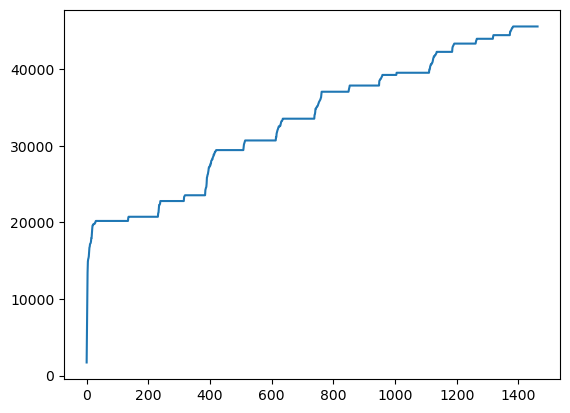

In [8]:
row=[]
dejavu={}
prec_number=0
prec_prot=None
filt=category[ 'Inflammation']  +category['Oncology']+category['Neurology']+category[ 'Cardiometabolic']
df2=dftot[filt].copy()
for i in range(len(filt)):
    lenght=df2.dropna(axis=0).shape[0]
    row+=[lenght]
    b=df2.isnull().sum(axis=0)
    current_prot=list(b.sort_values().tail(1).index)
    try:
        dejavu[lenght] += current_prot
        
    except:
        dejavu[lenght] =  current_prot
    df2.drop(current_prot, axis=1, inplace=True)

list_of_keys = list(dejavu.keys())

for k in list_of_keys:
    if len(dejavu[k])<10:
        del(dejavu[k])
    
    #df2.dropna(axis=0)
plt.plot(row)
plt.show()

#dict_keys(['Oncology', 'Neurology', 'Cardiometabolic', 'Inflammation'])

In [9]:
dftot=load_df()

In [10]:
done=[]
for k in dejavu.keys():
    done+=dejavu[k]
done=set(done)
todo=set(dftot.columns[1:-30]).difference(done)

In [11]:
a,b=remove_corr(dftot[list(todo)+['A']].isnull(), 'A', 0.6)

In [12]:
for k in b.keys():
    if len([k]+b[k])>9:
        dejavu[k]=[k]+b[k]

20182


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15628\729384161.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfclust['r0_'+str(k)]=mydf[0]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15628\729384161.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

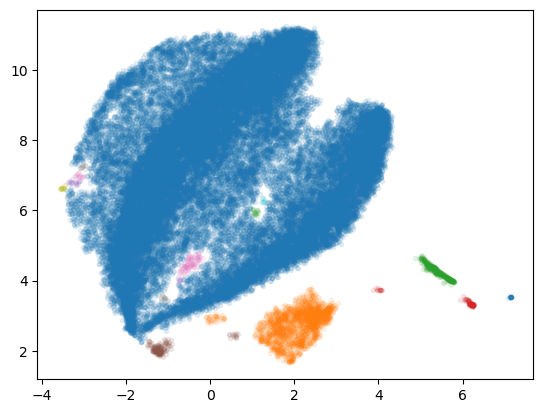

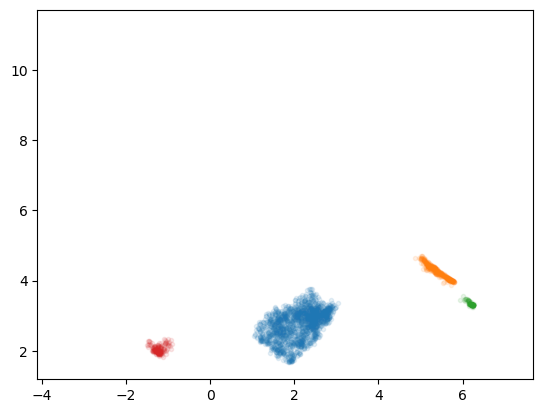

52704
20727


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


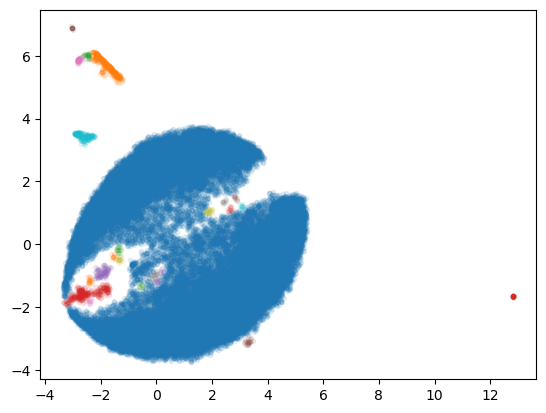

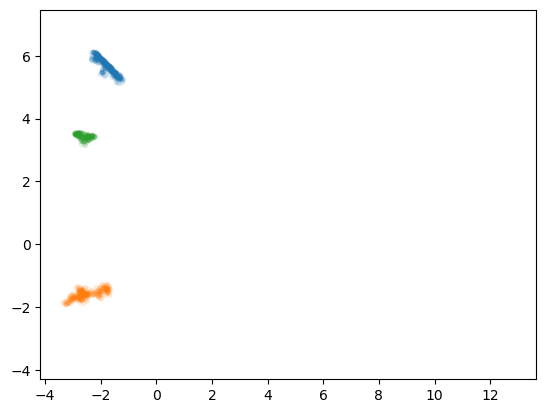

52704
22779


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


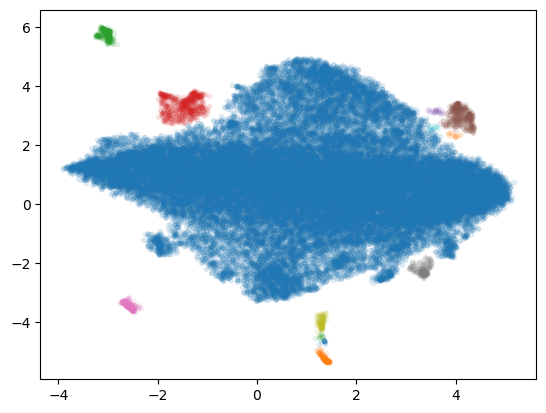

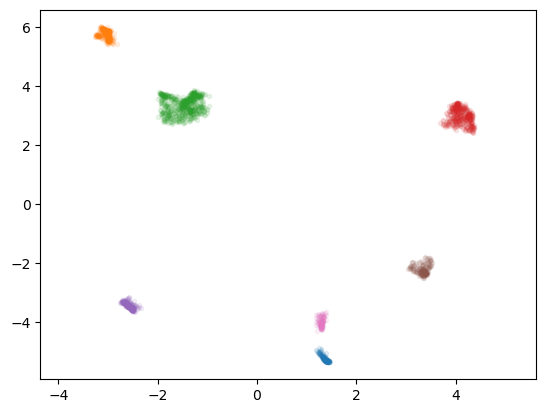

52704
23533


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


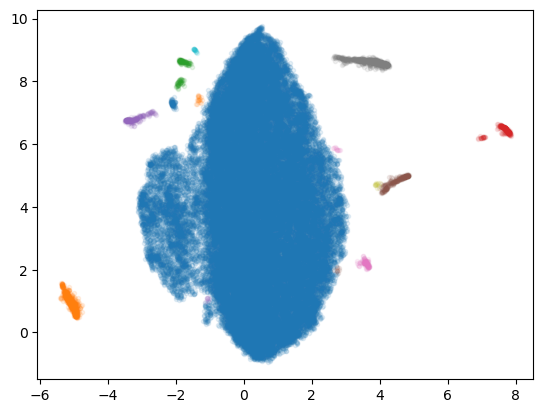

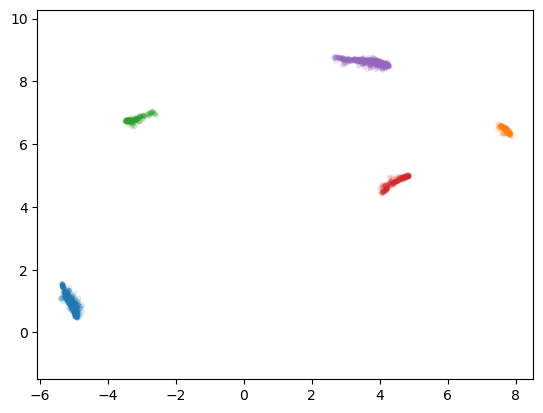

52704
29426


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


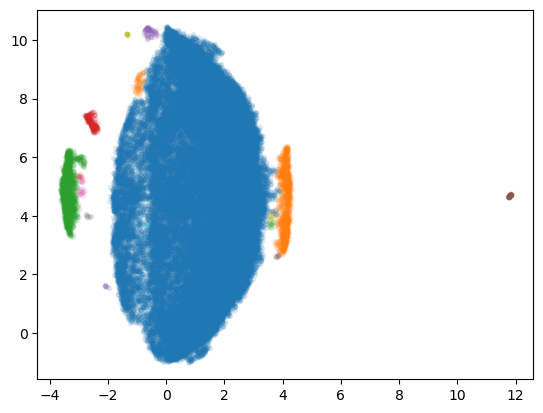

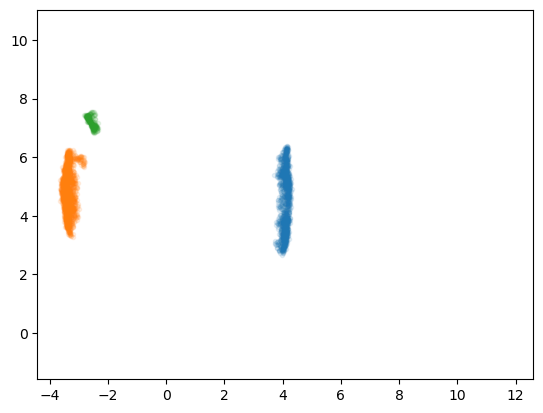

52704
30683


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


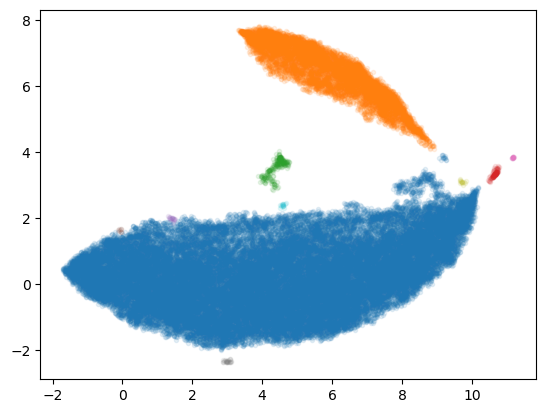

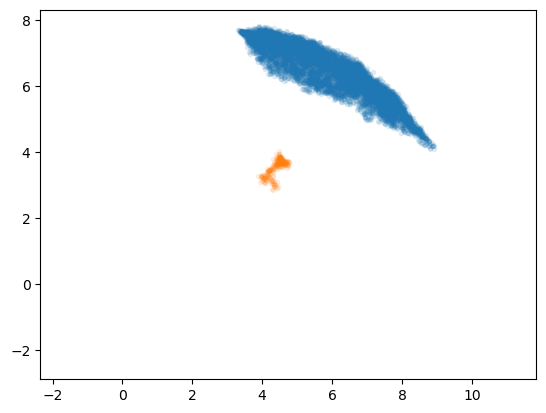

52704
33522


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


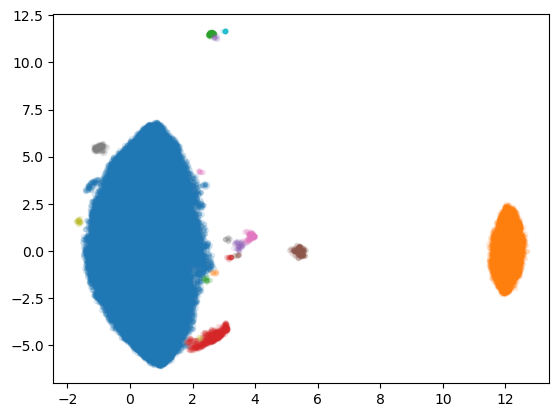

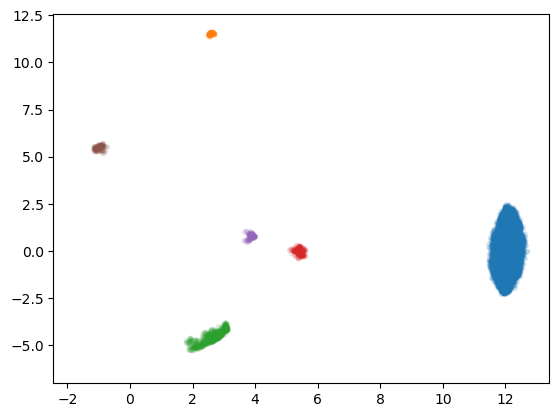

52704
37040


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


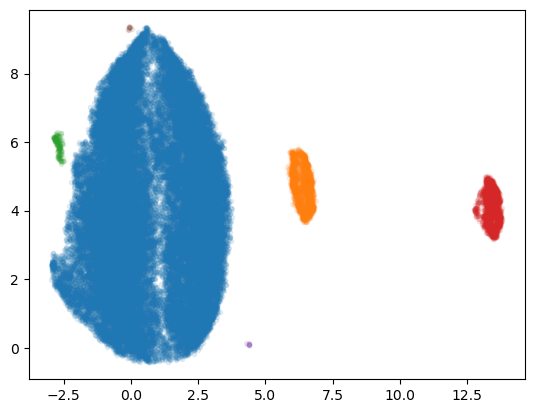

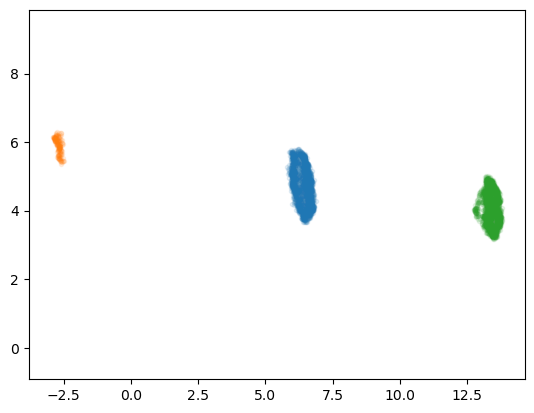

52704
37847


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


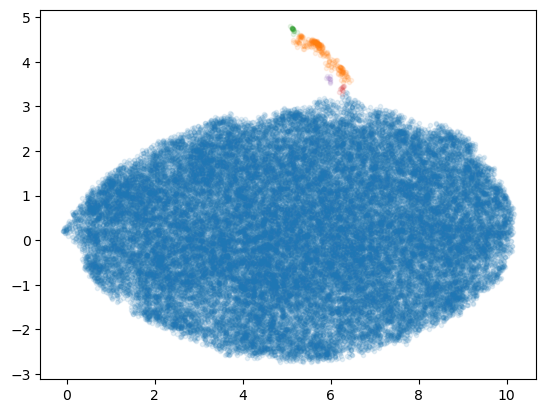

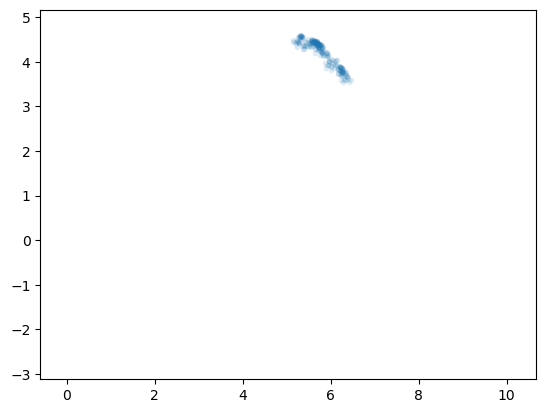

52704
39233


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


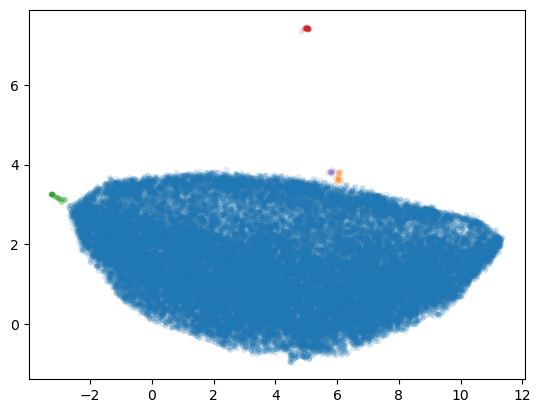

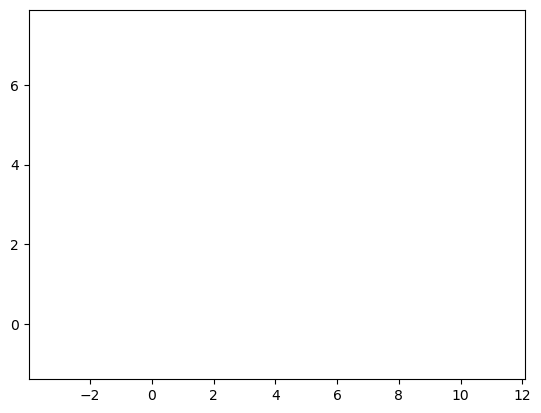

52704
39516


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


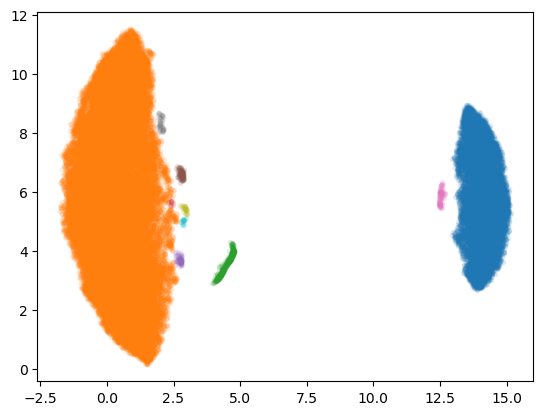

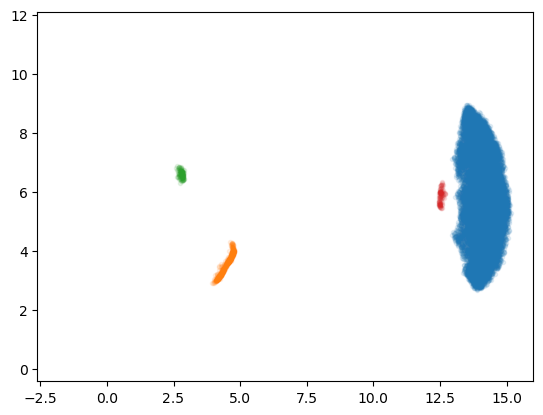

52704
42242


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


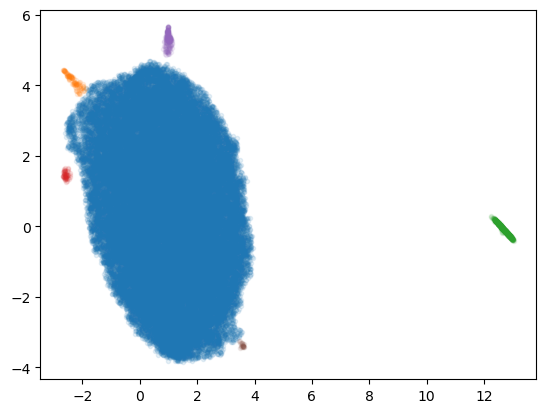

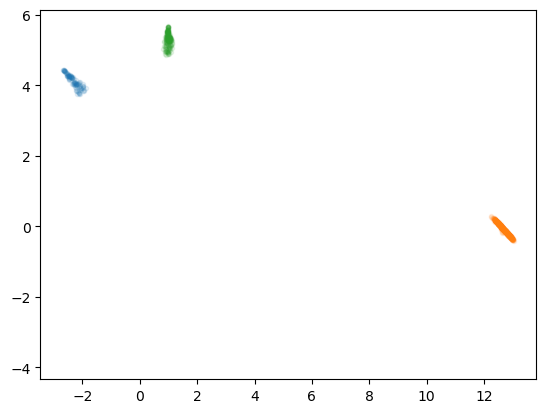

52704
43320


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


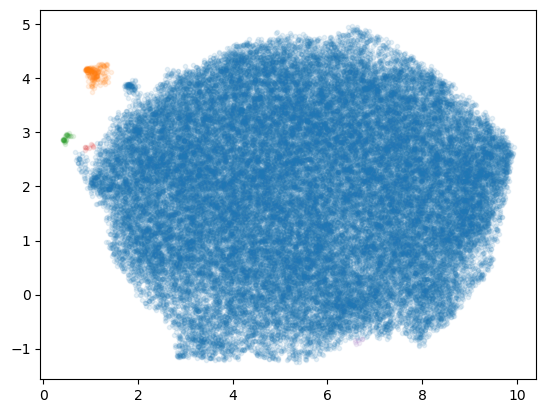

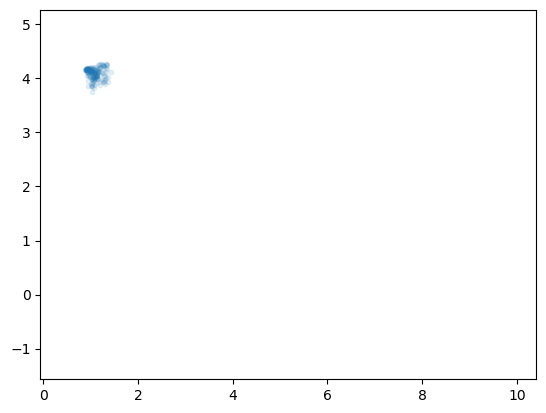

52704
43948


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


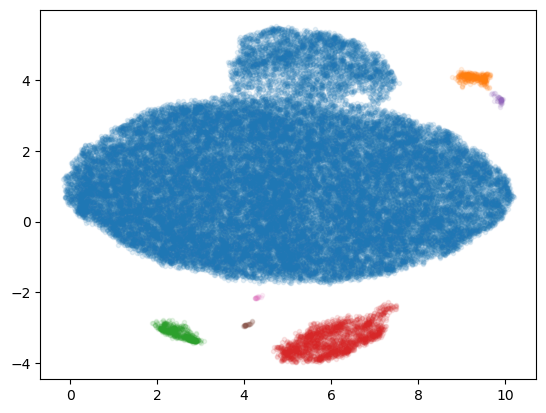

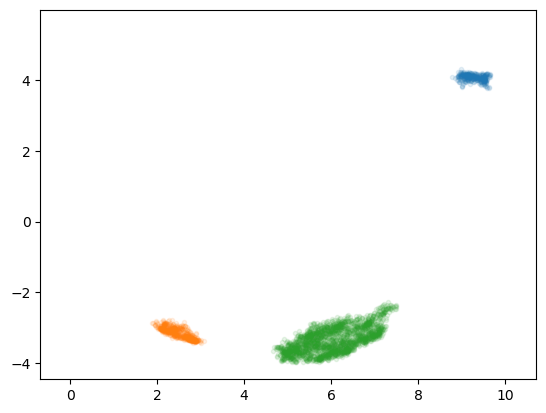

52704
44422


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


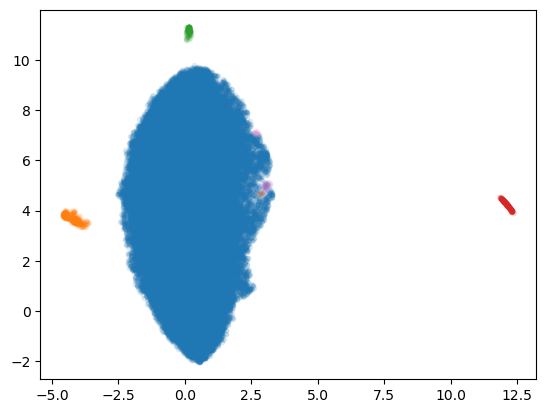

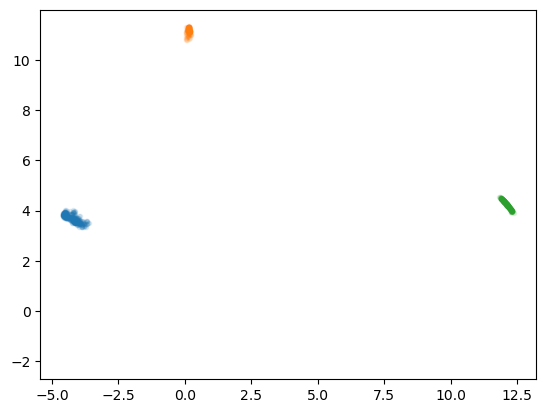

52704
45554


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


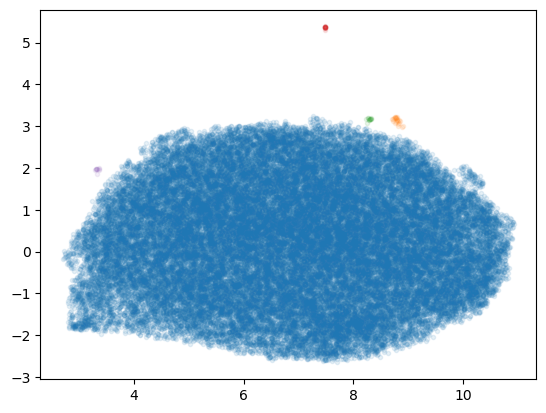

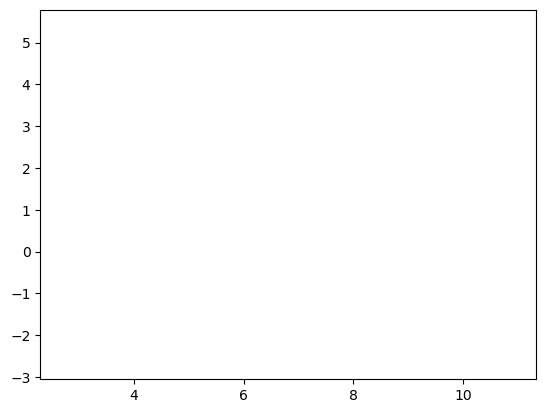

52704
mad1l1


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


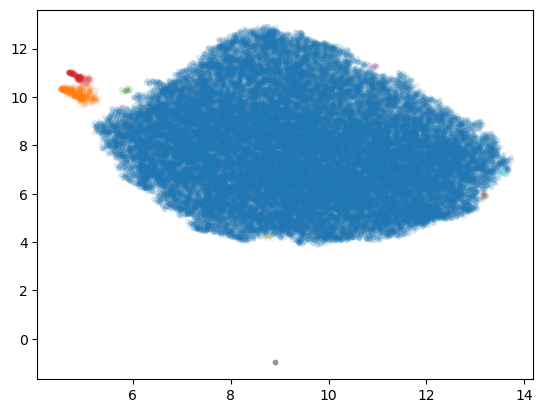

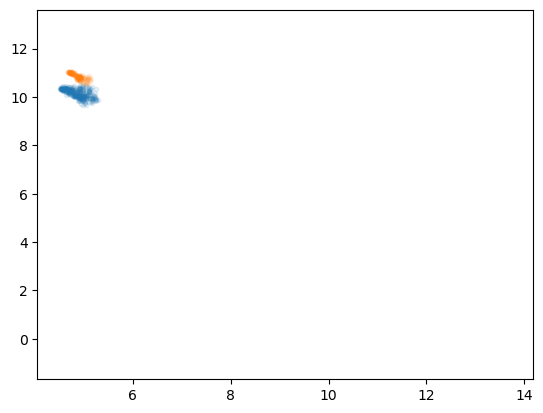

52704
dsg4


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


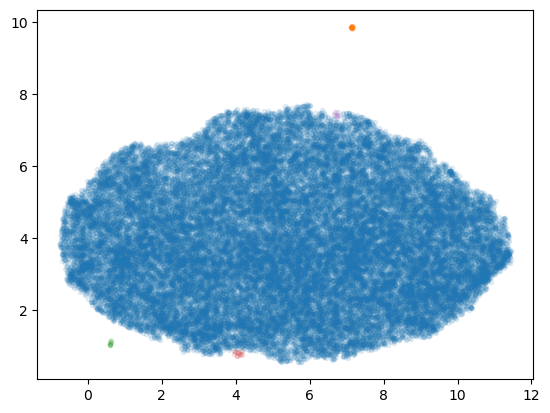

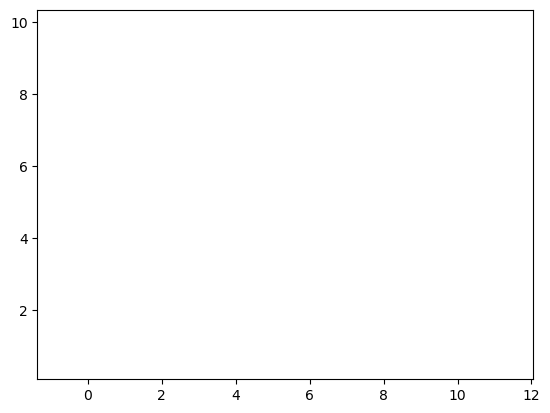

52704
chit1


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


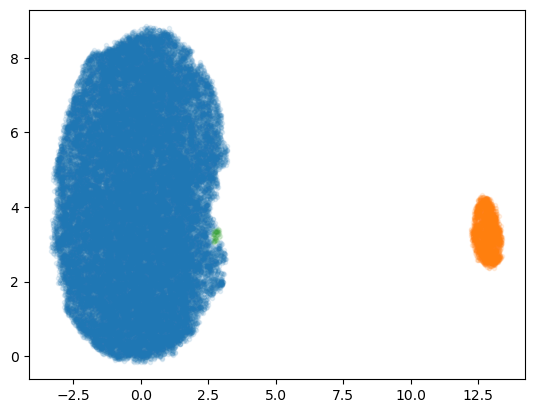

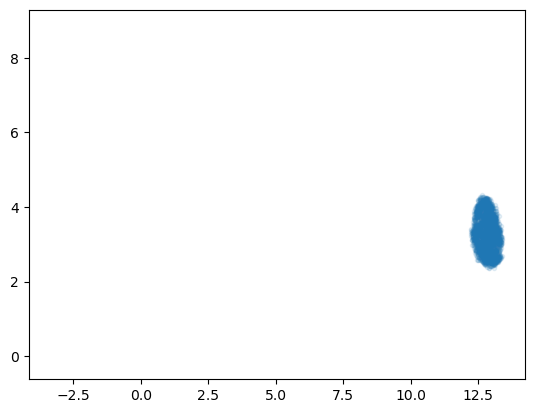

52704
ccl18


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


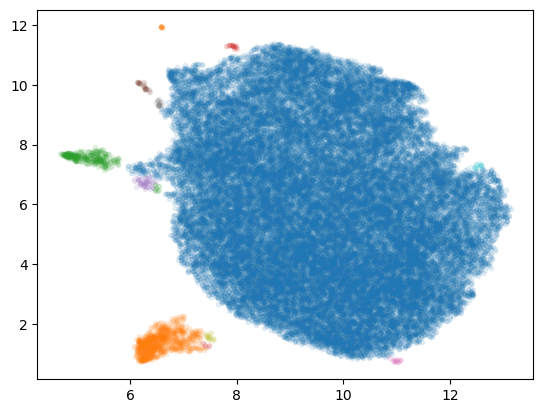

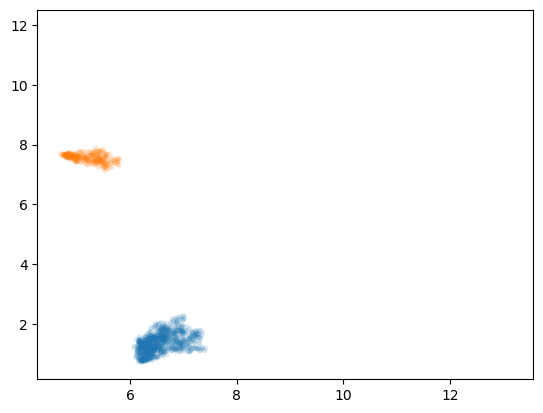

52704
cd300e


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


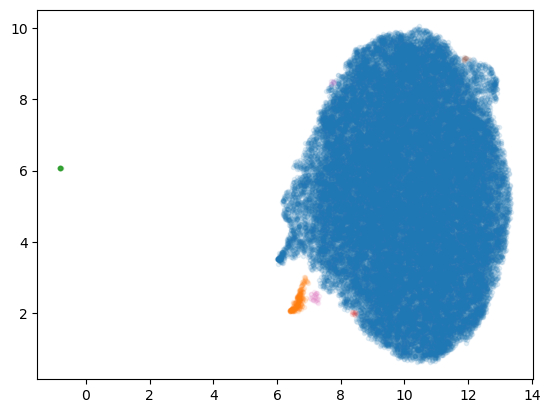

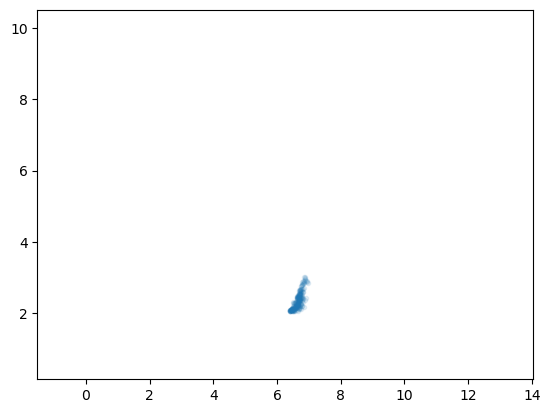

52704
il13ra1


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


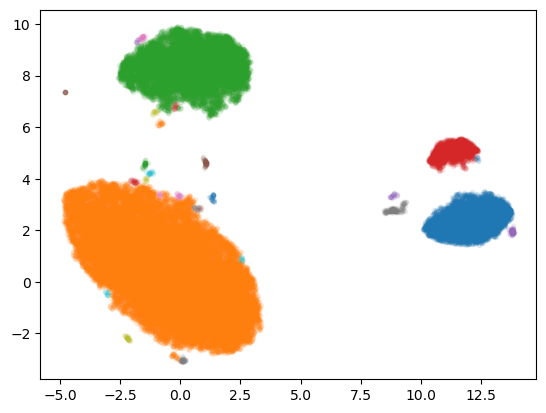

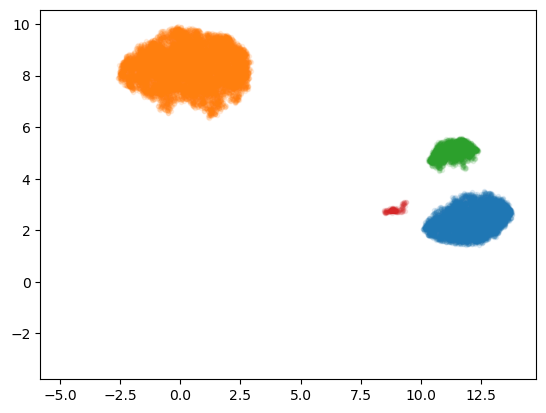

52704
angptl1


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


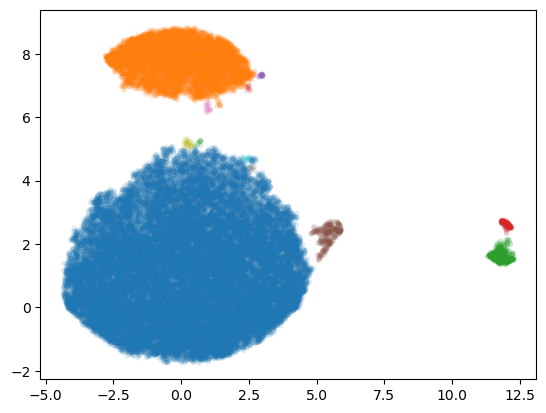

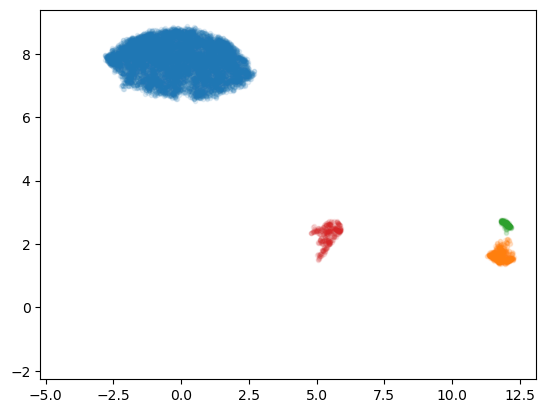

52704


In [13]:

dfclust=dftot[['eid']]
for k in list(dejavu.keys()):
    #np.random.seed(42)
    print(k)
    mydf2=dftot[['eid']+dejavu[k]].dropna(axis=0).copy()
    reducer=umap.UMAP(random_state=41)
    reduced=reducer.fit_transform(mydf2[mydf2.columns[1:]])
    clustering=DBSCAN(min_samples=10, eps=0.1)
    clustered=clustering.fit_predict(reduced)
    mydf=pd.DataFrame(reduced)
    mydf['clust']=clustered
    dfclust['r0_'+str(k)]=mydf[0]
    dfclust['r1_'+str(k)]=mydf[1]

    for n in range(clustered.max()+1):
        plt.plot(mydf[mydf.clust==n][0],mydf[mydf.clust==n][1], '.', alpha=0.1)
    xl=plt.xlim()
    yl=plt.ylim()
    plt.show()

    mydfb=mydf[mydf['clust']>-1]
    a=mydfb.clust.value_counts()
    listclust=a[(a<20000)&(a>100)].index.tolist()
    listclust=sorted(listclust)
    for n in listclust:
        plt.plot(mydf[mydf.clust==n][0],mydf[mydf.clust==n][1], '.', alpha=0.1)
    plt.xlim(xl)
    plt.ylim(yl)
    plt.show()
    mydf2['clust']=clustered
    mydf2['c'+str(k)]=[x if x in listclust else -1 for x in mydf2['clust'] ]
    mydf2['mapped']=['not grouped' if x==-1 else str(x) for x in mydf2['c'+str(k)]]
    '''
    for var in sorted(mydf2.columns[1:-3]):
            pval=[]
            for n in listclust:
                pval+=[ttest_ind(mydf2[var],mydf2[mydf2.clust==n][var], equal_var=False)[1]]
            try:
                if min(pval)<0.001:

                    plt.figure(figsize=(16,7))
                    plt.subplot(121)
                    plt.plot(mydf2[var], 'k.', alpha=0.01)
                    for n in listclust:
                        plt.plot(mydf2[mydf2.clust==n][var], '.', alpha=0.2)

                    plt.title(var)
                    plt.subplot(122)
                    sns.violinplot(data=mydf2, x='mapped', y=var, order=sorted(mydf2.mapped.unique()), orient='v')
                    plt.show()
            except:
                pass
     '''
    dfclust=dfclust.merge(mydf2[['eid','c'+str(k) ]], how='outer')
    print(len(dfclust.eid.unique()))
   

20727


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


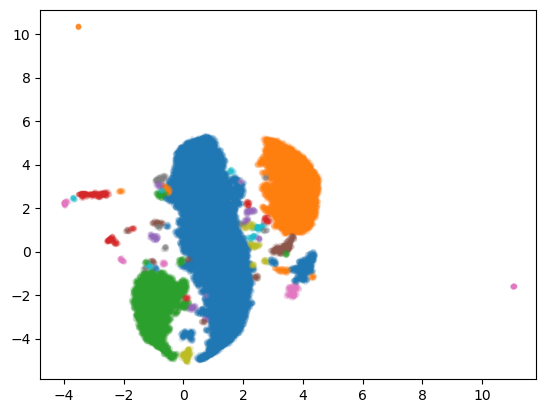

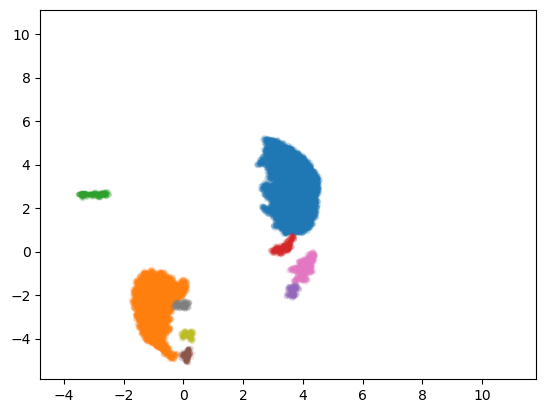

52704
23533


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


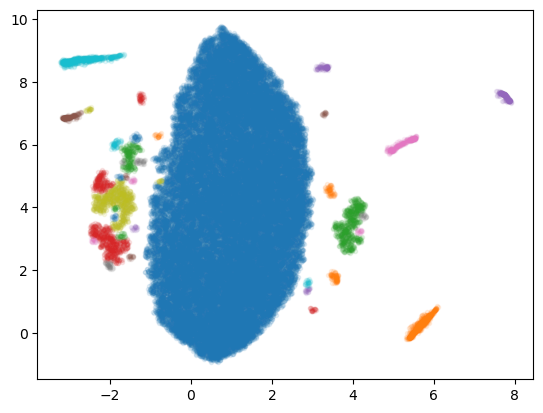

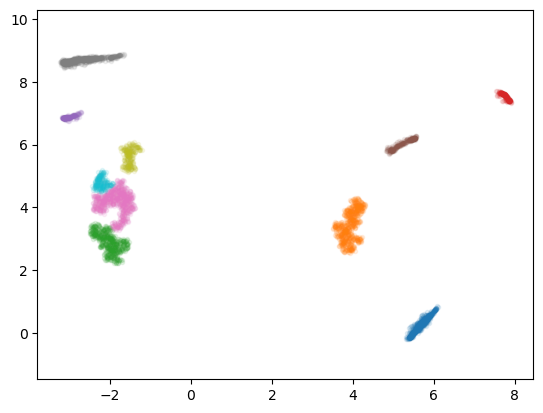

52704
45554


C:\Users\Administrator\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


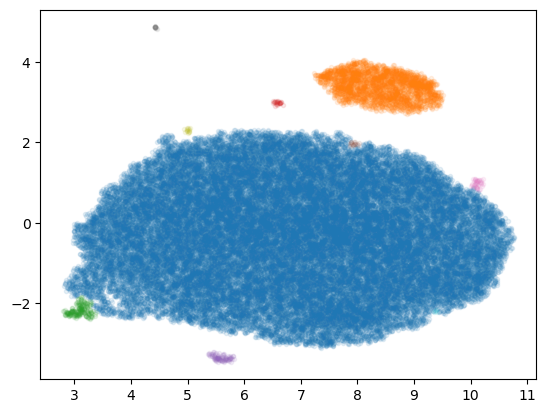

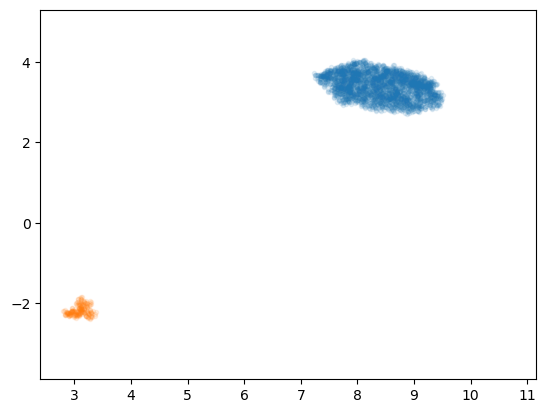

52704


In [14]:


for k, n  in zip([20727, 23533, 45554],[50, 45, 40]):
    #np.random.seed(42)
    print(k)
    mydf2=dftot[['eid']+dejavu[k]].dropna(axis=0).copy()
    reducer=umap.UMAP(random_state=n)
    reduced=reducer.fit_transform(mydf2[mydf2.columns[1:]])
    clustering=DBSCAN(min_samples=15, eps=0.08)
    clustered=clustering.fit_predict(reduced)
    mydf=pd.DataFrame(reduced)
    mydf['clust']=clustered
    dfclust['r0_'+str(k)]=mydf[0]
    dfclust['r1_'+str(k)]=mydf[1]
    
    for n in range(clustered.max()+1):
        plt.plot(mydf[mydf.clust==n][0],mydf[mydf.clust==n][1], '.', alpha=0.1)
    xl=plt.xlim()
    yl=plt.ylim()
    plt.show()

    mydfb=mydf[mydf['clust']>-1]
    a=mydfb.clust.value_counts()
    listclust=a[(a<20000)&(a>100)].index.tolist()
    listclust=sorted(listclust)
    for n in listclust:
        plt.plot(mydf[mydf.clust==n][0],mydf[mydf.clust==n][1], '.', alpha=0.1)
    plt.xlim(xl)
    plt.ylim(yl)
    plt.show()
    mydf2['clust']=clustered
    mydf2['c'+str(k)]=[x if x in listclust else -1 for x in mydf2['clust'] ]
    mydf2['mapped']=['not grouped' if x==-1 else str(x) for x in mydf2['c'+str(k)]]
    '''
    for var in sorted(mydf2.columns[1:-3]):
            pval=[]
            for n in listclust:
                pval+=[ttest_ind(mydf2[var],mydf2[mydf2.clust==n][var], equal_var=False)[1]]
            try:
                if min(pval)<0.001:

                    plt.figure(figsize=(16,7))
                    plt.subplot(121)
                    plt.plot(mydf2[var], 'k.', alpha=0.01)
                    for n in listclust:
                        plt.plot(mydf2[mydf2.clust==n][var], '.', alpha=0.2)

                    plt.title(var)
                    plt.subplot(122)
                    sns.violinplot(data=mydf2, x='mapped', y=var, order=sorted(mydf2.mapped.unique()), orient='v')
                    plt.show()
            except:
                pass
    '''
    dfclust.drop(['c'+str(k) ], axis=1, inplace=True)
    dfclust=dfclust.merge(mydf2[['eid','c'+str(k) ]], how='outer')
    print(len(dfclust.eid.unique()))


In [15]:
colist=[x for x in dfclust.columns if x[0]=='c']
dfclust.fillna(-2, inplace=True)
change=0
for i in colist:
    for j in colist:
        if i!=j:
            
            observed=pd.crosstab(dfclust[i], dfclust[j])
            t=chi2_contingency(observed)
            expected=round(pd.DataFrame(t[3]),0).astype(int)
            expected.columns=observed.columns
            expected.index=observed.index
            print('p_value: ')#, end='')
            display(t[1])
            print('observed:')
            display(observed)
            print('expected:')
            display(expected)
            
            diff=observed-expected
            if observed.shape[0]>2:
                for col in diff.columns[1:]:
                    listobs=diff[col][1:]
                    #print (listobs)
                    highesti=listobs.argmax()
                    highest=listobs.iloc[highesti]
                    #print(listobs.index[highesti])
                    #print(highest)
                    if highest>observed[col].sum()*0.4:
                        #print(observed[col].iloc[:2])
                        dfclust[str(i)]=[listobs.index[highesti] if y==col else x for x,y in zip (dfclust[i], dfclust[j])]
                        change+=1
                       # dfclust[str(j)+'b']=[listobs.index[highesti] if x==col else x for x,y in zip (dfclust[i], dfclust[j])] 
                print('new group:')
                display(pd.crosstab(dfclust[i], dfclust[j]))
print(change)

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c20182                                                       
-2.0     723   1758    95    10    18    12     8     6     7
-1.0    1353  44777     1   344   558   352   219   151     5
 1.0      54   1597     0    14     3    15     6     2     0
 2.0       3    237     0     2     1     2     2     2    95
 3.0       5     18    76     0     0     0     0     0     2
 5.0       5    164     0     1     0     0     1     0     0

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c20182                                                       
-2.0     107   2429     9    19    29    19    12     8     5
-1.0    1942  43997   156   336   526   345   214   146    99
 1.0      69   1558     6    12    19    12     8     5     3
 2.0      14    317     1     2     4     2     2     1     1
 3.0       4     93     0     1     1     1     0     0     0
 5.0       7    158     1     1     2     1     1     1     0

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c20182                                                       
-2.0     723   1758     0    10    18    12     8     6     0
-1.0    1353  44777     0   344   558   352   219   151     0
 1.0      54   1597     0    14     3    15     6     2     0
 2.0       3    237     0     2     1     2     2     2   109
 3.0       5     18   172     0     0     0     0     0     0
 5.0       5    164     0     1     0     0     1     0     0

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0     371   2071    44    45     4
-1.0    1967  43311  1090  1377     9
 1.0      60   1544    35    52     0
 2.0      18    109     6     4   221
 3.0      95    100     0     0     0
 5.0      15    152     1     3     0

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0     121   2274    57    71    11
-1.0    2289  42846  1066  1342   212
 1.0      81   1517    38    48     8
 2.0      17    321     8    10     2
 3.0       9    175     4     5     1
 5.0       8    153     4     5     1

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0     371   2071    44    45     0
-1.0    1967  43311  1090  1377     0
 1.0      60   1544    35    52     0
 2.0      18    109     6     4   234
 3.0      95    100     0     0     0
 5.0      15    152     1     3     0

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c20182                         
-2.0     523   1701   306     1
-1.0     842  39904  6997     2
 1.0      26   1424   241     0
 2.0       3    120    23   225
 3.0      94    101     0     0
 5.0       5    164     2     0

expected:


c30683  -2.0   -1.0   1.0   2.0
c20182                         
-2.0      72   2085   363    11
-1.0    1353  39329  6857   207
 1.0      48   1393   243     7
 2.0      11    306    53     2
 3.0       6    161    28     1
 5.0       5    141    25     1

new group:


c30683  -2.0   -1.0   1.0   2.0
c20182                         
-2.0     523   1701   306     0
-1.0     842  39904  6997     0
 1.0      26   1424   241     0
 2.0       3    120    23   228
 3.0      94    101     0     0
 5.0       5    164     2     0

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c20182                                                 
-2.0     304   1956   227     5    25     8     0     5
-1.0    1452  40378  5146     0   552   201     0    14
 1.0      49   1448   175     0    13     5     0     1
 2.0      13    215    25     0     0     0   120     1
 3.0       6     11     0   178     0     0     0     0
 5.0       6     38    13     0     0     0     0   114

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c20182                                                 
-2.0      88   2114   268     9    28    10     6     6
-1.0    1658  39900  5060   166   534   194   109   122
 1.0      59   1413   179     6    19     7     4     4
 2.0      13    313    40     1     4     2     1     1
 3.0       7    163    21     1     2     1     0     0
 5.0       6    143    18     1     2     1     0     0

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c20182                                                 
-2.0     304   1956   227     0    25     8     0     0
-1.0    1452  40378  5146     0   552   201     0     0
 1.0      49   1448   175     0    13     5     0     0
 2.0      13    215    25     0     0     0   120     0
 3.0       6     11     0   183     0     0     0     0
 5.0       6     38    13     0     0     0     0   135

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0     371   2003    72     0    74
-1.0    2841  41693  1633     4  1558
 1.0      99   1493    56     1    41
 2.0      22    171    18   154     8
 3.0     105     93     1     0     1
 5.0      10    172     7     1     2

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0     165   2182    85     8    81
-1.0    3123  41318  1618   145  1525
 1.0     111   1463    57     5    54
 2.0      24    323    13     1    12
 3.0      13    173     7     1     6
 5.0      13    166     7     1     6

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0     371   2003    72     0    74
-1.0    2841  41693  1633     0  1558
 1.0      99   1493    56     0    41
 2.0      22    171    18   160     8
 3.0     105     93     1     0     1
 5.0      10    172     7     0     2

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c20182                   
-2.0     462   2055     3
-1.0    2869  44842    14
 1.0     104   1585     0
 2.0      23    161   195
 3.0     103     73    24
 5.0       9    182     0

expected:


c37847  -2.0   -1.0   1.0
c20182                   
-2.0     171   2338    11
-1.0    3233  44279   214
 1.0     114   1567     8
 2.0      26    352     2
 3.0      14    186     1
 5.0      13    177     1

new group:


c37847  -2.0   -1.0   1.0
c20182                   
-2.0     462   2055     0
-1.0    2869  44842     0
 1.0     104   1585     0
 2.0      23    161   236
 3.0     103     73     0
 5.0       9    182     0

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c20182             
-2.0     332   2185
-1.0     715  46996
 1.0      40   1649
 2.0       2    418
 3.0      93     83
 5.0       1    190

expected:


c39233  -2.0   -1.0
c20182             
-2.0      56   2461
-1.0    1071  46640
 1.0      38   1651
 2.0       9    411
 3.0       4    172
 5.0       4    187

new group:


c39233  -2.0   -1.0
c20182             
-2.0     332   2185
-1.0     715  46996
 1.0      40   1649
 2.0       2    418
 3.0      93     83
 5.0       1    190

p_value: 


1.1563572224069166e-23

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c20182                                      
-2.0     223   1730    526    30     5     3
-1.0    1876  34717  10417   481   123    97
 1.0      76   1208    379    21     1     4
 2.0      10    314     93     3     0     0
 3.0      15    130     31     0     0     0
 5.0       7    140     43     1     0     0

expected:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c20182                                      
-2.0     105   1826    549    26     6     5
-1.0    1998  34616  10401   485   117    94
 1.0      71   1225    368    17     4     3
 2.0      18    305     92     4     1     1
 3.0       7    128     38     2     0     0
 5.0       8    139     42     2     0     0

new group:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c20182                                      
-2.0     223   1730    526    30     5     3
-1.0    1876  34717  10417   481   123    97
 1.0      76   1208    379    21     1     4
 2.0      10    314     93     3     0     0
 3.0      15    130     31     0     0     0
 5.0       7    140     43     1     0     0

p_value: 


1.8889561886548727e-10

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c20182                               
-2.0     158   2304     1    43    11
-1.0    1878  44902   108   645   178
 1.0      62   1605     1    21     0
 2.0      16    394     0    10     0
 3.0      21    152     0     3     0
 5.0       4    184     0     3     0

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c20182                               
-2.0     102   2366     5    35     9
-1.0    1936  44848   100   656   171
 1.0      69   1588     4    23     6
 2.0      17    395     1     6     2
 3.0       7    165     0     2     1
 5.0       8    180     0     3     1

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c20182                               
-2.0     158   2304     1    43    11
-1.0    1878  44902   108   645   178
 1.0      62   1605     1    21     0
 2.0      16    394     0    10     0
 3.0      21    152     0     3     0
 5.0       4    184     0     3     0

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c20182                   
-2.0     666   1850     1
-1.0     604  47100     7
 1.0      19   1670     0
 2.0       0    249   171
 3.0      93     83     0
 5.0       2    189     0

expected:


c43320  -2.0   -1.0   1.0
c20182                   
-2.0      66   2442     9
-1.0    1253  46296   162
 1.0      44   1639     6
 2.0      11    408     1
 3.0       5    171     1
 5.0       5    185     1

new group:


c43320  -2.0   -1.0   1.0
c20182                   
-2.0     666   1850     0
-1.0     604  47100     0
 1.0      19   1670     0
 2.0       0    249   179
 3.0      93     83     0
 5.0       2    189     0

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0     209   2194     2    25    86
-1.0     793  44524    19   464  1904
 1.0      22   1571     0    23    73
 2.0       6    121   296     0     5
 3.0      99     77     0     0     0
 5.0       2    181     1     0     7

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0      54   2323    15    24    99
-1.0    1024  44051   288   463  1878
 1.0      36   1560    10    16    66
 2.0       9    395     3     4    17
 3.0       4    163     1     2     7
 5.0       4    176     1     2     8

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0     209   2194     0    25    86
-1.0     793  44524     0   464  1904
 1.0      22   1571     0    23    73
 2.0       6    121   318     0     5
 3.0      99     77     0     0     0
 5.0       2    181     0     0     7

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0     250   2246     2     1    15
-1.0     661  46641    24    17   342
 1.0      26   1649     1     0    13
 2.0       4    103   318    23     2
 3.0       4     24     1   147     0
 5.0       1    185     0     0     4

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0      45   2425    17     9    18
-1.0     856  46006   313   170   340
 1.0      30   1630    11     6    12
 2.0       8    434     3     2     3
 3.0       3    170     1     1     1
 5.0       3    183     1     1     1

new group:


c44422  -2.0   -1.0   1.0   2.0   3.0
c20182                               
-2.0     250   2246     0     0    15
-1.0     661  46641     0     0   342
 1.0      26   1649     0     0    13
 2.0       4    103   346     0     2
 3.0       4     24     0   188     0
 5.0       1    185     0     0     4

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c20182                          
-2.0      437   2066     5     3
-1.0     3924  43667    49     4
 1.0      125   1561     2     0
 2.0       34    163   236    22
 3.0      108     10    12    86
 5.0       27    163     0     0

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c20182                          
-2.0      222   2269    14     5
-1.0     4208  43057   275   104
 1.0      149   1525    10     4
 2.0       40    411     3     1
 3.0       19    195     1     0
 5.0       17    172     1     0

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c20182                          
-2.0      437   2066     0     0
-1.0     3924  43667     0     0
 1.0      125   1561     0     0
 2.0       34    163   304     0
 3.0      108     10     0   115
 5.0       27    163     0     0

p_value: 


1.137919226703076e-214

observed:


cdsg4   -2.0   -1.0
c20182             
-2.0     572   1931
-1.0    4239  43352
 1.0     147   1539
 2.0      39    462
 3.0     121    112
 5.0      24    166

expected:


cdsg4   -2.0   -1.0
c20182             
-2.0     244   2259
-1.0    4643  42948
 1.0     164   1522
 2.0      49    452
 3.0      23    210
 5.0      19    171

new group:


cdsg4   -2.0   -1.0
c20182             
-2.0     572   1931
-1.0    4239  43352
 1.0     147   1539
 2.0      39    462
 3.0     121    112
 5.0      24    166

p_value: 


0.11666957573214559

observed:


cchit1  -2.0   -1.0   1.0
c20182                   
-2.0     211   2162   130
-1.0    4502  41113  1976
 1.0     150   1462    74
 2.0      55    430    16
 3.0      27    198     8
 5.0      13    167    10

expected:


cchit1  -2.0   -1.0   1.0
c20182                   
-2.0     235   2162   105
-1.0    4477  41115  1999
 1.0     159   1457    71
 2.0      47    433    21
 3.0      22    201    10
 5.0      18    164     8

new group:


cchit1  -2.0   -1.0   1.0
c20182                   
-2.0     211   2162   130
-1.0    4502  41113  1976
 1.0     150   1462    74
 2.0      55    430    16
 3.0      27    198     8
 5.0      13    167    10

p_value: 


0.0004536525750962222

observed:


cccl18  -2.0   -1.0   1.0   2.0
c20182                         
-2.0     340   2094    48    21
-1.0    5566  40899   825   301
 1.0     185   1463    30     8
 2.0      60    434     6     1
 3.0      46    186     1     0
 5.0      13    171     6     0

expected:


cccl18  -2.0   -1.0   1.0   2.0
c20182                         
-2.0     295   2149    44    16
-1.0    5608  40857   827   299
 1.0     199   1447    29    11
 2.0      59    430     9     3
 3.0      27    200     4     1
 5.0      22    163     3     1

new group:


cccl18  -2.0   -1.0   1.0   2.0
c20182                         
-2.0     340   2094    48    21
-1.0    5566  40899   825   301
 1.0     185   1463    30     8
 2.0      60    434     6     1
 3.0      46    186     1     0
 5.0      13    171     6     0

p_value: 


0.0

observed:


ccd300e  -2.0   -1.0   1.0
c20182                    
-2.0      552   1945     6
-1.0     2662  44721   208
 1.0      104   1579     3
 2.0       14    482     5
 3.0      110    122     1
 5.0        5    185     0

expected:


ccd300e  -2.0   -1.0   1.0
c20182                    
-2.0      164   2329    11
-1.0     3113  44277   201
 1.0      110   1569     7
 2.0       33    466     2
 3.0       15    217     1
 5.0       12    177     1

new group:


ccd300e  -2.0   -1.0   1.0
c20182                    
-2.0      552   1945     6
-1.0     2662  44721   208
 1.0      104   1579     3
 2.0       14    482     5
 3.0      110    122     1
 5.0        5    185     0

p_value: 


1.1209595059520474e-264

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c20182                                       
-2.0       467   1306   209   438    76     7
-1.0      2873  28614  4783  9558  1613   150
 1.0       105   1048   167   313    49     4
 2.0        36    301    42    97    23     2
 3.0       119     86     7    16     5     0
 5.0         9    117    17    42     5     0

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c20182                                       
-2.0       171   1495   248   497    84     8
-1.0      3259  28419  4718  9449  1599   147
 1.0       115   1007   167   335    57     5
 2.0        34    299    50    99    17     2
 3.0        16    139    23    46     8     1
 5.0        13    113    19    38     6     1

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c20182                                       
-2.0       467   1306   209   438    76     7
-1.0      2873  28614  4783  9558  1613   150
 1.0       105   1048   167   313    49     4
 2.0        36    301    42    97    23     2
 3.0       119     86     7    16     5     0
 5.0         9    117    17    42     5     0

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c20182                                       
-2.0       394   1651   358    32    11    57
-1.0      4740  34470  7647   525   185    24
 1.0       169   1209   287    14     6     1
 2.0        48    252    74     5     2   120
 3.0        31     57     9     2     0   134
 5.0        21    132    35     1     1     0

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c20182                                       
-2.0       257   1794   399    27    10    16
-1.0      4879  34107  7594   523   185   303
 1.0       173   1208   269    19     7    11
 2.0        51    359    80     6     2     3
 3.0        24    167    37     3     1     1
 5.0        19    136    30     2     1     1

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c20182                                       
-2.0       394   1651   358    32    11    57
-1.0      4740  34470  7647   525   185    24
 1.0       169   1209   287    14     6     1
 2.0        48    252    74     5     2   120
 3.0        31     57     9     2     0   134
 5.0        21    132    35     1     1     0

p_value: 


0.0

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c20182                                                                         
-2.0      751   1160    315    223      0     12     10      7     15      6   
-1.0     1836  29164   9161   6182      0    275    134     55    556    123   
 1.0       63   1057    363    168      1     11      1      0     13      5   
 2.0       23    174     16     14    267      0      0      0      6      0   
 3.0      111    112      0      1      9      0      0      0      0      0   
 5.0        8     43      0      2      0      1      0    112      0      0   

c20727   20.0  
c20182         
-2.0        4  
-1.0      105  
 1.0        4  
 2.0        1  
 3.0        0  
 5.0       24

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c20182                                                                         
-2.0      133   1506    468    313     13     14      7      8     28      6   
-1.0     2521  28634   8899   5951    250    270    131    157    533    121   
 1.0       89   1014    315    211      9     10      5      6     19      4   
 2.0       27    301     94     63      3      3      1      2      6      1   
 3.0       12    140     44     29      1      1      1      1      3      1   
 5.0       10    114     36     24      1      1      1      1      2      0   

c20727   20.0  
c20182         
-2.0        7  
-1.0      125  
 1.0        4  
 2.0        1  
 3.0        1  
 5.0        0

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c20182                                                                         
-2.0      751   1160    315    223      0     12     10      0     15      6   
-1.0     1836  29164   9161   6182      0    275    134      0    556    123   
 1.0       63   1057    363    168      0     11      1      0     13      5   
 2.0       23    174     16     14    277      0      0      0      6      0   
 3.0      111    112      0      1      0      0      0      0      0      0   
 5.0        8     43      0      2      0      1      0    174      0      0   

c20727   20.0  
c20182         
-2.0        4  
-1.0      105  
 1.0        4  
 2.0        1  
 3.0        0  
 5.0       24

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c20182                                                                         
-2.0      616   1671     20     25     19     68     10      1     23     27   
-1.0     2564  41487    665    583    491      0    144      1    638    585   
 1.0       73   1495     22     10     23      0      4      0     25     23   
 2.0       40    220      2      3      5      3      2    218      5     10   
 3.0       25     42      0      0      0    155      0      1      0      1   
 5.0       18    227      1      2      0      0      0      0      0      3   

c23533   12.0   13.0  
c20182                
-2.0        5     11  
-1.0      206    172  
 1.0        6      4  
 2.0        1      2  
 3.0        0      0  
 5.0        1      0

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c20182                                                                         
-2.0      158   2138     34     30     25     11      8     10     33     31   
-1.0     3009  40716    640    562    485    204    144    199    623    585   
 1.0      107   1443     23     20     17      7      5      7     22     21   
 2.0       32    438      7      6      5      2      2      2      7      6   
 3.0       14    192      3      3      2      1      1      1      3      3   
 5.0       16    216      3      3      3      1      1      1      3      3   

c23533   12.0   13.0  
c20182                
-2.0       10      9  
-1.0      198    170  
 1.0        7      6  
 2.0        2      2  
 3.0        1      1  
 5.0        1      1

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c20182                                                                         
-2.0      616   1671     20     25     19      0     10      0     23     27   
-1.0     2564  41487    665    583    491      0    144      0    638    585   
 1.0       73   1495     22     10     23      0      4      0     25     23   
 2.0       40    220      2      3      5      0      2    221      5     10   
 3.0       25     42      0      0      0    226      0      0      0      1   
 5.0       18    227      1      2      0      0      0      0      0      3   

c23533   12.0   13.0  
c20182                
-2.0        5     11  
-1.0      206    172  
 1.0        6      4  
 2.0        1      2  
 3.0        0      0  
 5.0        1      0

p_value: 


1.5790813181617463e-06

observed:


c45554  -2.0   -1.0   1.0   2.0
c20182                         
-2.0     130   2156   125    16
-1.0    1705  43204  2457   169
 1.0      62   1521    95     7
 2.0      21    460    28     2
 3.0      23    268     2     1
 5.0      13    228    11     0

expected:


c45554  -2.0   -1.0   1.0   2.0
c20182                         
-2.0      90   2203   125     9
-1.0    1762  43145  2451   176
 1.0      62   1529    87     6
 2.0      19    464    26     2
 3.0      11    267    15     1
 5.0       9    229    13     1

new group:


c45554  -2.0   -1.0   1.0   2.0
c20182                         
-2.0     130   2156   125    16
-1.0    1705  43204  2457   169
 1.0      62   1521    95     7
 2.0      21    460    28     2
 3.0      23    268     2     1
 5.0      13    228    11     0

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c22779                                     
-2.0     638   1342    54    17    82    10
-1.0    1735  44578  1591   368    42   237
 1.0       0      0     0     4   168     0
 2.0      10    342    14     3     0     2
 3.0      18    555     3     4     0     0
 5.0      12    350    15     2     0     2
 6.0       8    219     6     2     0     1
 7.0       6    149     2     4     0     0
 8.0       0      0     0   107     2     0

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c22779                                     
-2.0      99   1933    69    21    12    10
-1.0    2236  43789  1552   471   271   232
 1.0       8    155     5     2     1     1
 2.0      17    335    12     4     2     2
 3.0      27    523    19     6     3     3
 5.0      18    344    12     4     2     2
 6.0      11    213     8     2     1     1
 7.0       7    145     5     2     1     1
 8.0       5     98     3     1     1     1

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c22779                                     
-2.0     638   1342    54    17     0    10
-1.0    1735  44578  1591   368     0   237
 1.0       0      0     0     4   294     0
 2.0      10    342    14     3     0     2
 3.0      18    555     3     4     0     0
 5.0      12    350    15     2     0     2
 6.0       8    219     6     2     0     1
 7.0       6    149     2     4     0     0
 8.0       0      0     0   107     0     0

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0     257   1701    49    50     4
-1.0    2022  43887  1086  1383   131
 1.0     171    126     0     0     1
 2.0      11    342     9     9     0
 3.0      26    527    15    11     1
 5.0      14    343     7    15     2
 6.0       9    216     6     4     1
 7.0      10    137     4     9     1
 8.0       6      8     0     0    93

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0      99   1849    46    58     9
-1.0    2325  43523  1082  1363   215
 1.0      14    267     7     8     1
 2.0      18    333     8    10     2
 3.0      28    520    13    16     3
 5.0      18    342     9    11     2
 6.0      11    212     5     7     1
 7.0       8    144     4     5     1
 8.0       5     96     2     3     0

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0     257   1701    49    50     4
-1.0    2022  43887  1086  1383   131
 1.0     171    126     0     0     1
 2.0      11    342     9     9     0
 3.0      26    527    15    11     1
 5.0      14    343     7    15     2
 6.0       9    216     6     4     1
 7.0      10    137     4     9     1
 8.0       6      8     0     0    93

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c22779                         
-2.0     241   1520   296     4
-1.0    1012  40364  7009   124
 1.0     169    129     0     0
 2.0       3    306    60     2
 3.0      48    447    85     0
 5.0      11    316    52     2
 6.0       7    191    37     1
 7.0       2    128    29     2
 8.0       0     13     1    93

expected:


c30683  -2.0   -1.0   1.0   2.0
c22779                         
-2.0      58   1698   296     9
-1.0    1374  39958  6967   210
 1.0       8    245    43     1
 2.0      11    306    53     2
 3.0      16    478    83     3
 5.0      11    314    55     2
 6.0       7    194    34     1
 7.0       5    133    23     1
 8.0       3     88    15     0

new group:


c30683  -2.0   -1.0   1.0   2.0
c22779                         
-2.0     241   1520   296     0
-1.0    1012  40364  7009     0
 1.0     169    129     0     0
 2.0       3    306    60     0
 3.0      48    447    85     0
 5.0      11    316    52     0
 6.0       7    191    37     0
 7.0       2    128    29     0
 8.0       0     13     1   228

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c22779                                                 
-2.0     351   1473   186     0    28    12     0     7
-1.0    1338  40981  5196     1   545   195     3   126
 1.0      78     38     0   182     0     0     0     0
 2.0       8    318    40     0     1     2     0     0
 3.0      25    476    75     0     4     0     0     0
 5.0      11    321    36     0     9     2     0     0
 6.0       7    196    28     0     2     1     0     1
 7.0       4    137    15     0     1     2     0     0
 8.0       8    106    10     0     0     0   117     1

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c22779                                                 
-2.0      71   1719   218     7    23     8     5     5
-1.0    1680  40437  5128   168   542   196   110   124
 1.0      10    249    32     1     3     1     1     1
 2.0      13    308    39     1     4     1     1     1
 3.0      20    485    61     2     6     2     1     1
 5.0      13    317    40     1     4     2     1     1
 6.0       8    196    25     1     3     1     1     1
 7.0       6    133    17     1     2     1     0     0
 8.0       8    202    26     1     3     1     1     1

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c22779                                                 
-2.0     351   1473   186     0    28    12     0     7
-1.0    1338  40981  5196     0   545   195     0   126
 1.0      78     38     0   183     0     0     0     0
 2.0       8    318    40     0     1     2     0     0
 3.0      25    476    75     0     4     0     0     0
 5.0      11    321    36     0     9     2     0     0
 6.0       7    196    28     0     2     1     0     1
 7.0       4    137    15     0     1     2     0     0
 8.0       8    106    10     0     0     0   120     1

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0     269   1676    57     0    55
-1.0    2874  42269  1656    15  1567
 1.0     176    118     2     1     2
 2.0      26    318    12     0    13
 3.0      30    508    22     1    19
 5.0      25    327    13     0    14
 6.0      17    203    10     0     5
 7.0      15    136     6     0     2
 8.0      16     70     9   143     7

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0     135   1781    70     6    66
-1.0    3165  41883  1640   147  1546
 1.0      20    259    10     1    10
 2.0      24    319    13     1    12
 3.0      38    502    20     2    19
 5.0      25    328    13     1    12
 6.0      15    203     8     1     8
 7.0      10    138     5     0     5
 8.0      16    212     8     1     8

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0     269   1676    57     0    55
-1.0    2874  42269  1656     0  1567
 1.0     176    118     2     0     2
 2.0      26    318    12     0    13
 3.0      30    508    22     0    19
 5.0      25    327    13     0    14
 6.0      17    203    10     0     5
 7.0      15    136     6     0     2
 8.0      16     70     9   160     7

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c22779                   
-2.0     278   1777     2
-1.0    3001  45340    25
 1.0     175     98    25
 2.0      16    353     0
 3.0      35    544     0
 5.0      26    353     0
 6.0      13    222     0
 7.0       8    150     1
 8.0      18     61   183

expected:


c37847  -2.0   -1.0   1.0
c22779                   
-2.0     139   1908     9
-1.0    3276  44873   217
 1.0      20    276     1
 2.0      25    342     2
 3.0      39    537     3
 5.0      26    352     2
 6.0      16    218     1
 7.0      11    148     1
 8.0      18    243     1

new group:


c37847  -2.0   -1.0   1.0
c22779                   
-2.0     278   1777     0
-1.0    3001  45340     0
 1.0     175     98     0
 2.0      16    353     0
 3.0      35    544     0
 5.0      26    353     0
 6.0      13    222     0
 7.0       8    150     0
 8.0      18     61   236

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c22779             
-2.0     116   1939
-1.0     867  47474
 1.0     164    109
 2.0       8    361
 3.0       7    572
 5.0      12    367
 6.0       3    232
 7.0       4    154
 8.0       2    313

expected:


c39233  -2.0   -1.0
c22779             
-2.0      46   2009
-1.0    1085  47256
 1.0       6    267
 2.0       8    361
 3.0      13    566
 5.0       9    370
 6.0       5    230
 7.0       4    154
 8.0       7    308

new group:


c39233  -2.0   -1.0
c22779             
-2.0     116   1939
-1.0     867  47474
 1.0     164    109
 2.0       8    361
 3.0       7    572
 5.0      12    367
 6.0       3    232
 7.0       4    154
 8.0       2    313

p_value: 


1.06469682541771e-166

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c22779                                      
-2.0     257   1354    420    15     5     4
-1.0    1804  35226  10592   502   119    98
 1.0      86    151     36     0     0     0
 2.0      16    264     81     7     0     1
 3.0      17    419    137     4     2     0
 5.0      12    292     72     2     1     0
 6.0       6    174     51     2     1     1
 7.0       2    122     31     2     1     0
 8.0       7    237     69     2     0     0

expected:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c22779                                      
-2.0      86   1491    448    21     5     4
-1.0    2024  35073  10538   492   118    95
 1.0      11    198     60     3     1     1
 2.0      15    268     80     4     1     1
 3.0      24    420    126     6     1     1
 5.0      16    275     83     4     1     1
 6.0      10    171     51     2     1     0
 7.0       7    115     34     2     0     0
 8.0      13    229     69     3     1     1

new group:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c22779                                      
-2.0     257   1354    420    15     5     4
-1.0    1804  35226  10592   502   119    98
 1.0      86    151     36     0     0     0
 2.0      16    264     81     7     0     1
 3.0      17    419    137     4     2     0
 5.0      12    292     72     2     1     0
 6.0       6    174     51     2     1     1
 7.0       2    122     31     2     1     0
 8.0       7    237     69     2     0     0

p_value: 


9.796148778822026e-09

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c22779                               
-2.0     147   1872     3    23    10
-1.0    1899  45507   103   658   174
 1.0      25    242     0     6     0
 2.0      13    349     0     6     1
 3.0      15    550     2    10     2
 5.0      13    356     0     9     1
 6.0       9    221     2     2     1
 7.0       7    149     0     2     0
 8.0      11    295     0     9     0

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c22779                               
-2.0      83   1932     4    28     7
-1.0    1962  45440   101   665   173
 1.0      11    257     1     4     1
 2.0      15    347     1     5     1
 3.0      23    544     1     8     2
 5.0      15    356     1     5     1
 6.0      10    221     0     3     1
 7.0       6    149     0     2     1
 8.0      13    296     1     4     1

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c22779                               
-2.0     147   1872     3    23    10
-1.0    1899  45507   103   658   174
 1.0      25    242     0     6     0
 2.0      13    349     0     6     1
 3.0      15    550     2    10     2
 5.0      13    356     0     9     1
 6.0       9    221     2     2     1
 7.0       7    149     0     2     0
 8.0      11    295     0     9     0

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c22779                   
-2.0     207   1847     1
-1.0     973  47365     3
 1.0     165    104     4
 2.0       7    362     0
 3.0       9    570     0
 5.0      10    369     0
 6.0      10    225     0
 7.0       3    155     0
 8.0       0    144   171

expected:


c43320  -2.0   -1.0   1.0
c22779                   
-2.0      54   1994     7
-1.0    1269  46907   164
 1.0       7    265     1
 2.0      10    358     1
 3.0      15    562     2
 5.0      10    368     1
 6.0       6    228     1
 7.0       4    153     1
 8.0       8    306     1

new group:


c43320  -2.0   -1.0   1.0
c22779                   
-2.0     207   1847     0
-1.0     973  47365     0
 1.0     165    104     0
 2.0       7    362     0
 3.0       9    570     0
 5.0      10    369     0
 6.0      10    225     0
 7.0       3    155     0
 8.0       0    144   179

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0     104   1842     2    19    87
-1.0     808  45070    66   472  1922
 1.0     173     94     2     0     0
 2.0       7    349     0     1    12
 3.0      14    534     1     5    25
 5.0      10    350     0     7    12
 6.0       6    215     1     6     7
 7.0       5    143     0     2     8
 8.0       4     71   246     0     2

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0      44   1897    12    20    81
-1.0    1037  44636   292   470  1903
 1.0       6    248     2     3    11
 2.0       8    341     2     4    15
 3.0      12    535     3     6    23
 5.0       8    350     2     4    15
 6.0       5    217     1     2     9
 7.0       3    146     1     2     6
 8.0       7    298     2     3    13

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0     104   1842     0    19    87
-1.0     808  45070     0   472  1922
 1.0     173     94     0     0     0
 2.0       7    349     0     1    12
 3.0      14    534     0     5    25
 5.0      10    350     0     7    12
 6.0       6    215     0     6     7
 7.0       5    143     0     2     8
 8.0       4     71   318     0     2

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0     280   1758     3     0    11
-1.0     566  47305    47     1   353
 1.0      77     26     0   164     0
 2.0       7    357     1     0     4
 3.0       6    569     0     0     3
 5.0       2    374     0     0     3
 6.0       4    230     0     0     0
 7.0       1    156     1     0     0
 8.0       3     73   294    23     2

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0      37   1980    13     7    15
-1.0     866  46572   317   172   344
 1.0       5    258     2     1     2
 2.0       7    356     2     1     3
 3.0      10    558     4     2     4
 5.0       7    366     2     1     3
 6.0       4    226     2     1     2
 7.0       3    152     1     1     1
 8.0       7    381     3     1     3

new group:


c44422  -2.0   -1.0   1.0   2.0   3.0
c22779                               
-2.0     280   1758     0     0    11
-1.0     566  47305     0     0   353
 1.0      77     26     0   188     0
 2.0       7    357     0     0     4
 3.0       6    569     0     0     3
 5.0       2    374     0     0     3
 6.0       4    230     0     0     0
 7.0       1    156     0     0     0
 8.0       3     73   346     0     2

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c22779                          
-2.0      330   1715     4     0
-1.0     3982  44189    53     0
 1.0      176     10    11    94
 2.0       22    346     0     0
 3.0       54    522     2     0
 5.0       29    350     0     0
 6.0       16    218     0     0
 7.0       17    140     0     0
 8.0       29    140   234    21

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c22779                          
-2.0      181   1852    12     4
-1.0     4259  43581   278   105
 1.0       26    263     2     1
 2.0       33    333     2     1
 3.0       51    522     3     1
 5.0       33    343     2     1
 6.0       21    211     1     1
 7.0       14    142     1     0
 8.0       37    383     2     1

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c22779                          
-2.0      330   1715     0     0
-1.0     3982  44189     0     0
 1.0      176     10     0   115
 2.0       22    346     0     0
 3.0       54    522     0     0
 5.0       29    350     0     0
 6.0       16    218     0     0
 7.0       17    140     0     0
 8.0       29    140   304     0

p_value: 


5.974342788120897e-250

observed:


cdsg4   -2.0   -1.0
c22779             
-2.0     375   1670
-1.0    4351  43820
 1.0     189    112
 2.0      32    336
 3.0      85    491
 5.0      30    349
 6.0      27    207
 7.0      16    141
 8.0      37    436

expected:


cdsg4   -2.0   -1.0
c22779             
-2.0     200   1845
-1.0    4700  43471
 1.0      29    272
 2.0      36    332
 3.0      56    520
 5.0      37    342
 6.0      23    211
 7.0      15    142
 8.0      46    427

new group:


cdsg4   -2.0   -1.0
c22779             
-2.0     375   1670
-1.0    4351  43820
 1.0     189    112
 2.0      32    336
 3.0      85    491
 5.0      30    349
 6.0      27    207
 7.0      16    141
 8.0      37    436

p_value: 


0.09447988188924834

observed:


cchit1  -2.0   -1.0   1.0
c22779                   
-2.0     230   1742    73
-1.0    4504  41620  2047
 1.0      29    258    14
 2.0      20    335    13
 3.0      58    496    22
 5.0      35    333    11
 6.0      18    204    12
 7.0      12    139     6
 8.0      52    405    16

expected:


cchit1  -2.0   -1.0   1.0
c22779                   
-2.0     192   1767    86
-1.0    4532  41616  2024
 1.0      28    260    13
 2.0      35    318    15
 3.0      54    498    24
 5.0      36    327    16
 6.0      22    202    10
 7.0      15    136     7
 8.0      44    409    20

new group:


cchit1  -2.0   -1.0   1.0
c22779                   
-2.0     230   1742    73
-1.0    4504  41620  2047
 1.0      29    258    14
 2.0      20    335    13
 3.0      58    496    22
 5.0      35    333    11
 6.0      18    204    12
 7.0      12    139     6
 8.0      52    405    16

p_value: 


0.00012354874947037833

observed:


cccl18  -2.0   -1.0   1.0   2.0
c22779                         
-2.0     300   1686    42    17
-1.0    5608  41428   833   302
 1.0      55    243     3     0
 2.0      31    333     3     1
 3.0      62    497    12     5
 5.0      57    309    12     1
 6.0      25    202     4     3
 7.0      18    136     2     1
 8.0      54    413     5     1

expected:


cccl18  -2.0   -1.0   1.0   2.0
c22779                         
-2.0     241   1756    36    13
-1.0    5676  41355   837   303
 1.0      35    258     5     2
 2.0      43    316     6     2
 3.0      68    495    10     4
 5.0      45    325     7     2
 6.0      28    201     4     1
 7.0      18    135     3     1
 8.0      56    406     8     3

new group:


cccl18  -2.0   -1.0   1.0   2.0
c22779                         
-2.0     300   1686    42    17
-1.0    5608  41428   833   302
 1.0      55    243     3     0
 2.0      31    333     3     1
 3.0      62    497    12     5
 5.0      57    309    12     1
 6.0      25    202     4     3
 7.0      18    136     2     1
 8.0      54    413     5     1

p_value: 


0.0

observed:


ccd300e  -2.0   -1.0   1.0
c22779                    
-2.0      247   1788    10
-1.0     2887  45086   198
 1.0      178    122     1
 2.0       26    340     2
 3.0       44    529     3
 5.0       25    353     1
 6.0       18    213     3
 7.0        8    147     2
 8.0       14    456     3

expected:


ccd300e  -2.0   -1.0   1.0
c22779                    
-2.0      134   1903     9
-1.0     3151  44817   204
 1.0       20    280     1
 2.0       24    342     2
 3.0       38    536     2
 5.0       25    353     2
 6.0       15    218     1
 7.0       10    146     1
 8.0       31    440     2

new group:


ccd300e  -2.0   -1.0   1.0
c22779                    
-2.0      247   1788    10
-1.0     2887  45086   198
 1.0      178    122     1
 2.0       26    340     2
 3.0       44    529     3
 5.0       25    353     1
 6.0       18    213     3
 7.0        8    147     2
 8.0       14    456     3

p_value: 


7.98732091324153e-290

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c22779                                       
-2.0       173   1235   161   383    84     9
-1.0      3100  28849  4837  9627  1610   148
 1.0       187     86     7    16     5     0
 2.0        27    214    36    72    18     1
 3.0        37    358    59   110    10     2
 5.0        29    207    46    85    12     0
 6.0        12    138    24    50     9     1
 7.0        13     96    17    29     2     0
 8.0        31    289    38    92    21     2

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c22779                                       
-2.0       140   1221   203   406    69     6
-1.0      3299  28765  4776  9564  1619   149
 1.0        21    180    30    60    10     1
 2.0        25    220    36    73    12     1
 3.0        39    344    57   114    19     2
 5.0        26    226    38    75    13     1
 6.0        16    140    23    46     8     1
 7.0        11     94    16    31     5     0
 8.0        32    282    47    94    16     1

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c22779                                       
-2.0       173   1235   161   383    84     9
-1.0      3100  28849  4837  9627  1610   148
 1.0       187     86     7    16     5     0
 2.0        27    214    36    72    18     1
 3.0        37    358    59   110    10     2
 5.0        29    207    46    85    12     0
 6.0        12    138    24    50     9     1
 7.0        13     96    17    29     2     0
 8.0        31    289    38    92    21     2

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c22779                                       
-2.0       309   1394   308    15    11     8
-1.0      4855  34838  7723   544   187    24
 1.0        36     69    10     3     0   183
 2.0        28    281    59     0     0     0
 3.0        57    423    84     7     4     1
 5.0        32    268    76     3     0     0
 6.0        26    162    45     1     0     0
 7.0        13    107    35     1     1     0
 8.0        47    229    70     5     2   120

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c22779                                       
-2.0       210   1466   326    22     8    13
-1.0      4938  34522  7687   529   187   307
 1.0        31    216    48     3     1     2
 2.0        38    264    59     4     1     2
 3.0        59    413    92     6     2     4
 5.0        39    272    60     4     1     2
 6.0        24    168    37     3     1     1
 7.0        16    113    25     2     1     1
 8.0        48    339    75     5     2     3

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c22779                                       
-2.0       309   1394   308    15    11     0
-1.0      4855  34838  7723   544   187     0
 1.0        36     69    10     3     0   336
 2.0        28    281    59     0     0     0
 3.0        57    423    84     7     4     0
 5.0        32    268    76     3     0     0
 6.0        26    162    45     1     0     0
 7.0        13    107    35     1     1     0
 8.0        47    229    70     5     2     0

p_value: 


0.0

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c22779                                                                         
-2.0      643    869    259    218      0      9      8      6     15      3   
-1.0     1856  29493   9285   6153      5    280     98    162    561    127   
 1.0      191    140      1      6    115      0      0      1      0      0   
 2.0       12    232     63     53      0      2      1      2      1      1   
 3.0       35    349     76     65      0      3     38      0      6      2   
 5.0       16    243     83     33      0      2      0      2      0      0   
 6.0       12    139     43     37      0      1      0      1      0      1   
 7.0        9     99     33     12      0      2      0      0      1      0   
 8.0       18    146     12     13    157      0      0      0      6      0   

c20727   20.0  
c22779         
-2.0        7  
-1.0      127  
 1.0        0  
 2.0        1  
 3.0        1  
 5.0        0  
 6.0        0  
 7.0        1  
 8.0        1

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c22779                                                                         
-2.0      108   1226    381    255     11     12      6      7     23      5   
-1.0     2551  28968   9003   6020    253    273    132    159    539    122   
 1.0       24    273     85     57      2      3      1      1      5      1   
 2.0       19    221     69     46      2      2      1      1      4      1   
 3.0       30    346    108     72      3      3      2      2      6      1   
 5.0       20    228     71     47      2      2      1      1      4      1   
 6.0       12    141     44     29      1      1      1      1      3      1   
 7.0        8     94     29     20      1      1      0      1      2      0   
 8.0       19    212     66     44      2      2      1      1      4      1   

c20727   20.0  
c22779         
-2.0        5  
-1.0      126  
 1.0        1  
 2.0        1  
 3.0        2  
 5.0        1  
 6.0        1  
 7.0        0  
 8.0        1

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c22779                                                                         
-2.0      643    869    259    218      0      9      8      6     15      3   
-1.0     1856  29493   9285   6153      0    280     98    162    561    127   
 1.0      191    140      1      6      0      0      0      1      0      0   
 2.0       12    232     63     53      0      2      1      2      1      1   
 3.0       35    349     76     65      0      3     38      0      6      2   
 5.0       16    243     83     33      0      2      0      2      0      0   
 6.0       12    139     43     37      0      1      0      1      0      1   
 7.0        9     99     33     12      0      2      0      0      1      0   
 8.0       18    146     12     13    277      0      0      0      6      0   

c20727   20.0  
c22779         
-2.0        7  
-1.0      127  
 1.0        0  
 2.0        1  
 3.0        1  
 5.0        0  
 6.0        0  
 7.0        1  
 8.0        1

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c22779                                                                         
-2.0      668   1272     13     20     14      0      4      0     14     19   
-1.0     2506  42112    666    582    507      0    148      4    643    599   
 1.0       34     73      0      1      0    224      0      5      0      2   
 2.0       10    321     13      5      2      0      0      0      6      3   
 3.0       50    496      4      2      4      0      3      0      7      4   
 5.0       15    330      6      6      6      0      1      0      7      5   
 6.0        8    209      3      2      2      0      2      0      2      5   
 7.0        8    134      3      3      0      0      0      0      7      2   
 8.0       37    195      2      2      3      2      2    212      5     10   

c23533   12.0   13.0  
c22779                
-2.0        6      7  
-1.0      200    175  
 1.0        0      0  
 2.0        7      1  
 3.0        2      3  
 5.0        2      1  
 6.0        1      0  
 7.0        0      0  
 8.0        1      2

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c22779                                                                         
-2.0      129   1745     27     24     21      9      6      9     27     25   
-1.0     3047  41235    649    569    491    206    146    202    631    593   
 1.0       21    290      5      4      3      1      1      1      4      4   
 2.0       23    315      5      4      4      2      1      2      5      5   
 3.0       36    492      8      7      6      2      2      2      8      7   
 5.0       24    325      5      4      4      2      1      2      5      5   
 6.0       15    200      3      3      2      1      1      1      3      3   
 7.0       10    134      2      2      2      1      0      1      2      2   
 8.0       30    405      6      6      5      2      1      2      6      6   

c23533   12.0   13.0  
c22779                
-2.0        8      7  
-1.0      200    173  
 1.0        1      1  
 2.0        2      1  
 3.0        2      2  
 5.0        2      1  
 6.0        1      1  
 7.0        1      1  
 8.0        2      2

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c22779                                                                         
-2.0      668   1272     13     20     14      0      4      0     14     19   
-1.0     2506  42112    666    582    507      0    148      0    643    599   
 1.0       34     73      0      1      0    226      0      0      0      2   
 2.0       10    321     13      5      2      0      0      0      6      3   
 3.0       50    496      4      2      4      0      3      0      7      4   
 5.0       15    330      6      6      6      0      1      0      7      5   
 6.0        8    209      3      2      2      0      2      0      2      5   
 7.0        8    134      3      3      0      0      0      0      7      2   
 8.0       37    195      2      2      3      0      2    221      5     10   

c23533   12.0   13.0  
c22779                
-2.0        6      7  
-1.0      200    175  
 1.0        0      0  
 2.0        7      1  
 3.0        2      3  
 5.0        2      1  
 6.0        1      0  
 7.0        0      0  
 8.0        1      2

p_value: 


6.616787362031907e-10

observed:


c45554  -2.0   -1.0   1.0   2.0
c22779                         
-2.0     130   1800    91    16
-1.0    1731  43731  2505   171
 1.0      24    308     3     1
 2.0       4    348    16     0
 3.0      22    516    34     3
 5.0      11    347    19     2
 6.0       6    216    12     0
 7.0       5    142    10     0
 8.0      21    429    28     2

expected:


c45554  -2.0   -1.0   1.0   2.0
c22779                         
-2.0      76   1849   105     8
-1.0    1785  43693  2483   178
 1.0      12    305    17     1
 2.0      14    334    19     1
 3.0      21    522    30     2
 5.0      14    344    20     1
 6.0       9    212    12     1
 7.0       6    143     8     1
 8.0      18    436    25     2

new group:


c45554  -2.0   -1.0   1.0   2.0
c22779                         
-2.0     130   1800    91    16
-1.0    1731  43731  2505   171
 1.0      24    308     3     1
 2.0       4    348    16     0
 3.0      22    516    34     3
 5.0      11    347    19     2
 6.0       6    216    12     0
 7.0       5    142    10     0
 8.0      21    429    28     2

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c29426                                     
-2.0     295   1959    60    25   171    16
-1.0    2044  43114  1538   238   122   231
 1.0      43   1088    35     9     0     1
 2.0      45   1374    52     6     0     4
 3.0       0      0     0   233     1     0

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c29426                                     
-2.0     116   2278    81    24    14    12
-1.0    2178  42649  1512   458   264   226
 1.0      54   1061    38    11     7     6
 2.0      68   1336    47    14     8     7
 3.0      11    211     7     2     1     1

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c29426                                     
-2.0     295   1959    60     0   171    16
-1.0    2044  43114  1538     0   122   231
 1.0      43   1088    35     0     0     1
 2.0      45   1374    52     0     0     4
 3.0       0      0     0   511     1     0

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c29426                                                       
-2.0     248   2003   180    11    26    14     9    10     0
-1.0    1690  43659   146   339   523   343   215   134     0
 1.0      48   1078     0     9    15     7     6     4     0
 2.0      50   1377     0     9    11    15     4     9     0
 3.0       1     21    10     0     0     0     0     0   480

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c29426                                                       
-2.0      97   2284    16    17    27    18    11     7    23
-1.0    1818  42973   300   329   513   338   209   140   428
 1.0      45   1066     7     8    13     8     5     3    11
 2.0      57   1347     9    10    16    11     7     4    13
 3.0      20    468     3     4     6     4     2     2     5

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c29426                                                       
-2.0     248   2003   180    11    26    14     9    10     0
-1.0    1690  43659   146   339   523   343   215   134     0
 1.0      48   1078     0     9    15     7     6     4     0
 2.0      50   1377     0     9    11    15     4     9     0
 3.0       1     21    10     0     0     0     0     0   480

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c29426                         
-2.0     484   1733   284     0
-1.0     952  39234  6863     0
 1.0      23    996   148     0
 2.0      25   1219   231     0
 3.0       9    232    43   228

expected:


c30683  -2.0   -1.0   1.0   2.0
c29426                         
-2.0      71   2060   359    11
-1.0    1333  38756  6757   204
 1.0      33    961   168     5
 2.0      42   1215   212     6
 3.0      15    422    74     2

new group:


c30683  -2.0   -1.0   1.0   2.0
c29426                         
-2.0     484   1733   284     0
-1.0     952  39234  6863     0
 1.0      23    996   148     0
 2.0      25   1219   231     0
 3.0       9    232    43   228

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c29426                                                 
-2.0     433   1751   194    94    11     9     0     9
-1.0    1304  39725  5071    87   541   200     0   121
 1.0      36    978   131     0    20     1     0     1
 2.0      41   1260   151     0    18     3     0     2
 3.0      16    332    39     2     0     1   120     2

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c29426                                                 
-2.0      87   2090   265     9    28    10     6     6
-1.0    1634  39320  4987   163   527   191   107   121
 1.0      41    975   124     4    13     5     3     3
 2.0      51   1233   156     5    17     6     3     4
 3.0      18    428    54     2     6     2     1     1

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c29426                                                 
-2.0     433   1751   194    94    11     9     0     9
-1.0    1304  39725  5071    87   541   200     0   121
 1.0      36    978   131     0    20     1     0     1
 2.0      41   1260   151     0    18     3     0     2
 3.0      16    332    39     2     0     1   120     2

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c29426                               
-2.0     852   1536    63     0    50
-1.0    2426  41478  1609     1  1535
 1.0      64   1021    41     0    41
 2.0      75   1302    53     0    45
 3.0      31    288    21   159    13

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c29426                               
-2.0     164   2165    85     8    80
-1.0    3078  40730  1595   143  1503
 1.0      76   1010    40     4    37
 2.0      96   1277    50     4    47
 3.0      33    443    17     2    16

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c29426                               
-2.0     852   1536    63     0    50
-1.0    2426  41478  1609     0  1535
 1.0      64   1021    41     0    41
 2.0      75   1302    53     0    45
 3.0      31    288    21   160    13

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c29426                   
-2.0     672   1828     1
-1.0    2708  44317    23
 1.0      58   1109     0
 2.0      98   1377     0
 3.0      34    267   212

expected:


c37847  -2.0   -1.0   1.0
c29426                   
-2.0     169   2320    11
-1.0    3187  43650   211
 1.0      79   1083     5
 2.0     100   1368     7
 3.0      35    476     2

new group:


c37847  -2.0   -1.0   1.0
c29426                   
-2.0     672   1828     0
-1.0    2708  44317     0
 1.0      58   1109     0
 2.0      98   1377     0
 3.0      34    267   236

p_value: 


8.754788040207322e-230

observed:


c39233  -2.0   -1.0
c29426             
-2.0     292   2208
-1.0     836  46189
 1.0      19   1148
 2.0      31   1444
 3.0       5    532

expected:


c39233  -2.0   -1.0
c29426             
-2.0      56   2444
-1.0    1056  45969
 1.0      26   1141
 2.0      33   1442
 3.0      12    525

new group:


c39233  -2.0   -1.0
c29426             
-2.0     292   2208
-1.0     836  46189
 1.0      19   1148
 2.0      31   1444
 3.0       5    532

p_value: 


7.11063682873779e-71

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c29426                                      
-2.0     294   1703    474    20     5     4
-1.0    1775  34210  10348   478   118    96
 1.0      49    853    244    15     4     2
 2.0      72   1075    304    20     2     2
 3.0      17    398    119     3     0     0

expected:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c29426                                      
-2.0     105   1814    545    25     6     5
-1.0    1969  34119  10251   478   115    93
 1.0      49    847    254    12     3     2
 2.0      62   1070    322    15     4     3
 3.0      22    390    117     5     1     1

new group:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c29426                                      
-2.0     294   1703    474    20     5     4
-1.0    1775  34210  10348   478   118    96
 1.0      49    853    244    15     4     2
 2.0      72   1075    304    20     2     2
 3.0      17    398    119     3     0     0

p_value: 


4.5989135904469585e-68

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c29426                               
-2.0     281   2177     2    35     5
-1.0    1726  44388   103   632   176
 1.0      46   1091     1    27     2
 2.0      63   1382     3    21     6
 3.0      23    503     1    10     0

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c29426                               
-2.0     101   2350     5    34     9
-1.0    1909  44203    98   647   169
 1.0      47   1097     2    16     4
 2.0      60   1386     3    20     5
 3.0      22    505     1     7     2

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c29426                               
-2.0     281   2177     2    35     5
-1.0    1726  44388   103   632   176
 1.0      46   1091     1    27     2
 2.0      63   1382     3    21     6
 3.0      23    503     1    10     0

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c29426                   
-2.0     419   2081     0
-1.0     915  46106     4
 1.0      19   1148     0
 2.0      27   1448     0
 3.0       4    358   175

expected:


c43320  -2.0   -1.0   1.0
c29426                   
-2.0      66   2426     8
-1.0    1235  45630   160
 1.0      31   1132     4
 2.0      39   1431     5
 3.0      14    521     2

new group:


c43320  -2.0   -1.0   1.0
c29426                   
-2.0     419   2081     0
-1.0     915  46106     0
 1.0      19   1148     0
 2.0      27   1448     0
 3.0       4    358   179

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c29426                               
-2.0     696   1710     0    17    77
-1.0     403  44280     1   469  1868
 1.0       8   1091     0    10    58
 2.0      16   1378     0    15    66
 3.0       8    209   317     1     6

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c29426                               
-2.0      54   2309    15    24    98
-1.0    1009  43420   284   457  1851
 1.0      25   1078     7    11    46
 2.0      32   1362     9    14    58
 3.0      12    500     3     5    21

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c29426                               
-2.0     696   1710     0    17    77
-1.0     403  44280     0   469  1868
 1.0       8   1091     0    10    58
 2.0      16   1378     0    15    66
 3.0       8    209   318     1     6

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c29426                               
-2.0     238   2147     0    96    19
-1.0     649  45971     0    64   336
 1.0      26   1136     0     0     5
 2.0      26   1435     0     0    14
 3.0       7    159   346    28     2

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c29426                               
-2.0      45   2412    16     9    18
-1.0     844  45364   309   168   335
 1.0      21   1126     8     4     8
 2.0      26   1423    10     5    11
 3.0      10    523     4     2     4

new group:


c44422  -2.0   -1.0   1.0   2.0   3.0
c29426                               
-2.0     238   2147     0    96    19
-1.0     649  45971     0    64   336
 1.0      26   1136     0     0     5
 2.0      26   1435     0     0    14
 3.0       7    159   346    28     2

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c29426                          
-2.0     2277    223     0     0
-1.0     2219  44723     2    76
 1.0       50   1117     0     0
 2.0       74   1401     0     0
 3.0       35    166   302    39

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c29426                          
-2.0      221   2259    14     5
-1.0     4153  42493   271   103
 1.0      103   1055     7     3
 2.0      130   1333     9     3
 3.0       48    490     3     1

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c29426                          
-2.0     2277    223     0     0
-1.0     2219  44723     0    76
 1.0       50   1117     0     0
 2.0       74   1401     0     0
 3.0       35    166   304    39

p_value: 


1.3267705115993336e-157

observed:


cdsg4   -2.0   -1.0
c29426             
-2.0     636   1864
-1.0    4236  42782
 1.0     101   1066
 2.0     124   1351
 3.0      45    499

expected:


cdsg4   -2.0   -1.0
c29426             
-2.0     244   2256
-1.0    4587  42431
 1.0     114   1053
 2.0     144   1331
 3.0      53    491

new group:


cdsg4   -2.0   -1.0
c29426             
-2.0     636   1864
-1.0    4236  42782
 1.0     101   1066
 2.0     124   1351
 3.0      45    499

p_value: 


2.7156746080922234e-82

observed:


cchit1  -2.0   -1.0   1.0
c29426                   
-2.0     519   1883    98
-1.0    4129  40900  1989
 1.0     108   1012    47
 2.0     142   1269    64
 3.0      60    468    16

expected:


cchit1  -2.0   -1.0   1.0
c29426                   
-2.0     235   2160   105
-1.0    4423  40620  1975
 1.0     110   1008    49
 2.0     139   1274    62
 3.0      51    470    23

new group:


cchit1  -2.0   -1.0   1.0
c29426                   
-2.0     519   1883    98
-1.0    4129  40900  1989
 1.0     108   1012    47
 2.0     142   1269    64
 3.0      60    468    16

p_value: 


1.4320674541322356e-86

observed:


cccl18  -2.0   -1.0   1.0   2.0
c29426                         
-2.0     620   1828    41    11
-1.0    5232  40646   836   304
 1.0     123   1029    10     5
 2.0     170   1272    23    10
 3.0      65    472     6     1

expected:


cccl18  -2.0   -1.0   1.0   2.0
c29426                         
-2.0     295   2146    43    16
-1.0    5540  40366   817   295
 1.0     138   1002    20     7
 2.0     174   1266    26     9
 3.0      64    467     9     3

new group:


cccl18  -2.0   -1.0   1.0   2.0
c29426                         
-2.0     620   1828    41    11
-1.0    5232  40646   836   304
 1.0     123   1029    10     5
 2.0     170   1272    23    10
 3.0      65    472     6     1

p_value: 


1.2881575388586616e-78

observed:


ccd300e  -2.0   -1.0   1.0
c29426                    
-2.0      396   2099     5
-1.0     2869  43952   197
 1.0       69   1092     6
 2.0       94   1372     9
 3.0       19    519     6

expected:


ccd300e  -2.0   -1.0   1.0
c29426                    
-2.0      164   2326    11
-1.0     3075  43744   199
 1.0       76   1086     5
 2.0       96   1372     6
 3.0       36    506     2

new group:


ccd300e  -2.0   -1.0   1.0
c29426                    
-2.0      396   2099     5
-1.0     2869  43952   197
 1.0       69   1092     6
 2.0       94   1372     9
 3.0       19    519     6

p_value: 


5.647560556111433e-31

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c29426                                       
-2.0       330   1369   225   486    80    10
-1.0      3055  28181  4688  9351  1603   140
 1.0        84    731   110   218    22     2
 2.0       101    861   157   308    39     9
 3.0        39    330    45   101    27     2

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c29426                                       
-2.0       171   1493   248   496    84     8
-1.0      3220  28077  4661  9335  1580   145
 1.0        80    697   116   232    39     4
 2.0       101    881   146   293    50     5
 3.0        37    325    54   108    18     2

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c29426                                       
-2.0       330   1369   225   486    80    10
-1.0      3055  28181  4688  9351  1603   140
 1.0        84    731   110   218    22     2
 2.0       101    861   157   308    39     9
 3.0        39    330    45   101    27     2

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c29426                                       
-2.0       511   1496   336    19     6   132
-1.0      4588  34095  7545   533   192    65
 1.0       107    868   179    10     3     0
 2.0       142   1051   269    11     2     0
 3.0        55    261    81     6     2   139

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c29426                                       
-2.0       256   1792   399    27    10    16
-1.0      4820  33696  7503   517   183   300
 1.0       120    836   186    13     5     7
 2.0       151   1057   235    16     6     9
 3.0        56    390    87     6     2     3

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c29426                                       
-2.0       511   1496   336    19     6     0
-1.0      4588  34095  7545   533   192     0
 1.0       107    868   179    10     3     0
 2.0       142   1051   269    11     2     0
 3.0        55    261    81     6     2   336

p_value: 


0.0

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c29426                                                                         
-2.0      745   1019    345    216      0      7      4      6     16      4   
-1.0     1784  28846   8958   5998      0    282    133    165    541    124   
 1.0       41    692    252    153      0      6      2      0     15      2   
 2.0       64    891    283    204      0      4      6      2     12      4   
 3.0      158    262     17     19    277      0      0      1      6      0   

c20727   20.0  
c29426         
-2.0        6  
-1.0      122  
 1.0        4  
 2.0        5  
 3.0        1

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c29426                                                                         
-2.0      125   1425    443    296     12     13      7      8     27      6   
-1.0     2487  28250   8780   5871    247    266    129    155    526    119   
 1.0       62    702    218    146      6      7      3      4     13      3   
 2.0       78    887    276    184      8      8      4      5     17      4   
 3.0       39    446    139     93      4      4      2      2      8      2   

c20727   20.0  
c29426         
-2.0        6  
-1.0      123  
 1.0        3  
 2.0        4  
 3.0        2

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c29426                                                                         
-2.0      745   1019    345    216      0      7      4      6     16      4   
-1.0     1784  28846   8958   5998      0    282    133    165    541    124   
 1.0       41    692    252    153      0      6      2      0     15      2   
 2.0       64    891    283    204      0      4      6      2     12      4   
 3.0      158    262     17     19    277      0      0      1      6      0   

c20727   20.0  
c29426         
-2.0        6  
-1.0      122  
 1.0        4  
 2.0        5  
 3.0        1

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c29426                                                                         
-2.0      545   1661     22     23     15     37      5      0     22     27   
-1.0     2600  40907    645    559    492     31    141      0    629    573   
 1.0       62   1012     19     19      9      0      6      0     16     12   
 2.0       74   1287     22     18     17      0      6      0     19     26   
 3.0       55    275      2      4      5    158      2    221      5     11   

c23533   12.0   13.0  
c29426                
-2.0        5      6  
-1.0      203    173  
 1.0        6      6  
 2.0        4      2  
 3.0        1      2

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c29426                                                                         
-2.0      150   2028     32     28     24     10      7     10     31     29   
-1.0     2972  40216    633    555    479    201    143    197    616    578   
 1.0       74   1000     16     14     12      5      4      5     15     14   
 2.0       93   1263     20     17     15      6      4      6     19     18   
 3.0       47    635     10      9      8      3      2      3     10      9   

c23533   12.0   13.0  
c29426                
-2.0       10      8  
-1.0      195    168  
 1.0        5      4  
 2.0        6      5  
 3.0        3      3

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c29426                                                                         
-2.0      545   1661     22     23     15      0      5      0     22     27   
-1.0     2600  40907    645    559    492      0    141      0    629    573   
 1.0       62   1012     19     19      9      0      6      0     16     12   
 2.0       74   1287     22     18     17      0      6      0     19     26   
 3.0       55    275      2      4      5    226      2    221      5     11   

c23533   12.0   13.0  
c29426                
-2.0        5      6  
-1.0      203    173  
 1.0        6      6  
 2.0        4      2  
 3.0        1      2

p_value: 


2.3896326341775697e-113

observed:


c45554  -2.0   -1.0   1.0   2.0
c29426                         
-2.0     289   1909   107    26
-1.0    1541  42781  2444   156
 1.0      34   1065    61     7
 2.0      55   1342    75     3
 3.0      35    740    31     3

expected:


c45554  -2.0   -1.0   1.0   2.0
c29426                         
-2.0      86   2116   120     9
-1.0    1740  42589  2420   174
 1.0      43   1059    60     4
 2.0      55   1339    76     5
 3.0      30    734    42     3

new group:


c45554  -2.0   -1.0   1.0   2.0
c29426                         
-2.0     289   1909   107    26
-1.0    1541  42781  2444   156
 1.0      34   1065    61     7
 2.0      55   1342    75     3
 3.0      35    740    31     3

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c30683                                     
-2.0     441    841    26     9   168     8
-1.0    1683  39713  1419   231   126   242
 1.0     303   6981   240    43     0     2
 2.0       0      0     0   228     0     0

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c30683                                     
-2.0      69   1347    48    14     8     7
-1.0    1999  39156  1388   421   242   208
 1.0     349   6827   242    73    42    36
 2.0      10    206     7     2     1     1

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c30683                                     
-2.0     441    841    26     0   168     8
-1.0    1683  39713  1419     0   126   242
 1.0     303   6981   240     0     0     2
 2.0       0      0     0   511     0     0

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c30683                                                       
-2.0     233   1006   175     3    47    11     7     2     0
-1.0    1509  40143   151   305   443   316   190   126     0
 1.0     294   6968     1    60    85    52    37    29     0
 2.0       1     21     9     0     0     0     0     0   480

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c30683                                                       
-2.0      57   1355     9    10    16    11     7     4    14
-1.0    1669  39442   275   302   471   311   192   129   393
 1.0     291   6874    48    53    82    54    33    22    69
 2.0      20    467     3     4     6     4     2     2     5

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c30683                                                       
-2.0     233   1006   175     3    47    11     7     2     0
-1.0    1509  40143   151   305   443   316   190   126     0
 1.0     294   6968     1    60    85    52    37    29     0
 2.0       1     21     9     0     0     0     0     0   480

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0     333    936    23    25   167
-1.0    1714  39124   996  1219   130
 1.0     284   6862   148   231     1
 2.0       0      0     0     0   511

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0      66   1321    33    42    23
-1.0    1910  38446   956  1209   663
 1.0     333   6700   167   211   116
 2.0      23    455    11    14     8

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0     333    936    23    25     0
-1.0    1714  39124   996  1219     0
 1.0     284   6862   148   231     0
 2.0       0      0     0     0   809

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c30683                                                 
-2.0     273    889   130     7    11     5     0     2
-1.0    1242  36419  4611    12   484   154     0   131
 1.0     216   6359   801     0    95    54     0     0
 2.0      99    379    44   164     0     1   120     2

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c30683                                                 
-2.0      46   1101   140     5    15     5     3     3
-1.0    1495  35980  4563   149   482   175    98   110
 1.0     261   6289   798    26    84    31    17    19
 2.0      28    676    86     3     9     3     2     2

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c30683                                                 
-2.0     273    889   130     0    11     5     0     2
-1.0    1242  36419  4611     0   484   154     0   131
 1.0     216   6359   801     0    95    54     0     0
 2.0      99    379    44   183     0     1   120     2

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0     185   1037    46     0    42
-1.0    2627  37590  1432     0  1392
 1.0     429   6575   286     0   235
 2.0     207    423    23   160    15

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0      86   1134    44     4    42
-1.0    2816  37260  1459   131  1375
 1.0     492   6514   255    23   240
 2.0      54    717    28     3    26

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0     185   1037    46     0    42
-1.0    2627  37590  1432     0  1392
 1.0     429   6575   286     0   235
 2.0     207    423    23   160    15

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c30683                   
-2.0     346    964     0
-1.0    2580  40461     0
 1.0     436   7089     0
 2.0     208    384   236

expected:


c37847  -2.0   -1.0   1.0
c30683                   
-2.0      89   1215     6
-1.0    2915  39933   193
 1.0     510   6982    34
 2.0      56    768     4

new group:


c37847  -2.0   -1.0   1.0
c30683                   
-2.0     346    964     0
-1.0    2580  40461     0
 1.0     436   7089     0
 2.0     208    384   236

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c30683             
-2.0     194   1116
-1.0     695  42346
 1.0     120   7405
 2.0     174    654

expected:


c39233  -2.0   -1.0
c30683             
-2.0      29   1281
-1.0     966  42075
 1.0     169   7356
 2.0      19    809

new group:


c39233  -2.0   -1.0
c30683             
-2.0     194   1116
-1.0     695  42346
 1.0     120   7405
 2.0     174    654

p_value: 


1.988819339834987e-33

observed:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c30683                                     
-2.0      89    934   275     8     3     1
-1.0    1713  31272  9425   435   112    84
 1.0     299   5470  1633    90    14    19
 2.0     106    563   156     3     0     0

expected:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c30683                                     
-2.0      55    950   286    13     3     3
-1.0    1802  31228  9383   438   105    85
 1.0     315   5460  1640    77    18    15
 2.0      35    601   180     8     2     2

new group:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c30683                                     
-2.0      89    934   275     8     3     1
-1.0    1713  31272  9425   435   112    84
 1.0     299   5470  1633    90    14    19
 2.0     106    563   156     3     0     0

p_value: 


3.474064263495387e-06

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c30683                               
-2.0      78   1205     0    15    12
-1.0    1767  40443    98   580   153
 1.0     253   7124    11   113    24
 2.0      41    769     1    17     0

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c30683                               
-2.0      53   1231     3    18     5
-1.0    1747  40458    90   592   154
 1.0     305   7073    16   104    27
 2.0      34    778     2    11     3

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c30683                               
-2.0      78   1205     0    15    12
-1.0    1767  40443    98   580   153
 1.0     253   7124    11   113    24
 2.0      41    769     1    17     0

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c30683                   
-2.0     365    945     0
-1.0     743  42298     0
 1.0     102   7423     0
 2.0     174    475   179

expected:


c43320  -2.0   -1.0   1.0
c30683                   
-2.0      34   1271     4
-1.0    1130  41765   146
 1.0     198   7302    26
 2.0      22    803     3

new group:


c43320  -2.0   -1.0   1.0
c30683                   
-2.0     365    945     0
-1.0     743  42298     0
 1.0     102   7423     0
 2.0     174    475   179

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0     106   1147     0    10    47
-1.0     739  40141     0   437  1724
 1.0     102   7062     0    64   297
 2.0     184    318   318     1     7

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0      28   1210     8    13    52
-1.0     924  39745   260   418  1695
 1.0     161   6949    45    73   296
 2.0      18    765     5     8    33

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0     106   1147     0    10    47
-1.0     739  40141     0   437  1724
 1.0     102   7062     0    64   297
 2.0     184    318   318     1     7

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0     153   1150     0     1     6
-1.0     615  42099     0     1   326
 1.0      88   7395     0     0    42
 2.0      90    204   346   186     2

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0      24   1264     9     5     9
-1.0     773  41525   283   154   307
 1.0     135   7260    49    27    54
 2.0      15    799     5     3     6

new group:


c44422  -2.0   -1.0   1.0   2.0   3.0
c30683                               
-2.0     153   1150     0     0     6
-1.0     615  42099     0     0   326
 1.0      88   7395     0     0    42
 2.0      90    204   346   188     2

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c30683                          
-2.0      351    958     0     0
-1.0     3489  39546     0     5
 1.0      598   6927     0     0
 2.0      217    199   304   110

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c30683                          
-2.0      116   1183     8     3
-1.0     3801  38896   248    94
 1.0      665   6801    43    16
 2.0       73    750     5     2

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c30683                          
-2.0      351    958     0     0
-1.0     3489  39546     0     0
 1.0      598   6927     0     0
 2.0      217    199   304   115

p_value: 


0.0

observed:


cdsg4   -2.0   -1.0
c30683             
-2.0    1225     84
-1.0    3142  39893
 1.0     539   6986
 2.0     236    599

expected:


cdsg4   -2.0   -1.0
c30683             
-2.0     128   1181
-1.0    4199  38836
 1.0     734   6791
 2.0      81    754

new group:


cdsg4   -2.0   -1.0
c30683             
-2.0    1225     84
-1.0    3142  39893
 1.0     539   6986
 2.0     236    599

p_value: 


0.0002976903650492977

observed:


cchit1  -2.0   -1.0   1.0
c30683                   
-2.0     113   1140    56
-1.0    4163  37062  1810
 1.0     596   6612   317
 2.0      86    718    31

expected:


cchit1  -2.0   -1.0   1.0
c30683                   
-2.0     123   1131    55
-1.0    4048  37179  1808
 1.0     708   6501   316
 2.0      79    721    35

new group:


cchit1  -2.0   -1.0   1.0
c30683                   
-2.0     113   1140    56
-1.0    4163  37062  1810
 1.0     596   6612   317
 2.0      86    718    31

p_value: 


2.677007071778391e-10

observed:


cccl18  -2.0   -1.0   1.0   2.0
c30683                         
-2.0     184   1086    27    12
-1.0    5200  36808   759   268
 1.0     710   6644   121    50
 2.0     116    709     9     1

expected:


cccl18  -2.0   -1.0   1.0   2.0
c30683                         
-2.0     154   1124    23     8
-1.0    5071  36946   748   270
 1.0     887   6460   131    47
 2.0      98    717    15     5

new group:


cccl18  -2.0   -1.0   1.0   2.0
c30683                         
-2.0     184   1086    27    12
-1.0    5200  36808   759   268
 1.0     710   6644   121    50
 2.0     116    709     9     1

p_value: 


0.0

observed:


ccd300e  -2.0   -1.0   1.0
c30683                    
-2.0      400    906     3
-1.0     2479  40381   175
 1.0      368   7118    39
 2.0      200    629     6

expected:


ccd300e  -2.0   -1.0   1.0
c30683                    
-2.0       86   1218     6
-1.0     2815  40038   182
 1.0      492   7001    32
 2.0       55    777     4

new group:


ccd300e  -2.0   -1.0   1.0
c30683                    
-2.0      400    906     3
-1.0     2479  40381   175
 1.0      368   7118    39
 2.0      200    629     6

p_value: 


1.4168779962787994e-249

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c30683                                       
-2.0       311    621    99   238    37     3
-1.0      2680  25856  4288  8636  1449   126
 1.0       389   4591   784  1473   256    32
 2.0       229    404    54   117    29     2

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c30683                                       
-2.0        90    782   130   260    44     4
-1.0      2947  25698  4266  8544  1446   133
 1.0       515   4494   746  1494   253    23
 2.0        57    499    83   166    28     3

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c30683                                       
-2.0       311    621    99   238    37     3
-1.0      2680  25856  4288  8636  1449   126
 1.0       389   4591   784  1473   256    32
 2.0       229    404    54   117    29     2

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c30683                                       
-2.0       243    858   188    15     5     0
-1.0      4357  31145  6907   462   164     0
 1.0       721   5447  1229    94    34     0
 2.0        82    321    86     8     2   336

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c30683                                       
-2.0       134    938   209    14     5     8
-1.0      4412  30842  6867   473   167   274
 1.0       771   5393  1201    83    29    48
 2.0        86    598   133     9     3     5

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c30683                                       
-2.0       243    858   188    15     5     0
-1.0      4357  31145  6907   462   164     0
 1.0       721   5447  1229    94    34     0
 2.0        82    321    86     8     2   336

p_value: 


0.0

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c30683                                                                         
-2.0      259    709    170    123      0      3     19      5     14      5   
-1.0     1986  26110   8179   5522      0    234    112    168    494    108   
 1.0      339   4586   1489    925      0     62     14      0     76     21   
 2.0      208    305     17     20    277      0      0      1      6      0   

c20727   20.0  
c30683         
-2.0        2  
-1.0      122  
 1.0       13  
 2.0        1

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c30683                                                                         
-2.0       69    788    245    164      7      7      4      4     15      3   
-1.0     2280  25893   8047   5381    226    244    118    142    482    109   
 1.0      399   4528   1407    941     40     43     21     25     84     19   
 2.0       44    502    156    104      4      5      2      3      9      2   

c20727   20.0  
c30683         
-2.0        3  
-1.0      113  
 1.0       20  
 2.0        2

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c30683                                                                         
-2.0      259    709    170    123      0      3     19      5     14      5   
-1.0     1986  26110   8179   5522      0    234    112    168    494    108   
 1.0      339   4586   1489    925      0     62     14      0     76     21   
 2.0      208    305     17     20    277      0      0      1      6      0   

c20727   20.0  
c30683         
-2.0        2  
-1.0      122  
 1.0       13  
 2.0        1

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c30683                                                                         
-2.0      248    979     16     18      7      0      3      0     17     11   
-1.0     2639  37300    583    504    452      0    134      0    578    504   
 1.0      379   6578    109     97     74      0     21      0     91    122   
 2.0       70    285      2      4      5    226      2    221      5     12   

c23533   12.0   13.0  
c30683                
-2.0        7      3  
-1.0      187    154  
 1.0       24     30  
 2.0        1      2

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c30683                                                                         
-2.0       83   1121     18     15     13      6      4      5     17     16   
-1.0     2724  36860    580    509    439    185    131    180    564    530   
 1.0      476   6445    101     89     77     32     23     32     99     93   
 2.0       53    715     11     10      9      4      3      4     11     10   

c23533   12.0   13.0  
c30683                
-2.0        5      5  
-1.0      179    154  
 1.0       31     27  
 2.0        3      3

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c30683                                                                         
-2.0      248    979     16     18      7      0      3      0     17     11   
-1.0     2639  37300    583    504    452      0    134      0    578    504   
 1.0      379   6578    109     97     74      0     21      0     91    122   
 2.0       70    285      2      4      5    226      2    221      5     12   

c23533   12.0   13.0  
c30683                
-2.0        7      3  
-1.0      187    154  
 1.0       24     30  
 2.0        1      2

p_value: 


7.0248295440630595e-09

observed:


c45554  -2.0   -1.0   1.0   2.0
c30683                         
-2.0      66   1177    52    14
-1.0    1629  38987  2261   158
 1.0     215   6916   374    20
 2.0      44    757    31     3

expected:


c45554  -2.0   -1.0   1.0   2.0
c30683                         
-2.0      49   1188    68     5
-1.0    1596  39061  2219   159
 1.0     279   6830   388    28
 2.0      31    758    43     3

new group:


c45554  -2.0   -1.0   1.0   2.0
c30683                         
-2.0      66   1177    52    14
-1.0    1629  38987  2261   158
 1.0     215   6916   374    20
 2.0      44    757    31     3

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c33522                                     
-2.0     232   1447    49    16    77     9
-1.0    1939  40211  1443   331    36    86
 1.0     223   5125   175    39     0    24
 2.0       0      0     0     2   181     0
 3.0      25    552    13     0     0     0
 5.0       8    200     5     1     0     0
 6.0       0      0     0   120     0     0
 7.0       0      0     0     2     0   133

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c33522                                     
-2.0      84   1651    59    18    10     9
-1.0    2028  39726  1408   427   246   211
 1.0     257   5038   179    54    31    27
 2.0       8    165     6     2     1     1
 3.0      27    532    19     6     3     3
 5.0      10    193     7     2     1     1
 6.0       6    108     4     1     1     1
 7.0       6    122     4     1     1     1

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c33522                                     
-2.0     232   1447    49    16     0     0
-1.0    1939  40211  1443   331     0     0
 1.0     223   5125   175    39     0     0
 2.0       0      0     0     2   294     0
 3.0      25    552    13     0     0     0
 5.0       8    200     5     1     0     0
 6.0       0      0     0   120     0     0
 7.0       0      0     0     2     0   252

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c33522                                                       
-2.0     341   1325     8     8    25    11     7     4    15
-1.0    1462  40694    26   316   471   320   195   135   305
 1.0     184   5144     5    39    75    35    28    15    37
 2.0       0      0   294     0     0     0     0     0     2
 3.0      28    545     0     1     4     9     2     1     0
 5.0      12    194     0     2     0     2     1     2     1
 6.0       0      0     2     0     0     0     0     0   118
 7.0      10    236     1     2     0     2     1     0     2

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c33522                                                       
-2.0      67   1593    11    12    19    13     8     5    16
-1.0    1698  40119   280   307   479   316   195   131   400
 1.0     215   5080    35    39    61    40    25    17    51
 2.0      11    270     2     2     3     2     1     1     3
 3.0      23    539     4     4     6     4     3     2     5
 5.0       8    195     1     1     2     2     1     1     2
 6.0       5    110     1     1     1     1     1     0     1
 7.0      10    232     2     2     3     2     1     1     2

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c33522                                                       
-2.0     341   1325     0     8    25    11     7     4    15
-1.0    1462  40694     0   316   471   320   195   135   305
 1.0     184   5144     0    39    75    35    28    15    37
 2.0       0      0   336     0     0     0     0     0     2
 3.0      28    545     0     1     4     9     2     1     0
 5.0      12    194     0     2     0     2     1     2     1
 6.0       0      0     0     0     0     0     0     0   118
 7.0      10    236     0     2     0     2     1     0     2

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0     352   1291    36    41    16
-1.0    1740  39597   978  1259   324
 1.0     193   5044   131   150    39
 2.0      10     19     0     0   309
 3.0      11    541    20    18     0
 5.0       9    200     1     3     1
 6.0       0      0     0     0   118
 7.0      16    230     1     4     2

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0      77   1546    38    49    27
-1.0    1942  39082   972  1229   674
 1.0     246   4947   123   156    85
 2.0      15    301     7     9     5
 3.0      26    525    13    17     9
 5.0       9    191     5     6     3
 6.0       5    105     3     3     2
 7.0      11    225     6     7     4

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0     352   1291    36    41    16
-1.0    1740  39597   978  1259   324
 1.0     193   5044   131   150    39
 2.0      10     19     0     0   309
 3.0      11    541    20    18     0
 5.0       9    200     1     3     1
 6.0       0      0     0     0   118
 7.0      16    230     1     4     2

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c33522                         
-2.0     272   1233   215    16
-1.0     884  36332  6358   324
 1.0     129   4588   801    39
 2.0       0      3     0   335
 3.0      11    484    95     0
 5.0       5    154    54     1
 6.0       0      0     0   118
 7.0       8    241     2     2

expected:


c30683  -2.0   -1.0   1.0   2.0
c33522                         
-2.0      43   1418   248    28
-1.0    1090  35845  6268   695
 1.0     138   4538   793    88
 2.0       8    276    48     5
 3.0      15    482    84     9
 5.0       5    175    31     3
 6.0       3     96    17     2
 7.0       6    207    36     4

new group:


c30683  -2.0   -1.0   1.0   2.0
c33522                         
-2.0     272   1233   215    16
-1.0     884  36332  6358   324
 1.0     129   4588   801    39
 2.0       0      3     0   335
 3.0      11    484    95     0
 5.0       5    154    54     1
 6.0       0      0     0   118
 7.0       8    241     2     2

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0     319   1308    55     4    50
-1.0    2573  38360  1517    67  1381
 1.0     308   4853   174     6   216
 2.0     182    148     2     3     3
 3.0      33    515    23     0    19
 5.0      11    194     2     0     7
 6.0       8     21     7    79     3
 7.0      14    226     7     1     5

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0     114   1503    59     5    55
-1.0    2872  38002  1488   133  1403
 1.0     364   4811   188    17   178
 2.0      22    293    11     1    11
 3.0      39    511    20     2    19
 5.0      14    185     7     1     7
 6.0       8    102     4     0     4
 7.0      17    219     9     1     8

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0     319   1308    55     0    50
-1.0    2573  38360  1517     0  1381
 1.0     308   4853   174     0   216
 2.0     182    148     2     0     3
 3.0      33    515    23     0    19
 5.0      11    194     2     0     7
 6.0       8     21     7   160     3
 7.0      14    226     7     0     5

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c33522                   
-2.0     457   1271     4
-1.0    2511  41277    43
 1.0     346   5202     3
 2.0     180    126    29
 3.0      40    550     0
 5.0      12    202     0
 6.0      11     31   157
 7.0      13    239     0

expected:


c37847  -2.0   -1.0   1.0
c33522                   
-2.0     117   1607     8
-1.0    2969  40666   196
 1.0     376   5150    25
 2.0      23    311     2
 3.0      40    547     3
 5.0      14    199     1
 6.0      13    185     1
 7.0      17    234     1

new group:


c37847  -2.0   -1.0   1.0
c33522                   
-2.0     457   1271     0
-1.0    2511  41277     0
 1.0     346   5202     0
 2.0     180    126     0
 3.0      40    550     0
 5.0      12    202     0
 6.0      11     31   236
 7.0      13    239     0

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c33522             
-2.0      89   1639
-1.0     810  42978
 1.0      93   5455
 2.0     170    136
 3.0      15    575
 5.0       3    211
 6.0       0    278
 7.0       3    249

expected:


c39233  -2.0   -1.0
c33522             
-2.0      39   1689
-1.0     983  42805
 1.0     125   5423
 2.0       7    299
 3.0      13    577
 5.0       5    209
 6.0       6    272
 7.0       6    246

new group:


c39233  -2.0   -1.0
c33522             
-2.0      89   1639
-1.0     810  42978
 1.0      93   5455
 2.0     170    136
 3.0      15    575
 5.0       3    211
 6.0       0    278
 7.0       3    249

p_value: 


0.0

observed:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c33522                                     
-2.0     519    910   274    20     4     1
-1.0    1374  32068  9681   466   111    88
 1.0     174   4095  1208    45    13    13
 2.0      92    174    40     0     0     0
 3.0      25    437   124     2     1     1
 5.0       6    162    43     2     0     1
 6.0       5    213    60     0     0     0
 7.0      12    180    59     1     0     0

expected:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c33522                                     
-2.0      72   1254   377    18     4     3
-1.0    1834  31770  9545   445   107    86
 1.0     232   4025  1209    56    14    11
 2.0      13    222    67     3     1     1
 3.0      25    428   129     6     1     1
 5.0       9    155    47     2     1     0
 6.0      12    202    61     3     1     1
 7.0      11    183    55     3     1     0

new group:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c33522                                     
-2.0     519    910   274    20     4     1
-1.0    1374  32068  9681   466   111    88
 1.0     174   4095  1208    45    13    13
 2.0      92    174    40     0     0     0
 3.0      25    437   124     2     1     1
 5.0       6    162    43     2     0     1
 6.0       5    213    60     0     0     0
 7.0      12    180    59     1     0     0

p_value: 


4.4126824470117006e-91

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c33522                               
-2.0     244   1448     2    22    12
-1.0    1640  41291    92   611   154
 1.0     183   5271    13    61    20
 2.0      24    275     0     7     0
 3.0      27    543     3    14     3
 5.0       6    208     0     0     0
 6.0       9    262     0     7     0
 7.0       6    243     0     3     0

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c33522                               
-2.0      70   1624     4    24     6
-1.0    1777  41160    91   602   157
 1.0     225   5215    12    76    20
 2.0      12    288     1     4     1
 3.0      24    555     1     8     2
 5.0       9    201     0     3     1
 6.0      11    261     1     4     1
 7.0      10    237     1     3     1

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c33522                               
-2.0     244   1448     2    22    12
-1.0    1640  41291    92   611   154
 1.0     183   5271    13    61    20
 2.0      24    275     0     7     0
 3.0      27    543     3    14     3
 5.0       6    208     0     0     0
 6.0       9    262     0     7     0
 7.0       6    243     0     3     0

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c33522                   
-2.0     149   1579     0
-1.0     925  42851    12
 1.0     115   5429     4
 2.0     172    130     4
 3.0       9    581     0
 5.0       7    207     0
 6.0       0    119   159
 7.0       7    245     0

expected:


c43320  -2.0   -1.0   1.0
c33522                   
-2.0      45   1677     6
-1.0    1150  42489   149
 1.0     146   5383    19
 2.0       8    297     1
 3.0      15    573     2
 5.0       6    208     1
 6.0       7    270     1
 7.0       7    245     1

new group:


c43320  -2.0   -1.0   1.0
c33522                   
-2.0     149   1579     0
-1.0     925  42851     0
 1.0     115   5429     0
 2.0     172    130     0
 3.0       9    581     0
 5.0       7    207     0
 6.0       0    119   179
 7.0       7    245     0

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0     106   1524     5    21    72
-1.0     723  41172    74   435  1372
 1.0     100   4793     9    51   591
 2.0     181    118     2     0     1
 3.0       7    557     0     5    21
 5.0       8    198     0     0     8
 6.0       4     65   227     0     2
 7.0       2    241     1     0     8

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0      37   1596    10    17    68
-1.0     939  40424   264   425  1723
 1.0     119   5119    33    54   218
 2.0       6    279     2     3    12
 3.0      13    545     4     6    23
 5.0       5    198     1     2     8
 6.0       6    275     2     3    12
 7.0       5    233     2     2    10

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0     106   1524     0    21    72
-1.0     723  41172     0   435  1372
 1.0     100   4793     0    51   591
 2.0     181    118     0     0     1
 3.0       7    557     0     5    21
 5.0       8    198     0     0     8
 6.0       4     65   318     0     2
 7.0       2    241     0     0     8

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0     484   1230     0     1     8
-1.0     329  43002    43     2   326
 1.0      38   5457     9     0    31
 2.0      86     50     2   162     0
 3.0       3    584     0     0     3
 5.0       3    209     0     0     2
 6.0       1     71   292    23     2
 7.0       2    245     0     0     4

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0      31   1662    11     6    12
-1.0     784  42163   287   156   312
 1.0      99   5340    36    20    39
 2.0       5    289     2     1     2
 3.0      11    569     4     2     4
 5.0       4    206     1     1     2
 6.0       7    375     3     1     3
 7.0       5    242     2     1     2

new group:


c44422  -2.0   -1.0   1.0   2.0   3.0
c33522                               
-2.0     484   1230     0     0     8
-1.0     329  43002     0     0   326
 1.0      38   5457     0     0    31
 2.0      86     50     0   188     0
 3.0       3    584     0     0     3
 5.0       3    209     0     0     2
 6.0       1     71   346     0     2
 7.0       2    245     0     0     4

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c33522                          
-2.0      445   1276     1     0
-1.0     3507  40097    53     0
 1.0      421   5100     5     0
 2.0      185     34    11    94
 3.0       20    570     0     0
 5.0       15    198     1     0
 6.0       29    137   233    21
 7.0       33    218     0     0

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c33522                          
-2.0      152   1556    10     4
-1.0     3856  39454   252    95
 1.0      488   4994    32    12
 2.0       29    293     2     1
 3.0       52    533     3     1
 5.0       19    193     1     0
 6.0       37    380     2     1
 7.0       22    227     1     1

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c33522                          
-2.0      445   1276     0     0
-1.0     3507  40097     0     0
 1.0      421   5100     0     0
 2.0      185     34     0   115
 3.0       20    570     0     0
 5.0       15    198     0     0
 6.0       29    137   304     0
 7.0       33    218     0     0

p_value: 


1.3132346845320904e-293

observed:


cdsg4   -2.0   -1.0
c33522             
-2.0     415   1306
-1.0    3880  39724
 1.0     533   4988
 2.0     197    137
 3.0      34    556
 5.0      13    200
 6.0      36    434
 7.0      34    217

expected:


cdsg4   -2.0   -1.0
c33522             
-2.0     168   1553
-1.0    4254  39350
 1.0     539   4982
 2.0      33    301
 3.0      58    532
 5.0      21    192
 6.0      46    424
 7.0      24    227

new group:


cdsg4   -2.0   -1.0
c33522             
-2.0     415   1306
-1.0    3880  39724
 1.0     533   4988
 2.0     197    137
 3.0      34    556
 5.0      13    200
 6.0      36    434
 7.0      34    217

p_value: 


1.0268321305498481e-75

observed:


cchit1  -2.0   -1.0   1.0
c33522                   
-2.0     397   1267    57
-1.0    3894  37870  1840
 1.0     491   4786   244
 2.0      31    288    15
 3.0      58    511    21
 5.0      17    188     8
 6.0      51    403    16
 7.0      19    219    13

expected:


cchit1  -2.0   -1.0   1.0
c33522                   
-2.0     162   1487    72
-1.0    4102  37670  1832
 1.0     519   4770   232
 2.0      31    289    14
 3.0      56    510    25
 5.0      20    184     9
 6.0      44    406    20
 7.0      24    217    11

new group:


cchit1  -2.0   -1.0   1.0
c33522                   
-2.0     397   1267    57
-1.0    3894  37870  1840
 1.0     491   4786   244
 2.0      31    288    15
 3.0      58    511    21
 5.0      17    188     8
 6.0      51    403    16
 7.0      19    219    13

p_value: 


6.910648147411892e-27

observed:


cccl18  -2.0   -1.0   1.0   2.0
c33522                         
-2.0     347   1328    30    16
-1.0    4994  37573   760   277
 1.0     605   4790    94    32
 2.0      56    275     3     0
 3.0     109    461    15     5
 5.0      24    186     3     0
 6.0      54    410     5     1
 7.0      21    224     6     0

expected:


cccl18  -2.0   -1.0   1.0   2.0
c33522                         
-2.0     203   1477    30    11
-1.0    5138  37435   758   274
 1.0     651   4740    96    35
 2.0      39    287     6     2
 3.0      70    507    10     4
 5.0      25    183     4     1
 6.0      55    404     8     3
 7.0      30    215     4     2

new group:


cccl18  -2.0   -1.0   1.0   2.0
c33522                         
-2.0     347   1328    30    16
-1.0    4994  37573   760   277
 1.0     605   4790    94    32
 2.0      56    275     3     0
 3.0     109    461    15     5
 5.0      24    186     3     0
 6.0      54    410     5     1
 7.0      21    224     6     0

p_value: 


0.0

observed:


ccd300e  -2.0   -1.0   1.0
c33522                    
-2.0      330   1387     4
-1.0     2538  40883   183
 1.0      319   5173    29
 2.0      187    146     1
 3.0       36    552     2
 5.0       13    199     1
 6.0       14    453     3
 7.0       10    241     0

expected:


ccd300e  -2.0   -1.0   1.0
c33522                    
-2.0      113   1601     7
-1.0     2852  40568   184
 1.0      361   5137    23
 2.0       22    311     1
 3.0       39    549     2
 5.0       14    198     1
 6.0       31    437     2
 7.0       16    234     1

new group:


ccd300e  -2.0   -1.0   1.0
c33522                    
-2.0      330   1387     4
-1.0     2538  40883   183
 1.0      319   5173    29
 2.0      187    146     1
 3.0       36    552     2
 5.0       13    199     1
 6.0       14    453     3
 7.0       10    241     0

p_value: 


5.928396705080987e-294

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c33522                                       
-2.0       199    985   152   325    54     6
-1.0      2775  26148  4325  8729  1485   142
 1.0       342   3343   583  1077   165    11
 2.0       194    103    11    20     6     0
 3.0        42    351    58   120    18     1
 5.0        13     99    36    47    17     1
 6.0        31    288    37    92    20     2
 7.0        13    155    23    54     6     0

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c33522                                       
-2.0       118   1028   171   342    58     5
-1.0      2986  26038  4323  8657  1465   135
 1.0       378   3297   547  1096   186    17
 2.0        23    199    33    66    11     1
 3.0        40    352    58   117    20     2
 5.0        15    127    21    42     7     1
 6.0        32    281    47    93    16     1
 7.0        17    150    25    50     8     1

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c33522                                       
-2.0       199    985   152   325    54     6
-1.0      2775  26148  4325  8729  1485   142
 1.0       342   3343   583  1077   165    11
 2.0       194    103    11    20     6     0
 3.0        42    351    58   120    18     1
 5.0        13     99    36    47    17     1
 6.0        31    288    37    92    20     2
 7.0        13    155    23    54     6     0

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c33522                                       
-2.0       702    814   187    14     4     0
-1.0      3965  31974  7060   451   154     0
 1.0       558   3952   893    85    33     0
 2.0        36     69    10     3     0   216
 3.0        49    426   111     2     2     0
 5.0        19    126    41    18     9     0
 6.0        46    229    68     5     2   120
 7.0        28    181    40     1     1     0

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c33522                                       
-2.0       176   1233   275    19     7    11
-1.0      4470  31249  6958   479   170   278
 1.0       566   3957   881    61    21    35
 2.0        34    239    53     4     1     2
 3.0        60    423    94     6     2     4
 5.0        22    153    34     2     1     1
 6.0        48    337    75     5     2     3
 7.0        26    180    40     3     1     2

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c33522                                       
-2.0       702    814   187    14     4     0
-1.0      3965  31974  7060   451   154     0
 1.0       558   3952   893    85    33     0
 2.0        36     69    10     3     0   336
 3.0        49    426   111     2     2     0
 5.0        19    126    41    18     9     0
 6.0        46    229    68     5     2     0
 7.0        28    181    40     1     1     0

p_value: 


0.0

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c33522                                                                         
-2.0      246    979    271    192      0      3      7      0     12      6   
-1.0     2043  26504   8338   5615      4    260    123      0    504    115   
 1.0      259   3377   1064    701      1     28     14      0     56     12   
 2.0      191    140      1      6    115      0      0      1      0      0   
 3.0       21    353    153     45      0      6      1      0     10      1   
 5.0        7    168     17     17      0      1      0      0      2      0   
 6.0       17    146     11     12    157      0      0      0      6      0   
 7.0        8     43      0      2      0      1      0    173      0      0   

c20727   20.0  
c33522         
-2.0        5  
-1.0       98  
 1.0        9  
 2.0        0  
 3.0        0  
 5.0        1  
 6.0        1  
 7.0       24

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c33522                                                                         
-2.0       91   1035    322    215      9     10      5      6     19      4   
-1.0     2310  26235   8153   5452    229    247    120    144    488    111   
 1.0      292   3322   1032    690     29     31     15     18     62     14   
 2.0       24    273     85     57      2      3      1      1      5      1   
 3.0       31    355    110     74      3      3      2      2      7      2   
 5.0       11    128     40     27      1      1      1      1      2      1   
 6.0       19    211     65     44      2      2      1      1      4      1   
 7.0       13    151     47     31      1      1      1      1      3      1   

c20727   20.0  
c33522         
-2.0        5  
-1.0      114  
 1.0       14  
 2.0        1  
 3.0        2  
 5.0        1  
 6.0        1  
 7.0        1

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c33522                                                                         
-2.0      246    979    271    192      0      3      7      0     12      6   
-1.0     2043  26504   8338   5615      0    260    123      0    504    115   
 1.0      259   3377   1064    701      0     28     14      0     56     12   
 2.0      191    140      1      6      0      0      0      0      0      0   
 3.0       21    353    153     45      0      6      1      0     10      1   
 5.0        7    168     17     17      0      1      0      0      2      0   
 6.0       17    146     11     12    277      0      0      0      6      0   
 7.0        8     43      0      2      0      1      0    174      0      0   

c20727   20.0  
c33522         
-2.0        5  
-1.0       98  
 1.0        9  
 2.0        0  
 3.0        0  
 5.0        1  
 6.0        1  
 7.0       24

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c33522                                                                         
-2.0      353   1250     15     19     21      0      6      0     25     21   
-1.0     2497  37952    592    517    450      0    128      4    582    525   
 1.0      335   4774     88     73     50      0     22      0     68     77   
 2.0       34     72      0      1      0    224      0      5      0      2   
 3.0       49    495      9      5      9      0      2      0      8      8   
 5.0       13    180      3      4      5      0      0      0      3      3   
 6.0       37    192      2      2      3      2      2    212      5     10   
 7.0       18    227      1      2      0      0      0      0      0      3   

c23533   12.0   13.0  
c33522                
-2.0        8      3  
-1.0      192    161  
 1.0       15     18  
 2.0        0      0  
 3.0        1      4  
 5.0        1      1  
 6.0        1      2  
 7.0        1      0

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c33522                                                                         
-2.0      109   1474     23     20     18      7      5      7     23     21   
-1.0     2760  37344    587    515    445    187    132    183    572    537   
 1.0      349   4728     74     65     56     24     17     23     72     68   
 2.0       21    290      5      4      3      1      1      1      4      4   
 3.0       37    505      8      7      6      3      2      2      8      7   
 5.0       13    182      3      3      2      1      1      1      3      3   
 6.0       30    403      6      6      5      2      1      2      6      6   
 7.0       16    216      3      3      3      1      1      1      3      3   

c23533   12.0   13.0  
c33522                
-2.0        7      6  
-1.0      181    156  
 1.0       23     20  
 2.0        1      1  
 3.0        2      2  
 5.0        1      1  
 6.0        2      2  
 7.0        1      1

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c33522                                                                         
-2.0      353   1250     15     19     21      0      6      0     25     21   
-1.0     2497  37952    592    517    450      0    128      0    582    525   
 1.0      335   4774     88     73     50      0     22      0     68     77   
 2.0       34     72      0      1      0    226      0      0      0      2   
 3.0       49    495      9      5      9      0      2      0      8      8   
 5.0       13    180      3      4      5      0      0      0      3      3   
 6.0       37    192      2      2      3      0      2    221      5     10   
 7.0       18    227      1      2      0      0      0      0      0      3   

c23533   12.0   13.0  
c33522                
-2.0        8      3  
-1.0      192    161  
 1.0       15     18  
 2.0        0      0  
 3.0        1      4  
 5.0        1      1  
 6.0        1      2  
 7.0        1      0

p_value: 


8.071000264496148e-152

observed:


c45554  -2.0   -1.0   1.0   2.0
c33522                         
-2.0     272   1352    83    14
-1.0    1426  39723  2289   158
 1.0     176   5053   273    18
 2.0      24    307     3     1
 3.0      16    544    28     2
 5.0       7    203     3     0
 6.0      20    427    28     2
 7.0      13    228    11     0

expected:


c45554  -2.0   -1.0   1.0   2.0
c33522                         
-2.0      64   1562    89     6
-1.0    1616  39570  2248   161
 1.0     205   5010   285    20
 2.0      12    304    17     1
 3.0      22    536    30     2
 5.0       8    193    11     1
 6.0      18    433    25     2
 7.0       9    229    13     1

new group:


c45554  -2.0   -1.0   1.0   2.0
c33522                         
-2.0     272   1352    83    14
-1.0    1426  39723  2289   158
 1.0     176   5053   273    18
 2.0      24    307     3     1
 3.0      16    544    28     2
 5.0       7    203     3     0
 6.0      20    427    28     2
 7.0      13    228    11     0

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c37040                                     
-2.0     301   2828    99    31   175    14
-1.0    1981  41527  1489   287   115   226
 1.0      71   1630    56    21     2     7
 2.0       0      0     0   159     1     0
 3.0      74   1550    41    13     1     5

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c37040                                     
-2.0     159   3110   110    33    19    16
-1.0    2101  41150  1459   442   255   218
 1.0      82   1612    57    17    10     9
 2.0       7    144     5     2     1     1
 3.0      78   1519    54    16     9     8

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c37040                                     
-2.0     301   2828    99    31   175    14
-1.0    1981  41527  1489   287   115   226
 1.0      71   1630    56    21     2     7
 2.0       0      0     0   159     1     0
 3.0      74   1550    41    13     1     5

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c37040                                                       
-2.0     262   2863   181    26    30    25    17    15    29
-1.0    1663  42069   147   317   504   327   202   134   262
 1.0      57   1645     2    12    22    13    10     6    20
 2.0       0      0     3     0     0     0     0     0   157
 3.0      55   1561     3    13    19    14     5     2    12

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c37040                                                       
-2.0     133   3149    22    24    38    25    15    10    31
-1.0    1763  41672   291   319   498   328   203   136   416
 1.0      69   1632    11    12    19    13     8     5    16
 2.0       6    146     1     1     2     1     1     0     1
 3.0      65   1538    11    12    18    12     7     5    15

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c37040                                                       
-2.0     262   2863   181    26    30    25    17    15    29
-1.0    1663  42069   147   317   504   327   202   134   262
 1.0      57   1645     2    12    22    13    10     6    20
 2.0       0      0     3     0     0     0     0     0   157
 3.0      55   1561     3    13    19    14     5     2    12

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c37040                               
-2.0     686   2423    64    75   200
-1.0    1532  41359  1021  1302   411
 1.0      63   1607    41    53    23
 2.0       0      0     0     0   160
 3.0      50   1533    41    45    15

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c37040                               
-2.0     152   3070    76    96    53
-1.0    2018  40620  1010  1277   700
 1.0      79   1591    40    50    27
 2.0       7    142     4     4     2
 3.0      74   1499    37    47    26

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c37040                               
-2.0     686   2423    64    75   200
-1.0    1532  41359  1021  1302   411
 1.0      63   1607    41    53    23
 2.0       0      0     0     0   160
 3.0      50   1533    41    45    15

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c37040                         
-2.0     184   2625   429   210
-1.0    1037  37586  6575   427
 1.0      46   1432   286    23
 2.0       0      0     0   160
 3.0      42   1392   235    15

expected:


c30683  -2.0   -1.0   1.0   2.0
c37040                         
-2.0      86   2815   492    55
-1.0    1133  37255  6514   723
 1.0      44   1459   255    28
 2.0       4    131    23     3
 3.0      42   1375   240    27

new group:


c30683  -2.0   -1.0   1.0   2.0
c37040                         
-2.0     184   2625   429   210
-1.0    1037  37586  6575   427
 1.0      46   1432   286    23
 2.0       0      0     0   160
 3.0      42   1392   235    15

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c37040                                                 
-2.0     319   2555   306   181    33    11    29    14
-1.0    1297  38163  4826   146   515   193   259   226
 1.0      55   1505   173     2    23     2    20     7
 2.0       0      0     0     3     0     0   157     0
 3.0      50   1373   215     3    19     7    12     5

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c37040                                                 
-2.0     113   2852   361    22    39    14    31    16
-1.0    1490  37740  4779   290   511   184   413   218
 1.0      58   1478   187    11    20     7    16     9
 2.0       5    132    17     1     2     1     1     1
 3.0      55   1393   176    11    19     7    15     8

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c37040                                                 
-2.0     319   2555   306   181    33    11    29    14
-1.0    1297  38163  4826   146   515   193   259   226
 1.0      55   1505   173     2    23     2    20     7
 2.0       0      0     0     3     0     0   157     0
 3.0      50   1373   215     3    19     7    12     5

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c37040                   
-2.0    1068   2368    12
-1.0    2330  43213    82
 1.0      82   1700     5
 2.0       8     22   130
 3.0      82   1595     7

expected:


c37847  -2.0   -1.0   1.0
c37040                   
-2.0     234   3199    15
-1.0    3090  42330   204
 1.0     121   1658     8
 2.0      11    148     1
 3.0     114   1562     8

new group:


c37847  -2.0   -1.0   1.0
c37040                   
-2.0    1068   2368     0
-1.0    2330  43213     0
 1.0      82   1700     0
 2.0       8     22   236
 3.0      82   1595     0

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c37040             
-2.0     614   2822
-1.0     527  45016
 1.0      24   1758
 2.0       0    266
 3.0      18   1659

expected:


c39233  -2.0   -1.0
c37040             
-2.0      77   3359
-1.0    1022  44521
 1.0      40   1742
 2.0       6    260
 3.0      38   1639

new group:


c39233  -2.0   -1.0
c37040             
-2.0     614   2822
-1.0     527  45016
 1.0      24   1758
 2.0       0    266
 3.0      18   1659

p_value: 


0.0

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c37040                                      
-2.0     753   2042    593    28    14     6
-1.0    1336  33473  10067   467   107    93
 1.0      50   1313    390    23     2     4
 2.0       5    206     55     0     0     0
 3.0      63   1205    384    18     6     1

expected:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c37040                                     
-2.0     144   2493   749    35     8     7
-1.0    1907  33043  9928   463   111    90
 1.0      75   1293   388    18     4     4
 2.0      11    193    58     3     1     1
 3.0      70   1217   366    17     4     3

new group:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c37040                                      
-2.0     753   2042    593    28    14     6
-1.0    1336  33473  10067   467   107    93
 1.0      50   1313    390    23     2     4
 2.0       5    206     55     0     0     0
 3.0      63   1205    384    18     6     1

p_value: 


0.0

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c37040                               
-2.0    1469   1918     5    36     8
-1.0     612  44021   100   642   168
 1.0      31   1715     3    25     8
 2.0       6    253     0     7     0
 3.0      21   1634     2    15     5

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c37040                               
-2.0     139   3230     7    47    12
-1.0    1848  42810    95   626   163
 1.0      72   1675     4    25     6
 2.0      11    250     1     4     1
 3.0      68   1576     4    23     6

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c37040                               
-2.0    1469   1918     5    36     8
-1.0     612  44021   100   642   168
 1.0      31   1715     3    25     8
 2.0       6    253     0     7     0
 3.0      21   1634     2    15     5

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c37040                   
-2.0     487   2942     7
-1.0     839  44689    15
 1.0      31   1751     0
 2.0       0    110   156
 3.0      27   1649     1

expected:


c43320  -2.0   -1.0   1.0
c37040                   
-2.0      90   3334    12
-1.0    1196  44192   155
 1.0      47   1729     6
 2.0       7    258     1
 3.0      44   1627     6

new group:


c43320  -2.0   -1.0   1.0
c37040                   
-2.0     487   2942     0
-1.0     839  44689     0
 1.0      31   1751     0
 2.0       0    110   179
 3.0      27   1649     0

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c37040                               
-2.0     575   2715     4    28   107
-1.0     498  42672    82   461  1815
 1.0      27   1650     5    17    83
 2.0       4     59   224     0     2
 3.0      27   1572     3     6    68

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c37040                               
-2.0      74   3166    21    33   135
-1.0     977  42042   275   442  1792
 1.0      38   1646    11    17    70
 2.0       6    267     2     3    11
 3.0      36   1548    10    16    66

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c37040                               
-2.0     575   2715     0    28   107
-1.0     498  42672     0   461  1815
 1.0      27   1650     0    17    83
 2.0       4     59   318     0     2
 3.0      27   1572     0     6    68

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c37040                               
-2.0     359   2947     3    98    18
-1.0     537  44459    48    65   337
 1.0      27   1732     7     1    10
 2.0       1     69   288    23     2
 3.0      22   1641     0     1     9

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c37040                               
-2.0      61   3304    22    12    24
-1.0     816  43846   298   162   324
 1.0      32   1714    12     6    13
 2.0       7    370     3     1     3
 3.0      30   1614    11     6    12

new group:


c44422  -2.0   -1.0   1.0   2.0   3.0
c37040                               
-2.0     359   2947     0    98    18
-1.0     537  44459     0    65   337
 1.0      27   1732     0     1    10
 2.0       1     69   346    23     2
 3.0      22   1641     0     1     9

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c37040                          
-2.0      840   2573     4     5
-1.0     3524  41746    59    69
 1.0      141   1624     3     2
 2.0       30    136   236    39
 3.0      120   1551     2     0

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c37040                          
-2.0      302   3093    20     7
-1.0     4010  41027   262    99
 1.0      156   1600    10     4
 2.0       39    399     3     1
 3.0      148   1512    10     4

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c37040                          
-2.0      840   2573     0     5
-1.0     3524  41746     0    69
 1.0      141   1624     0     2
 2.0       30    136   304    39
 3.0      120   1551     0     0

p_value: 


6.162624229009564e-09

observed:


cdsg4   -2.0   -1.0
c37040             
-2.0     442   2976
-1.0    4324  41015
 1.0     181   1586
 2.0      42    467
 3.0     153   1518

expected:


cdsg4   -2.0   -1.0
c37040             
-2.0     333   3085
-1.0    4423  40916
 1.0     172   1595
 2.0      50    459
 3.0     163   1508

new group:


cdsg4   -2.0   -1.0
c37040             
-2.0     442   2976
-1.0    4324  41015
 1.0     181   1586
 2.0      42    467
 3.0     153   1518

p_value: 


1.518791957625498e-163

observed:


cchit1  -2.0   -1.0   1.0
c37040                   
-2.0     779   2518   121
-1.0    3816  39609  1914
 1.0     155   1542    70
 2.0      55    438    16
 3.0     153   1425    93

expected:


cchit1  -2.0   -1.0   1.0
c37040                   
-2.0     322   2953   144
-1.0    4265  39169  1905
 1.0     166   1527    74
 2.0      48    440    21
 3.0     157   1444    70

new group:


cchit1  -2.0   -1.0   1.0
c37040                   
-2.0     779   2518   121
-1.0    3816  39609  1914
 1.0     155   1542    70
 2.0      55    438    16
 3.0     153   1425    93

p_value: 


0.0

observed:


cccl18  -2.0   -1.0   1.0   2.0
c37040                         
-2.0    1942   1438    25    13
-1.0    3898  40335   813   293
 1.0     159   1553    42    13
 2.0      58    445     5     1
 3.0     153   1476    31    11

expected:


cccl18  -2.0   -1.0   1.0   2.0
c37040                         
-2.0     403   2934    59    21
-1.0    5342  38924   788   285
 1.0     208   1517    31    11
 2.0      60    437     9     3
 3.0     197   1435    29    10

new group:


cccl18  -2.0   -1.0   1.0   2.0
c37040                         
-2.0    1942   1438    25    13
-1.0    3898  40335   813   293
 1.0     159   1553    42    13
 2.0      58    445     5     1
 3.0     153   1476    31    11

p_value: 


1.2270960383290516e-33

observed:


ccd300e  -2.0   -1.0   1.0
c37040                    
-2.0      404   3005     9
-1.0     2813  42331   195
 1.0      109   1651     7
 2.0       19    486     4
 3.0      102   1561     8

expected:


ccd300e  -2.0   -1.0   1.0
c37040                    
-2.0      224   3180    14
-1.0     2965  42182   192
 1.0      116   1644     7
 2.0       33    474     2
 3.0      109   1555     7

new group:


ccd300e  -2.0   -1.0   1.0
c37040                    
-2.0      404   3005     9
-1.0     2813  42331   195
 1.0      109   1651     7
 2.0       19    486     4
 3.0      102   1561     8

p_value: 


1.3295522326138396e-250

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c37040                                       
-2.0       718   1728   292   525   122    33
-1.0      2669  27359  4539  9164  1483   125
 1.0        93   1090   168   339    75     2
 2.0        34    314    39    96    24     2
 3.0        95    981   187   340    67     1

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c37040                                       
-2.0       234   2041   339   679   115    11
-1.0      3105  27074  4495  9002  1524   140
 1.0       121   1055   175   351    59     5
 2.0        35    304    50   101    17     2
 3.0       114    998   166   332    56     5

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c37040                                       
-2.0       718   1728   292   525   122    33
-1.0      2669  27359  4539  9164  1483   125
 1.0        93   1090   168   339    75     2
 2.0        34    314    39    96    24     2
 3.0        95    981   187   340    67     1

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c37040                                       
-2.0       749   2059   442    32     7   129
-1.0      4275  32981  7342   496   178    67
 1.0       178   1302   271    12     4     0
 2.0        53    237    73     6     2   138
 3.0       148   1192   282    33    14     2

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c37040                                       
-2.0       350   2450   545    38    13    22
-1.0      4648  32493  7235   498   176   289
 1.0       181   1266   282    19     7    11
 2.0        52    365    81     6     2     3
 3.0       171   1198   267    18     6    11

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c37040                                       
-2.0       749   2059   442    32     7     0
-1.0      4275  32981  7342   496   178     0
 1.0       178   1302   271    12     4     0
 2.0        53    237    73     6     2   336
 3.0       148   1192   282    33    14     0

p_value: 


0.0

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c37040                                                                         
-2.0      625   1692    573    339      0     14      8      7     22      5   
-1.0     1876  27669   8620   5787      5    272    121    157    529    116   
 1.0       65   1058    339    245      0     10     11      5     22     11   
 2.0      156    242     12     17    272      0      0      1      6      0   
 3.0       70   1049    311    202      0      3      5      4     11      2   

c20727   20.0  
c37040         
-2.0        4  
-1.0      120  
 1.0        1  
 2.0        1  
 3.0       12

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c37040                                                                         
-2.0      174   1979    615    411     17     19      9     11     37      8   
-1.0     2398  27238   8465   5661    238    257    125    149    507    115   
 1.0       94   1063    330    221      9     10      5      6     20      4   
 2.0       37    425    132     88      4      4      2      2      8      2   
 3.0       88   1004    312    209      9      9      5      6     19      4   

c20727   20.0  
c37040         
-2.0        9  
-1.0      119  
 1.0        5  
 2.0        2  
 3.0        4

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c37040                                                                         
-2.0      625   1692    573    339      0     14      8      7     22      5   
-1.0     1876  27669   8620   5787      0    272    121    157    529    116   
 1.0       65   1058    339    245      0     10     11      5     22     11   
 2.0      156    242     12     17    277      0      0      1      6      0   
 3.0       70   1049    311    202      0      3      5      4     11      2   

c20727   20.0  
c37040         
-2.0        4  
-1.0      120  
 1.0        1  
 2.0        1  
 3.0       12

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c37040                                                                         
-2.0      681   2333     36     39     32     39     10      0     55     45   
-1.0     2437  39539    622    537    471     27    138      4    592    546   
 1.0       85   1562     18     26     14      2      5      0     18     25   
 2.0       55    253      2      3      3    158      2    217      5     11   
 3.0       78   1455     32     18     18      0      5      0     21     22   

c23533   12.0   13.0  
c37040                
-2.0        9     10  
-1.0      190    164  
 1.0        8      4  
 2.0        1      2  
 3.0       11      9

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c37040                                                                         
-2.0      208   2817     44     39     34     14     10     14     43     41   
-1.0     2865  38772    610    535    462    194    137    190    593    557   
 1.0      112   1513     24     21     18      8      5      7     23     22   
 2.0       45    610     10      8      7      3      2      3      9      9   
 3.0      106   1430     22     20     17      7      5      7     22     21   

c23533   12.0   13.0  
c37040                
-2.0       14     12  
-1.0      188    162  
 1.0        7      6  
 2.0        3      3  
 3.0        7      6

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c37040                                                                         
-2.0      681   2333     36     39     32      0     10      0     55     45   
-1.0     2437  39539    622    537    471      0    138      0    592    546   
 1.0       85   1562     18     26     14      0      5      0     18     25   
 2.0       55    253      2      3      3    226      2    221      5     11   
 3.0       78   1455     32     18     18      0      5      0     21     22   

c23533   12.0   13.0  
c37040                
-2.0        9     10  
-1.0      190    164  
 1.0        8      4  
 2.0        1      2  
 3.0       11      9

p_value: 


0.0

observed:


c45554  -2.0   -1.0   1.0   2.0
c37040                         
-2.0     549   2540   139    22
-1.0    1261  41444  2372   159
 1.0      60   1599   100     6
 2.0      34    716    31     3
 3.0      50   1538    76     5

expected:


c45554  -2.0   -1.0   1.0   2.0
c37040                         
-2.0     120   2950   168    12
-1.0    1677  41059  2333   167
 1.0      65   1602    91     7
 2.0      29    712    40     3
 3.0      62   1515    86     6

new group:


c45554  -2.0   -1.0   1.0   2.0
c37040                         
-2.0     549   2540   139    22
-1.0    1261  41444  2372   159
 1.0      60   1599   100     6
 2.0      34    716    31     3
 3.0      50   1538    76     5

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c37847                                     
-2.0     385   2861   104    34   173    13
-1.0    2042  44674  1581   266    96   239
 1.0       0      0     0   211    25     0

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c37847                                     
-2.0     164   3220   114    35    20    17
-1.0    2252  44102  1563   474   273   234
 1.0      11    213     8     2     1     1

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c37847                                     
-2.0     385   2861   104     0   173    13
-1.0    2042  44674  1581     0    96   239
 1.0       0      0     0   511    25     0

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c37847                                                       
-2.0     269   2990   179    16    35    26    13     8     0
-1.0    1767  45127   123   352   540   353   221   149     0
 1.0       1     21    34     0     0     0     0     0   480

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c37847                                                       
-2.0     137   3230    23    25    39    25    16    11    32
-1.0    1880  44419   310   340   531   350   216   145   443
 1.0      21    490     3     4     6     4     2     2     5

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c37847                                                       
-2.0     269   2990   179    16    35    26    13     8     0
-1.0    1767  45127   123   352   540   353   221   149     0
 1.0       1     21    34     0     0     0     0     0   480

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0     522   2692    58    98   166
-1.0    1809  44230  1109  1377   107
 1.0       0      0     0     0   536

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0     156   3148    78    99    54
-1.0    2151  43297  1077  1361   746
 1.0      24    477    12    15     8

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0     522   2692    58    98     0
-1.0    1809  44230  1109  1377     0
 1.0       0      0     0     0   809

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c37847                         
-2.0     345   2577   436    12
-1.0     964  40458  7089    14
 1.0       0      0     0   809

expected:


c30683  -2.0   -1.0   1.0   2.0
c37847                         
-2.0      84   2752   481    53
-1.0    1205  39623  6928   769
 1.0      20    661   116    13

new group:


c30683  -2.0   -1.0   1.0   2.0
c37847                         
-2.0     345   2577   436     0
-1.0     964  40458  7089     0
 1.0       0      0     0   835

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c37847                                                 
-2.0     455   2493   344     1    40    12     0    13
-1.0    1265  41081  5174     2   550   201     0   238
 1.0       1     22     2   332     0     0   477     1

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c37847                                                 
-2.0     110   2778   352    21    38    14    30    16
-1.0    1584  40128  5081   308   543   196   439   232
 1.0      27    691    87     5     9     3     8     4

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c37847                                                 
-2.0     455   2493   344     0    40    12     0    13
-1.0    1265  41081  5174     0   550   201     0   238
 1.0       1     22     2   335     0     0   477     1

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0     895   2299    82     0    81
-1.0    2341  42898  1682     0  1588
 1.0      14     39     1   784     0

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0     207   2881   112    50   106
-1.0    2991  41635  1625   722  1536
 1.0      52    719    28    12    27

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0     895   2299    82     0    81
-1.0    2341  42898  1682     0  1588
 1.0      14     39     1   784     0

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c37847             
-2.0     925   2432
-1.0      83  48426
 1.0     175    663

expected:


c39233  -2.0   -1.0
c37847             
-2.0      75   3282
-1.0    1089  47420
 1.0      19    819

new group:


c39233  -2.0   -1.0
c37847             
-2.0     925   2432
-1.0      83  48426
 1.0     175    663

p_value: 


0.0

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c37847                                      
-2.0     560   2116    633    28    13     7
-1.0    1538  35555  10698   505   116    97
 1.0     109    568    158     3     0     0

expected:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c37847                                      
-2.0     141   2436    732    34     8     7
-1.0    2031  35195  10575   493   119    96
 1.0      35    608    183     9     2     2

new group:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c37847                                      
-2.0     560   2116    633    28    13     7
-1.0    1538  35555  10698   505   116    97
 1.0     109    568    158     3     0     0

p_value: 


0.0

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c37847                               
-2.0     854   2449     9    25    20
-1.0    1240  46317   100   683   169
 1.0      45    775     1    17     0

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c37847                               
-2.0     136   3156     7    46    12
-1.0    1969  45598   101   667   174
 1.0      34    788     2    12     3

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c37847                               
-2.0     854   2449     9    25    20
-1.0    1240  46317   100   683   169
 1.0      45    775     1    17     0

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c37847                   
-2.0     249   3108     0
-1.0     959  47550     0
 1.0     176    483   179

expected:


c43320  -2.0   -1.0   1.0
c37847                   
-2.0      88   3257    11
-1.0    1274  47070   165
 1.0      22    813     3

new group:


c43320  -2.0   -1.0   1.0
c37847                   
-2.0     249   3108     0
-1.0     959  47550     0
 1.0     176    483   179

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0     323   2887     0    31   116
-1.0     619  45458     0   480  1952
 1.0     189    323   318     1     7

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0      72   3100    20    33   132
-1.0    1041  44794   293   471  1910
 1.0      18    774     5     8    33

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0     323   2887     0    31   116
-1.0     619  45458     0   480  1952
 1.0     189    323   318     1     7

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0     291   3048     0     0    18
-1.0     562  47591     0     0   356
 1.0      93    209   346   188     2

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0      60   3239    22    12    24
-1.0     871  46801   318   173   346
 1.0      15    808     6     3     6

new group:


c44422  -2.0   -1.0   1.0   2.0   3.0
c37847                               
-2.0     291   3048     0     0    18
-1.0     562  47591     0     0   356
 1.0      93    209   346   188     2

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c37847                          
-2.0      531   2826     0     0
-1.0     3905  44604     0     0
 1.0      219    200   304   115

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c37847                          
-2.0      297   3034    19     7
-1.0     4284  43839   280   106
 1.0       74    757     5     2

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c37847                          
-2.0      531   2826     0     0
-1.0     3905  44604     0     0
 1.0      219    200   304   115

p_value: 


1.6983427031628824e-88

observed:


cdsg4   -2.0   -1.0
c37847             
-2.0     463   2894
-1.0    4443  44066
 1.0     236    602

expected:


cdsg4   -2.0   -1.0
c37847             
-2.0     328   3029
-1.0    4733  43776
 1.0      82    756

new group:


cdsg4   -2.0   -1.0
c37847             
-2.0     463   2894
-1.0    4443  44066
 1.0     236    602

p_value: 


0.0

observed:


cchit1  -2.0   -1.0   1.0
c37847                   
-2.0    1141   2130    86
-1.0    3730  42682  2097
 1.0      87    720    31

expected:


cchit1  -2.0   -1.0   1.0
c37847                   
-2.0     316   2900   141
-1.0    4563  41908  2038
 1.0      79    724    35

new group:


cchit1  -2.0   -1.0   1.0
c37847                   
-2.0    1141   2130    86
-1.0    3730  42682  2097
 1.0      87    720    31

p_value: 


0.0

observed:


cccl18  -2.0   -1.0   1.0   2.0
c37847                         
-2.0    1144   2132    52    29
-1.0    4949  42404   855   301
 1.0     117    711     9     1

expected:


cccl18  -2.0   -1.0   1.0   2.0
c37847                         
-2.0     396   2882    58    21
-1.0    5716  41646   843   305
 1.0      99    719    15     5

new group:


cccl18  -2.0   -1.0   1.0   2.0
c37847                         
-2.0    1144   2132    52    29
-1.0    4949  42404   855   301
 1.0     117    711     9     1

p_value: 


3.942489075696584e-107

observed:


ccd300e  -2.0   -1.0   1.0
c37847                    
-2.0      325   3027     5
-1.0     2921  45376   212
 1.0      201    631     6

expected:


ccd300e  -2.0   -1.0   1.0
c37847                    
-2.0      220   3123    14
-1.0     3173  45131   205
 1.0       55    780     4

new group:


ccd300e  -2.0   -1.0   1.0
c37847                    
-2.0      325   3027     5
-1.0     2921  45376   212
 1.0      201    631     6

p_value: 


0.0

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c37847                                       
-2.0      1106   1434   233   479    84    21
-1.0      2273  29632  4938  9868  1658   140
 1.0       230    406    54   117    29     2

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c37847                                       
-2.0       230   2005   333   667   113    10
-1.0      3322  28967  4809  9631  1630   150
 1.0        57    500    83   166    28     3

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c37847                                       
-2.0      1106   1434   233   479    84    21
-1.0      2273  29632  4938  9868  1658   140
 1.0       230    406    54   117    29     2

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c37847                                       
-2.0      1841   1240   256    13     7     0
-1.0      3478  36209  8068   558   196     0
 1.0        84    322    86     8     2   336

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c37847                                       
-2.0       344   2406   536    37    13    21
-1.0      4973  34765  7741   533   189   309
 1.0        86    601   134     9     3     5

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c37847                                       
-2.0      1841   1240   256    13     7     0
-1.0      3478  36209  8068   558   196     0
 1.0        84    322    86     8     2   336

p_value: 


0.0

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c37847                                                                         
-2.0      391   1938    594    347      0     19     10      6     33     11   
-1.0     2191  29466   9244   6223      0    280    135    167    551    123   
 1.0      210    306     17     20    277      0      0      1      6      0   

c20727   20.0  
c37847         
-2.0        8  
-1.0      129  
 1.0        1

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c37847                                                                         
-2.0      178   2020    628    420     18     19      9     11     38      9   
-1.0     2570  29186   9071   6065    255    275    133    160    543    123   
 1.0       44    504    157    105      4      5      2      3      9      2   

c20727   20.0  
c37847         
-2.0        9  
-1.0      127  
 1.0        2

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c37847                                                                         
-2.0      391   1938    594    347      0     19     10      6     33     11   
-1.0     2191  29466   9244   6223      0    280    135    167    551    123   
 1.0      210    306     17     20    277      0      0      1      6      0   

c20727   20.0  
c37847         
-2.0        8  
-1.0      129  
 1.0        1

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c37847                                                                         
-2.0     1113   2052     32     37     25      0      5      0     34     41   
-1.0     2152  42803    676    582    508      0    153      0    652    596   
 1.0       71    287      2      4      5    226      2    221      5     12   

c23533   12.0   13.0  
c37847                
-2.0       10      8  
-1.0      208    179  
 1.0        1      2

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c37847                                                                         
-2.0      212   2875     45     40     34     14     10     14     44     41   
-1.0     3070  41549    653    573    495    208    147    203    636    597   
 1.0       53    718     11     10      9      4      3      4     11     10   

c23533   12.0   13.0  
c37847                
-2.0       14     12  
-1.0      202    174  
 1.0        3      3

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c37847                                                                         
-2.0     1113   2052     32     37     25      0      5      0     34     41   
-1.0     2152  42803    676    582    508      0    153      0    652    596   
 1.0       71    287      2      4      5    226      2    221      5     12   

c23533   12.0   13.0  
c37847                
-2.0       10      8  
-1.0      208    179  
 1.0        1      2

p_value: 


0.0

observed:


c45554  -2.0   -1.0   1.0   2.0
c37847                         
-2.0     651   2555   127    24
-1.0    1258  44523  2560   168
 1.0      45    759    31     3

expected:


c45554  -2.0   -1.0   1.0   2.0
c37847                         
-2.0     124   3047   173    12
-1.0    1798  44029  2502   179
 1.0      31    761    43     3

new group:


c45554  -2.0   -1.0   1.0   2.0
c37847                         
-2.0     651   2555   127    24
-1.0    1258  44523  2560   168
 1.0      45    759    31     3

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c39233                                     
-2.0     257    714    40     5   164     3
-1.0    2170  46821  1645   506   130   249

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c39233                                     
-2.0      54   1067    38    11     7     6
-1.0    2373  46468  1647   500   287   246

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c39233                                                       
-2.0     110    864   170     8     7    12     3     4     5
-1.0    1927  47274   166   360   568   367   231   153   475

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c39233                                                       
-2.0      46   1081     8     8    13     9     5     4    11
-1.0    1991  47057   328   360   562   370   229   153   469

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c39233                               
-2.0     142    823    19    31   168
-1.0    2189  46099  1148  1444   641

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c39233                               
-2.0      52   1053    26    33    18
-1.0    2279  45869  1141  1442   791

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c39233                         
-2.0     193    695   120   175
-1.0    1116  42340  7405   660

expected:


c30683  -2.0   -1.0   1.0   2.0
c39233                         
-2.0      29    966   169    19
-1.0    1280  42069  7356   816

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c39233                                                 
-2.0      89    805    93   170    15     3     5     3
-1.0    1632  42791  5427   165   575   210   472   249

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c39233                                                 
-2.0      39    979   124     8    13     5    11     6
-1.0    1682  42617  5396   327   577   208   466   246

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c39233                               
-2.0     460    514    24   168    17
-1.0    2790  44722  1741   616  1652

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c39233                               
-2.0      73   1015    40    18    37
-1.0    3177  44221  1725   766  1632

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c39233                   
-2.0     925     83   175
-1.0    2432  48426   663

expected:


c37847  -2.0   -1.0   1.0
c39233                   
-2.0      75   1089    19
-1.0    3282  47420   819

p_value: 


0.0

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c39233                                      
-2.0     322    655    191     8     6     1
-1.0    1885  37584  11298   528   123   103

expected:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c39233                                      
-2.0      50    858    258    12     3     2
-1.0    2157  37381  11231   524   126   102

p_value: 


0.0

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c39233                               
-2.0     382    782     1    10     8
-1.0    1757  48759   109   715   181

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c39233                               
-2.0      48   1112     2    16     4
-1.0    2091  48429   108   709   185

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c39233                   
-2.0     373    808     2
-1.0    1011  50333   177

expected:


c43320  -2.0   -1.0   1.0
c39233                   
-2.0      31   1148     4
-1.0    1353  49993   175

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c39233                               
-2.0     260    879     2     8    34
-1.0     871  47789   316   504  2041

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c39233                               
-2.0      25   1092     7    11    47
-1.0    1106  47576   311   501  2028

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c39233                               
-2.0     141    939     4    92     7
-1.0     805  49909   342    96   369

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c39233                               
-2.0      21   1141     8     4     8
-1.0     925  49707   338   184   368

p_value: 


8.499141609859305e-127

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c39233                          
-2.0      326    842     1    14
-1.0     4329  46788   303   101

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c39233                          
-2.0      104   1069     7     3
-1.0     4551  46561   297   112

p_value: 


1.6712050859932208e-199

observed:


cdsg4   -2.0   -1.0
c39233             
-2.0     420    763
-1.0    4722  46799

expected:


cdsg4   -2.0   -1.0
c39233             
-2.0     115   1068
-1.0    5027  46494

p_value: 


6.844964190855718e-25

observed:


cchit1  -2.0   -1.0   1.0
c39233                   
-2.0     216    921    46
-1.0    4742  44611  2168

expected:


cchit1  -2.0   -1.0   1.0
c39233                   
-2.0     111   1022    50
-1.0    4847  44510  2164

p_value: 


2.4234661821680918e-166

observed:


cccl18  -2.0   -1.0   1.0   2.0
c39233                         
-2.0     443    715    16     9
-1.0    5767  44532   900   322

expected:


cccl18  -2.0   -1.0   1.0   2.0
c39233                         
-2.0     139   1016    21     7
-1.0    6071  44231   895   324

p_value: 


0.0

observed:


ccd300e  -2.0   -1.0   1.0
c39233                    
-2.0      397    786     0
-1.0     3050  48248   223

expected:


ccd300e  -2.0   -1.0   1.0
c39233                    
-2.0       77   1101     5
-1.0     3370  47933   218

p_value: 


0.0

observed:


cil13ra1  -2.0   -1.0   0.0    2.0   3.0   7.0
c39233                                        
-2.0      1013    116    17     28     9     0
-1.0      2596  31356  5208  10436  1762   163

expected:


cil13ra1  -2.0   -1.0   0.0    2.0   3.0   7.0
c39233                                        
-2.0        81    706   117    235    40     4
-1.0      3528  30766  5108  10229  1731   159

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c39233                                       
-2.0       138    757   152     8     5   123
-1.0      5265  37014  8258   571   200   213

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c39233                                       
-2.0       121    848   189    13     5     8
-1.0      5282  36923  8221   566   200   328

p_value: 


1.0570591940593317e-195

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c39233                                                                         
-2.0      294    601    185     81      0      3      3      2      9      4   
-1.0     2498  31109   9670   6509    277    296    142    172    581    130   

c20727   20.0  
c39233         
-2.0        1  
-1.0      137

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c39233                                                                         
-2.0       63    712    221    148      6      7      3      4     13      3   
-1.0     2729  30998   9634   6442    271    292    142    170    577    131   

c20727   20.0  
c39233         
-2.0        3  
-1.0      135

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c39233                                                                         
-2.0      212    747     14      8     11    153      0      2     14     17   
-1.0     3124  44395    696    615    527     73    160    219    677    632   

c23533   12.0   13.0  
c39233                
-2.0        3      2  
-1.0      216    187

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c39233                                                                         
-2.0       75   1013     16     14     12      5      4      5     16     15   
-1.0     3261  44129    694    609    526    221    156    216    675    634   

c23533   12.0   13.0  
c39233                
-2.0        5      4  
-1.0      214    185

p_value: 


1.7153553176547443e-10

observed:


c45554  -2.0   -1.0   1.0   2.0
c39233                         
-2.0      73   1043    52    15
-1.0    1881  46794  2666   180

expected:


c45554  -2.0   -1.0   1.0   2.0
c39233                         
-2.0      44   1074    61     4
-1.0    1910  46763  2657   191

p_value: 


1.0498143913470017e-94

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c39516                                     
-2.0     151   1865    76    16    87    12
-1.0    1717  34591  1205   380   165   181
 0.0     521  10378   378   112    42    58
 2.0      30    481    21     3     0     1
 5.0       5    123     1     0     0     0
 6.0       3     97     4     0     0     0

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c39516                                     
-2.0     102   1991    71    21    12    11
-1.0    1761  34489  1223   371   213   183
 0.0     529  10362   367   111    64    55
 2.0      25    483    17     5     3     3
 5.0       6    116     4     1     1     1
 6.0       5     94     3     1     1     0

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c39516                                     
-2.0     151   1865    76    16    87    12
-1.0    1717  34591  1205   380   165   181
 0.0     521  10378   378   112    42    58
 2.0      30    481    21     3     0     1
 5.0       5    123     1     0     0     0
 6.0       3     97     4     0     0     0

p_value: 


1.0777052640447205e-152

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c39516                                                       
-2.0     250   1796    93    16    17    12     6     2    15
-1.0    1347  35076   197   263   415   292   173   121   355
 0.0     416  10548    46    81   137    72    51    31   107
 2.0      15    501     0     7     4     2     2     2     3
 5.0       5    119     0     0     2     1     1     1     0
 6.0       4     98     0     1     0     0     1     0     0

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c39516                                                       
-2.0      85   2016    14    15    24    16    10     7    20
-1.0    1478  34926   244   267   417   275   170   114   348
 0.0     444  10494    73    80   125    83    51    34   105
 2.0      21    490     3     4     6     4     2     2     5
 5.0       5    118     1     1     1     1     1     0     1
 6.0       4     95     1     1     1     1     0     0     1

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c39516                                                       
-2.0     250   1796    93    16    17    12     6     2    15
-1.0    1347  35076   197   263   415   292   173   121   355
 0.0     416  10548    46    81   137    72    51    31   107
 2.0      15    501     0     7     4     2     2     2     3
 5.0       5    119     0     0     2     1     1     1     0
 6.0       4     98     0     1     0     0     1     0     0

p_value: 


4.3091162731234085e-57

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0     213   1770    49    72   103
-1.0    1629  34129   853  1075   553
 0.0     460  10331   244   304   150
 2.0      20    478    15    20     3
 5.0       5    118     4     2     0
 6.0       4     96     2     2     0

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0      98   1965    49    62    34
-1.0    1691  34044   847  1070   587
 0.0     508  10229   254   322   176
 2.0      24    477    12    15     8
 5.0       6    115     3     4     2
 6.0       5     93     2     3     2

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0     213   1770    49    72   103
-1.0    1629  34129   853  1075   553
 0.0     460  10331   244   304   150
 2.0      20    478    15    20     3
 5.0       5    118     4     2     0
 6.0       4     96     2     2     0

p_value: 


1.9095838440607057e-34

observed:


c30683  -2.0   -1.0   1.0   2.0
c39516                         
-2.0      88   1712   299   108
-1.0     934  31268  5470   567
 0.0     275   9424  1633   157
 2.0       8    435    90     3
 5.0       3    112    14     0
 6.0       1     84    19     0

expected:


c30683  -2.0   -1.0   1.0   2.0
c39516                         
-2.0      55   1802   315    35
-1.0     950  31224  5460   606
 0.0     285   9381  1640   182
 2.0      13    438    77     8
 5.0       3    105    18     2
 6.0       3     85    15     2

new group:


c30683  -2.0   -1.0   1.0   2.0
c39516                         
-2.0      88   1712   299   108
-1.0     934  31268  5470   567
 0.0     275   9424  1633   157
 2.0       8    435    90     3
 5.0       3    112    14     0
 6.0       1     84    19     0

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c39516                                                 
-2.0     519   1364   174    93    25     5    15    12
-1.0     905  31930  4076   196   437   162   352   181
 0.0     273   9639  1199    46   124    43   107    58
 2.0      19    464    45     0     2     2     3     1
 5.0       4    111    13     0     1     0     0     0
 6.0       1     88    13     0     1     1     0     0

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c39516                                                 
-2.0      72   1826   231    14    25     9    20    11
-1.0    1249  31631  4005   243   428   155   346   183
 0.0     375   9504  1203    73   129    46   104    55
 2.0      18    443    56     3     6     2     5     3
 5.0       4    107    14     1     1     1     1     1
 6.0       3     86    11     1     1     0     1     0

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c39516                                                 
-2.0     519   1364   174    93    25     5    15    12
-1.0     905  31930  4076   196   437   162   352   181
 0.0     273   9639  1199    46   124    43   107    58
 2.0      19    464    45     0     2     2     3     1
 5.0       4    111    13     0     1     0     0     0
 6.0       1     88    13     0     1     1     0     0

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0     668   1324    50   102    63
-1.0    1961  33249  1298   534  1197
 0.0     573   9999   388   145   384
 2.0      28    464    23     3    18
 5.0      14    107     2     0     6
 6.0       6     93     4     0     1

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0     136   1894    74    33    70
-1.0    2358  32821  1281   569  1211
 0.0     708   9861   385   171   364
 2.0      33    460    18     8    17
 5.0       8    111     4     2     4
 6.0       6     89     3     2     3

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0     668   1324    50   102    63
-1.0    1961  33249  1298   534  1197
 0.0     573   9999   388   145   384
 2.0      28    464    23     3    18
 5.0      14    107     2     0     6
 6.0       6     93     4     0     1

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c39516                   
-2.0     560   1538   109
-1.0    2116  35555   568
 0.0     633  10698   158
 2.0      28    505     3
 5.0      13    116     0
 6.0       7     97     0

expected:


c37847  -2.0   -1.0   1.0
c39516                   
-2.0     141   2031    35
-1.0    2436  35195   608
 0.0     732  10575   183
 2.0      34    493     9
 5.0       8    119     2
 6.0       7     96     2

new group:


c37847  -2.0   -1.0   1.0
c39516                   
-2.0     560   1538   109
-1.0    2116  35555   568
 0.0     633  10698   158
 2.0      28    505     3
 5.0      13    116     0
 6.0       7     97     0

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c39516             
-2.0     322   1885
-1.0     655  37584
 0.0     191  11298
 2.0       8    528
 5.0       6    123
 6.0       1    103

expected:


c39233  -2.0   -1.0
c39516             
-2.0      50   2157
-1.0     858  37381
 0.0     258  11231
 2.0      12    524
 5.0       3    126
 6.0       2    102

new group:


c39233  -2.0   -1.0
c39516             
-2.0     322   1885
-1.0     655  37584
 0.0     191  11298
 2.0       8    528
 5.0       6    123
 6.0       1    103

p_value: 


2.2347514437216178e-269

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c39516                               
-2.0     419   1754     3    23     8
-1.0    1303  36190    86   526   134
 0.0     387  10870    19   170    43
 2.0      18    508     2     5     3
 5.0       6    122     0     0     1
 6.0       6     97     0     1     0

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c39516                               
-2.0      90   2075     5    30     8
-1.0    1552  35944    80   526   137
 0.0     466  10799    24   158    41
 2.0      22    504     1     7     2
 5.0       5    121     0     2     0
 6.0       4     98     0     1     0

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c39516                               
-2.0     419   1754     3    23     8
-1.0    1303  36190    86   526   134
 0.0     387  10870    19   170    43
 2.0      18    508     2     5     3
 5.0       6    122     0     0     1
 6.0       6     97     0     1     0

p_value: 


1.0801063881390037e-31

observed:


c43320  -2.0   -1.0   1.0
c39516                   
-2.0     153   2048     6
-1.0     949  37160   130
 0.0     267  11179    43
 2.0      11    525     0
 5.0       2    127     0
 6.0       2    102     0

expected:


c43320  -2.0   -1.0   1.0
c39516                   
-2.0      58   2142     7
-1.0    1004  37105   130
 0.0     302  11148    39
 2.0      14    520     2
 5.0       3    125     0
 6.0       3    101     0

new group:


c43320  -2.0   -1.0   1.0
c39516                   
-2.0     153   2048     6
-1.0     949  37160   130
 0.0     267  11179    43
 2.0      11    525     0
 5.0       2    127     0
 6.0       2    102     0

p_value: 


6.571180824712907e-219

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0     266   1844     7    24    66
-1.0     668  35437   240   372  1522
 0.0     186  10676    68   104   455
 2.0       8    495     3    10    20
 5.0       1    121     0     0     7
 6.0       2     95     0     2     5

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0      47   2038    13    21    87
-1.0     821  35311   231   371  1506
 0.0     247  10609    69   112   452
 2.0      12    495     3     5    21
 5.0       3    119     1     1     5
 6.0       2     96     1     1     4

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0     266   1844     7    24    66
-1.0     668  35437   240   372  1522
 0.0     186  10676    68   104   455
 2.0       8    495     3    10    20
 5.0       1    121     0     0     7
 6.0       2     95     0     2     5

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0     389   1774    11    13    20
-1.0     433  37127   260   144   275
 0.0     118  11189    73    31    78
 2.0       5    527     2     0     2
 5.0       1    127     0     0     1
 6.0       0    104     0     0     0

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0      40   2129    14     8    16
-1.0     686  36892   251   136   273
 0.0     206  11084    75    41    82
 2.0      10    517     4     2     4
 5.0       2    124     1     0     1
 6.0       2    100     1     0     1

new group:


c44422  -2.0   -1.0   1.0   2.0   3.0
c39516                               
-2.0     389   1774    11    13    20
-1.0     433  37127   260   144   275
 0.0     118  11189    73    31    78
 2.0       5    527     2     0     2
 5.0       1    127     0     0     1
 6.0       0    104     0     0     0

p_value: 


5.735646998223437e-45

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c39516                          
-2.0      396   1796     7     8
-1.0     3231  34692   233    83
 0.0      954  10447    64    24
 2.0       55    481     0     0
 5.0        9    120     0     0
 6.0       10     94     0     0

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c39516                          
-2.0      195   1995    13     5
-1.0     3377  34558   221    83
 0.0     1015  10383    66    25
 2.0       47    484     3     1
 5.0       11    117     1     0
 6.0        9     94     1     0

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c39516                          
-2.0      396   1796     7     8
-1.0     3231  34692   233    83
 0.0      954  10447    64    24
 2.0       55    481     0     0
 5.0        9    120     0     0
 6.0       10     94     0     0

p_value: 


3.701985798420976e-44

observed:


cdsg4   -2.0   -1.0
c39516             
-2.0     413   1794
-1.0    3599  34640
 0.0    1064  10425
 2.0      52    484
 5.0       9    120
 6.0       5     99

expected:


cdsg4   -2.0   -1.0
c39516             
-2.0     215   1992
-1.0    3731  34508
 0.0    1121  10368
 2.0      52    484
 5.0      13    116
 6.0      10     94

new group:


cdsg4   -2.0   -1.0
c39516             
-2.0     413   1794
-1.0    3599  34640
 0.0    1064  10425
 2.0      52    484
 5.0       9    120
 6.0       5     99

p_value: 


7.153423776151305e-29

observed:


cchit1  -2.0   -1.0   1.0
c39516                   
-2.0     371   1756    80
-1.0    3451  33197  1591
 0.0    1060   9929   500
 2.0      48    457    31
 5.0      18    106     5
 6.0      10     87     7

expected:


cchit1  -2.0   -1.0   1.0
c39516                   
-2.0     208   1907    93
-1.0    3597  33035  1606
 0.0    1081   9926   483
 2.0      50    463    23
 5.0      12    111     5
 6.0      10     90     4

new group:


cchit1  -2.0   -1.0   1.0
c39516                   
-2.0     371   1756    80
-1.0    3451  33197  1591
 0.0    1060   9929   500
 2.0      48    457    31
 5.0      18    106     5
 6.0      10     87     7

p_value: 


1.737974648113398e-74

observed:


cccl18  -2.0   -1.0   1.0   2.0
c39516                         
-2.0     552   1616    27    12
-1.0    4292  33020   679   248
 0.0    1284   9937   199    69
 2.0      53    473     8     2
 5.0      15    112     2     0
 6.0      14     89     1     0

expected:


cccl18  -2.0   -1.0   1.0   2.0
c39516                         
-2.0     260   1895    38    14
-1.0    4506  32829   665   240
 0.0    1354   9863   200    72
 2.0      63    460     9     3
 5.0      15    111     2     1
 6.0      12     89     2     1

new group:


cccl18  -2.0   -1.0   1.0   2.0
c39516                         
-2.0     552   1616    27    12
-1.0    4292  33020   679   248
 0.0    1284   9937   199    69
 2.0      53    473     8     2
 5.0      15    112     2     0
 6.0      14     89     1     0

p_value: 


0.0008227536146466149

observed:


ccd300e  -2.0   -1.0   1.0
c39516                    
-2.0      180   2019     8
-1.0     2495  35578   166
 0.0      730  10719    40
 2.0       33    495     8
 5.0        5    123     1
 6.0        4    100     0

expected:


ccd300e  -2.0   -1.0   1.0
c39516                    
-2.0      144   2053     9
-1.0     2501  35576   162
 0.0      751  10689    49
 2.0       35    499     2
 5.0        8    120     1
 6.0        7     97     0

new group:


ccd300e  -2.0   -1.0   1.0
c39516                    
-2.0      180   2019     8
-1.0     2495  35578   166
 0.0      730  10719    40
 2.0       33    495     8
 5.0        5    123     1
 6.0        4    100     0

p_value: 


1.6338205245626949e-112

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c39516                                       
-2.0       426   1165   185   371    57     3
-1.0      2473  22880  3837  7612  1297   140
 0.0       664   6980  1126  2316   389    14
 2.0        28    314    60   110    20     4
 5.0        13     66     8    34     7     1
 6.0         5     67     9    21     1     1

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c39516                                       
-2.0       151   1318   219   438    74     7
-1.0      2618  22834  3791  7592  1285   118
 0.0       787   6861  1139  2281   386    36
 2.0        37    320    53   106    18     2
 5.0         9     77    13    26     4     0
 6.0         7     62    10    21     3     0

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c39516                                       
-2.0       426   1165   185   371    57     3
-1.0      2473  22880  3837  7612  1297   140
 0.0       664   6980  1126  2316   389    14
 2.0        28    314    60   110    20     4
 5.0        13     66     8    34     7     1
 6.0         5     67     9    21     1     1

p_value: 


3.255733521759171e-112

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c39516                                       
-2.0       488   1315   310    22     4    68
-1.0      3775  27540  6118   429   158   219
 0.0      1066   8348  1863   122    41    49
 2.0        47    404    80     4     1     0
 5.0        10     95    22     1     1     0
 6.0        17     69    17     1     0     0

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c39516                                       
-2.0       226   1582   352    24     9    14
-1.0      3920  27404  6102   420   149   244
 0.0      1178   8234  1833   126    45    73
 2.0        55    384    86     6     2     3
 5.0        13     92    21     1     1     1
 6.0        11     75    17     1     0     1

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c39516                                       
-2.0       488   1315   310    22     4    68
-1.0      3775  27540  6118   429   158   219
 0.0      1066   8348  1863   122    41    49
 2.0        47    404    80     4     1     0
 5.0        10     95    22     1     1     0
 6.0        17     69    17     1     0     0

p_value: 


6.855360241161112e-23

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c39516                                                                         
-2.0      242   1278    380    249      5     10      8      7     21      2   
-1.0     1933  23053   7181   4783    209    209    101    127    439    105   
 0.0      578   6907   2162   1458     61     73     33     39    121     26   
 2.0       20    341     81     79      2      1      3      1      5      1   
 5.0        9     81     22     10      0      5      0      0      2      0   
 6.0       10     50     29     11      0      1      0      0      2      0   

c20727   20.0  
c39516         
-2.0        5  
-1.0       99  
 0.0       31  
 2.0        2  
 5.0        0  
 6.0        1

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c39516                                                                         
-2.0      117   1328    413    276     12     13      6      7     25      6   
-1.0     2026  23007   7150   4781    201    217    105    126    428     97   
 0.0      609   6912   2148   1437     60     65     32     38    129     29   
 2.0       28    322    100     67      3      3      1      2      6      1   
 5.0        7     78     24     16      1      1      0      0      1      0   
 6.0        6     63     19     13      1      1      0      0      1      0   

c20727   20.0  
c39516         
-2.0        6  
-1.0      100  
 0.0       30  
 2.0        1  
 5.0        0  
 6.0        0

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c39516                                                                         
-2.0      242   1278    380    249      5     10      8      7     21      2   
-1.0     1933  23053   7181   4783    209    209    101    127    439    105   
 0.0      578   6907   2162   1458     61     73     33     39    121     26   
 2.0       20    341     81     79      2      1      3      1      5      1   
 5.0        9     81     22     10      0      5      0      0      2      0   
 6.0       10     50     29     11      0      1      0      0      2      0   

c20727   20.0  
c39516         
-2.0        5  
-1.0       99  
 0.0       31  
 2.0        2  
 5.0        0  
 6.0        1

p_value: 


7.290246601904417e-113

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c39516                                                                         
-2.0      238   1709     29     25     30     80      4      7     30     38   
-1.0     2334  32936    507    459    392    117    100    170    496    435   
 0.0      724   9821    161    130    111     29     55     43    158    166   
 2.0       22    476     10      6      2      0      0      1      4      8   
 5.0       11    110      3      1      1      0      0      0      1      2   
 6.0        7     90      0      2      2      0      1      0      2      0   

c23533   12.0   13.0  
c39516                
-2.0       11      6  
-1.0      151    142  
 0.0       53     38  
 2.0        4      3  
 5.0        0      0  
 6.0        0      0

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c39516                                                                         
-2.0      140   1890     30     26     23      9      7      9     29     27   
-1.0     2420  32752    515    452    390    164    116    160    501    471   
 0.0      727   9841    155    136    117     49     35     48    151    141   
 2.0       34    459      7      6      5      2      2      2      7      7   
 5.0        8    110      2      2      1      1      0      1      2      2   
 6.0        7     89      1      1      1      0      0      0      1      1   

c23533   12.0   13.0  
c39516                
-2.0        9      8  
-1.0      159    137  
 0.0       48     41  
 2.0        2      2  
 5.0        1      0  
 6.0        0      0

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c39516                                                                         
-2.0      238   1709     29     25     30     80      4      7     30     38   
-1.0     2334  32936    507    459    392    117    100    170    496    435   
 0.0      724   9821    161    130    111     29     55     43    158    166   
 2.0       22    476     10      6      2      0      0      1      4      8   
 5.0       11    110      3      1      1      0      0      0      1      2   
 6.0        7     90      0      2      2      0      1      0      2      0   

c23533   12.0   13.0  
c39516                
-2.0       11      6  
-1.0      151    142  
 0.0       53     38  
 2.0        4      3  
 5.0        0      0  
 6.0        0      0

p_value: 


4.6135884041402665e-77

observed:


c45554  -2.0   -1.0   1.0   2.0
c39516                         
-2.0     246   1855    92    14
-1.0    1294  34810  1964   171
 0.0     393  10458   628    10
 2.0      16    501    19     0
 5.0       4    116     9     0
 6.0       1     97     6     0

expected:


c45554  -2.0   -1.0   1.0   2.0
c39516                         
-2.0      82   2003   114     8
-1.0    1418  34708  1972   141
 0.0     426  10428   592    43
 2.0      20    487    28     2
 5.0       5    117     7     0
 6.0       4     94     5     0

new group:


c45554  -2.0   -1.0   1.0   2.0
c39516                         
-2.0     246   1855    92    14
-1.0    1294  34810  1964   171
 0.0     393  10458   628    10
 2.0      16    501    19     0
 5.0       4    116     9     0
 6.0       1     97     6     0

p_value: 


5.120252238526347e-07

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c42242                                     
-2.0     153   1873    62    23    22     6
-1.0    2221  44733  1601   477   266   243
 1.0       1    107     1     1     0     0
 2.0      41    644    21    10     6     3
 4.0      11    178     0     0     0     0

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c42242                                     
-2.0      99   1929    68    21    12    10
-1.0    2281  44682  1584   480   276   237
 1.0       5     99     4     1     1     1
 2.0      33    654    23     7     4     3
 4.0       9    170     6     2     1     1

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c42242                                     
-2.0     153   1873    62    23    22     6
-1.0    2221  44733  1601   477   266   243
 1.0       1    107     1     1     0     0
 2.0      41    644    21    10     6     3
 4.0      11    178     0     0     0     0

p_value: 


2.5301860737052487e-06

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c42242                                                       
-2.0     146   1893    22    13    15    13     9     7    21
-1.0    1855  45313   307   348   546   356   220   148   448
 1.0       3    102     0     0     2     0     2     0     1
 2.0      23    656     7     6    10     9     2     2    10
 4.0      10    174     0     1     2     1     1     0     0

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c42242                                                       
-2.0      83   1954    14    15    23    15     9     6    19
-1.0    1915  45249   316   346   540   356   220   148   451
 1.0       4    100     1     1     1     1     0     0     1
 2.0      28    662     5     5     8     5     3     2     7
 4.0       7    173     1     1     2     1     1     1     2

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c42242                                                       
-2.0     146   1893    22    13    15    13     9     7    21
-1.0    1855  45313   307   348   546   356   220   148   448
 1.0       3    102     0     0     2     0     2     0     1
 2.0      23    656     7     6    10     9     2     2    10
 4.0      10    174     0     1     2     1     1     0     0

p_value: 


2.3559325881146157e-74

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0     275   1722    46    63    33
-1.0    2018  44292  1091  1382   758
 1.0       2    103     1     3     1
 2.0      31    629    27    21    17
 4.0       5    176     2     6     0

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0      95   1904    47    60    33
-1.0    2191  44106  1097  1386   760
 1.0       5     98     2     3     2
 2.0      32    645    16    20    11
 4.0       8    168     4     5     3

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0     275   1722    46    63    33
-1.0    2018  44292  1091  1382   758
 1.0       2    103     1     3     1
 2.0      31    629    27    21    17
 4.0       5    176     2     6     0

p_value: 


2.913827524190296e-06

observed:


c30683  -2.0   -1.0   1.0   2.0
c42242                         
-2.0      77   1765   253    44
-1.0    1205  40439  7124   773
 1.0       0     98    11     1
 2.0      15    580   113    17
 4.0      12    153    24     0

expected:


c30683  -2.0   -1.0   1.0   2.0
c42242                         
-2.0      53   1747   305    34
-1.0    1230  40452  7073   785
 1.0       3     90    16     2
 2.0      18    592   104    11
 4.0       5    154    27     3

new group:


c30683  -2.0   -1.0   1.0   2.0
c42242                         
-2.0      77   1765   253    44
-1.0    1205  40439  7124   773
 1.0       0     98    11     1
 2.0      15    580   113    17
 4.0      12    153    24     0

p_value: 


5.550626453079208e-89

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c42242                                                 
-2.0     243   1632   182    22    27     6    21     6
-1.0    1442  41110  5244   306   543   207   446   243
 1.0       2     91    13     0     3     0     1     0
 2.0      22    609    61     7    14     0     9     3
 4.0      12    154    20     0     3     0     0     0

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c42242                                                 
-2.0      70   1769   224    14    24     9    19    10
-1.0    1618  40980  5189   315   555   200   448   237
 1.0       4     91    12     1     1     0     1     1
 2.0      24    600    76     5     8     3     7     3
 4.0       6    156    20     1     2     1     2     1

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c42242                                                 
-2.0     243   1632   182    22    27     6    21     6
-1.0    1442  41110  5244   306   543   207   446   243
 1.0       2     91    13     0     3     0     1     0
 2.0      22    609    61     7    14     0     9     3
 4.0      12    154    20     0     3     0     0     0

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0    1450    606    31    31    21
-1.0    1755  43726  1698   736  1626
 1.0       5     99     3     1     2
 2.0      32    637    25    16    15
 4.0       8    168     8     0     5

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0     132   1836    72    32    68
-1.0    3055  42521  1659   737  1569
 1.0       7     94     4     2     3
 2.0      45    622    24    11    23
 4.0      12    162     6     3     6

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0    1450    606    31    31    21
-1.0    1755  43726  1698   736  1626
 1.0       5     99     3     1     2
 2.0      32    637    25    16    15
 4.0       8    168     8     0     5

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c42242                   
-2.0     854   1240    45
-1.0    2449  46317   775
 1.0       9    100     1
 2.0      25    683    17
 4.0      20    169     0

expected:


c37847  -2.0   -1.0   1.0
c42242                   
-2.0     136   1969    34
-1.0    3156  45598   788
 1.0       7    101     2
 2.0      46    667    12
 4.0      12    174     3

new group:


c37847  -2.0   -1.0   1.0
c42242                   
-2.0     854   1240    45
-1.0    2449  46317   775
 1.0       9    100     1
 2.0      25    683    17
 4.0      20    169     0

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c42242             
-2.0     382   1757
-1.0     782  48759
 1.0       1    109
 2.0      10    715
 4.0       8    181

expected:


c39233  -2.0   -1.0
c42242             
-2.0      48   2091
-1.0    1112  48429
 1.0       2    108
 2.0      16    709
 4.0       4    185

new group:


c39233  -2.0   -1.0
c42242             
-2.0     382   1757
-1.0     782  48759
 1.0       1    109
 2.0      10    715
 4.0       8    181

p_value: 


2.2347514437216178e-269

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c42242                                      
-2.0     419   1303    387    18     6     6
-1.0    1754  36190  10870   508   122    97
 1.0       3     86     19     2     0     0
 2.0      23    526    170     5     0     1
 4.0       8    134     43     3     1     0

expected:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c42242                                      
-2.0      90   1552    466    22     5     4
-1.0    2075  35944  10799   504   121    98
 1.0       5     80     24     1     0     0
 2.0      30    526    158     7     2     1
 4.0       8    137     41     2     0     0

new group:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c42242                                      
-2.0     419   1303    387    18     6     6
-1.0    1754  36190  10870   508   122    97
 1.0       3     86     19     2     0     0
 2.0      23    526    170     5     0     1
 4.0       8    134     43     3     1     0

p_value: 


1.5693046007030968e-55

observed:


c43320  -2.0   -1.0   1.0
c42242                   
-2.0     175   1953    11
-1.0    1180  48198   163
 1.0       4    106     0
 2.0      17    703     5
 4.0       8    181     0

expected:


c43320  -2.0   -1.0   1.0
c42242                   
-2.0      56   2076     7
-1.0    1301  48072   168
 1.0       3    107     0
 2.0      19    703     2
 4.0       5    183     1

new group:


c43320  -2.0   -1.0   1.0
c42242                   
-2.0     175   1953    11
-1.0    1180  48198   163
 1.0       4    106     0
 2.0      17    703     5
 4.0       8    181     0

p_value: 


3.8062540468903324e-05

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0      85   1931    13    21    89
-1.0    1024  45797   296   483  1941
 1.0       0    104     0     0     6
 2.0      17    660     9     6    33
 4.0       5    176     0     2     6

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0      46   1975    13    21    84
-1.0    1063  45747   299   481  1950
 1.0       2    102     1     1     4
 2.0      16    669     4     7    29
 4.0       4    175     1     2     7

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0      85   1931    13    21    89
-1.0    1024  45797   296   483  1941
 1.0       0    104     0     0     6
 2.0      17    660     9     6    33
 4.0       5    176     0     2     6

p_value: 


7.790617299238798e-216

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0     233   1869    14    14     9
-1.0     699  47989   325   170   358
 1.0       2    107     0     0     1
 2.0       9    698     7     4     7
 4.0       3    185     0     0     1

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0      38   2064    14     8    15
-1.0     889  47796   325   177   353
 1.0       2    106     1     0     1
 2.0      13    699     5     3     5
 4.0       3    182     1     1     1

new group:


c44422  -2.0   -1.0   1.0   2.0   3.0
c42242                               
-2.0     233   1869    14    14     9
-1.0     699  47989   325   170   358
 1.0       2    107     0     0     1
 2.0       9    698     7     4     7
 4.0       3    185     0     0     1

p_value: 


0.05366895978840196

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c42242                          
-2.0      238   1881    12     8
-1.0     4335  44815   286   105
 1.0        8    101     1     0
 2.0       56    662     5     2
 4.0       18    171     0     0

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c42242                          
-2.0      189   1933    12     5
-1.0     4376  44772   286   108
 1.0       10     99     1     0
 2.0       64    655     4     2
 4.0       17    171     1     0

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c42242                          
-2.0      238   1881    12     8
-1.0     4335  44815   286   105
 1.0        8    101     1     0
 2.0       56    662     5     2
 4.0       18    171     0     0

p_value: 


1.1907766860003537e-06

observed:


cdsg4   -2.0   -1.0
c42242             
-2.0     140   1999
-1.0    4912  44629
 1.0       3    107
 2.0      67    658
 4.0      20    169

expected:


cdsg4   -2.0   -1.0
c42242             
-2.0     209   1930
-1.0    4833  44708
 1.0      11     99
 2.0      71    654
 4.0      18    171

new group:


cdsg4   -2.0   -1.0
c42242             
-2.0     140   1999
-1.0    4912  44629
 1.0       3    107
 2.0      67    658
 4.0      20    169

p_value: 


0.0

observed:


cchit1  -2.0   -1.0   1.0
c42242                   
-2.0     811   1268    60
-1.0    4064  43369  2108
 1.0       7     95     8
 2.0      67    626    32
 4.0       9    174     6

expected:


cchit1  -2.0   -1.0   1.0
c42242                   
-2.0     201   1848    90
-1.0    4660  42799  2081
 1.0      10     95     5
 2.0      68    626    30
 4.0      18    163     8

new group:


cchit1  -2.0   -1.0   1.0
c42242                   
-2.0     811   1268    60
-1.0    4064  43369  2108
 1.0       7     95     8
 2.0      67    626    32
 4.0       9    174     6

p_value: 


0.0

observed:


cccl18  -2.0   -1.0   1.0   2.0
c42242                         
-2.0    2058     78     3     0
-1.0    4061  44407   899   174
 1.0       7    103     0     0
 2.0      73    634    14     4
 4.0      11     25     0   153

expected:


cccl18  -2.0   -1.0   1.0   2.0
c42242                         
-2.0     252   1836    37    13
-1.0    5837  42532   861   311
 1.0      13     94     2     1
 2.0      85    622    13     5
 4.0      22    162     3     1

new group:


cccl18  -2.0   -1.0   1.0   2.0
c42242                         
-2.0    2058     78     3     0
-1.0    4061  44407   899     0
 1.0       7    103     0     0
 2.0      73    634    14     0
 4.0      11     25     0   331

p_value: 


7.997921240009433e-07

observed:


ccd300e  -2.0   -1.0   1.0
c42242                    
-2.0      205   1929     5
-1.0     3165  45989   213
 1.0        7    103     0
 2.0       41    679     1
 4.0       29    334     4

expected:


ccd300e  -2.0   -1.0   1.0
c42242                    
-2.0      140   1990     9
-1.0     3229  45929   209
 1.0        7    102     0
 2.0       47    671     3
 4.0       24    341     2

new group:


ccd300e  -2.0   -1.0   1.0
c42242                    
-2.0      205   1929     5
-1.0     3165  45989   213
 1.0        7    103     0
 2.0       41    679     1
 4.0       29    334     4

p_value: 


8.67892220227958e-111

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c42242                                       
-2.0       393   1118   181   353    65    29
-1.0      3120  29625  4946  9876  1667   133
 1.0        17     55     9    27     2     0
 2.0        44    457    62   138    20     0
 4.0        35    217    27    70    17     1

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c42242                                       
-2.0       146   1277   212   425    72     7
-1.0      3380  29479  4894  9801  1659   153
 1.0         8     66    11    22     4     0
 2.0        49    431    71   143    24     2
 4.0        25    219    36    73    12     1

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c42242                                       
-2.0       393   1118   181   353    65    29
-1.0      3120  29625  4946  9876  1667   133
 1.0        17     55     9    27     2     0
 2.0        44    457    62   138    20     0
 4.0        35    217    27    70    17     1

p_value: 


6.275170102882978e-231

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c42242                                       
-2.0       674   1159   270    18     5    13
-1.0      4614  35742  7945   555   199   312
 1.0        27     66    15     2     0     0
 2.0        56    527   125     2     0    11
 4.0        32    277    55     2     1     0

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c42242                                       
-2.0       219   1533   341    23     8    14
-1.0      5061  35379  7878   542   192   315
 1.0        11     79    18     1     0     1
 2.0        74    517   115     8     3     5
 4.0        38    263    59     4     1     2

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c42242                                       
-2.0       674   1159   270    18     5    13
-1.0      4614  35742  7945   555   199   312
 1.0        27     66    15     2     0     0
 2.0        56    527   125     2     0    11
 4.0        32    277    55     2     1     0

p_value: 


0.05294230628805089

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c42242                                                                         
-2.0      162   1279    398    244     11      8      4      2     18      8   
-1.0     2569  29702   9241   6197    260    288    136    170    556    121   
 1.0        6     67     17     17      0      0      1      0      2      0   
 2.0       38    431    136     84      6      3      3      2     10      3   
 4.0       17    231     63     48      0      0      1      0      4      2   

c20727   20.0  
c42242         
-2.0        5  
-1.0      127  
 1.0        0  
 2.0        5  
 4.0        1

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c42242                                                                         
-2.0      113   1287    400    267     11     12      6      7     24      5   
-1.0     2615  29702   9231   6173    259    280    136    163    553    126   
 1.0        6     66     21     14      1      1      0      0      1      0   
 2.0       38    434    135     90      4      4      2      2      8      2   
 4.0       19    221     69     46      2      2      1      1      4      1   

c20727   20.0  
c42242         
-2.0        6  
-1.0      129  
 1.0        0  
 2.0        2  
 4.0        1

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c42242                                                                         
-2.0      162   1279    398    244     11      8      4      2     18      8   
-1.0     2569  29702   9241   6197    260    288    136    170    556    121   
 1.0        6     67     17     17      0      0      1      0      2      0   
 2.0       38    431    136     84      6      3      3      2     10      3   
 4.0       17    231     63     48      0      0      1      0      4      2   

c20727   20.0  
c42242         
-2.0        5  
-1.0      127  
 1.0        0  
 2.0        5  
 4.0        1

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c42242                                                                         
-2.0      676   1315     12     26     18     10      4      7     25     33   
-1.0     2586  42801    687    584    506    212    151    208    646    606   
 1.0        6     97      0      0      1      0      0      0      3      1   
 2.0       47    607      8     11     10      4      4      6     13      4   
 4.0       21    322      3      2      3      0      1      0      4      5   

c23533   12.0   13.0  
c42242                
-2.0        5      8  
-1.0      205    175  
 1.0        0      2  
 2.0        4      3  
 4.0        5      1

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c42242                                                                         
-2.0      135   1832     29     25     22      9      6      9     28     26   
-1.0     3125  42284    665    584    504    212    150    207    647    608   
 1.0        7     94      1      1      1      0      0      0      1      1   
 2.0       46    618     10      9      7      3      2      3      9      9   
 4.0       23    314      5      4      4      2      1      2      5      5   

c23533   12.0   13.0  
c42242                
-2.0        9      8  
-1.0      205    177  
 1.0        0      0  
 2.0        3      3  
 4.0        2      1

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c42242                                                                         
-2.0      676   1315     12     26     18     10      4      7     25     33   
-1.0     2586  42801    687    584    506    212    151    208    646    606   
 1.0        6     97      0      0      1      0      0      0      3      1   
 2.0       47    607      8     11     10      4      4      6     13      4   
 4.0       21    322      3      2      3      0      1      0      4      5   

c23533   12.0   13.0  
c42242                
-2.0        5      8  
-1.0      205    175  
 1.0        0      2  
 2.0        4      3  
 4.0        5      1

p_value: 


0.0

observed:


c45554  -2.0   -1.0   1.0   2.0
c42242                         
-2.0     537   1511    84     7
-1.0    1393  45214  2574   186
 1.0       0    108     2     0
 2.0      17    664    39     1
 4.0       7    340    19     1

expected:


c45554  -2.0   -1.0   1.0   2.0
c42242                         
-2.0      79   1941   110     8
-1.0    1830  44808  2546   183
 1.0       4    100     6     0
 2.0      27    654    37     3
 4.0      14    333    19     1

new group:


c45554  -2.0   -1.0   1.0   2.0
c42242                         
-2.0     537   1511    84     7
-1.0    1393  45214  2574   186
 1.0       0    108     2     0
 2.0      17    664    39     1
 4.0       7    340    19     1

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c43320                                     
-2.0     589    600    19     4   165     7
-1.0    1838  46935  1666   332   125   245
 1.0       0      0     0   175     4     0

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c43320                                     
-2.0      64   1248    44    13     8     7
-1.0    2355  46125  1635   496   285   245
 1.0       8    161     6     2     1     1

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c43320                                     
-2.0     589    600    19     4   165     7
-1.0    1838  46935  1666   332   125   245
 1.0       0      0     0   175     4     0

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c43320                                                       
-2.0     198    971   172     7     9    10    10     3     4
-1.0    1839  47167   159   361   566   369   224   154   302
 1.0       0      0     5     0     0     0     0     0   174

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c43320                                                       
-2.0      53   1264     9    10    15    10     6     4    13
-1.0    1977  46710   326   357   558   368   227   152   466
 1.0       7    163     1     1     2     1     1     1     2

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c43320                                                       
-2.0     198    971   172     7     9    10    10     3     4
-1.0    1839  47167   159   361   566   369   224   154   302
 1.0       0      0     5     0     0     0     0     0   174

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0     268    903    19    27   167
-1.0    2063  46019  1148  1448   463
 1.0       0      0     0     0   179

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0      61   1232    31    39    21
-1.0    2262  45530  1132  1431   785
 1.0       8    159     4     5     3

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0     268    903    19    27   167
-1.0    2063  46019  1148  1448   463
 1.0       0      0     0     0   179

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c43320                         
-2.0     364    742   102   176
-1.0     945  42293  7423   480
 1.0       0      0     0   179

expected:


c30683  -2.0   -1.0   1.0   2.0
c43320                         
-2.0      34   1130   198    22
-1.0    1270  41759  7302   810
 1.0       4    146    26     3

new group:


c30683  -2.0   -1.0   1.0   2.0
c43320                         
-2.0     364    742   102   176
-1.0     945  42293  7423   480
 1.0       0      0     0   179

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c43320                                                 
-2.0     148    922   115   172     9     7     4     7
-1.0    1573  42674  5405   158   581   206   299   245
 1.0       0      0     0     5     0     0   174     0

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c43320                                                 
-2.0      45   1145   145     9    15     6    13     7
-1.0    1670  42303  5356   325   573   207   463   245
 1.0       6    148    19     1     2     1     2     1

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c43320                                                 
-2.0     148    922   115   172     9     7     4     7
-1.0    1573  42674  5405   158   581   206   299   245
 1.0       0      0     0     5     0     0   174     0

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0     335    824    31   167    27
-1.0    2915  44412  1734   438  1642
 1.0       0      0     0   179     0

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0      85   1188    46    21    44
-1.0    3154  43894  1713   761  1620
 1.0      11    154     6     3     6

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0     335    824    31   167    27
-1.0    2915  44412  1734   438  1642
 1.0       0      0     0   179     0

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c43320                   
-2.0     249    959   176
-1.0    3108  47550   483
 1.0       0      0   179

expected:


c37847  -2.0   -1.0   1.0
c43320                   
-2.0      88   1274    22
-1.0    3257  47070   813
 1.0      11    165     3

new group:


c37847  -2.0   -1.0   1.0
c43320                   
-2.0     249    959   176
-1.0    3108  47550   483
 1.0       0      0   179

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c43320             
-2.0     373   1011
-1.0     808  50333
 1.0       2    177

expected:


c39233  -2.0   -1.0
c43320             
-2.0      31   1353
-1.0    1148  49993
 1.0       4    175

new group:


c39233  -2.0   -1.0
c43320             
-2.0     373   1011
-1.0     808  50333
 1.0       2    177

p_value: 


1.0801063881389877e-31

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c43320                                      
-2.0     153    949    267    11     2     2
-1.0    2048  37160  11179   525   127   102
 1.0       6    130     43     0     0     0

expected:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c43320                                      
-2.0      58   1004    302    14     3     3
-1.0    2142  37105  11148   520   125   101
 1.0       7    130     39     2     0     0

new group:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c43320                                      
-2.0     153    949    267    11     2     2
-1.0    2048  37160  11179   525   127   102
 1.0       6    130     43     0     0     0

p_value: 


1.5623649743243631e-55

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c43320                               
-2.0     175   1175     4    17    13
-1.0    1953  48029   106   699   354
 1.0      11    163     0     5     0

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c43320                               
-2.0      56   1296     3    19    10
-1.0    2076  47903   107   700   356
 1.0       7    168     0     2     1

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c43320                               
-2.0     175   1175     4    17    13
-1.0    1953  48029   106   699   354
 1.0      11    163     0     5     0

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0     395    945     1    12    31
-1.0     733  47710   155   500  2043
 1.0       3     13   162     0     1

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0      30   1278     8    13    54
-1.0    1097  47225   309   497  2013
 1.0       4    165     1     2     7

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0     395    945     0    12    31
-1.0     733  47710     0   500  2043
 1.0       3     13   318     0     1

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0     281    998     1    92    11
-1.0     664  49802    63    94   363
 1.0       1     48   282     2     2

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0      25   1334     9     5    10
-1.0     915  49191   335   182   364
 1.0       6    323     2     1     2

new group:


c44422  -2.0   -1.0   1.0   2.0   3.0
c43320                               
-2.0     281    998     0    92    11
-1.0     664  49802     0    94   363
 1.0       1     48   346     2     2

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c43320                          
-2.0      511    854     2    15
-1.0     4116  46656    69    82
 1.0       28    120   233    18

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c43320                          
-2.0      122   1249     8     3
-1.0     4498  46020   294   111
 1.0       35    361     2     1

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c43320                          
-2.0      511    854     0    15
-1.0     4116  46656     0    82
 1.0       28    120   304    18

p_value: 


1.1142224762559184e-223

observed:


cdsg4   -2.0   -1.0
c43320             
-2.0     483    897
-1.0    4623  46231
 1.0      36    434

expected:


cdsg4   -2.0   -1.0
c43320             
-2.0     135   1245
-1.0    4962  45892
 1.0      46    424

new group:


cdsg4   -2.0   -1.0
c43320             
-2.0     483    897
-1.0    4623  46231
 1.0      36    434

p_value: 


0.39407481129780936

observed:


cchit1  -2.0   -1.0   1.0
c43320                   
-2.0     130   1201    49
-1.0    4776  43928  2150
 1.0      52    403    15

expected:


cchit1  -2.0   -1.0   1.0
c43320                   
-2.0     130   1192    58
-1.0    4784  43934  2136
 1.0      44    406    20

new group:


cchit1  -2.0   -1.0   1.0
c43320                   
-2.0     130   1201    49
-1.0    4776  43928  2150
 1.0      52    403    15

p_value: 


7.065904895179943e-10

observed:


cccl18  -2.0   -1.0   1.0   2.0
c43320                         
-2.0     245   1108    16    11
-1.0    5912  43728   895   319
 1.0      53    411     5     1

expected:


cccl18  -2.0   -1.0   1.0   2.0
c43320                         
-2.0     163   1185    24     9
-1.0    5992  43659   884   319
 1.0      55    404     8     3

new group:


cccl18  -2.0   -1.0   1.0   2.0
c43320                         
-2.0     245   1108    16    11
-1.0    5912  43728   895   319
 1.0      53    411     5     1

p_value: 


0.0

observed:


ccd300e  -2.0   -1.0   1.0
c43320                    
-2.0      965    415     0
-1.0     2467  48167   220
 1.0       15    452     3

expected:


ccd300e  -2.0   -1.0   1.0
c43320                    
-2.0       90   1284     6
-1.0     3326  47313   215
 1.0       31    437     2

new group:


ccd300e  -2.0   -1.0   1.0
c43320                    
-2.0      965    415     0
-1.0     2467  48167   220
 1.0       15    452     3

p_value: 


0.0

observed:


cil13ra1  -2.0   -1.0   0.0    2.0   3.0   7.0
c43320                                        
-2.0       551    522    82    187    33     5
-1.0      3025  30664  5108  10184  1717   156
 1.0        33    286    35     93    21     2

expected:


cil13ra1  -2.0   -1.0   0.0    2.0   3.0   7.0
c43320                                        
-2.0        94    824   137    274    46     4
-1.0      3482  30367  5042  10097  1709   157
 1.0        32    281    47     93    16     1

new group:


cil13ra1  -2.0   -1.0   0.0    2.0   3.0   7.0
c43320                                        
-2.0       551    522    82    187    33     5
-1.0      3025  30664  5108  10184  1717   156
 1.0        33    286    35     93    21     2

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c43320                                       
-2.0       200    864   173    18     2   123
-1.0      5155  36681  8169   556   201    92
 1.0        48    226    68     5     2   121

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c43320                                       
-2.0       141    989   220    15     5     9
-1.0      5213  36445  8115   559   198   324
 1.0        48    337    75     5     2     3

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c43320                                       
-2.0       200    864   173    18     2   123
-1.0      5155  36681  8169   556   201    92
 1.0        48    226    68     5     2   121

p_value: 


0.0

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c43320                                                                         
-2.0      470    630    148     97      0      4      5      7     13      3   
-1.0     2306  30924   9698   6481      6    295    140    167    572    131   
 1.0       16    156      9     12    271      0      0      0      5      0   

c20727   20.0  
c43320         
-2.0        3  
-1.0      134  
 1.0        1

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c43320                                                                         
-2.0       73    830    258    173      7      8      4      5     15      4   
-1.0     2694  30597   9509   6359    267    289    140    168    569    129   
 1.0       25    283     88     59      2      3      1      2      5      1   

c20727   20.0  
c43320         
-2.0        4  
-1.0      133  
 1.0        1

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c43320                                                                         
-2.0      470    630    148     97      0      4      5      7     13      3   
-1.0     2306  30924   9698   6481      0    295    140    167    572    131   
 1.0       16    156      9     12    277      0      0      0      5      0   

c20727   20.0  
c43320         
-2.0        3  
-1.0      134  
 1.0        1

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c43320                                                                         
-2.0      202    957     10     13      8    152      3      0     14     11   
-1.0     3096  43992    698    608    527     71    155      4    673    628   
 1.0       38    193      2      2      3      3      2    217      4     10   

c23533   12.0   13.0  
c43320                
-2.0        3      7  
-1.0      215    181  
 1.0        1      1

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c43320                                                                         
-2.0       87   1182     19     16     14      6      4      6     18     17   
-1.0     3219  43552    685    601    519    218    154    213    667    626   
 1.0       30    408      6      6      5      2      1      2      6      6   

c23533   12.0   13.0  
c43320                
-2.0        6      5  
-1.0      211    182  
 1.0        2      2

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c43320                                                                         
-2.0      202    957     10     13      8    152      3      0     14     11   
-1.0     3096  43992    698    608    527     71    155      0    673    628   
 1.0       38    193      2      2      3      3      2    221      4     10   

c23533   12.0   13.0  
c43320                
-2.0        3      7  
-1.0      215    181  
 1.0        1      1

p_value: 


3.422747225805629e-16

observed:


c45554  -2.0   -1.0   1.0   2.0
c43320                         
-2.0     110   1200    58    12
-1.0    1823  46207  2633   181
 1.0      21    430    27     2

expected:


c45554  -2.0   -1.0   1.0   2.0
c43320                         
-2.0      51   1253    71     5
-1.0    1885  46149  2622   188
 1.0      18    436    25     2

new group:


c45554  -2.0   -1.0   1.0   2.0
c43320                         
-2.0     110   1200    58    12
-1.0    1823  46207  2633   181
 1.0      21    430    27     2

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c43948                                     
-2.0     137    789    22     7   174     2
-1.0    2180  44380  1567   182   117   242
 1.0       0      0     0   316     2     0
 2.0      25    463    23     1     0     0
 3.0      85   1903    73     5     1     8

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c43948                                     
-2.0      52   1020    36    11     6     5
-1.0    2241  43895  1556   472   271   233
 1.0      15    287    10     3     2     2
 2.0      24    462    16     5     3     2
 3.0      96   1871    66    20    12    10

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c43948                                     
-2.0     137    789    22     0   174     2
-1.0    2180  44380  1567     0   117   242
 1.0       0      0     0   511     2     0
 2.0      25    463    23     0     0     0
 3.0      85   1903    73     0     1     8

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c43948                                                       
-2.0      98    802   182     7    14    10     6     5     0
-1.0    1833  44926   141   348   531   350   215   142     0
 1.0       1     21    11     0     0     0     0     0   480
 2.0      19    471     0     1     5     7     6     2     0
 3.0      86   1918     2    12    25    12     7     8     0

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c43948                                                       
-2.0      43   1027     7     8    12     8     5     3    10
-1.0    1874  44285   309   339   529   349   215   144   442
 1.0      20    469     3     4     6     4     2     2     5
 2.0      20    467     3     4     6     4     2     2     5
 3.0      80   1891    13    14    23    15     9     6    19

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c43948                                                       
-2.0      98    802   182     7    14    10     6     5     0
-1.0    1833  44926   141   348   531   350   215   142     0
 1.0       1     21    11     0     0     0     0     0   480
 2.0      19    471     0     1     5     7     6     2     0
 3.0      86   1918     2    12    25    12     7     8     0

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c43948                               
-2.0     530    399     8    16   171
-1.0    1707  44187  1091  1378   123
 1.0       0      0     0     0   513
 2.0      17    469    10    15     0
 3.0      77   1867    58    66     2

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c43948                               
-2.0      50   1001    25    31    17
-1.0    2144  43167  1074  1357   744
 1.0      23    457    11    14     8
 2.0      23    455    11    14     8
 3.0      92   1843    46    58    32

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c43948                               
-2.0     530    399     8    16     0
-1.0    1707  44187  1091  1378     0
 1.0       0      0     0     0   809
 2.0      17    469    10    15     0
 3.0      77   1867    58    66     0

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c43948                         
-2.0     105    737   102     9
-1.0    1147  40137  7062    17
 1.0       0      0     0   809
 2.0      10    437    64     0
 3.0      47   1724   297     0

expected:


c30683  -2.0   -1.0   1.0   2.0
c43948                         
-2.0      24    778   136    15
-1.0    1201  39490  6905   766
 1.0      20    661   116    13
 2.0      13    417    73     8
 3.0      51   1689   295    33

new group:


c30683  -2.0   -1.0   1.0   2.0
c43948                         
-2.0     105    737   102     0
-1.0    1147  40137  7062     0
 1.0       0      0     0   835
 2.0      10    437    64     0
 3.0      47   1724   297     0

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c43948                                                 
-2.0     106    719   100     2     7     8     0     2
-1.0    1521  41051  4778     1   557   197     0   241
 1.0       1     22     2   332     0     0   477     1
 2.0      21    434    51     0     5     0     0     0
 3.0      72   1370   589     0    21     8     0     8

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c43948                                                 
-2.0      31    781    99     6    11     4     9     5
-1.0    1579  39991  5064   307   541   195   438   231
 1.0      27    691    87     5     9     3     8     4
 2.0      17    423    54     3     6     2     5     2
 3.0      68   1711   217    13    23     8    19    10

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c43948                                                 
-2.0     106    719   100     0     7     8     0     2
-1.0    1521  41051  4778     0   557   197     0   241
 1.0       1     22     2   335     0     0   477     1
 2.0      21    434    51     0     5     0     0     0
 3.0      72   1370   589     0    21     8     0     8

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c43948                               
-2.0     399    490    26     0    27
-1.0    2702  42436  1638     0  1569
 1.0      14     39     1   784     0
 2.0      28    460    17     0     6
 3.0     107   1811    83     0    67

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c43948                               
-2.0      58    809    32    14    30
-1.0    2981  41495  1619   719  1531
 1.0      52    719    28    12    27
 2.0      32    439    17     8    16
 3.0     128   1775    69    31    65

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c43948                               
-2.0     399    490    26     0    27
-1.0    2702  42436  1638     0  1569
 1.0      14     39     1   784     0
 2.0      28    460    17     0     6
 3.0     107   1811    83     0    67

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c43948                   
-2.0     323    619     0
-1.0    2887  45458     0
 1.0       0      0   838
 2.0      31    480     0
 3.0     116   1952     0

expected:


c37847  -2.0   -1.0   1.0
c43948                   
-2.0      60    867    15
-1.0    3079  44497   769
 1.0      53    771    13
 2.0      33    470     8
 3.0     132   1903    33

new group:


c37847  -2.0   -1.0   1.0
c43948                   
-2.0     323    619     0
-1.0    2887  45458     0
 1.0       0      0   838
 2.0      31    480     0
 3.0     116   1952     0

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c43948             
-2.0     103    839
-1.0     863  47482
 1.0     175    663
 2.0       8    503
 3.0      34   2034

expected:


c39233  -2.0   -1.0
c43948             
-2.0      21    921
-1.0    1085  47260
 1.0      19    819
 2.0      11    500
 3.0      46   2022

new group:


c39233  -2.0   -1.0
c43948             
-2.0     103    839
-1.0     863  47482
 1.0     175    663
 2.0       8    503
 3.0      34   2034

p_value: 


1.2130403260929018e-137

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c43948                                      
-2.0     178    584    169     8     1     2
-1.0    1830  35198  10606   495   121    95
 1.0     109    568    158     3     0     0
 2.0      24    371    104    10     0     2
 3.0      66   1518    452    20     7     5

expected:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c43948                                      
-2.0      39    683    205    10     2     2
-1.0    2024  35076  10539   492   118    95
 1.0      35    608    183     9     2     2
 2.0      21    371    111     5     1     1
 3.0      87   1500    451    21     5     4

new group:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c43948                                      
-2.0     178    584    169     8     1     2
-1.0    1830  35198  10606   495   121    95
 1.0     109    568    158     3     0     0
 2.0      24    371    104    10     0     2
 3.0      66   1518    452    20     7     5

p_value: 


8.740574301023254e-05

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c43948                               
-2.0      70    852     0    13     7
-1.0    1914  45338   103   652   338
 1.0      45    774     1    17     1
 2.0      21    478     0     6     6
 3.0      89   1925     6    33    15

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c43948                               
-2.0      38    882     2    13     7
-1.0    1962  45284   101   661   337
 1.0      34    785     2    11     6
 2.0      21    479     1     7     4
 3.0      84   1937     4    28    14

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c43948                               
-2.0      70    852     0    13     7
-1.0    1914  45338   103   652   338
 1.0      45    774     1    17     1
 2.0      21    478     0     6     6
 3.0      89   1925     6    33    15

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c43948                   
-2.0     237    705     0
-1.0     928  47417     0
 1.0     172    186   480
 2.0      12    499     0
 3.0      31   2037     0

expected:


c43320  -2.0   -1.0   1.0
c43948                   
-2.0      25    909     9
-1.0    1266  46639   440
 1.0      22    808     8
 2.0      13    493     5
 3.0      54   1995    19

new group:


c43320  -2.0   -1.0   1.0
c43948                   
-2.0     237    705     0
-1.0     928  47417     0
 1.0     172    186   480
 2.0      12    499     0
 3.0      31   2037     0

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   2.0   3.0
c43948                               
-2.0     121    814     0     0     7
-1.0     692  47302     0     0   351
 1.0      93    209   346   188     2
 2.0      11    497     0     0     3
 3.0      29   2026     0     0    13

expected:


c44422  -2.0   -1.0   1.0   2.0   3.0
c43948                               
-2.0      17    909     6     3     7
-1.0     868  46643   317   172   345
 1.0      15    808     6     3     6
 2.0       9    493     3     2     4
 3.0      37   1995    14     7    15

new group:


c44422  -2.0   -1.0   1.0   2.0   3.0
c43948                               
-2.0     121    814     0     0     7
-1.0     692  47302     0     0   351
 1.0      93    209   346   188     2
 2.0      11    497     0     0     3
 3.0      29   2026     0     0    13

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c43948                          
-2.0      379    563     0     0
-1.0     3863  44482     0     0
 1.0      219    200   304   115
 2.0       41    470     0     0
 3.0      153   1915     0     0

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c43948                          
-2.0       83    851     5     2
-1.0     4270  43691   279   105
 1.0       74    757     5     2
 2.0       45    462     3     1
 3.0      183   1869    12     5

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c43948                          
-2.0      379    563     0     0
-1.0     3863  44482     0     0
 1.0      219    200   304   115
 2.0       41    470     0     0
 3.0      153   1915     0     0

p_value: 


1.2368061404481443e-76

observed:


cdsg4   -2.0   -1.0
c43948             
-2.0     140    802
-1.0    4535  43810
 1.0     236    602
 2.0      46    465
 3.0     185   1883

expected:


cdsg4   -2.0   -1.0
c43948             
-2.0      92    850
-1.0    4717  43628
 1.0      82    756
 2.0      50    461
 3.0     202   1866

new group:


cdsg4   -2.0   -1.0
c43948             
-2.0     140    802
-1.0    4535  43810
 1.0     236    602
 2.0      46    465
 3.0     185   1883

p_value: 


8.571486520628788e-106

observed:


cchit1  -2.0   -1.0   1.0
c43948                   
-2.0     289    622    31
-1.0    4361  41934  2050
 1.0      87    720    31
 2.0      49    441    21
 3.0     172   1815    81

expected:


cchit1  -2.0   -1.0   1.0
c43948                   
-2.0      89    814    40
-1.0    4548  41766  2031
 1.0      79    724    35
 2.0      48    441    21
 3.0     195   1787    87

new group:


cchit1  -2.0   -1.0   1.0
c43948                   
-2.0     289    622    31
-1.0    4361  41934  2050
 1.0      87    720    31
 2.0      49    441    21
 3.0     172   1815    81

p_value: 


1.8606426561862626e-16

observed:


cccl18  -2.0   -1.0   1.0   2.0
c43948                         
-2.0     200    727    10     5
-1.0    5585  41587   867   306
 1.0     117    711     9     1
 2.0      57    441     7     6
 3.0     251   1781    23    13

expected:


cccl18  -2.0   -1.0   1.0   2.0
c43948                         
-2.0     111    809    16     6
-1.0    5696  41505   840   304
 1.0      99    719    15     5
 2.0      60    439     9     3
 3.0     244   1775    36    13

new group:


cccl18  -2.0   -1.0   1.0   2.0
c43948                         
-2.0     200    727    10     5
-1.0    5585  41587   867   306
 1.0     117    711     9     1
 2.0      57    441     7     6
 3.0     251   1781    23    13

p_value: 


2.5305078508359415e-139

observed:


ccd300e  -2.0   -1.0   1.0
c43948                    
-2.0      171    768     3
-1.0     2891  45257   197
 1.0      201    631     6
 2.0       51    459     1
 3.0      133   1919    16

expected:


ccd300e  -2.0   -1.0   1.0
c43948                    
-2.0       62    876     4
-1.0     3162  44979   205
 1.0       55    780     4
 2.0       33    475     2
 3.0      135   1924     9

new group:


ccd300e  -2.0   -1.0   1.0
c43948                    
-2.0      171    768     3
-1.0     2891  45257   197
 1.0      201    631     6
 2.0       51    459     1
 3.0      133   1919    16

p_value: 


3.9309429625230177e-122

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c43948                                       
-2.0       117    524    98   168    29     6
-1.0      3088  28971  4844  9668  1629   145
 1.0       230    406    54   117    29     2
 2.0        37    321    38   101    13     1
 3.0       137   1250   191   410    71     9

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c43948                                       
-2.0        65    563    93   187    32     3
-1.0      3311  28869  4793  9599  1625   150
 1.0        57    500    83   166    28     3
 2.0        35    305    51   101    17     2
 3.0       142   1235   205   411    69     6

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c43948                                       
-2.0       117    524    98   168    29     6
-1.0      3088  28971  4844  9668  1629   145
 1.0       230    406    54   117    29     2
 2.0        37    321    38   101    13     1
 3.0       137   1250   191   410    71     9

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c43948                                       
-2.0       192    609   132     5     4     0
-1.0      4872  34963  7772   545   193     0
 1.0        84    322    86     8     2   336
 2.0        50    369    90     2     0     0
 3.0       205   1508   330    19     6     0

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c43948                                       
-2.0        97    675   150    10     4     6
-1.0      4956  34647  7714   531   188   308
 1.0        86    601   134     9     3     5
 2.0        52    366    82     6     2     3
 3.0       212   1482   330    23     8    13

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c43948                                       
-2.0       192    609   132     5     4     0
-1.0      4872  34963  7772   545   193     0
 1.0        84    322    86     8     2   336
 2.0        50    369    90     2     0     0
 3.0       205   1508   330    19     6     0

p_value: 


0.0

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c43948                                                                         
-2.0      387    360    118     61      0      3      1      0     11      0   
-1.0     2068  29552   9153   6187      0    280    136    168    543    128   
 1.0      210    306     17     20    277      0      0      1      6      0   
 2.0       35    290    117     52      0      4      1      0      9      3   
 3.0       92   1202    450    270      0     12      7      5     21      3   

c20727   20.0  
c43948         
-2.0        1  
-1.0      130  
 1.0        1  
 2.0        0  
 3.0        6

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c43948                                                                         
-2.0       50    567    176    118      5      5      3      3     11      2   
-1.0     2561  29087   9040   6045    254    274    133    160    541    123   
 1.0       44    504    157    105      4      5      2      3      9      2   
 2.0       27    307     96     64      3      3      1      2      6      1   
 3.0      110   1244    387    259     11     12      6      7     23      5   

c20727   20.0  
c43948         
-2.0        2  
-1.0      127  
 1.0        2  
 2.0        1  
 3.0        5

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c43948                                                                         
-2.0      387    360    118     61      0      3      1      0     11      0   
-1.0     2068  29552   9153   6187      0    280    136    168    543    128   
 1.0      210    306     17     20    277      0      0      1      6      0   
 2.0       35    290    117     52      0      4      1      0      9      3   
 3.0       92   1202    450    270      0     12      7      5     21      3   

c20727   20.0  
c43948         
-2.0        1  
-1.0      130  
 1.0        1  
 2.0        0  
 3.0        6

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c43948                                                                         
-2.0      126    755     13      7      5      0      4      0     12     16   
-1.0     2991  41854    656    578    499      0    144      0    642    597   
 1.0       71    287      2      4      5    226      2    221      5     12   
 2.0       33    437      7      9      9      0      0      0      3      7   
 3.0      115   1809     32     25     20      0     10      0     29     17   

c23533   12.0   13.0  
c43948                
-2.0        1      3  
-1.0      208    176  
 1.0        1      2  
 2.0        5      1  
 3.0        4      7

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c43948                                                                         
-2.0       60    807     13     11     10      4      3      4     12     12   
-1.0     3060  41408    651    571    494    207    147    203    634    595   
 1.0       53    718     11     10      9      4      3      4     11     10   
 2.0       32    438      7      6      5      2      2      2      7      6   
 3.0      131   1771     28     24     21      9      6      9     27     25   

c23533   12.0   13.0  
c43948                
-2.0        4      3  
-1.0      201    173  
 1.0        3      3  
 2.0        2      2  
 3.0        9      7

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c43948                                                                         
-2.0      126    755     13      7      5      0      4      0     12     16   
-1.0     2991  41854    656    578    499      0    144      0    642    597   
 1.0       71    287      2      4      5    226      2    221      5     12   
 2.0       33    437      7      9      9      0      0      0      3      7   
 3.0      115   1809     32     25     20      0     10      0     29     17   

c23533   12.0   13.0  
c43948                
-2.0        1      3  
-1.0      208    176  
 1.0        1      2  
 2.0        5      1  
 3.0        4      7

p_value: 


0.0

observed:


c45554  -2.0   -1.0   1.0   2.0
c43948                         
-2.0     272    614    37    19
-1.0    1560  44111  2503   171
 1.0      45    759    31     3
 2.0      12    471    28     0
 3.0      65   1882   119     2

expected:


c45554  -2.0   -1.0   1.0   2.0
c43948                         
-2.0      35    855    49     3
-1.0    1792  43881  2493   179
 1.0      31    761    43     3
 2.0      19    464    26     2
 3.0      77   1877   107     8

new group:


c45554  -2.0   -1.0   1.0   2.0
c43948                         
-2.0     272    614    37    19
-1.0    1560  44111  2503   171
 1.0      45    759    31     3
 2.0      12    471    28     0
 3.0      65   1882   119     2

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c44422                                     
-2.0     178    657    25     7    77     2
-1.0    2234  46536  1647   152    33   246
 1.0       0      0     0   342     4     0
 2.0       0      0     0     8   180     0
 3.0      15    342    13     2     0     4

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c44422                                     
-2.0      44    853    30     9     5     5
-1.0    2342  45861  1626   493   284   243
 1.0      16    312    11     3     2     2
 2.0       9    170     6     2     1     1
 3.0      17    339    12     4     2     2

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c44422                                     
-2.0     178    657    25     0     0     2
-1.0    2234  46536  1647     0     0   246
 1.0       0      0     0   511     0     0
 2.0       0      0     0     0   294     0
 3.0      15    342    13     0     0     4

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c44422                                                       
-2.0     271    562     9     7     6     2     4     1     0
-1.0    1754  47202    24   357   566   374   230   156     0
 1.0       1     21     9     0     0     0     0     0   480
 2.0       0      0   294     0     0     0     0     0     0
 3.0      11    353     0     4     3     3     0     0     0

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c44422                                                       
-2.0      33    787     5     6     9     6     4     3     8
-1.0    1958  46274   323   354   553   364   225   151   461
 1.0      20    467     3     4     6     4     2     2     5
 2.0      11    269     2     2     3     2     1     1     3
 3.0      14    342     2     3     4     3     2     1     3

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c44422                                                       
-2.0     271    562     0     7     6     2     4     1     0
-1.0    1754  47202     0   357   566   374   230   156     0
 1.0       1     21     0     0     0     0     0     0   480
 2.0       0      0   336     0     0     0     0     0     0
 3.0      11    353     0     4     3     3     0     0     0

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c44422                               
-2.0     160    641    26    26     0
-1.0    2142  45926  1136  1435     0
 1.0       0      0     0     0   502
 2.0      10     19     0     0   307
 3.0      19    336     5    14     0

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c44422                               
-2.0      38    759    19    24    13
-1.0    2240  45084  1121  1417   777
 1.0      22    447    11    14     8
 2.0      15    299     7     9     5
 3.0      17    333     8    10     6

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c44422                               
-2.0     160    641    26    26     0
-1.0    2142  45926  1136  1435     0
 1.0       0      0     0     0   809
 2.0      10     19     0     0     0
 3.0      19    336     5    14     0

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c44422                         
-2.0     153    612    88     0
-1.0    1150  42094  7395     0
 1.0       0      0     0   809
 2.0       0      3     0    26
 3.0       6    326    42     0

expected:


c30683  -2.0   -1.0   1.0   2.0
c44422                         
-2.0      21    697   122    14
-1.0    1258  41349  7230   802
 1.0      20    661   116    13
 2.0       1     24     4     0
 3.0       9    305    53     6

new group:


c30683  -2.0   -1.0   1.0   2.0
c44422                         
-2.0     153    612    88     0
-1.0    1150  42094  7395     0
 1.0       0      0     0   835
 2.0       0      3     0     0
 3.0       6    326    42     0

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c44422                                                 
-2.0     483    324    38     0     3     3     0     2
-1.0    1229  42924  5449     0   584   208     0   245
 1.0       1     22     2   332     0     0   477     1
 2.0       0      0     0     3     0     0     0     0
 3.0       8    326    31     0     3     2     0     4

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c44422                                                 
-2.0      28    706    89     5    10     3     8     4
-1.0    1654  41888  5304   322   567   205   458   242
 1.0      27    691    87     5     9     3     8     4
 2.0       0      2     0     0     0     0     0     0
 3.0      12    309    39     2     4     2     3     2

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c44422                                                 
-2.0     483    324    38     0     3     3     0     2
-1.0    1229  42924  5449     0   584   208     0   245
 1.0       1     22     2   335     0     0   477     1
 3.0       8    326    31     0     3     2     0     4

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c44422                               
-2.0     281    524    26     0    22
-1.0    2937  44336  1728     0  1638
 1.0      14     39     1   784     0
 3.0      18    337    10     0     9

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c44422                               
-2.0      53    732    29    13    27
-1.0    3123  43464  1696   753  1604
 1.0      52    719    28    12    27
 3.0      23    321    13     6    12

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c44422                               
-2.0     281    524    26     0    22
-1.0    2937  44336  1728     0  1638
 1.0      14     39     1   784     0
 3.0      18    337    10     0     9

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c44422                   
-2.0     291    562     0
-1.0    3048  47591     0
 1.0       0      0   838
 3.0      18    356     0

expected:


c37847  -2.0   -1.0   1.0
c44422                   
-2.0      54    785    14
-1.0    3225  46608   805
 1.0      53    771    13
 3.0      24    344     6

new group:


c37847  -2.0   -1.0   1.0
c44422                   
-2.0     291    562     0
-1.0    3048  47591     0
 1.0       0      0   838
 3.0      18    356     0

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c44422             
-2.0      64    789
-1.0     937  49702
 1.0     175    663
 3.0       7    367

expected:


c39233  -2.0   -1.0
c44422             
-2.0      19    834
-1.0    1137  49502
 1.0      19    819
 3.0       8    366

new group:


c39233  -2.0   -1.0
c44422             
-2.0      64    789
-1.0     937  49702
 1.0     175    663
 3.0       7    367

p_value: 


0.0

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c44422                                      
-2.0     310    423    114     5     1     0
-1.0    1768  36975  11139   526   127   104
 1.0     109    568    158     3     0     0
 3.0      20    273     78     2     1     0

expected:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c44422                                      
-2.0      36    619    186     9     2     2
-1.0    2121  36741  11039   515   124   100
 1.0      35    608    183     9     2     2
 3.0      16    271     82     4     1     1

new group:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c44422                                      
-2.0     310    423    114     5     1     0
-1.0    1768  36975  11139   526   127   104
 1.0     109    568    158     3     0     0
 3.0      20    273     78     2     1     0

p_value: 


3.86310917433804e-241

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c44422                               
-2.0     228    611     2     7     5
-1.0    1857  47629   106   690   357
 1.0      45    774     1    17     1
 3.0       9    353     1     7     4

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c44422                               
-2.0      35    799     2    12     6
-1.0    2055  47433   106   693   353
 1.0      34    785     2    11     6
 3.0      15    350     1     5     3

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c44422                               
-2.0     228    611     2     7     5
-1.0    1857  47629   106   690   357
 1.0      45    774     1    17     1
 3.0       9    353     1     7     4

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c44422                   
-2.0     199    654     0
-1.0     998  49641     0
 1.0     172    186   480
 3.0      11    363     0

expected:


c43320  -2.0   -1.0   1.0
c44422                   
-2.0      22    823     8
-1.0    1326  48852   461
 1.0      22    808     8
 3.0      10    361     3

new group:


c43320  -2.0   -1.0   1.0
c44422                   
-2.0     199    654     0
-1.0     998  49641     0
 1.0     172    186   480
 3.0      11    363     0

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c44422                               
-2.0     121    692     0    11    29
-1.0     814  47302     0   497  2026
 1.0       0      0   838     0     0
 3.0       7    351     0     3    13

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c44422                               
-2.0      15    782    14     8    33
-1.0     905  46451   805   491  1987
 1.0      15    769    13     8    33
 3.0       7    343     6     4    15

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c44422                               
-2.0     121    692     0    11    29
-1.0     814  47302     0   497  2026
 1.0       0      0   838     0     0
 3.0       7    351     0     3    13

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0   3.0
c44422                          
-2.0      165    688     0     0
-1.0     4235  46404     0     0
 1.0      219    200   304   115
 3.0       36    338     0     0

expected:


cmad1l1  -2.0   -1.0   1.0   3.0
c44422                          
-2.0       75    771     5     2
-1.0     4473  45764   292   110
 1.0       74    757     5     2
 3.0       33    338     2     1

new group:


cmad1l1  -2.0   -1.0   1.0   3.0
c44422                          
-2.0      165    688     0     0
-1.0     4235  46404     0     0
 1.0      219    200   304   115
 3.0       36    338     0     0

p_value: 


2.8817583829233243e-168

observed:


cdsg4   -2.0   -1.0
c44422             
-2.0     263    590
-1.0    4611  46028
 1.0     236    602
 3.0      32    342

expected:


cdsg4   -2.0   -1.0
c44422             
-2.0      83    770
-1.0    4941  45698
 1.0      82    756
 3.0      36    338

new group:


cdsg4   -2.0   -1.0
c44422             
-2.0     263    590
-1.0    4611  46028
 1.0     236    602
 3.0      32    342

p_value: 


1.4085630455297711e-151

observed:


cchit1  -2.0   -1.0   1.0
c44422                   
-2.0     306    527    20
-1.0    4536  43954  2149
 1.0      87    720    31
 3.0      29    331    14

expected:


cchit1  -2.0   -1.0   1.0
c44422                   
-2.0      80    737    36
-1.0    4764  43748  2127
 1.0      79    724    35
 3.0      35    323    16

new group:


cchit1  -2.0   -1.0   1.0
c44422                   
-2.0     306    527    20
-1.0    4536  43954  2149
 1.0      87    720    31
 3.0      29    331    14

p_value: 


3.1827132881560484e-83

observed:


cccl18  -2.0   -1.0   1.0   2.0
c44422                         
-2.0     287    551    11     4
-1.0    5765  43666   886   322
 1.0     117    711     9     1
 3.0      41    319    10     4

expected:


cccl18  -2.0   -1.0   1.0   2.0
c44422                         
-2.0     101    732    15     5
-1.0    5967  43474   880   318
 1.0      99    719    15     5
 3.0      44    321     7     2

new group:


cccl18  -2.0   -1.0   1.0   2.0
c44422                         
-2.0     287    551    11     4
-1.0    5765  43666   886   322
 1.0     117    711     9     1
 3.0      41    319    10     4

p_value: 


0.0

observed:


ccd300e  -2.0   -1.0   1.0
c44422                    
-2.0      294    554     5
-1.0     2929  47500   210
 1.0      201    631     6
 3.0       23    349     2

expected:


ccd300e  -2.0   -1.0   1.0
c44422                    
-2.0       56    794     4
-1.0     3312  47113   214
 1.0       55    780     4
 3.0       24    348     2

new group:


ccd300e  -2.0   -1.0   1.0
c44422                    
-2.0      294    554     5
-1.0     2929  47500   210
 1.0      201    631     6
 3.0       23    349     2

p_value: 


3.4427659853620537e-152

observed:


cil13ra1  -2.0   -1.0   0.0    2.0   3.0   7.0
c44422                                        
-2.0       154    434    67    171    26     1
-1.0      3204  30411  5069  10094  1701   160
 1.0       230    406    54    117    29     2
 3.0        21    221    35     82    15     0

expected:


cil13ra1  -2.0   -1.0   0.0    2.0   3.0   7.0
c44422                                        
-2.0        58    509    85    169    29     3
-1.0      3468  30239  5020  10054  1702   157
 1.0        57    500    83    166    28     3
 3.0        26    223    37     74    13     1

new group:


cil13ra1  -2.0   -1.0   0.0    2.0   3.0   7.0
c44422                                        
-2.0       154    434    67    171    26     1
-1.0      3204  30411  5069  10094  1701   160
 1.0       230    406    54    117    29     2
 3.0        21    221    35     82    15     0

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c44422                                       
-2.0       354    387   101     9     2     0
-1.0      4933  36780  8170   556   200     0
 1.0        84    322    86     8     2   336
 3.0        32    282    53     6     1     0

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c44422                                       
-2.0        87    611   136     9     3     5
-1.0      5191  36291  8080   556   197   323
 1.0        86    601   134     9     3     5
 3.0        38    268    60     4     1     2

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c44422                                       
-2.0       354    387   101     9     2     0
-1.0      4933  36780  8170   556   200     0
 1.0        84    322    86     8     2   336
 3.0        32    282    53     6     1     0

p_value: 


0.0

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c44422                                                                         
-2.0      193    431    126     85      0      1      4      1      9      1   
-1.0     2364  30765   9637   6433      0    293    140    171    572    132   
 1.0      210    306     17     20    277      0      0      1      6      0   
 3.0       25    208     75     52      0      5      1      1      3      1   

c20727   20.0  
c44422         
-2.0        2  
-1.0      132  
 1.0        1  
 3.0        3

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c44422                                                                         
-2.0       45    513    160    107      4      5      2      3     10      2   
-1.0     2683  30468   9469   6332    266    287    139    167    567    129   
 1.0       44    504    157    105      4      5      2      3      9      2   
 3.0       20    225     70     47      2      2      1      1      4      1   

c20727   20.0  
c44422         
-2.0        2  
-1.0      133  
 1.0        2  
 3.0        1

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c44422                                                                         
-2.0      193    431    126     85      0      1      4      1      9      1   
-1.0     2364  30765   9637   6433      0    293    140    171    572    132   
 1.0      210    306     17     20    277      0      0      1      6      0   
 3.0       25    208     75     52      0      5      1      1      3      1   

c20727   20.0  
c44422         
-2.0        2  
-1.0      132  
 1.0        1  
 3.0        3

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c44422                                                                         
-2.0      265    540      7     13      7      0      3      0      7      8   
-1.0     2977  43998    693    600    520      0    155      0    675    623   
 1.0       71    287      2      4      5    226      2    221      5     12   
 3.0       23    317      8      6      6      0      0      0      4      6   

c23533   12.0   13.0  
c44422                
-2.0        2      1  
-1.0      214    184  
 1.0        1      2  
 3.0        2      2

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c44422                                                                         
-2.0       54    731     11     10      9      4      3      4     11     11   
-1.0     3205  43373    682    599    517    217    154    212    664    624   
 1.0       53    718     11     10      9      4      3      4     11     10   
 3.0       24    320      5      4      4      2      1      2      5      5   

c23533   12.0   13.0  
c44422                
-2.0        4      3  
-1.0      210    182  
 1.0        3      3  
 3.0        2      1

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c44422                                                                         
-2.0      265    540      7     13      7      0      3      0      7      8   
-1.0     2977  43998    693    600    520      0    155      0    675    623   
 1.0       71    287      2      4      5    226      2    221      5     12   
 3.0       23    317      8      6      6      0      0      0      4      6   

c23533   12.0   13.0  
c44422                
-2.0        2      1  
-1.0      214    184  
 1.0        1      2  
 3.0        2      2

p_value: 


0.0

observed:


c45554  -2.0   -1.0   1.0   2.0
c44422                         
-2.0     282    536    27     8
-1.0    1618  46201  2637   183
 1.0      45    759    31     3
 3.0       9    341    23     1

expected:


c45554  -2.0   -1.0   1.0   2.0
c44422                         
-2.0      32    774    44     3
-1.0    1877  45963  2612   187
 1.0      31    761    43     3
 3.0      14    339    19     1

new group:


c45554  -2.0   -1.0   1.0   2.0
c44422                         
-2.0     282    536    27     8
-1.0    1618  46201  2637   183
 1.0      45    759    31     3
 3.0       9    341    23     1

p_value: 


0.0

observed:


c20182   -2.0   -1.0   1.0   2.0   3.0   5.0
cmad1l1                                     
-2.0      369   3918   125    34   176    33
-1.0     2058  43617  1560   166    10   219
 1.0        0      0     0   301     3     0
 3.0        0      0     0    10   105     0

expected:


c20182   -2.0   -1.0   1.0   2.0   3.0   5.0
cmad1l1                                     
-2.0      214   4198   149    45    26    22
-1.0     2193  42959  1523   462   266   228
 1.0       14    274    10     3     2     1
 3.0        5    104     4     1     1     1

new group:


c20182   -2.0   -1.0   1.0   2.0   3.0   5.0
cmad1l1                                     
-2.0      369   3918   125     0   176    33
-1.0     2058  43617  1560     0    10   219
 1.0        0      0     0   511     3     0
 3.0        0      0     0     0   105     0

p_value: 


0.0

observed:


c22779   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cmad1l1                                                       
-2.0      323   3975   185    22    54    29    16    17     0
-1.0     1713  44142    34   346   521   350   218   140     0
 1.0        1     21    12     0     0     0     0     0   480
 3.0        0      0   105     0     0     0     0     0     0

expected:


c22779   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cmad1l1                                                       
-2.0      179   4221    29    32    50    33    21    14    42
-1.0     1834  43352   303   331   518   341   211   141   432
 1.0       20    469     3     4     6     4     2     2     5
 3.0        4     96     1     1     1     1     0     0     1

new group:


c22779   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cmad1l1                                                       
-2.0      323   3975   185    22    54    29    16    17     0
-1.0     1713  44142    34   346   521   350   218   140     0
 1.0        1     21    12     0     0     0     0     0   480
 3.0        0      0   105     0     0     0     0     0     0

p_value: 


0.0

observed:


c29426   -2.0   -1.0   1.0   2.0   3.0
cmad1l1                               
-2.0     2109   2213    50    74   175
-1.0      222  44692  1117  1401    32
 1.0        0      0     0     0   514
 3.0        0     17     0     0    88

expected:


c29426   -2.0   -1.0   1.0   2.0   3.0
cmad1l1                               
-2.0      204   4114   102   129    71
-1.0     2099  42257  1051  1328   729
 1.0       23    458    11    14     8
 3.0        5     93     2     3     2

new group:


c29426   -2.0   -1.0   1.0   2.0   3.0
cmad1l1                               
-2.0     2109   2213    50    74     0
-1.0      222  44692  1117  1401     0
 1.0        0      0     0     0   809
 3.0        0     17     0     0     0

p_value: 


0.0

observed:


c30683   -2.0   -1.0   1.0   2.0
cmad1l1                         
-2.0      351   3489   598     8
-1.0      958  39546  6927     1
 1.0        0      0     0   809
 3.0        0      0     0    17

expected:


c30683   -2.0   -1.0   1.0   2.0
cmad1l1                         
-2.0      110   3630   635    70
-1.0     1178  38730  6772   751
 1.0       20    661   116    13
 3.0        0     14     2     0

new group:


c30683   -2.0   -1.0   1.0   2.0
cmad1l1                         
-2.0      351   3489   598     0
-1.0      958  39546  6927     0
 1.0        0      0     0   835

p_value: 


0.0

observed:


c33522   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cmad1l1                                                 
-2.0      444   3503   421     2    20    15     0    33
-1.0     1276  40071  5097     1   570   198     0   218
 1.0        1     22     2   332     0     0   477     1

expected:


c33522   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cmad1l1                                                 
-2.0      145   3671   465    28    50    18    40    21
-1.0     1549  39234  4968   301   531   192   429   227
 1.0       27    691    87     5     9     3     8     4

new group:


c33522   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cmad1l1                                                 
-2.0      444   3503   421     0    20    15     0    33
-1.0     1276  40071  5097     0   570   198     0   218
 1.0        1     22     2   335     0     0   477     1

p_value: 


0.0

observed:


c37040   -2.0   -1.0   1.0   2.0   3.0
cmad1l1                               
-2.0      665   3511   140     0   120
-1.0     2571  41686  1624     0  1549
 1.0       14     39     1   784     0

expected:


c37040   -2.0   -1.0   1.0   2.0   3.0
cmad1l1                               
-2.0      274   3807   149    66   140
-1.0     2925  40709  1588   706  1502
 1.0       52    719    28    12    27

new group:


c37040   -2.0   -1.0   1.0   2.0   3.0
cmad1l1                               
-2.0      665   3511   140     0   120
-1.0     2571  41686  1624     0  1549
 1.0       14     39     1   784     0

p_value: 


0.0

observed:


c37847   -2.0   -1.0   1.0
cmad1l1                   
-2.0      531   3905     0
-1.0     2826  44604     0
 1.0        0      0   838

expected:


c37847   -2.0   -1.0   1.0
cmad1l1                   
-2.0      283   4083    71
-1.0     3021  43655   754
 1.0       53    771    13

new group:


c37847   -2.0   -1.0   1.0
cmad1l1                   
-2.0      531   3905     0
-1.0     2826  44604     0
 1.0        0      0   838

p_value: 


8.5408055751996e-310

observed:


c39233   -2.0   -1.0
cmad1l1             
-2.0      168   4268
-1.0      840  46590
 1.0      175    663

expected:


c39233   -2.0   -1.0
cmad1l1             
-2.0      100   4336
-1.0     1065  46365
 1.0       19    819

new group:


c39233   -2.0   -1.0
cmad1l1             
-2.0      168   4268
-1.0      840  46590
 1.0      175    663

p_value: 


3.6328902274935356e-53

observed:


c39516   -2.0   -1.0    0.0   2.0   5.0   6.0
cmad1l1                                      
-2.0      307   3126    930    54     9    10
-1.0     1791  34545  10401   479   120    94
 1.0      109    568    158     3     0     0

expected:


c39516   -2.0   -1.0    0.0   2.0   5.0   6.0
cmad1l1                                      
-2.0      186   3219    967    45    11     9
-1.0     1986  34412  10339   482   116    94
 1.0       35    608    183     9     2     2

new group:


c39516   -2.0   -1.0    0.0   2.0   5.0   6.0
cmad1l1                                      
-2.0      307   3126    930    54     9    10
-1.0     1791  34545  10401   479   120    94
 1.0      109    568    158     3     0     0

p_value: 


0.001006864130094457

observed:


c42242   -2.0   -1.0   1.0   2.0   4.0
cmad1l1                               
-2.0      221   4118     8    50    39
-1.0     1873  44475   101   654   327
 1.0       45    774     1    17     1

expected:


c42242   -2.0   -1.0   1.0   2.0   4.0
cmad1l1                               
-2.0      180   4155     9    61    31
-1.0     1925  44427    99   649   330
 1.0       34    785     2    11     6

new group:


c42242   -2.0   -1.0   1.0   2.0   4.0
cmad1l1                               
-2.0      221   4118     8    50    39
-1.0     1873  44475   101   654   327
 1.0       45    774     1    17     1

p_value: 


0.0

observed:


c43320   -2.0   -1.0   1.0
cmad1l1                   
-2.0      354   4082     0
-1.0      854  46576     0
 1.0      172    186   480

expected:


c43320   -2.0   -1.0   1.0
cmad1l1                   
-2.0      116   4279    40
-1.0     1242  45756   432
 1.0       22    808     8

new group:


c43320   -2.0   -1.0   1.0
cmad1l1                   
-2.0      354   4082     0
-1.0      854  46576     0
 1.0      172    186   480

p_value: 


0.0

observed:


c43948   -2.0   -1.0   1.0   2.0   3.0
cmad1l1                               
-2.0      379   3863     0    41   153
-1.0      563  44482     0   470  1915
 1.0        0      0   838     0     0

expected:


c43948   -2.0   -1.0   1.0   2.0   3.0
cmad1l1                               
-2.0       79   4069    71    43   174
-1.0      848  43507   754   460  1861
 1.0       15    769    13     8    33

new group:


c43948   -2.0   -1.0   1.0   2.0   3.0
cmad1l1                               
-2.0      379   3863     0    41   153
-1.0      563  44482     0   470  1915
 1.0        0      0   838     0     0

p_value: 


0.0

observed:


c44422   -2.0   -1.0   1.0   3.0
cmad1l1                         
-2.0      165   4235     0    36
-1.0      688  46404     0   338
 1.0        0      0   838     0

expected:


c44422   -2.0   -1.0   1.0   3.0
cmad1l1                         
-2.0       72   4262    71    31
-1.0      768  45572   754   337
 1.0       14    805    13     6

new group:


c44422   -2.0   -1.0   1.0   3.0
cmad1l1                         
-2.0      165   4235     0    36
-1.0      688  46404     0   338
 1.0        0      0   838     0

p_value: 


1.5424745697574808e-164

observed:


cdsg4    -2.0   -1.0
cmad1l1             
-2.0      810   3626
-1.0     4096  43334
 1.0      236    602

expected:


cdsg4    -2.0   -1.0
cmad1l1             
-2.0      433   4003
-1.0     4627  42803
 1.0       82    756

new group:


cdsg4    -2.0   -1.0
cmad1l1             
-2.0      810   3626
-1.0     4096  43334
 1.0      236    602

p_value: 


1.8733871111349652e-20

observed:


cchit1   -2.0   -1.0   1.0
cmad1l1                   
-2.0      600   3659   177
-1.0     4271  41153  2006
 1.0       87    720    31

expected:


cchit1   -2.0   -1.0   1.0
cmad1l1                   
-2.0      417   3832   186
-1.0     4462  40976  1992
 1.0       79    724    35

new group:


cchit1   -2.0   -1.0   1.0
cmad1l1                   
-2.0      600   3659   177
-1.0     4271  41153  2006
 1.0       87    720    31

p_value: 


1.2250068992592294e-51

observed:


cccl18   -2.0   -1.0   1.0   2.0
cmad1l1                         
-2.0      840   3495    68    33
-1.0     5253  41041   839   297
 1.0      117    711     9     1

expected:


cccl18   -2.0   -1.0   1.0   2.0
cmad1l1                         
-2.0      523   3808    77    28
-1.0     5589  40719   824   298
 1.0       99    719    15     5

new group:


cccl18   -2.0   -1.0   1.0   2.0
cmad1l1                         
-2.0      840   3495    68    33
-1.0     5253  41041   839   297
 1.0      117    711     9     1

p_value: 


3.9840609883802194e-275

observed:


ccd300e  -2.0   -1.0   1.0
cmad1l1                   
-2.0      736   3690    10
-1.0     2510  44713   207
 1.0      201    631     6

expected:


ccd300e  -2.0   -1.0   1.0
cmad1l1                   
-2.0      290   4127    19
-1.0     3102  44127   201
 1.0       55    780     4

new group:


ccd300e  -2.0   -1.0   1.0
cmad1l1                   
-2.0      736   3690    10
-1.0     2510  44713   207
 1.0      201    631     6

p_value: 


9.399257268694857e-122

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cmad1l1                                      
-2.0       366   2591   416   902   149    12
-1.0      3013  28475  4755  9445  1593   149
 1.0       230    406    54   117    29     2

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cmad1l1                                      
-2.0       304   2649   440   881   149    14
-1.0      3248  28323  4702  9417  1594   147
 1.0        57    500    83   166    28     3

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cmad1l1                                      
-2.0       366   2591   416   902   149    12
-1.0      3013  28475  4755  9445  1593   149
 1.0       230    406    54   117    29     2

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cmad1l1                                      
-2.0       932   2818   637    32    17     0
-1.0      4387  34631  7687   539   186     0
 1.0        84    322    86     8     2   336

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cmad1l1                                      
-2.0       455   3179   708    49    17    28
-1.0      4862  33991  7568   521   184   302
 1.0        86    601   134     9     3     5

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cmad1l1                                      
-2.0       932   2818   637    32    17     0
-1.0      4387  34631  7687   539   186     0
 1.0        84    322    86     8     2   336

p_value: 


0.0

observed:


c20727   -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
cmad1l1                                                                         
-2.0       765   2329    724    507      0     25     15     18     33     10   
-1.0      1817  29075   9114   6063      0    274    130    155    551    124   
 1.0       210    306     17     20    277      0      0      1      6      0   

c20727    20.0  
cmad1l1         
-2.0        10  
-1.0       127  
 1.0         1

expected:


c20727   -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
cmad1l1                                                                         
-2.0       235   2669    829    555     23     25     12     15     50     11   
-1.0      2513  28537   8869   5931    249    269    130    157    531    121   
 1.0        44    504    157    105      4      5      2      3      9      2   

c20727    20.0  
cmad1l1         
-2.0        12  
-1.0       124  
 1.0         2

new group:


c20727   -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
cmad1l1                                                                         
-2.0       765   2329    724    507      0     25     15     18     33     10   
-1.0      1817  29075   9114   6063      0    274    130    155    551    124   
 1.0       210    306     17     20    277      0      0      1      6      0   

c20727    20.0  
cmad1l1         
-2.0        10  
-1.0       127  
 1.0         1

p_value: 


0.0

observed:


c23533   -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
cmad1l1                                                                         
-2.0       610   3561     44     53     41      0     14      0     45     38   
-1.0      2655  41294    664    566    492      0    144      0    641    599   
 1.0        71    287      2      4      5    226      2    221      5     12   

c23533    12.0   13.0  
cmad1l1                
-2.0        15     15  
-1.0       203    172  
 1.0         1      2

expected:


c23533   -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
cmad1l1                                                                         
-2.0       281   3800     60     52     45     19     13     19     58     55   
-1.0      3002  40625    639    561    484    203    144    199    622    584   
 1.0        53    718     11     10      9      4      3      4     11     10   

c23533    12.0   13.0  
cmad1l1                
-2.0        18     16  
-1.0       197    170  
 1.0         3      3

new group:


c23533   -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
cmad1l1                                                                         
-2.0       610   3561     44     53     41      0     14      0     45     38   
-1.0      2655  41294    664    566    492      0    144      0    641    599   
 1.0        71    287      2      4      5    226      2    221      5     12   

c23533    12.0   13.0  
cmad1l1                
-2.0        15     15  
-1.0       203    172  
 1.0         1      2

p_value: 


8.343460630413491e-29

observed:


c45554   -2.0   -1.0   1.0   2.0
cmad1l1                         
-2.0      290   3886   225    35
-1.0     1619  43192  2462   157
 1.0       45    759    31     3

expected:


c45554   -2.0   -1.0   1.0   2.0
cmad1l1                         
-2.0      164   4026   229    16
-1.0     1758  43050  2446   175
 1.0       31    761    43     3

new group:


c45554   -2.0   -1.0   1.0   2.0
cmad1l1                         
-2.0      290   3886   225    35
-1.0     1619  43192  2462   157
 1.0       45    759    31     3

p_value: 


5.55332334195199e-293

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
cdsg4                                      
-2.0     500   4233   147    39   189    34
-1.0    1927  43302  1538   472   105   218

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
cdsg4                                      
-2.0     237   4638   164    50    29    25
-1.0    2190  42897  1521   461   265   227

p_value: 


1.1264611051333905e-236

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cdsg4                                                        
-2.0     368   4349   197    32    85    30    27    16    38
-1.0    1669  43789   139   336   490   349   207   141   442

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cdsg4                                                        
-2.0     199   4697    33    36    56    37    23    15    47
-1.0    1838  43441   303   332   519   342   211   142   433

p_value: 


9.702303465628282e-140

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
cdsg4                                
-2.0     480   4211   101   124   226
-1.0    1851  42711  1066  1351   583

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
cdsg4                                
-2.0     227   4578   114   144    79
-1.0    2104  42344  1053  1331   730

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
cdsg4                          
-2.0    1225   3142   539   236
-1.0      84  39893  6986   599

expected:


c30683  -2.0   -1.0   1.0   2.0
cdsg4                          
-2.0     128   4199   734    81
-1.0    1181  38836  6791   754

p_value: 


9.947510672914132e-293

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cdsg4                                                  
-2.0     415   3879   533   197    34    13    37    34
-1.0    1306  39717  4987   138   556   200   440   218

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cdsg4                                                  
-2.0     168   4253   539    33    58    21    47    25
-1.0    1553  39343  4981   302   532   192   430   227

p_value: 


1.1227900448548018e-68

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
cdsg4                                
-2.0     286   4298   181   224   153
-1.0    2964  40938  1584   560  1516

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
cdsg4                                
-2.0     317   4413   172    76   163
-1.0    2933  40823  1593   708  1506

p_value: 


1.6983427031628824e-88

observed:


c37847  -2.0   -1.0   1.0
cdsg4                    
-2.0     463   4443   236
-1.0    2894  44066   602

expected:


c37847  -2.0   -1.0   1.0
cdsg4                    
-2.0     328   4733    82
-1.0    3029  43776   756

p_value: 


1.671205085993316e-199

observed:


c39233  -2.0   -1.0
cdsg4              
-2.0     420   4722
-1.0     763  46799

expected:


c39233  -2.0   -1.0
cdsg4              
-2.0     115   5027
-1.0    1068  46494

p_value: 


3.701985798420976e-44

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
cdsg4                                       
-2.0     413   3599   1064    52     9     5
-1.0    1794  34640  10425   484   120    99

expected:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
cdsg4                                       
-2.0     215   3731   1121    52    13    10
-1.0    1992  34508  10368   484   116    94

p_value: 


1.2722330091679284e-06

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
cdsg4                                
-2.0     140   4895     3    67    37
-1.0    1999  44472   107   654   330

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
cdsg4                                
-2.0     209   4816    11    70    36
-1.0    1930  44551    99   651   331

p_value: 


1.143300711455172e-223

observed:


c43320  -2.0   -1.0   1.0
cdsg4                    
-2.0     483   4622    37
-1.0     897  46222   443

expected:


c43320  -2.0   -1.0   1.0
cdsg4                    
-2.0     135   4961    47
-1.0    1245  45883   433

p_value: 


1.2368061404481443e-76

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
cdsg4                                
-2.0     140   4535   236    46   185
-1.0     802  43810   602   465  1883

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
cdsg4                                
-2.0      92   4717    82    50   202
-1.0     850  43628   756   461  1866

p_value: 


2.8817583829233243e-168

observed:


c44422  -2.0   -1.0   1.0   3.0
cdsg4                          
-2.0     263   4611   236    32
-1.0     590  46028   602   342

expected:


c44422  -2.0   -1.0   1.0   3.0
cdsg4                          
-2.0      83   4941    82    36
-1.0     770  45698   756   338

p_value: 


1.5424745697573928e-164

observed:


cmad1l1  -2.0   -1.0   1.0
cdsg4                     
-2.0      810   4096   236
-1.0     3626  43334   602

expected:


cmad1l1  -2.0   -1.0   1.0
cdsg4                     
-2.0      433   4627    82
-1.0     4003  42803   756

p_value: 


7.202256450673012e-16

observed:


cchit1  -2.0   -1.0   1.0
cdsg4                    
-2.0     318   4593   231
-1.0    4640  40939  1983

expected:


cchit1  -2.0   -1.0   1.0
cdsg4                    
-2.0     484   4442   216
-1.0    4474  41090  1998

p_value: 


0.01660718063186904

observed:


cccl18  -2.0   -1.0   1.0   2.0
cdsg4                          
-2.0     675   4343    93    31
-1.0    5535  40904   823   300

expected:


cccl18  -2.0   -1.0   1.0   2.0
cdsg4                          
-2.0     606   4414    89    32
-1.0    5604  40833   827   299

p_value: 


2.6380947617090316e-54

observed:


ccd300e  -2.0   -1.0   1.0
cdsg4                     
-2.0      600   4527    15
-1.0     2847  44507   208

expected:


ccd300e  -2.0   -1.0   1.0
cdsg4                     
-2.0      336   4784    22
-1.0     3111  44250   201

p_value: 


1.8509648453255677e-08

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cdsg4                                        
-2.0       457   3015   479  1012   155    24
-1.0      3152  28457  4746  9452  1616   139

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cdsg4                                        
-2.0       352   3071   510  1021   173    16
-1.0      3257  28401  4715  9443  1598   147

p_value: 


4.4221429775313114e-92

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cdsg4                                        
-2.0       662   3511   758    48    24   139
-1.0      4741  34260  7652   531   181   197

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cdsg4                                        
-2.0       527   3685   821    56    20    33
-1.0      4876  34086  7589   523   185   303

p_value: 


2.6563026497080747e-68

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
cdsg4                                                                          
-2.0      544   2966    856    601     17     36     27     24     49     11   
-1.0     2248  28744   8999   5989    260    263    118    150    541    123   

c20727   20.0  
cdsg4          
-2.0       11  
-1.0      127

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
cdsg4                                                                          
-2.0      272   3094    961    643     27     29     14     17     58     13   
-1.0     2520  28616   8894   5947    250    270    131    157    532    121   

c20727   20.0  
cdsg4          
-2.0       13  
-1.0      125

p_value: 


1.9126865925843123e-237

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
cdsg4                                                                          
-2.0      395   4199     64     66     49    170     10     11     67     63   
-1.0     2941  40943    646    557    489     56    150    210    624    586   

c23533   12.0   13.0  
cdsg4                 
-2.0       29     19  
-1.0      190    170

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
cdsg4                                                                          
-2.0      325   4404     69     61     52     22     16     22     67     63   
-1.0     3011  40738    641    562    486    204    144    199    624    586   

c23533   12.0   13.0  
cdsg4                 
-2.0       21     18  
-1.0      198    171

p_value: 


1.3067571842439182e-12

observed:


c45554  -2.0   -1.0   1.0   2.0
cdsg4                          
-2.0     106   4765   238    33
-1.0    1848  43072  2480   162

expected:


c45554  -2.0   -1.0   1.0   2.0
cdsg4                          
-2.0     191   4667   265    19
-1.0    1763  43170  2453   176

p_value: 


0.30842160560073906

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
cchit1                                     
-2.0     209   4496   149    56    29    19
-1.0    2095  41065  1462   439   251   220
 1.0     123   1974    74    16    14    13

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
cchit1                                     
-2.0     228   4472   159    48    28    24
-1.0    2097  41066  1456   441   254   218
 1.0     102   1997    71    21    12    11

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
cchit1                                     
-2.0     209   4496   149    56    29    19
-1.0    2095  41065  1462   439   251   220
 1.0     123   1974    74    16    14    13

p_value: 


0.0861877617736329

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cchit1                                                       
-2.0     230   4501    31    20    58    35    18    12    53
-1.0    1734  41591   290   335   495   333   204   139   411
 1.0      73   2046    15    13    22    11    12     6    16

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cchit1                                                       
-2.0     192   4528    32    35    54    36    22    15    45
-1.0    1760  41587   290   318   497   327   202   136   415
 1.0      86   2022    14    15    24    16    10     7    20

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cchit1                                                       
-2.0     230   4501    31    20    58    35    18    12    53
-1.0    1734  41591   290   335   495   333   204   139   411
 1.0      73   2046    15    13    22    11    12     6    16

p_value: 


4.275364183698766e-89

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
cchit1                               
-2.0     506   4125   108   142    77
-1.0    1736  40813  1012  1269   702
 1.0      89   1984    47    64    30

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
cchit1                               
-2.0     219   4414   110   139    76
-1.0    2014  40537  1008  1274   699
 1.0      98   1971    49    62    34

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
cchit1                               
-2.0     506   4125   108   142    77
-1.0    1736  40813  1012  1269   702
 1.0      89   1984    47    64    30

p_value: 


0.0002976903650492977

observed:


c30683  -2.0   -1.0   1.0   2.0
cchit1                         
-2.0     113   4163   596    86
-1.0    1140  37062  6612   718
 1.0      56   1810   317    31

expected:


c30683  -2.0   -1.0   1.0   2.0
cchit1                         
-2.0     123   4048   708    79
-1.0    1131  37179  6501   721
 1.0      55   1808   316    35

new group:


c30683  -2.0   -1.0   1.0   2.0
cchit1                         
-2.0     113   4163   596    86
-1.0    1140  37062  6612   718
 1.0      56   1810   317    31

p_value: 


9.19040121964058e-76

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cchit1                                                 
-2.0     397   3893   491    31    58    17    52    19
-1.0    1267  37863  4785   289   511   188   409   220
 1.0      57   1840   244    15    21     8    16    13

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cchit1                                                 
-2.0     162   4101   519    32    56    20    45    24
-1.0    1487  37663  4769   289   510   184   412   218
 1.0      72   1831   232    14    25     9    20    11

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cchit1                                                 
-2.0     397   3893   491    31    58    17    52    19
-1.0    1267  37863  4785   289   511   188   409   220
 1.0      57   1840   244    15    21     8    16    13

p_value: 


1.1935065619628514e-173

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
cchit1                               
-2.0     767   3811   155    73   152
-1.0    2373  39514  1540   681  1424
 1.0     110   1911    70    30    93

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
cchit1                               
-2.0     306   4255   166    74   157
-1.0    2808  39080  1525   677  1442
 1.0     137   1900    74    33    70

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
cchit1                               
-2.0     767   3811   155    73   152
-1.0    2373  39514  1540   681  1424
 1.0     110   1911    70    30    93

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
cchit1                   
-2.0    1141   3730    87
-1.0    2130  42682   720
 1.0      86   2097    31

expected:


c37847  -2.0   -1.0   1.0
cchit1                   
-2.0     316   4563    79
-1.0    2900  41908   724
 1.0     141   2038    35

new group:


c37847  -2.0   -1.0   1.0
cchit1                   
-2.0    1141   3730    87
-1.0    2130  42682   720
 1.0      86   2097    31

p_value: 


6.844964190855718e-25

observed:


c39233  -2.0   -1.0
cchit1             
-2.0     216   4742
-1.0     921  44611
 1.0      46   2168

expected:


c39233  -2.0   -1.0
cchit1             
-2.0     111   4847
-1.0    1022  44510
 1.0      50   2164

new group:


c39233  -2.0   -1.0
cchit1             
-2.0     216   4742
-1.0     921  44611
 1.0      46   2168

p_value: 


7.153423776151305e-29

observed:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
cchit1                                     
-2.0     371   3451  1060    48    18    10
-1.0    1756  33197  9929   457   106    87
 1.0      80   1591   500    31     5     7

expected:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
cchit1                                     
-2.0     208   3597  1081    50    12    10
-1.0    1907  33035  9926   463   111    90
 1.0      93   1606   483    23     5     4

new group:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
cchit1                                     
-2.0     371   3451  1060    48    18    10
-1.0    1756  33197  9929   457   106    87
 1.0      80   1591   500    31     5     7

p_value: 


0.0

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
cchit1                               
-2.0     811   4055     7    67    18
-1.0    1268  43211    95   622   336
 1.0      60   2101     8    32    13

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
cchit1                               
-2.0     201   4644    10    68    35
-1.0    1848  42649    95   623   317
 1.0      90   2074     5    30    15

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
cchit1                               
-2.0     811   4055     7    67    18
-1.0    1268  43211    95   622   336
 1.0      60   2101     8    32    13

p_value: 


0.3714405239971063

observed:


c43320  -2.0   -1.0   1.0
cchit1                   
-2.0     130   4775    53
-1.0    1201  43919   412
 1.0      49   2150    15

expected:


c43320  -2.0   -1.0   1.0
cchit1                   
-2.0     130   4783    45
-1.0    1192  43925   415
 1.0      58   2136    20

new group:


c43320  -2.0   -1.0   1.0
cchit1                   
-2.0     130   4775    53
-1.0    1201  43919   412
 1.0      49   2150    15

p_value: 


8.571486520628299e-106

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
cchit1                               
-2.0     289   4361    87    49   172
-1.0     622  41934   720   441  1815
 1.0      31   2050    31    21    81

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
cchit1                               
-2.0      89   4548    79    48   195
-1.0     814  41766   724   441  1787
 1.0      40   2031    35    21    87

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
cchit1                               
-2.0     289   4361    87    49   172
-1.0     622  41934   720   441  1815
 1.0      31   2050    31    21    81

p_value: 


1.4085630455297711e-151

observed:


c44422  -2.0   -1.0   1.0   3.0
cchit1                         
-2.0     306   4536    87    29
-1.0     527  43954   720   331
 1.0      20   2149    31    14

expected:


c44422  -2.0   -1.0   1.0   3.0
cchit1                         
-2.0      80   4764    79    35
-1.0     737  43748   724   323
 1.0      36   2127    35    16

new group:


c44422  -2.0   -1.0   1.0   3.0
cchit1                         
-2.0     306   4536    87    29
-1.0     527  43954   720   331
 1.0      20   2149    31    14

p_value: 


1.8733871111349652e-20

observed:


cmad1l1  -2.0   -1.0   1.0
cchit1                    
-2.0      600   4271    87
-1.0     3659  41153   720
 1.0      177   2006    31

expected:


cmad1l1  -2.0   -1.0   1.0
cchit1                    
-2.0      417   4462    79
-1.0     3832  40976   724
 1.0      186   1992    35

new group:


cmad1l1  -2.0   -1.0   1.0
cchit1                    
-2.0      600   4271    87
-1.0     3659  41153   720
 1.0      177   2006    31

p_value: 


7.202256450673012e-16

observed:


cdsg4   -2.0   -1.0
cchit1             
-2.0     318   4640
-1.0    4593  40939
 1.0     231   1983

expected:


cdsg4   -2.0   -1.0
cchit1             
-2.0     484   4474
-1.0    4442  41090
 1.0     216   1998

new group:


cdsg4   -2.0   -1.0
cchit1             
-2.0     318   4640
-1.0    4593  40939
 1.0     231   1983

p_value: 


0.0

observed:


cccl18  -2.0   -1.0   1.0   2.0
cchit1                         
-2.0    1579   3305    60    14
-1.0    4399  40019   808   306
 1.0     232   1923    48    11

expected:


cccl18  -2.0   -1.0   1.0   2.0
cchit1                         
-2.0     584   4257    86    31
-1.0    5365  39090   791   286
 1.0     261   1901    38    14

new group:


cccl18  -2.0   -1.0   1.0   2.0
cchit1                         
-2.0    1579   3305    60    14
-1.0    4399  40019   808   306
 1.0     232   1923    48    11

p_value: 


0.3320177612428869

observed:


ccd300e  -2.0   -1.0   1.0
cchit1                    
-2.0      307   4629    22
-1.0     3000  42335   197
 1.0      140   2070     4

expected:


ccd300e  -2.0   -1.0   1.0
cchit1                    
-2.0      324   4613    21
-1.0     2978  42361   193
 1.0      145   2060     9

new group:


ccd300e  -2.0   -1.0   1.0
cchit1                    
-2.0      307   4629    22
-1.0     3000  42335   197
 1.0      140   2070     4

p_value: 


3.7320963768420804e-11

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cchit1                                       
-2.0       463   2837   483   979   168    28
-1.0      2988  27311  4533  9042  1526   132
 1.0       158   1324   209   443    77     3

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cchit1                                       
-2.0       340   2961   492   984   167    15
-1.0      3118  27189  4514  9040  1530   141
 1.0       152   1322   219   440    74     7

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cchit1                                       
-2.0       463   2837   483   979   168    28
-1.0      2988  27311  4533  9042  1526   132
 1.0       158   1324   209   443    77     3

p_value: 


6.098882575295629e-307

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cchit1                                       
-2.0      1279   2967   622    47    15    28
-1.0      3968  33160  7436   494   177   297
 1.0       156   1644   352    38    13    11

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cchit1                                       
-2.0       508   3553   791    54    19    32
-1.0      4668  32631  7266   500   177   290
 1.0       227   1587   353    24     9    14

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cchit1                                       
-2.0      1279   2967   622    47    15    28
-1.0      3968  33160  7436   494   177   297
 1.0       156   1644   352    38    13    11

p_value: 


4.704878170849638e-19

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
cchit1                                                                         
-2.0      423   2889    913    576     29     34     13     14     44     10   
-1.0     2272  27501   8526   5701    240    251    131    152    522    120   
 1.0       97   1320    416    313      8     14      1      8     24      4   

c20727   20.0  
cchit1         
-2.0       13  
-1.0      116  
 1.0        9

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
cchit1                                                                         
-2.0      263   2983    927    620     26     28     14     16     56     13   
-1.0     2412  27395   8514   5693    239    258    125    150    510    116   
 1.0      117   1332    414    277     12     13      6      7     25      6   

c20727   20.0  
cchit1         
-2.0       13  
-1.0      119  
 1.0        6

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
cchit1                                                                         
-2.0      423   2889    913    576     29     34     13     14     44     10   
-1.0     2272  27501   8526   5701    240    251    131    152    522    120   
 1.0       97   1320    416    313      8     14      1      8     24      4   

c20727   20.0  
cchit1         
-2.0       13  
-1.0      116  
 1.0        9

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
cchit1                                                                         
-2.0     1227   3420     46     49     38     15     15     20     45     54   
-1.0     1999  39784    637    554    473    199    139    195    616    570   
 1.0      110   1938     27     20     27     12      6      6     30     25   

c23533   12.0   13.0  
cchit1                
-2.0       17     12  
-1.0      195    171  
 1.0        7      6

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
cchit1                                                                         
-2.0      314   4247     67     59     51     21     15     21     65     61   
-1.0     2882  38999    613    538    465    195    138    191    597    561   
 1.0      140   1896     30     26     23      9      7      9     29     27   

c23533   12.0   13.0  
cchit1                
-2.0       21     18  
-1.0      189    163  
 1.0        9      8

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
cchit1                                                                         
-2.0     1227   3420     46     49     38     15     15     20     45     54   
-1.0     1999  39784    637    554    473    199    139    195    616    570   
 1.0      110   1938     27     20     27     12      6      6     30     25   

c23533   12.0   13.0  
cchit1                
-2.0       17     12  
-1.0      195    171  
 1.0        7      6

p_value: 


0.0

observed:


c45554  -2.0   -1.0   1.0   2.0
cchit1                         
-2.0    1700   3062   181    15
-1.0     243  42685  2427   177
 1.0      11   2090   110     3

expected:


c45554  -2.0   -1.0   1.0   2.0
cchit1                         
-2.0     184   4500   256    18
-1.0    1688  41327  2348   168
 1.0      82   2010   114     8

new group:


c45554  -2.0   -1.0   1.0   2.0
cchit1                         
-2.0    1700   3062   181    15
-1.0     243  42685  2427   177
 1.0      11   2090   110     3

p_value: 


0.0025487085066048017

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
cccl18                                     
-2.0     330   5558   185    62    54    21
-1.0    2030  40851  1462   442   237   225
 1.0      46    825    30     6     3     6
 2.0      21    301     8     1     0     0

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
cccl18                                     
-2.0     286   5601   199    60    35    30
-1.0    2084  40809  1447   439   252   216
 1.0      42    826    29     9     5     4
 2.0      15    299    11     3     2     2

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
cccl18                                     
-2.0     330   5558   185    62    54    21
-1.0    2030  40851  1462   442   237   225
 1.0      46    825    30     6     3     6
 2.0      21    301     8     1     0     0

p_value: 


0.0004278169664175437

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cccl18                                                       
-2.0     300   5605    55    31    62    57    25    18    57
-1.0    1678  41398   278   333   496   309   202   136   417
 1.0      42    833     3     3    12    12     4     2     5
 2.0      17    302     0     1     5     1     3     1     1

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cccl18                                                       
-2.0     240   5672    40    43    68    45    28    18    57
-1.0    1749  41327   288   316   494   325   201   135   412
 1.0      35    837     6     6    10     7     4     3     8
 2.0      13    302     2     2     4     2     1     1     3

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cccl18                                                       
-2.0     300   5605    55    31    62    57    25    18    57
-1.0    1678  41398   278   333   496   309   202   136   417
 1.0      42    833     3     3    12    12     4     2     5
 2.0      17    302     0     1     5     1     3     1     1

p_value: 


4.3429620710487597e-91

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
cccl18                               
-2.0     596   5219   123   170   102
-1.0    1686  40563  1029  1272   697
 1.0      38    836    10    23     9
 2.0      11    304     5    10     1

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
cccl18                               
-2.0     275   5529   138   174    95
-1.0    2001  40283  1002  1266   695
 1.0      41    816    20    26    14
 2.0      15    295     7     9     5

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
cccl18                               
-2.0     596   5219   123   170   102
-1.0    1686  40563  1029  1272   697
 1.0      38    836    10    23     9
 2.0      11    304     5    10     1

p_value: 


2.677007071778391e-10

observed:


c30683  -2.0   -1.0   1.0   2.0
cccl18                         
-2.0     184   5200   710   116
-1.0    1086  36808  6644   709
 1.0      27    759   121     9
 2.0      12    268    50     1

expected:


c30683  -2.0   -1.0   1.0   2.0
cccl18                         
-2.0     154   5071   887    98
-1.0    1124  36946  6460   717
 1.0      23    748   131    15
 2.0       8    270    47     5

new group:


c30683  -2.0   -1.0   1.0   2.0
cccl18                         
-2.0     184   5200   710   116
-1.0    1086  36808  6644   709
 1.0      27    759   121     9
 2.0      12    268    50     1

p_value: 


1.0144054727479321e-26

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cccl18                                                 
-2.0     347   4992   605    55   109    24    57    21
-1.0    1328  37567  4789   277   461   186   414   225
 1.0      30    760    94     3    15     3     5     6
 2.0      16    277    32     0     5     0     1     0

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cccl18                                                 
-2.0     203   5137   650    39    70    25    56    30
-1.0    1477  37428  4739   288   507   183   410   216
 1.0      30    758    96     6    10     4     8     4
 2.0      11    274    35     2     4     1     3     2

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cccl18                                                 
-2.0     347   4992   605    55   109    24    57    21
-1.0    1328  37567  4789   277   461   186   414   225
 1.0      30    760    94     3    15     3     5     6
 2.0      16    277    32     0     5     0     1     0

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
cccl18                               
-2.0    1918   3884   158    97   153
-1.0    1297  40246  1552   678  1474
 1.0      22    813    42     8    31
 2.0      13    293    13     1    11

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
cccl18                               
-2.0     383   5330   208    92   197
-1.0    2790  38836  1515   673  1433
 1.0      56    786    31    14    29
 2.0      20    284    11     5    10

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
cccl18                               
-2.0    1918   3884   158    97   153
-1.0    1297  40246  1552   678  1474
 1.0      22    813    42     8    31
 2.0      13    293    13     1    11

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
cccl18                   
-2.0    1144   4949   117
-1.0    2132  42404   711
 1.0      52    855     9
 2.0      29    301     1

expected:


c37847  -2.0   -1.0   1.0
cccl18                   
-2.0     396   5716    99
-1.0    2882  41646   719
 1.0      58    843    15
 2.0      21    305     5

new group:


c37847  -2.0   -1.0   1.0
cccl18                   
-2.0    1144   4949   117
-1.0    2132  42404   711
 1.0      52    855     9
 2.0      29    301     1

p_value: 


2.4234661821682295e-166

observed:


c39233  -2.0   -1.0
cccl18             
-2.0     443   5767
-1.0     715  44532
 1.0      16    900
 2.0       9    322

expected:


c39233  -2.0   -1.0
cccl18             
-2.0     139   6071
-1.0    1016  44231
 1.0      21    895
 2.0       7    324

new group:


c39233  -2.0   -1.0
cccl18             
-2.0     443   5767
-1.0     715  44532
 1.0      16    900
 2.0       9    322

p_value: 


1.737974648113398e-74

observed:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
cccl18                                     
-2.0     552   4292  1284    53    15    14
-1.0    1616  33020  9937   473   112    89
 1.0      27    679   199     8     2     1
 2.0      12    248    69     2     0     0

expected:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
cccl18                                     
-2.0     260   4506  1354    63    15    12
-1.0    1895  32829  9863   460   111    89
 1.0      38    665   200     9     2     2
 2.0      14    240    72     3     1     1

new group:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
cccl18                                     
-2.0     552   4292  1284    53    15    14
-1.0    1616  33020  9937   473   112    89
 1.0      27    679   199     8     2     1
 2.0      12    248    69     2     0     0

p_value: 


0.0

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
cccl18                               
-2.0    2058   4061     7    73    11
-1.0      78  44407   103   634    25
 1.0       3    899     0    14     0
 2.0       0      0     0     0   331

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
cccl18                               
-2.0     252   5817    13    85    43
-1.0    1836  42382    94   619   315
 1.0      37    858     2    13     6
 2.0      13    310     1     5     2

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
cccl18                               
-2.0    2058   4061     7    73     0
-1.0      78  44407   103   634     0
 1.0       3    899     0    14     0
 2.0       0      0     0     0   367

p_value: 


3.449855864052333e-10

observed:


c43320  -2.0   -1.0   1.0
cccl18                   
-2.0     245   5899    55
-1.0    1106  43697   419
 1.0      16    895     5
 2.0      13    353     1

expected:


c43320  -2.0   -1.0   1.0
cccl18                   
-2.0     162   5980    56
-1.0    1184  43626   412
 1.0      24    884     8
 2.0      10    354     3

new group:


c43320  -2.0   -1.0   1.0
cccl18                   
-2.0     245   5899    55
-1.0    1106  43697   419
 1.0      16    895     5
 2.0      13    353     1

p_value: 


3.288420220100133e-16

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
cccl18                               
-2.0     199   5575   117    57   251
-1.0     726  41565   711   441  1779
 1.0      10    867     9     7    23
 2.0       7    338     1     6    15

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
cccl18                               
-2.0     111   5686    99    60   243
-1.0     808  41482   719   438  1774
 1.0      16    840    15     9    36
 2.0       7    337     6     4    14

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
cccl18                               
-2.0     199   5575   117    57   251
-1.0     726  41565   711   441  1779
 1.0      10    867     9     7    23
 2.0       7    338     1     6    15

p_value: 


1.16775160088277e-82

observed:


c44422  -2.0   -1.0   1.0   3.0
cccl18                         
-2.0     286   5755   117    41
-1.0     551  43641   711   319
 1.0      11    886     9    10
 2.0       5    357     1     4

expected:


c44422  -2.0   -1.0   1.0   3.0
cccl18                         
-2.0     100   5956    99    44
-1.0     732  43450   719   321
 1.0      15    880    15     7
 2.0       6    353     6     3

new group:


c44422  -2.0   -1.0   1.0   3.0
cccl18                         
-2.0     286   5755   117    41
-1.0     551  43641   711   319
 1.0      11    886     9    10
 2.0       5    357     1     4

p_value: 


3.3070682080418377e-52

observed:


cmad1l1  -2.0   -1.0   1.0
cccl18                    
-2.0      839   5243   117
-1.0     3490  41021   711
 1.0       68    839     9
 2.0       39    327     1

expected:


cmad1l1  -2.0   -1.0   1.0
cccl18                    
-2.0      522   5579    99
-1.0     3806  40697   719
 1.0       77    824    15
 2.0       31    330     6

new group:


cmad1l1  -2.0   -1.0   1.0
cccl18                    
-2.0      839   5243   117
-1.0     3490  41021   711
 1.0       68    839     9
 2.0       39    327     1

p_value: 


0.017982976451323834

observed:


cdsg4   -2.0   -1.0
cccl18             
-2.0     673   5526
-1.0    4339  40883
 1.0      93    823
 2.0      37    330

expected:


cdsg4   -2.0   -1.0
cccl18             
-2.0     605   5594
-1.0    4412  40810
 1.0      89    827
 2.0      36    331

new group:


cdsg4   -2.0   -1.0
cccl18             
-2.0     673   5526
-1.0    4339  40883
 1.0      93    823
 2.0      37    330

p_value: 


0.0

observed:


cchit1  -2.0   -1.0   1.0
cccl18                   
-2.0    1575   4392   232
-1.0    3305  39996  1921
 1.0      60    808    48
 2.0      18    336    13

expected:


cchit1  -2.0   -1.0   1.0
cccl18                   
-2.0     583   5355   260
-1.0    4254  39068  1900
 1.0      86    791    38
 2.0      35    317    15

new group:


cchit1  -2.0   -1.0   1.0
cccl18                   
-2.0    1575   4392   232
-1.0    3305  39996  1921
 1.0      60    808    48
 2.0      18    336    13

p_value: 


0.01661197903967204

observed:


ccd300e  -2.0   -1.0   1.0
cccl18                    
-2.0      352   5820    27
-1.0     3013  42019   190
 1.0       53    861     2
 2.0       29    334     4

expected:


ccd300e  -2.0   -1.0   1.0
cccl18                    
-2.0      405   5767    26
-1.0     2958  42073   191
 1.0       60    852     4
 2.0       24    341     2

new group:


ccd300e  -2.0   -1.0   1.0
cccl18                    
-2.0      352   5820    27
-1.0     3013  42019   190
 1.0       53    861     2
 2.0       29    334     4

p_value: 


4.020484890642859e-70

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cccl18                                       
-2.0       767   3489   582  1143   182    36
-1.0      2742  27203  4529  9086  1537   125
 1.0        65    563    87   165    35     1
 2.0        35    217    27    70    17     1

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cccl18                                       
-2.0       424   3702   615  1231   208    19
-1.0      3097  27004  4483  8979  1520   140
 1.0        63    547    91   182    31     3
 2.0        25    219    36    73    12     1

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cccl18                                       
-2.0       767   3489   582  1143   182    36
-1.0      2742  27203  4529  9086  1537   125
 1.0        65    563    87   165    35     1
 2.0        35    217    27    70    17     1

p_value: 


7.631029774040973e-162

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cccl18                                       
-2.0      1255   3953   850    70    22    49
-1.0      4030  32923  7323   488   173   285
 1.0        86    618   182    19     9     2
 2.0        32    277    55     2     1     0

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cccl18                                       
-2.0       635   4443   989    68    24    40
-1.0      4636  32409  7216   497   176   288
 1.0        94    656   146    10     4     6
 2.0        38    263    59     4     1     2

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cccl18                                       
-2.0      1255   3953   850    70    22    49
-1.0      4030  32923  7323   488   173   285
 1.0        86    618   182    19     9     2
 2.0        32    277    55     2     1     0

p_value: 


2.7887644489752793e-33

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
cccl18                                                                         
-2.0      566   3615   1100    740     29     39     13     13     52     21   
-1.0     2168  27297   8518   5700    247    254    128    158    522    107   
 1.0       41    567    174    102      1      6      3      3     12      4   
 2.0       17    231     63     48      0      0      1      0      4      2   

c20727   20.0  
cccl18         
-2.0       11  
-1.0      123  
 1.0        3  
 2.0        1

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
cccl18                                                                         
-2.0      328   3730   1159    775     33     35     17     20     69     16   
-1.0     2396  27208   8456   5654    238    257    124    149    506    115   
 1.0       49    551    171    115      5      5      3      3     10      2   
 2.0       19    221     69     46      2      2      1      1      4      1   

c20727   20.0  
cccl18         
-2.0       16  
-1.0      118  
 1.0        2  
 2.0        1

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
cccl18                                                                         
-2.0      566   3615   1100    740     29     39     13     13     52     21   
-1.0     2168  27297   8518   5700    247    254    128    158    522    107   
 1.0       41    567    174    102      1      6      3      3     12      4   
 2.0       17    231     63     48      0      0      1      0      4      2   

c20727   20.0  
cccl18         
-2.0       11  
-1.0      123  
 1.0        3  
 2.0        1

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
cccl18                                                                         
-2.0     1137   4619     43     72     56     37     13     25     79     64   
-1.0     2135  39407    654    536    465    186    139    195    597    568   
 1.0       43    794     10     13     14      3      7      1     11     12   
 2.0       21    322      3      2      3      0      1      0      4      5   

c23533   12.0   13.0  
cccl18                
-2.0       29     25  
-1.0      181    159  
 1.0        4      4  
 2.0        5      1

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
cccl18                                                                         
-2.0      392   5310     84     73     63     27     19     26     81     76   
-1.0     2862  38734    609    535    462    194    137    190    593    557   
 1.0       58    785     12     11      9      4      3      4     12     11   
 2.0       23    314      5      4      4      2      1      2      5      5   

c23533   12.0   13.0  
cccl18                
-2.0       26     22  
-1.0      188    162  
 1.0        4      3  
 2.0        2      1

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
cccl18                                                                         
-2.0     1137   4619     43     72     56     37     13     25     79     64   
-1.0     2135  39407    654    536    465    186    139    195    597    568   
 1.0       43    794     10     13     14      3      7      1     11     12   
 2.0       21    322      3      2      3      0      1      0      4      5   

c23533   12.0   13.0  
cccl18                
-2.0       29     25  
-1.0      181    159  
 1.0        4      4  
 2.0        5      1

p_value: 


0.0

observed:


c45554  -2.0   -1.0   1.0   2.0
cccl18                         
-2.0     891   5013   276    19
-1.0    1040  41624  2383   175
 1.0      16    860    40     0
 2.0       7    340    19     1

expected:


c45554  -2.0   -1.0   1.0   2.0
cccl18                         
-2.0     230   5627   320    23
-1.0    1677  41046  2332   167
 1.0      34    831    47     3
 2.0      14    333    19     1

new group:


c45554  -2.0   -1.0   1.0   2.0
cccl18                         
-2.0     891   5013   276    19
-1.0    1040  41624  2383   175
 1.0      16    860    40     0
 2.0       7    340    19     1

p_value: 


0.0

observed:


c20182   -2.0   -1.0   1.0   2.0   3.0   5.0
ccd300e                                     
-2.0      482   2659   104    14   178    10
-1.0     1939  44668  1578   492   115   242
 1.0        6    208     3     5     1     0

expected:


c20182   -2.0   -1.0   1.0   2.0   3.0   5.0
ccd300e                                     
-2.0      159   3109   110    33    19    16
-1.0     2258  44225  1568   475   274   234
 1.0       10    201     7     2     1     1

new group:


c20182   -2.0   -1.0   1.0   2.0   3.0   5.0
ccd300e                                     
-2.0      482   2659   104    14   178    10
-1.0     1939  44668  1578   492   115   242
 1.0        6    208     3     5     1     0

p_value: 


6.817569768859938e-302

observed:


c22779   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
ccd300e                                                       
-2.0      240   2885   187    26    44    25    18     8    14
-1.0     1787  45055   148   340   528   353   213   147   463
 1.0       10    198     1     2     3     1     3     2     3

expected:


c22779   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
ccd300e                                                       
-2.0      133   3148    22    24    38    25    15    10    31
-1.0     1895  44786   313   342   535   353   218   146   447
 1.0        9    204     1     2     2     2     1     1     2

new group:


c22779   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
ccd300e                                                       
-2.0      240   2885   187    26    44    25    18     8    14
-1.0     1787  45055   148   340   528   353   213   147   463
 1.0       10    198     1     2     3     1     3     2     3

p_value: 


1.738183304983686e-92

observed:


c29426   -2.0   -1.0   1.0   2.0   3.0
ccd300e                               
-2.0      244   2852    69    94   188
-1.0     2082  43873  1092  1372   615
 1.0        5    197     6     9     6

expected:


c29426   -2.0   -1.0   1.0   2.0   3.0
ccd300e                               
-2.0      152   3069    76    96    53
-1.0     2169  43655  1086  1372   753
 1.0       10    199     5     6     3

new group:


c29426   -2.0   -1.0   1.0   2.0   3.0
ccd300e                               
-2.0      244   2852    69    94   188
-1.0     2082  43873  1092  1372   615
 1.0        5    197     6     9     6

p_value: 


0.0

observed:


c30683   -2.0   -1.0   1.0   2.0
ccd300e                         
-2.0      400   2479   368   200
-1.0      906  40381  7118   629
 1.0        3    175    39     6

expected:


c30683   -2.0   -1.0   1.0   2.0
ccd300e                         
-2.0       86   2815   492    55
-1.0     1218  40038  7001   777
 1.0        6    182    32     4

new group:


c30683   -2.0   -1.0   1.0   2.0
ccd300e                         
-2.0      400   2479   368   200
-1.0      906  40381  7118   629
 1.0        3    175    39     6

p_value: 


0.0

observed:


c33522   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
ccd300e                                                 
-2.0      330   2538   319   187    36    13    14    10
-1.0     1387  40875  5172   147   552   199   460   242
 1.0        4    183    29     1     2     1     3     0

expected:


c33522   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
ccd300e                                                 
-2.0      113   2851   361    22    39    14    31    16
-1.0     1601  40560  5136   312   549   198   444   234
 1.0        7    184    23     1     2     1     2     1

new group:


c33522   -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
ccd300e                                                 
-2.0      330   2538   319   187    36    13    14    10
-1.0     1387  40875  5172   147   552   199   460   242
 1.0        4    183    29     1     2     1     3     0

p_value: 


1.0116954399359244e-83

observed:


c37040   -2.0   -1.0   1.0   2.0   3.0
ccd300e                               
-2.0      252   2797   108   188   102
-1.0     2989  42244  1650   592  1559
 1.0        9    195     7     4     8

expected:


c37040   -2.0   -1.0   1.0   2.0   3.0
ccd300e                               
-2.0      213   2959   115    51   109
-1.0     3024  42086  1642   729  1553
 1.0       14    191     7     3     7

new group:


c37040   -2.0   -1.0   1.0   2.0   3.0
ccd300e                               
-2.0      252   2797   108   188   102
-1.0     2989  42244  1650   592  1559
 1.0        9    195     7     4     8

p_value: 


3.942489075696584e-107

observed:


c37847   -2.0   -1.0   1.0
ccd300e                   
-2.0      325   2921   201
-1.0     3027  45376   631
 1.0        5    212     6

expected:


c37847   -2.0   -1.0   1.0
ccd300e                   
-2.0      220   3173    55
-1.0     3123  45131   780
 1.0       14    205     4

new group:


c37847   -2.0   -1.0   1.0
ccd300e                   
-2.0      325   2921   201
-1.0     3027  45376   631
 1.0        5    212     6

p_value: 


0.0

observed:


c39233   -2.0   -1.0
ccd300e             
-2.0      397   3050
-1.0      786  48248
 1.0        0    223

expected:


c39233   -2.0   -1.0
ccd300e             
-2.0       77   3370
-1.0     1101  47933
 1.0        5    218

new group:


c39233   -2.0   -1.0
ccd300e             
-2.0      397   3050
-1.0      786  48248
 1.0        0    223

p_value: 


0.0008227536146466131

observed:


c39516   -2.0   -1.0    0.0   2.0   5.0   6.0
ccd300e                                      
-2.0      180   2495    730    33     5     4
-1.0     2019  35578  10719   495   123   100
 1.0        8    166     40     8     1     0

expected:


c39516   -2.0   -1.0    0.0   2.0   5.0   6.0
ccd300e                                      
-2.0      144   2501    751    35     8     7
-1.0     2053  35576  10689   499   120    97
 1.0        9    162     49     2     1     0

new group:


c39516   -2.0   -1.0    0.0   2.0   5.0   6.0
ccd300e                                      
-2.0      180   2495    730    33     5     4
-1.0     2019  35578  10719   495   123   100
 1.0        8    166     40     8     1     0

p_value: 


7.997921240009464e-07

observed:


c42242   -2.0   -1.0   1.0   2.0   4.0
ccd300e                               
-2.0      205   3165     7    41    29
-1.0     1929  45989   103   679   334
 1.0        5    213     0     1     4

expected:


c42242   -2.0   -1.0   1.0   2.0   4.0
ccd300e                               
-2.0      140   3229     7    47    24
-1.0     1990  45929   102   671   341
 1.0        9    209     0     3     2

new group:


c42242   -2.0   -1.0   1.0   2.0   4.0
ccd300e                               
-2.0      205   3165     7    41    29
-1.0     1929  45989   103   679   334
 1.0        5    213     0     1     4

p_value: 


0.0

observed:


c43320   -2.0   -1.0   1.0
ccd300e                   
-2.0      965   2467    15
-1.0      415  48157   462
 1.0        0    220     3

expected:


c43320   -2.0   -1.0   1.0
ccd300e                   
-2.0       90   3325    31
-1.0     1284  47304   447
 1.0        6    215     2

new group:


c43320   -2.0   -1.0   1.0
ccd300e                   
-2.0      965   2467    15
-1.0      415  48157   462
 1.0        0    220     3

p_value: 


2.5305078508359415e-139

observed:


c43948   -2.0   -1.0   1.0   2.0   3.0
ccd300e                               
-2.0      171   2891   201    51   133
-1.0      768  45257   631   459  1919
 1.0        3    197     6     1    16

expected:


c43948   -2.0   -1.0   1.0   2.0   3.0
ccd300e                               
-2.0       62   3162    55    33   135
-1.0      876  44979   780   475  1924
 1.0        4    205     4     2     9

new group:


c43948   -2.0   -1.0   1.0   2.0   3.0
ccd300e                               
-2.0      171   2891   201    51   133
-1.0      768  45257   631   459  1919
 1.0        3    197     6     1    16

p_value: 


0.0

observed:


c44422   -2.0   -1.0   1.0   3.0
ccd300e                         
-2.0      294   2929   201    23
-1.0      554  47500   631   349
 1.0        5    210     6     2

expected:


c44422   -2.0   -1.0   1.0   3.0
ccd300e                         
-2.0       56   3312    55    24
-1.0      794  47113   780   348
 1.0        4    214     4     2

new group:


c44422   -2.0   -1.0   1.0   3.0
ccd300e                         
-2.0      294   2929   201    23
-1.0      554  47500   631   349
 1.0        5    210     6     2

p_value: 


3.984060988380673e-275

observed:


cmad1l1  -2.0   -1.0   1.0
ccd300e                   
-2.0      736   2510   201
-1.0     3690  44713   631
 1.0       10    207     6

expected:


cmad1l1  -2.0   -1.0   1.0
ccd300e                   
-2.0      290   3102    55
-1.0     4127  44127   780
 1.0       19    201     4

new group:


cmad1l1  -2.0   -1.0   1.0
ccd300e                   
-2.0      736   2510   201
-1.0     3690  44713   631
 1.0       10    207     6

p_value: 


2.6380947617090316e-54

observed:


cdsg4    -2.0   -1.0
ccd300e             
-2.0      600   2847
-1.0     4527  44507
 1.0       15    208

expected:


cdsg4    -2.0   -1.0
ccd300e             
-2.0      336   3111
-1.0     4784  44250
 1.0       22    201

new group:


cdsg4    -2.0   -1.0
ccd300e             
-2.0      600   2847
-1.0     4527  44507
 1.0       15    208

p_value: 


0.3320177612428869

observed:


cchit1   -2.0   -1.0   1.0
ccd300e                   
-2.0      307   3000   140
-1.0     4629  42335  2070
 1.0       22    197     4

expected:


cchit1   -2.0   -1.0   1.0
ccd300e                   
-2.0      324   2978   145
-1.0     4613  42361  2060
 1.0       21    193     9

new group:


cchit1   -2.0   -1.0   1.0
ccd300e                   
-2.0      307   3000   140
-1.0     4629  42335  2070
 1.0       22    197     4

p_value: 


0.01661197903967203

observed:


cccl18   -2.0   -1.0   1.0   2.0
ccd300e                         
-2.0      352   3013    53    29
-1.0     5820  42019   861   334
 1.0       27    190     2     4

expected:


cccl18   -2.0   -1.0   1.0   2.0
ccd300e                         
-2.0      405   2958    60    24
-1.0     5767  42073   852   341
 1.0       26    191     4     2

new group:


cccl18   -2.0   -1.0   1.0   2.0
ccd300e                         
-2.0      352   3013    53    29
-1.0     5820  42019   861   334
 1.0       27    190     2     4

p_value: 


1.7048108851401547e-185

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
ccd300e                                      
-2.0       661   1812   275   582   111     6
-1.0      2931  29526  4929  9844  1650   154
 1.0        17    134    21    38    10     3

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
ccd300e                                      
-2.0       236   2058   342   684   116    11
-1.0      3358  29280  4861  9735  1648   152
 1.0        15    133    22    44     7     1

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
ccd300e                                      
-2.0       661   1812   275   582   111     6
-1.0      2931  29526  4929  9844  1650   154
 1.0        17    134    21    38    10     3

p_value: 


2.337648426572618e-134

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
ccd300e                                      
-2.0       497   2302   469    39    11   129
-1.0      4894  35301  7905   535   192   207
 1.0        12    168    36     5     2     0

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
ccd300e                                      
-2.0       353   2470   550    38    13    22
-1.0      5027  35141  7824   539   191   313
 1.0        23    160    36     2     1     1

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
ccd300e                                      
-2.0       497   2302   469    39    11   129
-1.0      4894  35301  7905   535   192   207
 1.0        12    168    36     5     2     0

p_value: 


1.6368421217019114e-92

observed:


c20727   -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
ccd300e                                                                         
-2.0       458   1929    590    376      2     19     14      9     36      7   
-1.0      2325  29632   9224   6196    273    278    130    165    553    127   
 1.0         9    149     41     18      2      2      1      0      1      0   

c20727    20.0  
ccd300e         
-2.0         7  
-1.0       131  
 1.0         0

expected:


c20727   -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
ccd300e                                                                         
-2.0       183   2074    645    431     18     20      9     11     39      9   
-1.0      2598  29502   9169   6131    258    278    135    162    549    125   
 1.0        12    134     42     28      1      1      1      1      2      1   

c20727    20.0  
ccd300e         
-2.0         9  
-1.0       128  
 1.0         1

new group:


c20727   -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
ccd300e                                                                         
-2.0       458   1929    590    376      2     19     14      9     36      7   
-1.0      2325  29632   9224   6196    273    278    130    165    553    127   
 1.0         9    149     41     18      2      2      1      0      1      0   

c20727    20.0  
ccd300e         
-2.0         7  
-1.0       131  
 1.0         0

p_value: 


0.0

observed:


c23533   -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
ccd300e                                                                         
-2.0       255   2805     32     46     34    159      6      0     47     38   
-1.0      3073  42144    673    573    498     66    153    220    642    609   
 1.0         8    193      5      4      6      1      1      1      2      2   

c23533    12.0   13.0  
ccd300e                
-2.0        13     12  
-1.0       206    177  
 1.0         0      0

expected:


c23533   -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
ccd300e                                                                         
-2.0       218   2952     46     41     35     15     10     14     45     42   
-1.0      3104  41999    661    580    501    210    149    206    643    604   
 1.0        14    191      3      3      2      1      1      1      3      3   

c23533    12.0   13.0  
ccd300e                
-2.0        14     12  
-1.0       204    176  
 1.0         1      1

new group:


c23533   -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
ccd300e                                                                         
-2.0       255   2805     32     46     34    159      6      0     47     38   
-1.0      3073  42144    673    573    498     66    153    220    642    609   
 1.0         8    193      5      4      6      1      1      1      2      2   

c23533    12.0   13.0  
ccd300e                
-2.0        13     12  
-1.0       206    177  
 1.0         0      0

p_value: 


1.0668626369942232e-14

observed:


c45554   -2.0   -1.0   1.0   2.0
ccd300e                         
-2.0      215   3030   178    24
-1.0     1731  44605  2528   170
 1.0        8    202    12     1

expected:


c45554   -2.0   -1.0   1.0   2.0
ccd300e                         
-2.0      128   3129   178    13
-1.0     1818  44506  2529   181
 1.0        8    202    12     1

new group:


c45554   -2.0   -1.0   1.0   2.0
ccd300e                         
-2.0      215   3030   178    24
-1.0     1731  44605  2528   170
 1.0        8    202    12     1

p_value: 


0.0

observed:


c20182    -2.0   -1.0   1.0   2.0   3.0   5.0
cil13ra1                                     
-2.0       397   2871   105    37   186    13
-1.0      1302  28578  1047   305    84   156
 0.0       209   4776   167    43     7    23
 2.0       436   9548   313   100    13    54
 3.0        76   1612    49    24     4     6
 7.0         7    150     4     2     0     0

expected:


c20182    -2.0   -1.0   1.0   2.0   3.0   5.0
cil13ra1                                     
-2.0       166   3255   115    35    20    17
-1.0      1449  28385  1006   305   176   150
 0.0       241   4713   167    51    29    25
 2.0       482   9438   335   101    58    50
 3.0        82   1597    57    17    10     8
 7.0         8    147     5     2     1     1

new group:


c20182    -2.0   -1.0   1.0   2.0   3.0   5.0
cil13ra1                                     
-2.0       397   2871   105    37   186    13
-1.0      1302  28578  1047   305    84   156
 0.0       209   4776   167    43     7    23
 2.0       436   9548   313   100    13    54
 3.0        76   1612    49    24     4     6
 7.0         7    150     4     2     0     0

p_value: 


2.4587617292904326e-273

observed:


c22779    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cil13ra1                                                       
-2.0       167   3098   194    27    37    29    12    13    32
-1.0      1234  28826   104   214   358   207   138    96   295
 0.0       161   4833    15    36    58    46    24    17    35
 2.0       382   9624    18    72   110    85    50    29    94
 3.0        84   1609     5    18    10    12     9     2    22
 7.0         9    148     0     1     2     0     1     0     2

expected:


c22779    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cil13ra1                                                       
-2.0       139   3296    23    25    39    26    16    11    33
-1.0      1216  28745   201   220   343   226   140    94   287
 0.0       202   4772    33    36    57    38    23    16    48
 2.0       404   9557    67    73   114    75    46    31    95
 3.0        68   1618    11    12    19    13     8     5    16
 7.0         6    149     1     1     2     1     1     0     1

new group:


c22779    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cil13ra1                                                       
-2.0       167   3098   194    27    37    29    12    13    32
-1.0      1234  28826   104   214   358   207   138    96   295
 0.0       161   4833    15    36    58    46    24    17    35
 2.0       382   9624    18    72   110    85    50    29    94
 3.0        84   1609     5    18    10    12     9     2    22
 7.0         9    148     0     1     2     0     1     0     2

p_value: 


1.5644868962279228e-107

observed:


c29426    -2.0   -1.0   1.0   2.0   3.0
cil13ra1                               
-2.0       180   3024    84   101   220
-1.0      1354  28135   731   861   391
 0.0       223   4683   110   157    52
 2.0       484   9339   218   308   115
 3.0        80   1601    22    39    29
 7.0        10    140     2     9     2

expected:


c29426    -2.0   -1.0   1.0   2.0   3.0
cil13ra1                               
-2.0       160   3213    80   101    55
-1.0      1392  28019   697   881   483
 0.0       231   4652   116   146    80
 2.0       463   9316   232   293   161
 3.0        78   1577    39    50    27
 7.0         7    145     4     5     3

new group:


c29426    -2.0   -1.0   1.0   2.0   3.0
cil13ra1                               
-2.0       180   3024    84   101   220
-1.0      1354  28135   731   861   391
 0.0       223   4683   110   157    52
 2.0       484   9339   218   308   115
 3.0        80   1601    22    39    29
 7.0        10    140     2     9     2

p_value: 


1.4168779962787994e-249

observed:


c30683    -2.0   -1.0   1.0   2.0
cil13ra1                         
-2.0       311   2680   389   229
-1.0       621  25856  4591   404
 0.0        99   4288   784    54
 2.0       238   8636  1473   117
 3.0        37   1449   256    29
 7.0         3    126    32     2

expected:


c30683    -2.0   -1.0   1.0   2.0
cil13ra1                         
-2.0        90   2947   515    57
-1.0       782  25698  4494   499
 0.0       130   4266   746    83
 2.0       260   8544  1494   166
 3.0        44   1446   253    28
 7.0         4    133    23     3

new group:


c30683    -2.0   -1.0   1.0   2.0
cil13ra1                         
-2.0       311   2680   389   229
-1.0       621  25856  4591   404
 0.0        99   4288   784    54
 2.0       238   8636  1473   117
 3.0        37   1449   256    29
 7.0         3    126    32     2

p_value: 


2.2771600397400715e-293

observed:


c33522    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cil13ra1                                                 
-2.0       199   2774   342   194    42    13    32    13
-1.0       985  26142  3342   103   351    99   294   156
 0.0       152   4324   583    15    58    36    34    23
 2.0       325   8729  1077    18   120    47    94    54
 3.0        54   1485   165     5    18    17    21     6
 7.0         6    142    11     0     1     1     2     0

expected:


c33522    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cil13ra1                                                 
-2.0       118   2985   378    23    40    15    33    17
-1.0      1028  26033  3296   200   352   127   285   150
 0.0       171   4322   547    33    58    21    47    25
 2.0       342   8656  1096    67   117    42    95    50
 3.0        58   1465   185    11    20     7    16     8
 7.0         5    135    17     1     2     1     1     1

new group:


c33522    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cil13ra1                                                 
-2.0       199   2774   342   194    42    13    32    13
-1.0       985  26142  3342   103   351    99   294   156
 0.0       152   4324   583    15    58    36    34    23
 2.0       325   8729  1077    18   120    47    94    54
 3.0        54   1485   165     5    18    17    21     6
 7.0         6    142    11     0     1     1     2     0

p_value: 


3.2787143379891165e-257

observed:


c37040    -2.0   -1.0   1.0   2.0   3.0
cil13ra1                               
-2.0       566   2640    92   216    95
-1.0      1714  27305  1089   383   981
 0.0       291   4532   168    47   187
 2.0       524   9152   339   110   339
 3.0       122   1482    75    26    66
 7.0        33    125     2     2     1

expected:


c37040    -2.0   -1.0   1.0   2.0   3.0
cil13ra1                               
-2.0       223   3098   121    54   114
-1.0      1941  27013  1054   468   997
 0.0       322   4485   175    78   165
 2.0       645   8981   350   156   331
 3.0       109   1520    59    26    56
 7.0        10    140     5     2     5

new group:


c37040    -2.0   -1.0   1.0   2.0   3.0
cil13ra1                               
-2.0       566   2640    92   216    95
-1.0      1714  27305  1089   383   981
 0.0       291   4532   168    47   187
 2.0       524   9152   339   110   339
 3.0       122   1482    75    26    66
 7.0        33    125     2     2     1

p_value: 


0.0

observed:


c37847    -2.0   -1.0   1.0
cil13ra1                   
-2.0      1106   2273   230
-1.0      1434  29632   406
 0.0       233   4938    54
 2.0       479   9868   117
 3.0        84   1658    29
 7.0        21    140     2

expected:


c37847    -2.0   -1.0   1.0
cil13ra1                   
-2.0       230   3322    57
-1.0      2005  28967   500
 0.0       333   4809    83
 2.0       667   9631   166
 3.0       113   1630    28
 7.0        10    150     3

new group:


c37847    -2.0   -1.0   1.0
cil13ra1                   
-2.0      1106   2273   230
-1.0      1434  29632   406
 0.0       233   4938    54
 2.0       479   9868   117
 3.0        84   1658    29
 7.0        21    140     2

p_value: 


0.0

observed:


c39233    -2.0   -1.0
cil13ra1             
-2.0      1013   2596
-1.0       116  31356
 0.0        17   5208
 2.0        28  10436
 3.0         9   1762
 7.0         0    163

expected:


c39233    -2.0   -1.0
cil13ra1             
-2.0        81   3528
-1.0       706  30766
 0.0       117   5108
 2.0       235  10229
 3.0        40   1731
 7.0         4    159

new group:


c39233    -2.0   -1.0
cil13ra1             
-2.0      1013   2596
-1.0       116  31356
 0.0        17   5208
 2.0        28  10436
 3.0         9   1762
 7.0         0    163

p_value: 


1.6338205245625084e-112

observed:


c39516    -2.0   -1.0   0.0   2.0   5.0   6.0
cil13ra1                                     
-2.0       426   2473   664    28    13     5
-1.0      1165  22880  6980   314    66    67
 0.0       185   3837  1126    60     8     9
 2.0       371   7612  2316   110    34    21
 3.0        57   1297   389    20     7     1
 7.0         3    140    14     4     1     1

expected:


c39516    -2.0   -1.0   0.0   2.0   5.0   6.0
cil13ra1                                     
-2.0       151   2618   787    37     9     7
-1.0      1318  22834  6861   320    77    62
 0.0       219   3791  1139    53    13    10
 2.0       438   7592  2281   106    26    21
 3.0        74   1285   386    18     4     3
 7.0         7    118    36     2     0     0

new group:


c39516    -2.0   -1.0   0.0   2.0   5.0   6.0
cil13ra1                                     
-2.0       426   2473   664    28    13     5
-1.0      1165  22880  6980   314    66    67
 0.0       185   3837  1126    60     8     9
 2.0       371   7612  2316   110    34    21
 3.0        57   1297   389    20     7     1
 7.0         3    140    14     4     1     1

p_value: 


8.678922202278592e-111

observed:


c42242    -2.0   -1.0   1.0   2.0   4.0
cil13ra1                               
-2.0       393   3120    17    44    35
-1.0      1118  29625    55   457   217
 0.0       181   4946     9    62    27
 2.0       353   9876    27   138    70
 3.0        65   1667     2    20    17
 7.0        29    133     0     0     1

expected:


c42242    -2.0   -1.0   1.0   2.0   4.0
cil13ra1                               
-2.0       146   3380     8    49    25
-1.0      1277  29479    66   431   219
 0.0       212   4894    11    71    36
 2.0       425   9801    22   143    73
 3.0        72   1659     4    24    12
 7.0         7    153     0     2     1

new group:


c42242    -2.0   -1.0   1.0   2.0   4.0
cil13ra1                               
-2.0       393   3120    17    44    35
-1.0      1118  29625    55   457   217
 0.0       181   4946     9    62    27
 2.0       353   9876    27   138    70
 3.0        65   1667     2    20    17
 7.0        29    133     0     0     1

p_value: 


0.0

observed:


c43320    -2.0   -1.0   1.0
cil13ra1                   
-2.0       551   3024    34
-1.0       522  30656   294
 0.0        82   5107    36
 2.0       187  10184    93
 3.0        33   1717    21
 7.0         5    156     2

expected:


c43320    -2.0   -1.0   1.0
cil13ra1                   
-2.0        94   3482    33
-1.0       824  30361   287
 0.0       137   5041    48
 2.0       274  10095    95
 3.0        46   1708    16
 7.0         4    157     1

new group:


c43320    -2.0   -1.0   1.0
cil13ra1                   
-2.0       551   3024    34
-1.0       522  30656   294
 0.0        82   5107    36
 2.0       187  10184    93
 3.0        33   1717    21
 7.0         5    156     2

p_value: 


3.9309429625230177e-122

observed:


c43948    -2.0   -1.0   1.0   2.0   3.0
cil13ra1                               
-2.0       117   3088   230    37   137
-1.0       524  28971   406   321  1250
 0.0        98   4844    54    38   191
 2.0       168   9668   117   101   410
 3.0        29   1629    29    13    71
 7.0         6    145     2     1     9

expected:


c43948    -2.0   -1.0   1.0   2.0   3.0
cil13ra1                               
-2.0        65   3311    57    35   142
-1.0       563  28869   500   305  1235
 0.0        93   4793    83    51   205
 2.0       187   9599   166   101   411
 3.0        32   1625    28    17    69
 7.0         3    150     3     2     6

new group:


c43948    -2.0   -1.0   1.0   2.0   3.0
cil13ra1                               
-2.0       117   3088   230    37   137
-1.0       524  28971   406   321  1250
 0.0        98   4844    54    38   191
 2.0       168   9668   117   101   410
 3.0        29   1629    29    13    71
 7.0         6    145     2     1     9

p_value: 


3.442765985361858e-152

observed:


c44422    -2.0   -1.0   1.0   3.0
cil13ra1                         
-2.0       154   3204   230    21
-1.0       434  30411   406   221
 0.0        67   5069    54    35
 2.0       171  10094   117    82
 3.0        26   1701    29    15
 7.0         1    160     2     0

expected:


c44422    -2.0   -1.0   1.0   3.0
cil13ra1                         
-2.0        58   3468    57    26
-1.0       509  30239   500   223
 0.0        85   5020    83    37
 2.0       169  10054   166    74
 3.0        29   1702    28    13
 7.0         3    157     3     1

new group:


c44422    -2.0   -1.0   1.0   3.0
cil13ra1                         
-2.0       154   3204   230    21
-1.0       434  30411   406   221
 0.0        67   5069    54    35
 2.0       171  10094   117    82
 3.0        26   1701    29    15
 7.0         1    160     2     0

p_value: 


9.399257268694857e-122

observed:


cmad1l1   -2.0   -1.0   1.0
cil13ra1                   
-2.0       366   3013   230
-1.0      2591  28475   406
 0.0       416   4755    54
 2.0       902   9445   117
 3.0       149   1593    29
 7.0        12    149     2

expected:


cmad1l1   -2.0   -1.0   1.0
cil13ra1                   
-2.0       304   3248    57
-1.0      2649  28323   500
 0.0       440   4702    83
 2.0       881   9417   166
 3.0       149   1594    28
 7.0        14    147     3

new group:


cmad1l1   -2.0   -1.0   1.0
cil13ra1                   
-2.0       366   3013   230
-1.0      2591  28475   406
 0.0       416   4755    54
 2.0       902   9445   117
 3.0       149   1593    29
 7.0        12    149     2

p_value: 


1.850964845325574e-08

observed:


cdsg4     -2.0   -1.0
cil13ra1             
-2.0       457   3152
-1.0      3015  28457
 0.0       479   4746
 2.0      1012   9452
 3.0       155   1616
 7.0        24    139

expected:


cdsg4     -2.0   -1.0
cil13ra1             
-2.0       352   3257
-1.0      3071  28401
 0.0       510   4715
 2.0      1021   9443
 3.0       173   1598
 7.0        16    147

new group:


cdsg4     -2.0   -1.0
cil13ra1             
-2.0       457   3152
-1.0      3015  28457
 0.0       479   4746
 2.0      1012   9452
 3.0       155   1616
 7.0        24    139

p_value: 


3.732096376842055e-11

observed:


cchit1    -2.0   -1.0   1.0
cil13ra1                   
-2.0       463   2988   158
-1.0      2837  27311  1324
 0.0       483   4533   209
 2.0       979   9042   443
 3.0       168   1526    77
 7.0        28    132     3

expected:


cchit1    -2.0   -1.0   1.0
cil13ra1                   
-2.0       340   3118   152
-1.0      2961  27189  1322
 0.0       492   4514   219
 2.0       984   9040   440
 3.0       167   1530    74
 7.0        15    141     7

new group:


cchit1    -2.0   -1.0   1.0
cil13ra1                   
-2.0       463   2988   158
-1.0      2837  27311  1324
 0.0       483   4533   209
 2.0       979   9042   443
 3.0       168   1526    77
 7.0        28    132     3

p_value: 


4.020484890642744e-70

observed:


cccl18    -2.0   -1.0   1.0   2.0
cil13ra1                         
-2.0       767   2742    65    35
-1.0      3489  27203   563   217
 0.0       582   4529    87    27
 2.0      1143   9086   165    70
 3.0       182   1537    35    17
 7.0        36    125     1     1

expected:


cccl18    -2.0   -1.0   1.0   2.0
cil13ra1                         
-2.0       424   3097    63    25
-1.0      3702  27004   547   219
 0.0       615   4483    91    36
 2.0      1231   8979   182    73
 3.0       208   1520    31    12
 7.0        19    140     3     1

new group:


cccl18    -2.0   -1.0   1.0   2.0
cil13ra1                         
-2.0       767   2742    65    35
-1.0      3489  27203   563   217
 0.0       582   4529    87    27
 2.0      1143   9086   165    70
 3.0       182   1537    35    17
 7.0        36    125     1     1

p_value: 


1.704810885140252e-185

observed:


ccd300e   -2.0   -1.0   1.0
cil13ra1                   
-2.0       661   2931    17
-1.0      1812  29526   134
 0.0       275   4929    21
 2.0       582   9844    38
 3.0       111   1650    10
 7.0         6    154     3

expected:


ccd300e   -2.0   -1.0   1.0
cil13ra1                   
-2.0       236   3358    15
-1.0      2058  29280   133
 0.0       342   4861    22
 2.0       684   9735    44
 3.0       116   1648     7
 7.0        11    152     1

new group:


ccd300e   -2.0   -1.0   1.0
cil13ra1                   
-2.0       661   2931    17
-1.0      1812  29526   134
 0.0       275   4929    21
 2.0       582   9844    38
 3.0       111   1650    10
 7.0         6    154     3

p_value: 


7.260461892908271e-155

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cil13ra1                                     
-2.0       480   2445   497    29    14   144
-1.0      3138  22629  5148   314   108   135
 0.0       519   3736   848    78    28    16
 2.0      1064   7606  1601   118    41    34
 3.0       171   1248   293    40    12     7
 7.0        31    107    23     0     2     0

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cil13ra1                                     
-2.0       370   2586   576    40    14    23
-1.0      3226  22555  5022   346   122   201
 0.0       536   3745   834    57    20    33
 2.0      1073   7499  1670   115    41    67
 3.0       182   1269   283    19     7    11
 7.0        17    117    26     2     1     1

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
cil13ra1                                     
-2.0       480   2445   497    29    14   144
-1.0      3138  22629  5148   314   108   135
 0.0       519   3736   848    78    28    16
 2.0      1064   7606  1601   118    41    34
 3.0       171   1248   293    40    12     7
 7.0        31    107    23     0     2     0

p_value: 


2.4485620598559895e-33

observed:


c20727    -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0  \
cil13ra1                                                                  
-2.0        382   2080    634    420     15     10     11      7     36   
-1.0       1509  18896   5965   4002    171    188     88    110    376   
 0.0        247   3256    953    604     18     34      8     18     57   
 2.0        532   6273   1986   1337     58     59     33     34    101   
 3.0        106   1109    290    208     14      7      5      5     19   
 7.0         16     96     27     19      1      1      0      0      1   

c20727     12.0   20.0  
cil13ra1                
-2.0          8      6  
-1.0         77     90  
 0.0         17     13  
 2.0         26     25  
 3.0          5      3  
 7.0          1      1

expected:


c20727    -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0  \
cil13ra1                                                                  
-2.0        191   2171    675    451     19     20     10     12     40   
-1.0       1667  18936   5885   3935    165    179     87    104    352   
 0.0        277   3144    977    653     27     30     14     17     58   
 2.0        554   6296   1957   1308     55     59     29     35    117   
 3.0         94   1066    331    221      9     10      5      6     20   
 7.0          9     98     30     20      1      1      0      1      2   

c20727     12.0   20.0  
cil13ra1                
-2.0          9      9  
-1.0         80     82  
 0.0         13     14  
 2.0         27     27  
 3.0          5      5  
 7.0          0      0

new group:


c20727    -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0  \
cil13ra1                                                                  
-2.0        382   2080    634    420     15     10     11      7     36   
-1.0       1509  18896   5965   4002    171    188     88    110    376   
 0.0        247   3256    953    604     18     34      8     18     57   
 2.0        532   6273   1986   1337     58     59     33     34    101   
 3.0        106   1109    290    208     14      7      5      5     19   
 7.0         16     96     27     19      1      1      0      0      1   

c20727     12.0   20.0  
cil13ra1                
-2.0          8      6  
-1.0         77     90  
 0.0         17     13  
 2.0         26     25  
 3.0          5      3  
 7.0          1      1

p_value: 


0.0

observed:


c23533    -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0   \
cil13ra1                                                                  
-2.0        440   2758     40     35     37    168      9     16     41   
-1.0       1878  27146    453    385    305     47    104    129    401   
 0.0        322   4514     65     68     59      4     14     15     68   
 2.0        556   9082    138    113    120      6     28     51    144   
 3.0        117   1516     14     20     14      1      5     10     34   
 7.0         23    126      0      2      3      0      0      0      3   

c23533     9.0    12.0   13.0  
cil13ra1                       
-2.0         42     10     13  
-1.0        388    130    106  
 0.0         56     18     22  
 2.0        138     46     42  
 3.0         23     12      5  
 7.0          2      3      1

expected:


c23533    -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0   \
cil13ra1                                                                  
-2.0        228   3091     49     43     37     15     11     15     47   
-1.0       1992  26956    424    372    321    135     96    132    413   
 0.0        331   4475     70     62     53     22     16     22     69   
 2.0        662   8963    141    124    107     45     32     44    137   
 3.0        112   1517     24     21     18      8      5      7     23   
 7.0         10    140      2      2      2      1      0      1      2   

c23533     9.0    12.0   13.0  
cil13ra1                       
-2.0         44     15     13  
-1.0        388    131    113  
 0.0         64     22     19  
 2.0        129     43     38  
 3.0         22      7      6  
 7.0          2      1      1

new group:


c23533    -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0   \
cil13ra1                                                                  
-2.0        440   2758     40     35     37    168      9     16     41   
-1.0       1878  27146    453    385    305     47    104    129    401   
 0.0        322   4514     65     68     59      4     14     15     68   
 2.0        556   9082    138    113    120      6     28     51    144   
 3.0        117   1516     14     20     14      1      5     10     34   
 7.0         23    126      0      2      3      0      0      0      3   

c23533     9.0    12.0   13.0  
cil13ra1                       
-2.0         42     10     13  
-1.0        388    130    106  
 0.0         56     18     22  
 2.0        138     46     42  
 3.0         23     12      5  
 7.0          2      3      1

p_value: 


2.1576182609363846e-31

observed:


c45554    -2.0   -1.0   1.0   2.0
cil13ra1                         
-2.0       241   3160   178    30
-1.0      1041  28680  1626   125
 0.0       202   4747   258    18
 2.0       383   9500   564    17
 3.0        65   1616    85     5
 7.0        22    134     7     0

expected:


c45554    -2.0   -1.0   1.0   2.0
cil13ra1                         
-2.0       134   3276   186    13
-1.0      1167  28566  1623   116
 0.0       194   4742   269    19
 2.0       388   9498   540    39
 3.0        66   1607    91     7
 7.0         6    148     8     1

new group:


c45554    -2.0   -1.0   1.0   2.0
cil13ra1                         
-2.0       241   3160   178    30
-1.0      1041  28680  1626   125
 0.0       202   4747   258    18
 2.0       383   9500   564    17
 3.0        65   1616    85     5
 7.0        22    134     7     0

p_value: 


0.0

observed:


c20182    -2.0   -1.0   1.0   2.0   3.0   5.0
cangptl1                                     
-2.0       389   4733   169    48    36    28
-1.0      1633  34426  1209   253    69   181
 1.0       355   7643   286    78     8    40
 2.0        31    525    14     6     2     1
 3.0        11    185     6     2     0     1
 5.0         8     23     1   124   179     1

expected:


c20182    -2.0   -1.0   1.0   2.0   3.0   5.0
cangptl1                                     
-2.0       249   4873   173    52    30    26
-1.0      1739  34067  1208   366   211   181
 1.0       387   7585   269    82    47    40
 2.0        27    522    19     6     3     3
 3.0         9    185     7     2     1     1
 5.0        15    303    11     3     2     2

new group:


c20182    -2.0   -1.0   1.0   2.0   3.0   5.0
cangptl1                                     
-2.0       389   4733   169    48     0    28
-1.0      1633  34426  1209   253     0   181
 1.0       355   7643   286    78     0    40
 2.0        31    525    14     6     0     1
 3.0        11    185     6     2     0     1
 5.0         8     23     1   124   294     1

p_value: 


0.0

observed:


c22779    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cangptl1                                                       
-2.0       309   4855     0    28    57    32    26    13    47
-1.0      1394  34832     0   281   423   268   162   107   235
 1.0       308   7720     0    59    84    76    45    35    75
 2.0        15    544     0     0     7     3     1     1     6
 3.0        11    187     0     0     4     0     0     1     2
 5.0         0      0   336     0     0     0     0     0   115

expected:


c22779    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cangptl1                                                       
-2.0       207   4902    34    37    59    39    24    16    49
-1.0      1457  34436   240   263   411   271   167   112   343
 1.0       325   7674    54    59    92    60    37    25    77
 2.0        22    527     4     4     6     4     3     2     5
 3.0         8    187     1     1     2     1     1     1     2
 5.0        17    412     3     3     5     3     2     1     4

new group:


c22779    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
cangptl1                                                       
-2.0       309   4855     0    28    57    32    26    13    47
-1.0      1394  34832     0   281   423   268   162   107   235
 1.0       308   7720     0    59    84    76    45    35    75
 2.0        15    544     0     0     7     3     1     1     6
 3.0        11    187     0     0     4     0     0     1     2
 5.0         0      0   336     0     0     0     0     0   115

p_value: 


0.0

observed:


c29426    -2.0   -1.0   1.0   2.0   3.0
cangptl1                               
-2.0       490   4580   107   142    48
-1.0      1474  34056   868  1051   253
 1.0       334   7542   179   269    78
 2.0        17    533    10    11     6
 3.0         6    192     3     2     2
 5.0        10     19     0     0   422

expected:


c29426    -2.0   -1.0   1.0   2.0   3.0
cangptl1                               
-2.0       237   4778   119   150    82
-1.0      1667  33566   835  1055   579
 1.0       372   7480   186   235   129
 2.0        26    514    13    16     9
 3.0         9    183     5     6     3
 5.0        20    402    10    13     7

new group:


c29426    -2.0   -1.0   1.0   2.0   3.0
cangptl1                               
-2.0       490   4580   107   142     0
-1.0      1474  34056   868  1051     0
 1.0       334   7542   179   269     0
 2.0        17    533    10    11     0
 3.0         6    192     3     2     0
 5.0        10     19     0     0   809

p_value: 


0.0

observed:


c30683    -2.0   -1.0   1.0   2.0
cangptl1                         
-2.0       243   4355   721     0
-1.0       858  31144  5447     0
 1.0       188   6907  1229     0
 2.0        15    462    94     0
 3.0         5    164    34     0
 5.0         0      3     0   835

expected:


c30683    -2.0   -1.0   1.0   2.0
cangptl1                         
-2.0       132   4343   759    84
-1.0       930  30579  5347   593
 1.0       207   6797  1188   132
 2.0        14    466    82     9
 3.0         5    166    29     3
 5.0        21    684   120    13

new group:


c30683    -2.0   -1.0   1.0   2.0
cangptl1                         
-2.0       243   4355   721     0
-1.0       858  31144  5447     0
 1.0       188   6907  1229     0
 2.0        15    462    94     0
 3.0         5    164    34     0
 5.0         0      3     0   835

p_value: 


0.0

observed:


c33522    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cangptl1                                                 
-2.0       702   3963   558     0    49    19     0    28
-1.0       813  31954  3949     0   426   126     0   181
 1.0       187   7052   893     0   111    41     0    40
 2.0        14    451    85     0     2    18     0     1
 3.0         4    154    33     0     2     9     0     1
 5.0         1     22     2   335     0     0   477     1

expected:


c33522    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cangptl1                                                 
-2.0       174   4400   557    34    60    21    48    25
-1.0      1223  30977  3922   238   419   151   339   179
 1.0       272   6885   872    53    93    34    75    40
 2.0        19    472    60     4     6     2     5     3
 3.0         7    168    21     1     2     1     2     1
 5.0        27    693    88     5     9     3     8     4

new group:


c33522    -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
cangptl1                                                 
-2.0       702   3963   558     0    49    19     0    28
-1.0       813  31954  3949     0   426   126     0   181
 1.0       187   7052   893     0   111    41     0    40
 2.0        14    451    85     0     2    18     0     1
 3.0         4    154    33     0     2     9     0     1
 5.0         1     22     2   335     0     0   477     1

p_value: 


0.0

observed:


c37040    -2.0   -1.0   1.0   2.0   3.0
cangptl1                               
-2.0       726   4268   177     0   148
-1.0      2033  32923  1301     0  1192
 1.0       440   7332   270     0   282
 2.0        30    496    12     0    33
 3.0         7    178     4     0    14
 5.0        14     39     1   784     0

expected:


c37040    -2.0   -1.0   1.0   2.0   3.0
cangptl1                               
-2.0       328   4565   178    79   168
-1.0      2309  32143  1254   557  1186
 1.0       513   7145   279   124   264
 2.0        35    490    19     8    18
 3.0        13    174     7     3     6
 5.0        52    719    28    12    27

new group:


c37040    -2.0   -1.0   1.0   2.0   3.0
cangptl1                               
-2.0       726   4268   177     0   148
-1.0      2033  32923  1301     0  1192
 1.0       440   7332   270     0   282
 2.0        30    496    12     0    33
 3.0         7    178     4     0    14
 5.0        14     39     1   784     0

p_value: 


0.0

observed:


c37847    -2.0   -1.0   1.0
cangptl1                   
-2.0      1841   3478     0
-1.0      1240  36209     0
 1.0       256   8068     0
 2.0        13    558     0
 3.0         7    196     0
 5.0         0      0   838

expected:


c37847    -2.0   -1.0   1.0
cangptl1                   
-2.0       339   4896    85
-1.0      2385  34468   595
 1.0       530   7661   132
 2.0        36    526     9
 3.0        13    187     3
 5.0        53    771    13

new group:


c37847    -2.0   -1.0   1.0
cangptl1                   
-2.0      1841   3478     0
-1.0      1240  36209     0
 1.0       256   8068     0
 2.0        13    558     0
 3.0         7    196     0
 5.0         0      0   838

p_value: 


1.61641804229581e-290

observed:


c39233    -2.0   -1.0
cangptl1             
-2.0       116   5203
-1.0       732  36717
 1.0       150   8174
 2.0         5    566
 3.0         5    198
 5.0       175    663

expected:


c39233    -2.0   -1.0
cangptl1             
-2.0       119   5200
-1.0       841  36608
 1.0       187   8137
 2.0        13    558
 3.0         5    198
 5.0        19    819

new group:


c39233    -2.0   -1.0
cangptl1             
-2.0       116   5203
-1.0       732  36717
 1.0       150   8174
 2.0         5    566
 3.0         5    198
 5.0       175    663

p_value: 


2.475739270316524e-98

observed:


c39516    -2.0   -1.0   0.0   2.0   5.0   6.0
cangptl1                                     
-2.0       475   3720  1051    46    10    17
-1.0      1294  27310  8278   403    95    69
 1.0       304   6059  1843    79    22    17
 2.0        21    425   119     4     1     1
 3.0         4    157    40     1     1     0
 5.0       109    568   158     3     0     0

expected:


c39516    -2.0   -1.0   0.0   2.0   5.0   6.0
cangptl1                                     
-2.0       223   3859  1159    54    13    10
-1.0      1568  27171  8164   381    92    74
 1.0       349   6039  1815    85    20    16
 2.0        24    414   124     6     1     1
 3.0         9    147    44     2     0     0
 5.0        35    608   183     9     2     2

new group:


c39516    -2.0   -1.0   0.0   2.0   5.0   6.0
cangptl1                                     
-2.0       475   3720  1051    46    10    17
-1.0      1294  27310  8278   403    95    69
 1.0       304   6059  1843    79    22    17
 2.0        21    425   119     4     1     1
 3.0         4    157    40     1     1     0
 5.0       109    568   158     3     0     0

p_value: 


1.6033223096297206e-218

observed:


c42242    -2.0   -1.0   1.0   2.0   4.0
cangptl1                               
-2.0       654   4551    27    55    32
-1.0      1148  35434    66   525   276
 1.0       269   7864    14   122    55
 2.0        18    547     2     2     2
 3.0         5    197     0     0     1
 5.0        45    774     1    17     1

expected:


c42242    -2.0   -1.0   1.0   2.0   4.0
cangptl1                               
-2.0       216   4982    11    73    37
-1.0      1520  35078    78   512   261
 1.0       338   7797    17   114    58
 2.0        23    535     1     8     4
 3.0         8    190     0     3     1
 5.0        34    785     2    11     6

new group:


c42242    -2.0   -1.0   1.0   2.0   4.0
cangptl1                               
-2.0       654   4551    27    55    32
-1.0      1148  35434    66   525   276
 1.0       269   7864    14   122    55
 2.0        18    547     2     2     2
 3.0         5    197     0     0     1
 5.0        45    774     1    17     1

p_value: 


0.0

observed:


c43320    -2.0   -1.0   1.0
cangptl1                   
-2.0       179   5140     0
-1.0       840  36609     0
 1.0       171   8153     0
 2.0        16    555     0
 3.0         2    201     0
 5.0       172    186   480

expected:


c43320    -2.0   -1.0   1.0
cangptl1                   
-2.0       139   5131    48
-1.0       981  36127   341
 1.0       218   8030    76
 2.0        15    551     5
 3.0         5    196     2
 5.0        22    808     8

new group:


c43320    -2.0   -1.0   1.0
cangptl1                   
-2.0       179   5140     0
-1.0       840  36609     0
 1.0       171   8153     0
 2.0        16    555     0
 3.0         2    201     0
 5.0       172    186   480

p_value: 


0.0

observed:


c43948    -2.0   -1.0   1.0   2.0   3.0
cangptl1                               
-2.0       192   4872     0    50   205
-1.0       609  34963     0   369  1508
 1.0       132   7772     0    90   330
 2.0         5    545     0     2    19
 3.0         4    193     0     0     6
 5.0         0      0   838     0     0

expected:


c43948    -2.0   -1.0   1.0   2.0   3.0
cangptl1                               
-2.0        95   4879    85    52   209
-1.0       669  34352   595   363  1469
 1.0       149   7636   132    81   327
 2.0        10    524     9     6    22
 3.0         4    186     3     2     8
 5.0        15    769    13     8    33

new group:


c43948    -2.0   -1.0   1.0   2.0   3.0
cangptl1                               
-2.0       192   4872     0    50   205
-1.0       609  34963     0   369  1508
 1.0       132   7772     0    90   330
 2.0         5    545     0     2    19
 3.0         4    193     0     0     6
 5.0         0      0   838     0     0

p_value: 


0.0

observed:


c44422    -2.0   -1.0   1.0   3.0
cangptl1                         
-2.0       354   4933     0    32
-1.0       387  36780     0   282
 1.0       101   8170     0    53
 2.0         9    556     0     6
 3.0         2    200     0     1
 5.0         0      0   838     0

expected:


c44422    -2.0   -1.0   1.0   3.0
cangptl1                         
-2.0        86   5111    85    38
-1.0       606  35982   595   266
 1.0       135   7998   132    59
 2.0         9    549     9     4
 3.0         3    195     3     1
 5.0        14    805    13     6

new group:


c44422    -2.0   -1.0   1.0   3.0
cangptl1                         
-2.0       354   4933     0    32
-1.0       387  36780     0   282
 1.0       101   8170     0    53
 2.0         9    556     0     6
 3.0         2    200     0     1
 5.0         0      0   838     0

p_value: 


0.0

observed:


cmad1l1   -2.0   -1.0   1.0
cangptl1                   
-2.0       932   4387     0
-1.0      2818  34631     0
 1.0       637   7687     0
 2.0        32    539     0
 3.0        17    186     0
 5.0         0      0   838

expected:


cmad1l1   -2.0   -1.0   1.0
cangptl1                   
-2.0       448   4787    85
-1.0      3152  33702   595
 1.0       701   7491   132
 2.0        48    514     9
 3.0        17    183     3
 5.0        71    754    13

new group:


cmad1l1   -2.0   -1.0   1.0
cangptl1                   
-2.0       932   4387     0
-1.0      2818  34631     0
 1.0       637   7687     0
 2.0        32    539     0
 3.0        17    186     0
 5.0         0      0   838

p_value: 


7.9193504621629605e-78

observed:


cdsg4     -2.0   -1.0
cangptl1             
-2.0       632   4687
-1.0      3458  33991
 1.0       746   7578
 2.0        46    525
 3.0        24    179
 5.0       236    602

expected:


cdsg4     -2.0   -1.0
cangptl1             
-2.0       519   4800
-1.0      3654  33795
 1.0       812   7512
 2.0        56    515
 3.0        20    183
 5.0        82    756

new group:


cdsg4     -2.0   -1.0
cangptl1             
-2.0       632   4687
-1.0      3458  33991
 1.0       746   7578
 2.0        46    525
 3.0        24    179
 5.0       236    602

p_value: 


4.67817041897853e-299

observed:


cchit1    -2.0   -1.0   1.0
cangptl1                   
-2.0      1254   3913   152
-1.0      2942  32876  1631
 1.0       614   7361   349
 2.0        46    487    38
 3.0        15    175    13
 5.0        87    720    31

expected:


cchit1    -2.0   -1.0   1.0
cangptl1                   
-2.0       500   4595   223
-1.0      3523  32353  1573
 1.0       783   7191   350
 2.0        54    493    24
 3.0        19    175     9
 5.0        79    724    35

new group:


cchit1    -2.0   -1.0   1.0
cangptl1                   
-2.0      1254   3913   152
-1.0      2942  32876  1631
 1.0       614   7361   349
 2.0        46    487    38
 3.0        15    175    13
 5.0        87    720    31

p_value: 


1.8887863515969674e-155

observed:


cccl18    -2.0   -1.0   1.0   2.0
cangptl1                         
-2.0      1226   3976    85    32
-1.0      3918  32642   613   276
 1.0       846   7242   181    55
 2.0        70    480    19     2
 3.0        22    171     9     1
 5.0       117    711     9     1

expected:


cccl18    -2.0   -1.0   1.0   2.0
cangptl1                         
-2.0       626   4564    92    37
-1.0      4405  32133   651   261
 1.0       979   7142   145    58
 2.0        67    490    10     4
 3.0        24    174     4     1
 5.0        99    719    15     6

new group:


cccl18    -2.0   -1.0   1.0   2.0
cangptl1                         
-2.0      1226   3976    85    32
-1.0      3918  32642   613   276
 1.0       846   7242   181    55
 2.0        70    480    19     2
 3.0        22    171     9     1
 5.0       117    711     9     1

p_value: 


1.0844699902704563e-101

observed:


ccd300e   -2.0   -1.0   1.0
cangptl1                   
-2.0       469   4839    11
-1.0      2265  35020   164
 1.0       464   7825    35
 2.0        37    529     5
 3.0        11    190     2
 5.0       201    631     6

expected:


ccd300e   -2.0   -1.0   1.0
cangptl1                   
-2.0       348   4949    23
-1.0      2449  34841   158
 1.0       544   7744    35
 2.0        37    531     2
 3.0        13    189     1
 5.0        55    780     4

new group:


ccd300e   -2.0   -1.0   1.0
cangptl1                   
-2.0       469   4839    11
-1.0      2265  35020   164
 1.0       464   7825    35
 2.0        37    529     5
 3.0        11    190     2
 5.0       201    631     6

p_value: 


1.253290443878159e-128

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cangptl1                                     
-2.0       454   3101   514  1053   166    31
-1.0      2400  22444  3710  7553  1237   105
 1.0       487   5102   841  1584   287    23
 2.0        24    312    78   117    40     0
 3.0        14    107    28    40    12     2
 5.0       230    406    54   117    29     2

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cangptl1                                     
-2.0       364   3176   527  1056   179    16
-1.0      2564  22363  3713  7435  1258   116
 1.0       570   4971   825  1653   280    26
 2.0        39    341    57   113    19     2
 3.0        14    121    20    40     7     1
 5.0        57    500    83   166    28     3

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
cangptl1                                     
-2.0       454   3101   514  1053   166    31
-1.0      2400  22444  3710  7553  1237   105
 1.0       487   5102   841  1584   287    23
 2.0        24    312    78   117    40     0
 3.0        14    107    28    40    12     2
 5.0       230    406    54   117    29     2

p_value: 


0.0

observed:


c20727    -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0  \
cangptl1                                                                  
-2.0        482   3136    939    603      0     39     13     21     54   
-1.0       1712  22646   7222   4791      0    216    118    120    432   
 1.0        360   5072   1577   1095      0     40     14     30     93   
 2.0         16    402     78     63      0      2      0      1      5   
 3.0         12    148     22     18      0      2      0      1      0   
 5.0        210    306     17     20    277      0      0      1      6   

c20727     12.0   20.0  
cangptl1                
-2.0         18     14  
-1.0         88    104  
 1.0         25     18  
 2.0          3      1  
 3.0          0      0  
 5.0          0      1

expected:


c20727    -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0  \
cangptl1                                                                  
-2.0        282   3200    995    665     28     30     15     18     60   
-1.0       1984  22532   7003   4683    197    212    103    124    419   
 1.0        441   5008   1556   1041     44     47     23     27     93   
 2.0         30    344    107     71      3      3      2      2      6   
 3.0         11    122     38     25      1      1      1      1      2   
 5.0         44    504    157    105      4      5      2      3      9   

c20727     12.0   20.0  
cangptl1                
-2.0         14     14  
-1.0         95     98  
 1.0         21     22  
 2.0          1      1  
 3.0          1      1  
 5.0          2      2

new group:


c20727    -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0  \
cangptl1                                                                  
-2.0        482   3136    939    603      0     39     13     21     54   
-1.0       1712  22646   7222   4791      0    216    118    120    432   
 1.0        360   5072   1577   1095      0     40     14     30     93   
 2.0         16    402     78     63      0      2      0      1      5   
 3.0         12    148     22     18      0      2      0      1      0   
 5.0        210    306     17     20    277      0      0      1      6   

c20727     12.0   20.0  
cangptl1                
-2.0         18     14  
-1.0         88    104  
 1.0         25     18  
 2.0          3      1  
 3.0          0      0  
 5.0          0      1

p_value: 


0.0

observed:


c23533    -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0   \
cangptl1                                                                  
-2.0        734   4194     66     80     48      0     17      0     66   
-1.0       2068  32698    526    437    382      0    114      0    474   
 1.0        427   7297    108     89     89      0     25      0    130   
 2.0         26    491      8     11      8      0      2      0     11   
 3.0         10    175      0      2      6      0      0      0      5   
 5.0         71    287      2      4      5    226      2    221      5   

c23533     9.0    12.0   13.0  
cangptl1                       
-2.0         73     22     19  
-1.0        452    164    134  
 1.0        101     28     30  
 2.0          7      3      4  
 3.0          4      1      0  
 5.0         12      1      2

expected:


c23533    -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0   \
cangptl1                                                                  
-2.0        337   4556     72     63     54     23     16     22     70   
-1.0       2370  32076    504    443    382    161    114    157    491   
 1.0        527   7130    112     98     85     36     25     35    109   
 2.0         36    489      8      7      6      2      2      2      7   
 3.0         13    174      3      2      2      1      1      1      3   
 5.0         53    718     11     10      9      4      3      4     11   

c23533     9.0    12.0   13.0  
cangptl1                       
-2.0         65     22     19  
-1.0        461    156    134  
 1.0        103     35     30  
 2.0          7      2      2  
 3.0          2      1      1  
 5.0         10      3      3

new group:


c23533    -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0   \
cangptl1                                                                  
-2.0        734   4194     66     80     48      0     17      0     66   
-1.0       2068  32698    526    437    382      0    114      0    474   
 1.0        427   7297    108     89     89      0     25      0    130   
 2.0         26    491      8     11      8      0      2      0     11   
 3.0         10    175      0      2      6      0      0      0      5   
 5.0         71    287      2      4      5    226      2    221      5   

c23533     9.0    12.0   13.0  
cangptl1                       
-2.0         73     22     19  
-1.0        452    164    134  
 1.0        101     28     30  
 2.0          7      3      4  
 3.0          4      1      0  
 5.0         12      1      2

p_value: 


0.0

observed:


c45554    -2.0   -1.0   1.0   2.0
cangptl1                         
-2.0       790   4309   200    20
-1.0       897  34389  2029   134
 1.0       204   7644   441    35
 2.0        15    539    15     2
 3.0         3    197     2     1
 5.0        45    759    31     3

expected:


c45554    -2.0   -1.0   1.0   2.0
cangptl1                         
-2.0       197   4828   274    20
-1.0      1388  33991  1931   139
 1.0       309   7555   429    31
 2.0        21    518    29     2
 3.0         8    184    10     1
 5.0        31    761    43     3

new group:


c45554    -2.0   -1.0   1.0   2.0
cangptl1                         
-2.0       790   4309   200    20
-1.0       897  34389  2029   134
 1.0       204   7644   441    35
 2.0        15    539    15     2
 3.0         3    197     2     1
 5.0        45    759    31     3

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c20727                                     
-2.0     683   1836    63    23   179     8
-1.0    1159  29163  1057   174   114    43
 1.0     315   9161   363    16     0     0
 2.0     223   6182   168    14     1     2
 3.0       0      0     0   277     0     0
 5.0      12    275    11     0     0     1
 6.0      10    134     1     0     0     0
 8.0       0      0     0     0     0   174
 10.0     15    556    13     6     0     0
 12.0      6    123     5     0     0     0
 20.0      4    105     4     1     0    24

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c20727                                     
-2.0     129   2518    89    27    16    13
-1.0    1460  28600  1014   307   177   152
 1.0     454   8888   315    96    55    47
 2.0     303   5944   211    64    37    32
 3.0      13    250     9     3     2     1
 5.0      14    270    10     3     2     1
 6.0       7    131     5     1     1     1
 8.0       8    157     6     2     1     1
 10.0     27    532    19     6     3     3
 12.0      6    121     4     1     1     1
 20.0      6    124     4     1     1     1

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c20727                                     
-2.0     683   1836    63     0   179     0
-1.0    1159  29163  1057     0   114     0
 1.0     315   9161   363     0     0     0
 2.0     223   6182   168     0     1     0
 3.0       0      0     0   511     0     0
 5.0      12    275    11     0     0     0
 6.0      10    134     1     0     0     0
 8.0       0      0     0     0     0   252
 10.0     15    556    13     0     0     0
 12.0      6    123     5     0     0     0
 20.0      4    105     4     0     0     0

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c20727                                                       
-2.0     643   1847   187    12    35    16    12     9     0
-1.0     867  29432   132   232   349   243   139    99     0
 1.0     259   9281     1    63    76    83    43    33     0
 2.0     217   6151     6    53    65    33    37    12     0
 3.0       1     21     9     0     0     0     0     0   480
 5.0       9    279     0     2     3     2     1     2     0
 6.0       8     98     0     1    38     0     0     0     0
 8.0      10    236     1     2     0     2     1     0     0
 10.0     15    561     0     1     6     0     0     1     0
 12.0      3    127     0     1     2     0     1     0     0
 20.0      5    105     0     1     1     0     0     1     0

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c20727                                                       
-2.0     107   2522    18    19    30    20    12     8    25
-1.0    1217  28765   201   220   344   226   140    94   287
 1.0     380   8987    63    69   107    71    44    29    90
 2.0     254   6004    42    46    72    47    29    20    60
 3.0      20    467     3     4     6     4     2     2     5
 5.0      12    272     2     2     3     2     1     1     3
 6.0       6    132     1     1     2     1     1     0     1
 8.0      10    230     2     2     3     2     1     1     2
 10.0     23    533     4     4     6     4     3     2     5
 12.0      5    122     1     1     1     1     1     0     1
 20.0      4    103     1     1     1     1     1     0     1

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c20727                                                       
-2.0     643   1847   187    12    35    16    12     9     0
-1.0     867  29432   132   232   349   243   139    99     0
 1.0     259   9281     1    63    76    83    43    33     0
 2.0     217   6151     6    53    65    33    37    12     0
 3.0       1     21     9     0     0     0     0     0   480
 5.0       9    279     0     2     3     2     1     2     0
 6.0       8     98     0     1    38     0     0     0     0
 8.0      10    236     1     2     0     2     1     0     0
 10.0     15    561     0     1     6     0     0     1     0
 12.0      3    127     0     1     2     0     1     0     0
 20.0      5    105     0     1     1     0     0     1     0

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c20727                               
-2.0     704   1780    41    64   172
-1.0    1015  28779   691   889   119
 1.0     345   8958   252   283     1
 2.0     216   5996   153   204     5
 3.0       0      0     0     0   511
 5.0       7    281     6     4     0
 6.0       4    133     2     6     0
 8.0      16    230     1     4     1
 10.0     16    541    15    12     0
 12.0      4    124     2     4     0
 20.0      4    100     4     5     0

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c20727                               
-2.0     122   2458    61    77    42
-1.0    1393  28038   697   881   483
 1.0     435   8760   218   275   151
 2.0     291   5853   146   184   101
 3.0      23    455    11    14     8
 5.0      13    265     7     8     5
 6.0       6    129     3     4     2
 8.0      11    224     6     7     4
 10.0     26    520    13    16     9
 12.0      6    119     3     4     2
 20.0      5    101     3     3     2

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c20727                               
-2.0     704   1780    41    64     0
-1.0    1015  28779   691   889     0
 1.0     345   8958   252   283     0
 2.0     216   5996   153   204     0
 3.0       0      0     0     0   809
 5.0       7    281     6     4     0
 6.0       4    133     2     6     0
 8.0      16    230     1     4     0
 10.0     16    541    15    12     0
 12.0      4    124     2     4     0
 20.0      4    100     4     5     0

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c20727                         
-2.0     259   1978   339    13
-1.0     707  26069  4586    12
 1.0     170   8179  1489     0
 2.0     123   5520   925     1
 3.0       0      0     0   809
 5.0       3    234    61     0
 6.0      19    112    14     0
 8.0       8    241     2     0
 10.0     14    494    76     0
 12.0      5    108    21     0
 20.0      1    100    12     0

expected:


c30683  -2.0   -1.0   1.0   2.0
c20727                         
-2.0      64   2114   370    41
-1.0     779  25618  4480   497
 1.0     244   8033  1405   156
 2.0     163   5364   938   104
 3.0      20    661   116    13
 5.0       7    243    43     5
 6.0       4    118    21     2
 8.0       6    205    36     4
 10.0     15    477    83     9
 12.0      3    109    19     2
 20.0      3     92    16     2

new group:


c30683  -2.0   -1.0   1.0   2.0
c20727                         
-2.0     259   1978   339     0
-1.0     707  26069  4586     0
 1.0     170   8179  1489     0
 2.0     123   5520   925     0
 3.0       0      0     0   835
 5.0       3    234    61     0
 6.0      19    112    14     0
 8.0       8    241     2     0
 10.0     14    494    76     0
 12.0      5    108    21     0
 20.0      1    100    12     0

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c20727                                                 
-2.0     246   2041   259     2    21     7     0     0
-1.0     978  26485  3377     1   353   168     0     0
 1.0     271   8335  1062     0   153    17     0     0
 2.0     192   5613   701     0    45    17     0     0
 3.0       1     22     2   332     0     0   477     1
 5.0       3    260    28     0     6     1     0     0
 6.0       7    123    14     0     1     0     0     0
 8.0       0      0     0     0     0     0     0   251
 10.0     12    504    56     0    10     2     0     0
 12.0      6    115    12     0     1     0     0     0
 20.0      5     98     9     0     0     1     0     0

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c20727                                                 
-2.0      84   2131   270    16    29    10    23    12
-1.0    1024  25942  3285   199   351   127   284   150
 1.0     321   8138  1030    63   110    40    89    47
 2.0     214   5433   688    42    74    27    59    31
 3.0      27    691    87     5     9     3     8     4
 5.0      10    247    31     2     3     1     3     1
 6.0       5    120    15     1     2     1     1     1
 8.0       8    208    26     2     3     1     2     1
 10.0     19    483    61     4     7     2     5     3
 12.0      4    111    14     1     2     1     1     1
 20.0      4     93    12     1     1     0     1     1

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c20727                                                 
-2.0     246   2041   259     0    21     7     0     0
-1.0     978  26485  3377     0   353   168     0     0
 1.0     271   8335  1062     0   153    17     0     0
 2.0     192   5613   701     0    45    17     0     0
 3.0       1     22     2   335     0     0   477     0
 5.0       3    260    28     0     6     1     0     0
 6.0       7    123    14     0     1     0     0     0
 8.0       0      0     0     0     0     0     0   252
 10.0     12    504    56     0    10     2     0     0
 12.0      6    115    12     0     1     0     0     0
 20.0      5     98     9     0     0     1     0     0

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c20727                               
-2.0     576   1864    64     0    70
-1.0    1683  27575  1054     0  1049
 1.0     573   8615   339     0   311
 2.0     338   5783   245     0   202
 3.0      14     39     1   783     0
 5.0      14    271    10     0     3
 6.0       8    121    11     0     5
 8.0      14    225     7     1     5
 10.0     22    529    22     0    11
 12.0      5    116    11     0     2
 20.0      3     98     1     0    11

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c20727                               
-2.0     159   2209    86    38    82
-1.0    1934  26917  1050   467   993
 1.0     607   8444   329   146   312
 2.0     405   5637   220    98   208
 3.0      52    718    28    12    27
 5.0      18    256    10     4     9
 6.0       9    124     5     2     5
 8.0      16    216     8     4     8
 10.0     36    501    20     9    18
 12.0      8    115     4     2     4
 20.0      7     97     4     2     4

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c20727                               
-2.0     576   1864    64     0    70
-1.0    1683  27575  1054     0  1049
 1.0     573   8615   339     0   311
 2.0     338   5783   245     0   202
 3.0      14     39     1   784     0
 5.0      14    271    10     0     3
 6.0       8    121    11     0     5
 8.0      14    225     7     0     5
 10.0     22    529    22     0    11
 12.0      5    116    11     0     2
 20.0      3     98     1     0    11

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c20727                   
-2.0     391   2183     0
-1.0    1934  29427     0
 1.0     594   9244     0
 2.0     347   6221     0
 3.0       0      0   838
 5.0      19    279     0
 6.0      10    135     0
 8.0      13    238     0
 10.0     33    551     0
 12.0     11    123     0
 20.0      5    108     0

expected:


c37847  -2.0   -1.0   1.0
c20727                   
-2.0     164   2369    41
-1.0    1998  28865   499
 1.0     627   9055   156
 2.0     418   6045   104
 3.0      53    771    13
 5.0      19    274     5
 6.0       9    133     2
 8.0      16    231     4
 10.0     37    538     9
 12.0      9    123     2
 20.0      7    104     2

new group:


c37847  -2.0   -1.0   1.0
c20727                   
-2.0     391   2183     0
-1.0    1934  29427     0
 1.0     594   9244     0
 2.0     347   6221     0
 3.0       0      0   838
 5.0      19    279     0
 6.0      10    135     0
 8.0      13    238     0
 10.0     33    551     0
 12.0     11    123     0
 20.0      5    108     0

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c20727             
-2.0     137   2437
-1.0     582  30779
 1.0     185   9653
 2.0      81   6487
 3.0     175    663
 5.0       3    295
 6.0       3    142
 8.0       3    248
 10.0      9    575
 12.0      4    130
 20.0      1    112

expected:


c39233  -2.0   -1.0
c20727             
-2.0      58   2516
-1.0     704  30657
 1.0     221   9617
 2.0     147   6421
 3.0      19    819
 5.0       7    291
 6.0       3    142
 8.0       6    245
 10.0     13    571
 12.0      3    131
 20.0      3    110

new group:


c39233  -2.0   -1.0
c20727             
-2.0     137   2437
-1.0     582  30779
 1.0     185   9653
 2.0      81   6487
 3.0     175    663
 5.0       3    295
 6.0       3    142
 8.0       3    248
 10.0      9    575
 12.0      4    130
 20.0      1    112

p_value: 


8.730849933183802e-32

observed:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c20727                                     
-2.0     156   1826   553    20     9    10
-1.0    1260  22800  6830   340    81    50
 1.0     379   7169  2158    81    22    29
 2.0     248   4764  1456    79    10    11
 3.0     109    568   158     3     0     0
 5.0      10    208    73     1     5     1
 6.0       8    101    33     3     0     0
 8.0      12    180    58     1     0     0
 10.0     20    435   120     5     2     2
 12.0      2    105    26     1     0     0
 20.0      3     83    24     2     0     1

expected:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c20727                                     
-2.0     108   1868   561    26     6     5
-1.0    1313  22754  6836   319    77    62
 1.0     412   7138  2145   100    24    19
 2.0     275   4765  1432    67    16    13
 3.0      35    608   183     9     2     2
 5.0      12    216    65     3     1     1
 6.0       6    105    32     1     0     0
 8.0      11    182    55     3     1     0
 10.0     24    424   127     6     1     1
 12.0      6     97    29     1     0     0
 20.0      5     82    25     1     0     0

new group:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c20727                                     
-2.0     156   1826   553    20     9    10
-1.0    1260  22800  6830   340    81    50
 1.0     379   7169  2158    81    22    29
 2.0     248   4764  1456    79    10    11
 3.0     109    568   158     3     0     0
 5.0      10    208    73     1     5     1
 6.0       8    101    33     3     0     0
 8.0      12    180    58     1     0     0
 10.0     20    435   120     5     2     2
 12.0      2    105    26     1     0     0
 20.0      3     83    24     2     0     1

p_value: 


0.0249797627924924

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c20727                               
-2.0     146   2371     6    34    17
-1.0    1259  29381    66   424   231
 1.0     398   9224    17   136    63
 2.0     243   6178    17    83    47
 3.0      45    774     1    17     1
 5.0       8    287     0     3     0
 6.0       4    136     1     3     1
 8.0       6    242     0     3     0
 10.0     18    550     2    10     4
 12.0      8    121     0     3     2
 20.0      4    103     0     5     1

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c20727                               
-2.0     104   2411     5    35    18
-1.0    1273  29375    65   429   218
 1.0     399   9215    21   135    69
 2.0     267   6152    14    90    46
 3.0      34    785     2    11     6
 5.0      12    279     1     4     2
 6.0       6    136     0     2     1
 8.0      10    235     1     3     2
 10.0     24    547     1     8     4
 12.0      5    126     0     2     1
 20.0      5    106     0     2     1

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c20727                               
-2.0     146   2371     6    34    17
-1.0    1259  29381    66   424   231
 1.0     398   9224    17   136    63
 2.0     243   6178    17    83    47
 3.0      45    774     1    17     1
 5.0       8    287     0     3     0
 6.0       4    136     1     3     1
 8.0       6    242     0     3     0
 10.0     18    550     2    10     4
 12.0      8    121     0     3     2
 20.0      4    103     0     5     1

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c20727                   
-2.0     311   2263     0
-1.0     617  30744     0
 1.0     148   9690     0
 2.0      97   6471     0
 3.0     172    186   480
 5.0       4    294     0
 6.0       5    140     0
 8.0       7    244     0
 10.0     13    571     0
 12.0      3    131     0
 20.0      3    110     0

expected:


c43320  -2.0   -1.0   1.0
c20727                   
-2.0      67   2483    23
-1.0     821  30254   286
 1.0     258   9491    90
 2.0     172   6336    60
 3.0      22    808     8
 5.0       8    287     3
 6.0       4    140     1
 8.0       7    242     2
 10.0     15    563     5
 12.0      4    129     1
 20.0      3    109     1

new group:


c43320  -2.0   -1.0   1.0
c20727                   
-2.0     311   2263     0
-1.0     617  30744     0
 1.0     148   9690     0
 2.0      97   6471     0
 3.0     172    186   480
 5.0       4    294     0
 6.0       5    140     0
 8.0       7    244     0
 10.0     13    571     0
 12.0      3    131     0
 20.0      3    110     0

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c20727                               
-2.0     387   2060     0    35    92
-1.0     359  29511     0   290  1201
 1.0     118   9153     0   117   450
 2.0      61   6185     0    52   270
 3.0       0      0   838     0     0
 5.0       3    279     0     4    12
 6.0       1    136     0     1     7
 8.0       2    241     0     0     8
 10.0     11    543     0     9    21
 12.0      0    128     0     3     3
 20.0      0    109     0     0     4

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c20727                               
-2.0      46   2361    41    25   101
-1.0     561  28767   499   304  1231
 1.0     176   9024   156    95   386
 2.0     117   6025   104    64   258
 3.0      15    769    13     8    33
 5.0       5    273     5     3    12
 6.0       3    133     2     1     6
 8.0       4    230     4     2    10
 10.0     10    536     9     6    23
 12.0      2    123     2     1     5
 20.0      2    104     2     1     4

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c20727                               
-2.0     387   2060     0    35    92
-1.0     359  29511     0   290  1201
 1.0     118   9153     0   117   450
 2.0      61   6185     0    52   270
 3.0       0      0   838     0     0
 5.0       3    279     0     4    12
 6.0       1    136     0     1     7
 8.0       2    241     0     0     8
 10.0     11    543     0     9    21
 12.0      0    128     0     3     3
 20.0      0    109     0     0     4

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   3.0
c20727                         
-2.0     193   2356     0    25
-1.0     431  30723     0   207
 1.0     126   9637     0    75
 2.0      85   6432     0    51
 3.0       0      0   838     0
 5.0       1    292     0     5
 6.0       4    140     0     1
 8.0       2    245     0     4
 10.0      9    572     0     3
 12.0      1    132     0     1
 20.0      1    110     0     2

expected:


c44422  -2.0   -1.0   1.0   3.0
c20727                         
-2.0      42   2473    41    18
-1.0     508  30132   499   223
 1.0     159   9453   156    70
 2.0     106   6311   104    47
 3.0      14    805    13     6
 5.0       5    286     5     2
 6.0       2    139     2     1
 8.0       4    241     4     2
 10.0      9    561     9     4
 12.0      2    129     2     1
 20.0      2    109     2     1

new group:


c44422  -2.0   -1.0   1.0   3.0
c20727                         
-2.0     193   2356     0    25
-1.0     431  30723     0   207
 1.0     126   9637     0    75
 2.0      85   6432     0    51
 3.0       0      0   838     0
 5.0       1    292     0     5
 6.0       4    140     0     1
 8.0       2    245     0     4
 10.0      9    572     0     3
 12.0      1    132     0     1
 20.0      1    110     0     2

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0
c20727                    
-2.0      760   1814     0
-1.0     2323  29038     0
 1.0      724   9114     0
 2.0      507   6061     0
 3.0        0      0   838
 5.0       25    273     0
 6.0       15    130     0
 8.0       33    218     0
 10.0      33    551     0
 12.0      10    124     0
 20.0       6    107     0

expected:


cmad1l1  -2.0   -1.0   1.0
c20727                    
-2.0      217   2316    41
-1.0     2640  28223   499
 1.0      828   8854   156
 2.0      553   5911   104
 3.0       71    754    13
 5.0       25    268     5
 6.0       12    130     2
 8.0       21    226     4
 10.0      49    526     9
 12.0      11    121     2
 20.0      10    102     2

new group:


cmad1l1  -2.0   -1.0   1.0
c20727                    
-2.0      760   1814     0
-1.0     2323  29038     0
 1.0      724   9114     0
 2.0      507   6061     0
 3.0        0      0   838
 5.0       25    273     0
 6.0       15    130     0
 8.0       33    218     0
 10.0      33    551     0
 12.0      10    124     0
 20.0       6    107     0

p_value: 


1.2071072846946843e-87

observed:


cdsg4   -2.0   -1.0
c20727             
-2.0     376   2198
-1.0    2912  28449
 1.0     854   8984
 2.0     600   5968
 3.0     236    602
 5.0      36    262
 6.0      27    118
 8.0      34    217
 10.0     49    535
 12.0     11    123
 20.0      7    106

expected:


cdsg4   -2.0   -1.0
c20727             
-2.0     251   2323
-1.0    3060  28301
 1.0     960   8878
 2.0     641   5927
 3.0      82    756
 5.0      29    269
 6.0      14    131
 8.0      24    227
 10.0     57    527
 12.0     13    121
 20.0     11    102

new group:


cdsg4   -2.0   -1.0
c20727             
-2.0     376   2198
-1.0    2912  28449
 1.0     854   8984
 2.0     600   5968
 3.0     236    602
 5.0      36    262
 6.0      27    118
 8.0      34    217
 10.0     49    535
 12.0     11    123
 20.0      7    106

p_value: 


4.7502701731439064e-20

observed:


cchit1  -2.0   -1.0   1.0
c20727                   
-2.0     400   2087    87
-1.0    2857  27197  1307
 1.0     910   8513   415
 2.0     574   5683   311
 3.0      87    720    31
 5.0      33    251    14
 6.0      13    131     1
 8.0      19    219    13
 10.0     44    516    24
 12.0     10    120     4
 20.0     11     95     7

expected:


cchit1  -2.0   -1.0   1.0
c20727                   
-2.0     242   2224   108
-1.0    2950  27093  1317
 1.0     925   8499   413
 2.0     618   5674   276
 3.0      79    724    35
 5.0      28    257    13
 6.0      14    125     6
 8.0      24    217    11
 10.0     55    505    25
 12.0     13    116     6
 20.0     11     98     5

new group:


cchit1  -2.0   -1.0   1.0
c20727                   
-2.0     400   2087    87
-1.0    2857  27197  1307
 1.0     910   8513   415
 2.0     574   5683   311
 3.0      87    720    31
 5.0      33    251    14
 6.0      13    131     1
 8.0      19    219    13
 10.0     44    516    24
 12.0     10    120     4
 20.0     11     95     7

p_value: 


5.303250788645279e-32

observed:


cccl18  -2.0   -1.0   1.0   2.0
c20727                         
-2.0     524   1995    38    17
-1.0    3566  27005   559   231
 1.0    1099   8502   174    63
 2.0     738   5681   102    47
 3.0     117    711     9     1
 5.0      39    253     6     0
 6.0      13    128     3     1
 8.0      21    224     6     0
 10.0     52    516    12     4
 12.0     21    107     4     2
 20.0      9    100     3     1

expected:


cccl18  -2.0   -1.0   1.0   2.0
c20727                         
-2.0     303   2209    45    18
-1.0    3689  26909   545   218
 1.0    1157   8441   171    69
 2.0     773   5636   114    46
 3.0      99    719    15     6
 5.0      35    256     5     2
 6.0      17    124     3     1
 8.0      30    215     4     2
 10.0     69    501    10     4
 12.0     16    115     2     1
 20.0     13     97     2     1

new group:


cccl18  -2.0   -1.0   1.0   2.0
c20727                         
-2.0     524   1995    38    17
-1.0    3566  27005   559   231
 1.0    1099   8502   174    63
 2.0     738   5681   102    47
 3.0     117    711     9     1
 5.0      39    253     6     0
 6.0      13    128     3     1
 8.0      21    224     6     0
 10.0     52    516    12     4
 12.0     21    107     4     2
 20.0      9    100     3     1

p_value: 


1.8465648178425495e-105

observed:


ccd300e  -2.0   -1.0   1.0
c20727                    
-2.0      293   2272     9
-1.0     1896  29319   146
 1.0      590   9208    40
 2.0      375   6175    18
 3.0      201    631     6
 5.0       19    277     2
 6.0       14    130     1
 8.0       10    241     0
 10.0      36    547     1
 12.0       7    127     0
 20.0       6    107     0

expected:


ccd300e  -2.0   -1.0   1.0
c20727                    
-2.0      168   2395    11
-1.0     2051  29177   133
 1.0      643   9153    42
 2.0      430   6111    28
 3.0       55    780     4
 5.0       19    277     1
 6.0        9    135     1
 8.0       16    234     1
 10.0      38    543     2
 12.0       9    125     1
 20.0       7    105     0

new group:


ccd300e  -2.0   -1.0   1.0
c20727                    
-2.0      293   2272     9
-1.0     1896  29319   146
 1.0      590   9208    40
 2.0      375   6175    18
 3.0      201    631     6
 5.0       19    277     2
 6.0       14    130     1
 8.0       10    241     0
 10.0      36    547     1
 12.0       7    127     0
 20.0       6    107     0

p_value: 


2.040194980893038e-105

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c20727                                       
-2.0       225   1467   241   521   105    15
-1.0      2021  18699  3231  6218  1096    96
 1.0       633   5954   950  1984   290    27
 2.0       418   3988   602  1333   208    19
 3.0       230    406    54   117    29     2
 5.0        10    187    34    59     7     1
 6.0        11     88     8    33     5     0
 8.0        13    155    23    54     6     0
 10.0       36    373    55   101    18     1
 12.0        8     77    17    26     5     1
 20.0        4     78    10    18     2     1

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c20727                                       
-2.0       176   1537   255   511    86     8
-1.0      2148  18727  3109  6227  1054    97
 1.0       674   5875   975  1953   331    30
 2.0       450   3922   651  1304   221    20
 3.0        57    500    83   166    28     3
 5.0        20    178    30    59    10     1
 6.0        10     87    14    29     5     0
 8.0        17    150    25    50     8     1
 10.0       40    349    58   116    20     2
 12.0        9     80    13    27     5     0
 20.0        8     67    11    22     4     0

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c20727                                       
-2.0       225   1467   241   521   105    15
-1.0      2021  18699  3231  6218  1096    96
 1.0       633   5954   950  1984   290    27
 2.0       418   3988   602  1333   208    19
 3.0       230    406    54   117    29     2
 5.0        10    187    34    59     7     1
 6.0        11     88     8    33     5     0
 8.0        13    155    23    54     6     0
 10.0       36    373    55   101    18     1
 12.0        8     77    17    26     5     1
 20.0        4     78    10    18     2     1

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c20727                                       
-2.0       482   1705   359    16    12     0
-1.0      3132  22615  5064   402   148     0
 1.0       939   7222  1577    78    22     0
 2.0       603   4789  1095    63    18     0
 3.0         0      0     0     0     0   838
 5.0        39    215    40     2     2     0
 6.0        13    118    14     0     0     0
 8.0        28    181    40     1     1     0
 10.0       54    432    93     5     0     0
 12.0       18     88    25     3     0     0
 20.0       11     84    17     1     0     0

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c20727                                       
-2.0       260   1829   407    28    10    41
-1.0      3165  22284  4953   340   121   499
 1.0       993   6990  1554   107    38   156
 2.0       663   4667  1037    71    25   104
 3.0        85    595   132     9     3    13
 5.0        30    212    47     3     1     5
 6.0        15    103    23     2     1     2
 8.0        25    178    40     3     1     4
 10.0       59    415    92     6     2     9
 12.0       14     95    21     1     1     2
 20.0       11     80    18     1     0     2

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c20727                                       
-2.0       482   1705   359    16    12     0
-1.0      3132  22615  5064   402   148     0
 1.0       939   7222  1577    78    22     0
 2.0       603   4789  1095    63    18     0
 3.0         0      0     0     0     0   838
 5.0        39    215    40     2     2     0
 6.0        13    118    14     0     0     0
 8.0        28    181    40     1     1     0
 10.0       54    432    93     5     0     0
 12.0       18     88    25     3     0     0
 20.0       11     84    17     1     0     0

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c20727                                                                         
-2.0      742   1687     20     25     23      0      6      0     25     31   
-1.0     1603  27459    427    378    321      0     92      0    424    386   
 1.0      496   8530    154    125    171      0     46      0    176    122   
 2.0      346   5842     86     65      0      0     10      0     45     83   
 3.0       71    287      2      4      5    226      2    221      5     12   
 5.0       21    248      6      7      8      0      0      0      4      3   
 6.0       10    129      1      1      0      0      0      0      1      1   
 8.0       18    226      1      2      0      0      0      0      0      3   
 10.0      16    517     10     13     10      0      2      0      9      5   
 12.0       6    120      2      3      0      0      0      0      0      1   
 20.0       7     97      1      0      0      0      2      0      2      2   

c23533   12.0   13.0  
c20727                
-2.0        8      7  
-1.0      149    122  
 1.0        2     16  
 2.0       52     39  
 3.0        1      2  
 5.0        1      0  
 6.0        2      0  
 8.0        1      0  
 10.0       1      1  
 12.0       1      1  
 20.0       1      1

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c20727                                                                         
-2.0      163   2205     35     30     26     11      8     11     34     32   
-1.0     1985  26861    422    371    320    134     95    132    411    386   
 1.0      623   8426    133    116    100     42     30     41    129    121   
 2.0      416   5626     88     78     67     28     20     28     86     81   
 3.0       53    718     11     10      9      4      3      4     11     10   
 5.0       19    255      4      4      3      1      1      1      4      4   
 6.0        9    124      2      2      1      1      0      1      2      2   
 8.0       16    215      3      3      3      1      1      1      3      3   
 10.0      37    500      8      7      6      3      2      2      8      7   
 12.0       8    115      2      2      1      1      0      1      2      2   
 20.0       7     97      2      1      1      0      0      0      1      1   

c23533   12.0   13.0  
c20727                
-2.0       11      9  
-1.0      130    112  
 1.0       41     35  
 2.0       27     24  
 3.0        3      3  
 5.0        1      1  
 6.0        1      1  
 8.0        1      1  
 10.0       2      2  
 12.0       1      0  
 20.0       0      0

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    4.0    5.0    6.0    8.0    9.0   \
c20727                                                                         
-2.0      742   1687     20     25     23      0      6      0     25     31   
-1.0     1603  27459    427    378    321      0     92      0    424    386   
 1.0      496   8530    154    125    171      0     46      0    176    122   
 2.0      346   5842     86     65      0      0     10      0     45     83   
 3.0       71    287      2      4      5    226      2    221      5     12   
 5.0       21    248      6      7      8      0      0      0      4      3   
 6.0       10    129      1      1      0      0      0      0      1      1   
 8.0       18    226      1      2      0      0      0      0      0      3   
 10.0      16    517     10     13     10      0      2      0      9      5   
 12.0       6    120      2      3      0      0      0      0      0      1   
 20.0       7     97      1      0      0      0      2      0      2      2   

c23533   12.0   13.0  
c20727                
-2.0        8      7  
-1.0      149    122  
 1.0        2     16  
 2.0       52     39  
 3.0        1      2  
 5.0        1      0  
 6.0        2      0  
 8.0        1      0  
 10.0       1      1  
 12.0       1      1  
 20.0       1      1

p_value: 


8.028003390212544e-29

observed:


c45554  -2.0   -1.0   1.0   2.0
c20727                         
-2.0     209   2213   129    23
-1.0    1104  28579  1571   107
 1.0     329   8904   567    38
 2.0     215   5989   341    23
 3.0      45    759    31     3
 5.0       8    272    18     0
 6.0       4    131    10     0
 8.0      13    227    11     0
 10.0     15    540    29     0
 12.0      3    125     5     1
 20.0      9     98     6     0

expected:


c45554  -2.0   -1.0   1.0   2.0
c20727                         
-2.0      95   2336   133    10
-1.0    1163  28465  1617   116
 1.0     365   8930   507    36
 2.0     244   5961   339    24
 3.0      31    761    43     3
 5.0      11    270    15     1
 6.0       5    132     7     1
 8.0       9    228    13     1
 10.0     22    530    30     2
 12.0      5    122     7     0
 20.0      4    103     6     0

new group:


c45554  -2.0   -1.0   1.0   2.0
c20727                         
-2.0     209   2213   129    23
-1.0    1104  28579  1571   107
 1.0     329   8904   567    38
 2.0     215   5989   341    23
 3.0      45    759    31     3
 5.0       8    272    18     0
 6.0       4    131    10     0
 8.0      13    227    11     0
 10.0     15    540    29     0
 12.0      3    125     5     1
 20.0      9     98     6     0

p_value: 


0.0

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c23533                                     
-2.0     616   2564    73    40    25    18
-1.0    1671  41487  1495   220    42   227
 1.0      20    665    22     2     0     1
 2.0      25    583    10     3     0     2
 3.0      19    491    23     5     0     0
 4.0       0      0     0     0   226     0
 5.0      10    144     4     2     0     0
 6.0       0      0     0   221     0     0
 8.0      23    638    25     5     0     0
 9.0      27    585    23    10     1     3
 12.0      5    206     6     1     0     1
 13.0     11    172     4     2     0     0

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c23533                                     
-2.0     154   3009   107    32    19    16
-1.0    2079  40715  1443   438   252   216
 1.0      33    640    23     7     4     3
 2.0      29    562    20     6     3     3
 3.0      25    485    17     5     3     3
 4.0      10    204     7     2     1     1
 5.0       7    144     5     2     1     1
 6.0      10    199     7     2     1     1
 8.0      32    623    22     7     4     3
 9.0      30    585    21     6     4     3
 12.0     10    198     7     2     1     1
 13.0      9    170     6     2     1     1

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c23533                                     
-2.0     616   2564    73     0     0    18
-1.0    1671  41487  1495     0     0   227
 1.0      20    665    22     0     0     1
 2.0      25    583    10     0     0     2
 3.0      19    491    23     0     0     0
 4.0       0      0     0     0   294     0
 5.0      10    144     4     0     0     0
 6.0       0      0     0   511     0     0
 8.0      23    638    25     0     0     0
 9.0      27    585    23     0     0     3
 12.0      5    206     6     0     0     1
 13.0     11    172     4     0     0     0

p_value: 


0.0

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c23533                                                       
-2.0     668   2506     6    10    50    15     8     8     0
-1.0    1271  42094    25   321   496   330   209   134     0
 1.0      13    666     0    13     4     6     3     3     0
 2.0      20    581     1     5     2     6     2     3     0
 3.0      14    505     0     2     4     6     2     0     0
 4.0       0      0   294     0     0     0     0     0     0
 5.0       4    148     0     0     3     1     2     0     0
 6.0       1     21     9     0     0     0     0     0   480
 8.0      14    643     0     6     7     7     2     7     0
 9.0      19    599     1     3     4     5     5     2     0
 12.0      6    200     0     7     2     2     1     0     0
 13.0      7    175     0     1     3     1     0     0     0

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c23533                                                       
-2.0     126   2988    21    23    36    24    15    10    30
-1.0    1735  40992   286   313   490   323   199   134   409
 1.0      27    647     5     5     8     5     3     2     6
 2.0      24    566     4     4     7     4     3     2     6
 3.0      21    487     3     4     6     4     2     2     5
 4.0      11    269     2     2     3     2     1     1     3
 5.0       6    144     1     1     2     1     1     0     1
 6.0      20    467     3     4     6     4     2     2     5
 8.0      27    627     4     5     7     5     3     2     6
 9.0      25    583     4     4     7     5     3     2     6
 12.0      8    199     1     2     2     2     1     1     2
 13.0      7    171     1     1     2     1     1     1     2

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c23533                                                       
-2.0     668   2506     0    10    50    15     8     8     0
-1.0    1271  42094     0   321   496   330   209   134     0
 1.0      13    666     0    13     4     6     3     3     0
 2.0      20    581     0     5     2     6     2     3     0
 3.0      14    505     0     2     4     6     2     0     0
 4.0       0      0   336     0     0     0     0     0     0
 5.0       4    148     0     0     3     1     2     0     0
 6.0       1     21     0     0     0     0     0     0   480
 8.0      14    643     0     6     7     7     2     7     0
 9.0      19    599     0     3     4     5     5     2     0
 12.0      6    200     0     7     2     2     1     0     0
 13.0      7    175     0     1     3     1     0     0     0

p_value: 


0.0

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c23533                               
-2.0     536   2593    62    74     0
-1.0    1660  40896  1012  1287     0
 1.0      22    645    19    22     0
 2.0      23    559    19    18     0
 3.0      15    492     9    17     0
 4.0      10     19     0     0   307
 5.0       5    141     6     6     0
 6.0       0      0     0     0   502
 8.0      22    629    16    19     0
 9.0      27    572    12    26     0
 12.0      5    203     6     4     0
 13.0      6    173     6     2     0

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c23533                               
-2.0     144   2907    72    91    50
-1.0    1984  39934   993  1255   689
 1.0      31    630    16    20    11
 2.0      27    551    14    17    10
 3.0      24    475    12    15     8
 4.0      15    299     7     9     5
 5.0       7    141     3     4     2
 6.0      22    447    11    14     8
 8.0      30    611    15    19    11
 9.0      28    567    14    18    10
 12.0     10    194     5     6     3
 13.0      8    166     4     5     3

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c23533                               
-2.0     536   2593    62    74     0
-1.0    1660  40896  1012  1287     0
 1.0      22    645    19    22     0
 2.0      23    559    19    18     0
 3.0      15    492     9    17     0
 4.0      10     19     0     0     0
 5.0       5    141     6     6     0
 6.0       0      0     0     0   809
 8.0      22    629    16    19     0
 9.0      27    572    12    26     0
 12.0      5    203     6     4     0
 13.0      6    173     6     2     0

p_value: 


0.0

observed:


c30683  -2.0   -1.0   1.0   2.0
c23533                         
-2.0     248   2638   379     0
-1.0     979  37298  6578     0
 1.0      16    583   109     0
 2.0      18    504    97     0
 3.0       7    452    74     0
 4.0       0      3     0    26
 5.0       3    134    21     0
 6.0       0      0     0   809
 8.0      17    578    91     0
 9.0      11    504   122     0
 12.0      7    187    24     0
 13.0      3    154    30     0

expected:


c30683  -2.0   -1.0   1.0   2.0
c23533                         
-2.0      81   2666   466    52
-1.0    1114  36626  6404   711
 1.0      18    578   101    11
 2.0      15    505    88    10
 3.0      13    435    76     8
 4.0       1     24     4     0
 5.0       4    129    23     3
 6.0      20    661   116    13
 8.0      17    560    98    11
 9.0      16    520    91    10
 12.0      5    178    31     3
 13.0      5    153    27     3

new group:


c30683  -2.0   -1.0   1.0   2.0
c23533                         
-2.0     248   2638   379     0
-1.0     979  37298  6578     0
 1.0      16    583   109     0
 2.0      18    504    97     0
 3.0       7    452    74     0
 4.0       0      3     0     0
 5.0       3    134    21     0
 6.0       0      0     0   835
 8.0      17    578    91     0
 9.0      11    504   122     0
 12.0      7    187    24     0
 13.0      3    154    30     0

p_value: 


0.0

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c23533                                                 
-2.0     353   2497   335     0    49    13     0    18
-1.0    1249  37933  4772     0   495   180     0   226
 1.0      15    592    88     0     9     3     0     1
 2.0      19    516    73     0     5     4     0     2
 3.0      21    448    50     0     9     5     0     0
 4.0       0      0     0     3     0     0     0     0
 5.0       6    128    22     0     2     0     0     0
 6.0       1     22     2   332     0     0   477     1
 8.0      25    582    68     0     8     3     0     0
 9.0      21    525    77     0     8     3     0     3
 12.0      8    192    15     0     1     1     0     1
 13.0      3    161    18     0     4     1     0     0

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c23533                                                 
-2.0     107   2701   342    21    37    13    30    16
-1.0    1465  37103  4698   285   502   181   406   214
 1.0      23    586    74     5     8     3     6     3
 2.0      20    512    65     4     7     3     6     3
 3.0      17    441    56     3     6     2     5     3
 4.0       0      2     0     0     0     0     0     0
 5.0       5    131    17     1     2     1     1     1
 6.0      27    691    87     5     9     3     8     4
 8.0      22    567    72     4     8     3     6     3
 9.0      21    527    67     4     7     3     6     3
 12.0      7    180    23     1     2     1     2     1
 13.0      6    155    20     1     2     1     2     1

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c23533                                                 
-2.0     353   2497   335     0    49    13     0    18
-1.0    1249  37933  4772     0   495   180     0   226
 1.0      15    592    88     0     9     3     0     1
 2.0      19    516    73     0     5     4     0     2
 3.0      21    448    50     0     9     5     0     0
 5.0       6    128    22     0     2     0     0     0
 6.0       1     22     2   335     0     0   477     1
 8.0      25    582    68     0     8     3     0     0
 9.0      21    525    77     0     8     3     0     3
 12.0      8    192    15     0     1     1     0     1
 13.0      3    161    18     0     4     1     0     0

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c23533                               
-2.0     670   2432    85     0    78
-1.0    2330  39509  1561     0  1455
 1.0      36    622    18     0    32
 2.0      39    536    26     0    18
 3.0      32    469    14     0    18
 5.0      10    138     5     0     5
 6.0      14     39     1   784     0
 8.0      55    592    18     0    21
 9.0      45    545    25     0    22
 12.0      9    190     8     0    11
 13.0     10    164     4     0     9

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c23533                               
-2.0     201   2802   109    49   103
-1.0    2766  38499  1502   667  1420
 1.0      44    608    24    11    22
 2.0      38    531    21     9    20
 3.0      33    457    18     8    17
 5.0      10    136     5     2     5
 6.0      52    719    28    12    27
 8.0      42    589    23    10    22
 9.0      39    547    21     9    20
 12.0     13    187     7     3     7
 13.0     12    161     6     3     6

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c23533                               
-2.0     670   2432    85     0    78
-1.0    2330  39509  1561     0  1455
 1.0      36    622    18     0    32
 2.0      39    536    26     0    18
 3.0      32    469    14     0    18
 5.0      10    138     5     0     5
 6.0      14     39     1   784     0
 8.0      55    592    18     0    21
 9.0      45    545    25     0    22
 12.0      9    190     8     0    11
 13.0     10    164     4     0     9

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c23533                   
-2.0    1113   2152     0
-1.0    2052  42803     0
 1.0      32    676     0
 2.0      37    582     0
 3.0      25    508     0
 5.0       5    153     0
 6.0       0      0   838
 8.0      34    652     0
 9.0      41    596     0
 12.0     10    208     0
 13.0      8    179     0

expected:


c37847  -2.0   -1.0   1.0
c23533                   
-2.0     208   3005    52
-1.0    2857  41285   713
 1.0      45    652    11
 2.0      39    570    10
 3.0      34    491     8
 5.0      10    145     3
 6.0      53    771    13
 8.0      44    631    11
 9.0      41    586    10
 12.0     14    201     3
 13.0     12    172     3

new group:


c37847  -2.0   -1.0   1.0
c23533                   
-2.0    1113   2152     0
-1.0    2052  42803     0
 1.0      32    676     0
 2.0      37    582     0
 3.0      25    508     0
 5.0       5    153     0
 6.0       0      0   838
 8.0      34    652     0
 9.0      41    596     0
 12.0     10    208     0
 13.0      8    179     0

p_value: 


0.0

observed:


c39233  -2.0   -1.0
c23533             
-2.0     196   3069
-1.0     744  44111
 1.0      14    694
 2.0       8    611
 3.0      11    522
 5.0       0    158
 6.0     175    663
 8.0      14    672
 9.0      17    620
 12.0      2    216
 13.0      2    185

expected:


c39233  -2.0   -1.0
c23533             
-2.0      73   3192
-1.0    1007  43848
 1.0      16    692
 2.0      14    605
 3.0      12    521
 5.0       4    154
 6.0      19    819
 8.0      15    671
 9.0      14    623
 12.0      5    213
 13.0      4    183

new group:


c39233  -2.0   -1.0
c23533             
-2.0     196   3069
-1.0     744  44111
 1.0      14    694
 2.0       8    611
 3.0      11    522
 5.0       0    158
 6.0     175    663
 8.0      14    672
 9.0      17    620
 12.0      2    216
 13.0      2    185

p_value: 


1.826950125470267e-38

observed:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c23533                                     
-2.0     226   2296   703    22    11     7
-1.0    1700  32711  9768   476   110    90
 1.0      29    506   160    10     3     0
 2.0      25    456   129     6     1     2
 3.0      30    389   110     1     1     2
 5.0       4     98    55     0     0     1
 6.0     109    568   158     3     0     0
 8.0      30    494   156     3     1     2
 9.0      38    429   160     8     2     0
 12.0     10    151    53     4     0     0
 13.0      6    141    37     3     0     0

expected:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c23533                                     
-2.0     137   2369   712    33     8     6
-1.0    1878  32544  9778   456   110    89
 1.0      30    514   154     7     2     1
 2.0      26    449   135     6     2     1
 3.0      22    387   116     5     1     1
 5.0       7    115    34     2     0     0
 6.0      35    608   183     9     2     2
 8.0      29    498   150     7     2     1
 9.0      27    462   139     6     2     1
 12.0      9    158    48     2     1     0
 13.0      8    136    41     2     0     0

new group:


c39516  -2.0   -1.0   0.0   2.0   5.0   6.0
c23533                                     
-2.0     226   2296   703    22    11     7
-1.0    1700  32711  9768   476   110    90
 1.0      29    506   160    10     3     0
 2.0      25    456   129     6     1     2
 3.0      30    389   110     1     1     2
 5.0       4     98    55     0     0     1
 6.0     109    568   158     3     0     0
 8.0      30    494   156     3     1     2
 9.0      38    429   160     8     2     0
 12.0     10    151    53     4     0     0
 13.0      6    141    37     3     0     0

p_value: 


0.0

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c23533                               
-2.0     655   2537     6    46    21
-1.0    1309  42527    96   602   321
 1.0      12    685     0     8     3
 2.0      26    581     0    10     2
 3.0      18    501     1    10     3
 5.0       4    149     0     4     1
 6.0      45    774     1    17     1
 8.0      25    641     3    13     4
 9.0      32    595     1     4     5
 12.0      5    204     0     4     5
 13.0      8    173     2     3     1

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c23533                               
-2.0     133   3058     7    45    23
-1.0    1820  42015    94   614   312
 1.0      29    663     1    10     5
 2.0      25    580     1     8     4
 3.0      22    499     1     7     4
 5.0       6    148     0     2     1
 6.0      34    785     2    11     6
 8.0      28    643     1     9     5
 9.0      26    597     1     9     4
 12.0      9    204     0     3     2
 13.0      8    175     0     3     1

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c23533                               
-2.0     655   2537     6    46    21
-1.0    1309  42527    96   602   321
 1.0      12    685     0     8     3
 2.0      26    581     0    10     2
 3.0      18    501     1    10     3
 5.0       4    149     0     4     1
 6.0      45    774     1    17     1
 8.0      25    641     3    13     4
 9.0      32    595     1     4     5
 12.0      5    204     0     4     5
 13.0      8    173     2     3     1

p_value: 


0.0

observed:


c43320  -2.0   -1.0   1.0
c23533                   
-2.0     185   3080     0
-1.0     954  43901     0
 1.0      10    698     0
 2.0      13    606     0
 3.0       8    525     0
 5.0       3    155     0
 6.0     172    186   480
 8.0      14    672     0
 9.0      11    626     0
 12.0      3    215     0
 13.0      7    180     0

expected:


c43320  -2.0   -1.0   1.0
c23533                   
-2.0      85   3150    30
-1.0    1174  43272   409
 1.0      19    683     6
 2.0      16    597     6
 3.0      14    514     5
 5.0       4    152     1
 6.0      22    808     8
 8.0      18    662     6
 9.0      17    615     6
 12.0      6    210     2
 13.0      5    180     2

new group:


c43320  -2.0   -1.0   1.0
c23533                   
-2.0     185   3080     0
-1.0     954  43901     0
 1.0      10    698     0
 2.0      13    606     0
 3.0       8    525     0
 5.0       3    155     0
 6.0     172    186   480
 8.0      14    672     0
 9.0      11    626     0
 12.0      3    215     0
 13.0      7    180     0

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c23533                               
-2.0     126   2991     0    33   115
-1.0     755  41854     0   437  1809
 1.0      13    656     0     7    32
 2.0       7    578     0     9    25
 3.0       5    499     0     9    20
 5.0       4    144     0     0    10
 6.0       0      0   838     0     0
 8.0      12    642     0     3    29
 9.0      16    597     0     7    17
 12.0      1    208     0     5     4
 13.0      3    176     0     1     7

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c23533                               
-2.0      58   2995    52    32   128
-1.0     802  41145   713   435  1760
 1.0      13    649    11     7    28
 2.0      11    568    10     6    24
 3.0      10    489     8     5    21
 5.0       3    145     3     2     6
 6.0      15    769    13     8    33
 8.0      12    629    11     7    27
 9.0      11    584    10     6    25
 12.0      4    200     3     2     9
 13.0      3    172     3     2     7

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c23533                               
-2.0     126   2991     0    33   115
-1.0     755  41854     0   437  1809
 1.0      13    656     0     7    32
 2.0       7    578     0     9    25
 3.0       5    499     0     9    20
 5.0       4    144     0     0    10
 6.0       0      0   838     0     0
 8.0      12    642     0     3    29
 9.0      16    597     0     7    17
 12.0      1    208     0     5     4
 13.0      3    176     0     1     7

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   3.0
c23533                         
-2.0     265   2977     0    23
-1.0     540  43998     0   317
 1.0       7    693     0     8
 2.0      13    600     0     6
 3.0       7    520     0     6
 5.0       3    155     0     0
 6.0       0      0   838     0
 8.0       7    675     0     4
 9.0       8    623     0     6
 12.0      2    214     0     2
 13.0      1    184     0     2

expected:


c44422  -2.0   -1.0   1.0   3.0
c23533                         
-2.0      53   3137    52    23
-1.0     726  43098   713   318
 1.0      11    680    11     5
 2.0      10    595    10     4
 3.0       9    512     8     4
 5.0       3    152     3     1
 6.0      14    805    13     6
 8.0      11    659    11     5
 9.0      10    612    10     5
 12.0      4    209     3     2
 13.0      3    180     3     1

new group:


c44422  -2.0   -1.0   1.0   3.0
c23533                         
-2.0     265   2977     0    23
-1.0     540  43998     0   317
 1.0       7    693     0     8
 2.0      13    600     0     6
 3.0       7    520     0     6
 5.0       3    155     0     0
 6.0       0      0   838     0
 8.0       7    675     0     4
 9.0       8    623     0     6
 12.0      2    214     0     2
 13.0      1    184     0     2

p_value: 


0.0

observed:


cmad1l1  -2.0   -1.0   1.0
c23533                    
-2.0      610   2655     0
-1.0     3561  41294     0
 1.0       44    664     0
 2.0       53    566     0
 3.0       41    492     0
 5.0       14    144     0
 6.0        0      0   838
 8.0       45    641     0
 9.0       38    599     0
 12.0      15    203     0
 13.0      15    172     0

expected:


cmad1l1  -2.0   -1.0   1.0
c23533                    
-2.0      275   2938    52
-1.0     3775  40366   713
 1.0       60    637    11
 2.0       52    557    10
 3.0       45    480     8
 5.0       13    142     3
 6.0       71    754    13
 8.0       58    617    11
 9.0       54    573    10
 12.0      18    196     3
 13.0      16    168     3

new group:


cmad1l1  -2.0   -1.0   1.0
c23533                    
-2.0      610   2655     0
-1.0     3561  41294     0
 1.0       44    664     0
 2.0       53    566     0
 3.0       41    492     0
 5.0       14    144     0
 6.0        0      0   838
 8.0       45    641     0
 9.0       38    599     0
 12.0      15    203     0
 13.0      15    172     0

p_value: 


8.565121736995055e-69

observed:


cdsg4   -2.0   -1.0
c23533             
-2.0     371   2894
-1.0    4172  40683
 1.0      64    644
 2.0      66    553
 3.0      48    485
 5.0      10    148
 6.0     236    602
 8.0      67    619
 9.0      61    576
 12.0     28    190
 13.0     19    168

expected:


cdsg4   -2.0   -1.0
c23533             
-2.0     319   2946
-1.0    4376  40479
 1.0      69    639
 2.0      60    559
 3.0      52    481
 5.0      15    143
 6.0      82    756
 8.0      67    619
 9.0      62    575
 12.0     21    197
 13.0     18    169

new group:


cdsg4   -2.0   -1.0
c23533             
-2.0     371   2894
-1.0    4172  40683
 1.0      64    644
 2.0      66    553
 3.0      48    485
 5.0      10    148
 6.0     236    602
 8.0      67    619
 9.0      61    576
 12.0     28    190
 13.0     19    168

p_value: 


0.0

observed:


cchit1  -2.0   -1.0   1.0
c23533                   
-2.0    1202   1954   109
-1.0    3397  39531  1927
 1.0      46    635    27
 2.0      48    551    20
 3.0      38    468    27
 5.0      14    138     6
 6.0      87    720    31
 8.0      44    612    30
 9.0      53    560    24
 12.0     17    194     7
 13.0     12    169     6

expected:


cchit1  -2.0   -1.0   1.0
c23533                   
-2.0     307   2821   137
-1.0    4220  38751  1884
 1.0      67    612    30
 2.0      58    535    26
 3.0      50    460    22
 5.0      15    136     7
 6.0      79    724    35
 8.0      65    593    29
 9.0      60    550    27
 12.0     21    188     9
 13.0     18    162     8

new group:


cchit1  -2.0   -1.0   1.0
c23533                   
-2.0    1202   1954   109
-1.0    3397  39531  1927
 1.0      46    635    27
 2.0      48    551    20
 3.0      38    468    27
 5.0      14    138     6
 6.0      87    720    31
 8.0      44    612    30
 9.0      53    560    24
 12.0     17    194     7
 13.0     12    169     6

p_value: 


0.0

observed:


cccl18  -2.0   -1.0   1.0   2.0
c23533                         
-2.0    1109   2093    42    21
-1.0    4595  39149   790   321
 1.0      43    652    10     3
 2.0      72    532    13     2
 3.0      55    461    14     3
 5.0      13    137     7     1
 6.0     117    711     9     1
 8.0      79    592    11     4
 9.0      63    557    12     5
 12.0     28    181     4     5
 13.0     25    157     4     1

expected:


cccl18  -2.0   -1.0   1.0   2.0
c23533                         
-2.0     384   2801    57    23
-1.0    5276  38487   780   312
 1.0      83    607    12     5
 2.0      73    531    11     4
 3.0      63    457     9     4
 5.0      19    136     3     1
 6.0      99    719    15     6
 8.0      81    589    12     5
 9.0      75    547    11     4
 12.0     26    187     4     2
 13.0     22    160     3     1

new group:


cccl18  -2.0   -1.0   1.0   2.0
c23533                         
-2.0    1109   2093    42    21
-1.0    4595  39149   790   321
 1.0      43    652    10     3
 2.0      72    532    13     2
 3.0      55    461    14     3
 5.0      13    137     7     1
 6.0     117    711     9     1
 8.0      79    592    11     4
 9.0      63    557    12     5
 12.0     28    181     4     5
 13.0     25    157     4     1

p_value: 


1.7636503867572722e-82

observed:


ccd300e  -2.0   -1.0   1.0
c23533                    
-2.0      233   3024     8
-1.0     2787  41878   190
 1.0       32    671     5
 2.0       46    569     4
 3.0       34    494     5
 5.0        6    151     1
 6.0      201    631     6
 8.0       47    637     2
 9.0       37    598     2
 12.0      12    206     0
 13.0      12    175     0

expected:


ccd300e  -2.0   -1.0   1.0
c23533                    
-2.0      214   3038    14
-1.0     2934  41732   190
 1.0       46    659     3
 2.0       40    576     3
 3.0       35    496     2
 5.0       10    147     1
 6.0       55    780     4
 8.0       45    638     3
 9.0       42    593     3
 12.0      14    203     1
 13.0      12    174     1

new group:


ccd300e  -2.0   -1.0   1.0
c23533                    
-2.0      233   3024     8
-1.0     2787  41878   190
 1.0       32    671     5
 2.0       46    569     4
 3.0       34    494     5
 5.0        6    151     1
 6.0      201    631     6
 8.0       47    637     2
 9.0       37    598     2
 12.0      12    206     0
 13.0      12    175     0

p_value: 


5.020716672257628e-149

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c23533                                       
-2.0       421   1844   318   542   117    23
-1.0      2733  26973  4486  9038  1501   124
 1.0        40    452    64   138    14     0
 2.0        34    383    67   113    20     2
 3.0        37    303    58   119    13     3
 5.0         9    102    14    28     5     0
 6.0       230    406    54   117    29     2
 8.0        41    398    68   143    33     3
 9.0        42    377    56   138    22     2
 12.0        9    130    18    46    12     3
 13.0       13    104    22    42     5     1

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c23533                                       
-2.0       224   1950   324   648   110    10
-1.0      3072  26785  4447  8906  1507   139
 1.0        48    423    70   141    24     2
 2.0        42    370    61   123    21     2
 3.0        36    318    53   106    18     2
 5.0        11     94    16    31     5     0
 6.0        57    500    83   166    28     3
 8.0        47    410    68   136    23     2
 9.0        44    380    63   126    21     2
 12.0       15    130    22    43     7     1
 13.0       13    112    19    37     6     1

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c23533                                       
-2.0       421   1844   318   542   117    23
-1.0      2733  26973  4486  9038  1501   124
 1.0        40    452    64   138    14     0
 2.0        34    383    67   113    20     2
 3.0        37    303    58   119    13     3
 5.0         9    102    14    28     5     0
 6.0       230    406    54   117    29     2
 8.0        41    398    68   143    33     3
 9.0        42    377    56   138    22     2
 12.0        9    130    18    46    12     3
 13.0       13    104    22    42     5     1

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c23533                                       
-2.0       734   2068   427    26    10     0
-1.0      4194  32698  7297   491   175     0
 1.0        66    526   108     8     0     0
 2.0        80    437    89    11     2     0
 3.0        48    382    89     8     6     0
 5.0        17    114    25     2     0     0
 6.0         0      0     0     0     0   838
 8.0        66    474   130    11     5     0
 9.0        73    452   101     7     4     0
 12.0       22    164    28     3     1     0
 13.0       19    134    30     4     0     0

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c23533                                       
-2.0       330   2320   516    35    13    52
-1.0      4527  31872  7084   486   173   713
 1.0        71    503   112     8     3    11
 2.0        62    440    98     7     2    10
 3.0        54    379    84     6     2     8
 5.0        16    112    25     2     1     3
 6.0        85    595   132     9     3    13
 8.0        69    487   108     7     3    11
 9.0        64    453   101     7     2    10
 12.0       22    155    34     2     1     3
 13.0       19    133    30     2     1     3

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c23533                                       
-2.0       734   2068   427    26    10     0
-1.0      4194  32698  7297   491   175     0
 1.0        66    526   108     8     0     0
 2.0        80    437    89    11     2     0
 3.0        48    382    89     8     6     0
 5.0        17    114    25     2     0     0
 6.0         0      0     0     0     0   838
 8.0        66    474   130    11     5     0
 9.0        73    452   101     7     4     0
 12.0       22    164    28     3     1     0
 13.0       19    134    30     4     0     0

p_value: 


0.0

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c23533                                                                         
-2.0      742   1603    496    346      0     21     10     18     16      6   
-1.0     1687  27459   8530   5842      0    248    129    226    517    120   
 1.0       20    427    154     86      0      6      1      1     10      2   
 2.0       25    378    125     65      0      7      1      2     13      3   
 3.0       23    321    171      0      0      8      0      0     10      0   
 5.0        6     92     46     10      0      0      0      0      2      0   
 6.0        0      0      0      0    838      0      0      0      0      0   
 8.0       25    424    176     45      0      4      1      0      9      0   
 9.0       31    386    122     83      0      3      1      3      5      1   
 12.0       8    149      2     52      0      1      2      1      1      1   
 13.0       7    122     16     39      0      0      0      0      1      1   

c20727   20.0  
c23533         
-2.0        7  
-1.0       97  
 1.0        1  
 2.0        0  
 3.0        0  
 5.0        2  
 6.0        0  
 8.0        2  
 9.0        2  
 12.0       1  
 13.0       1

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c23533                                                                         
-2.0      159   1943    609    407     52     18      9     16     36      8   
-1.0     2191  26691   8373   5590    713    254    123    214    497    114   
 1.0       35    421    132     88     11      4      2      3      8      2   
 2.0       30    368    116     77     10      3      2      3      7      2   
 3.0       26    317     99     66      8      3      1      3      6      1   
 5.0        8     94     29     20      3      1      0      1      2      0   
 6.0       41    499    156    104     13      5      2      4      9      2   
 8.0       34    408    128     85     11      4      2      3      8      2   
 9.0       31    379    119     79     10      4      2      3      7      2   
 12.0      11    130     41     27      3      1      1      1      2      1   
 13.0       9    111     35     23      3      1      1      1      2      0   

c20727   20.0  
c23533         
-2.0        7  
-1.0       96  
 1.0        2  
 2.0        1  
 3.0        1  
 5.0        0  
 6.0        2  
 8.0        1  
 9.0        1  
 12.0       0  
 13.0       0

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c23533                                                                         
-2.0      742   1603    496    346      0     21     10     18     16      6   
-1.0     1687  27459   8530   5842      0    248    129    226    517    120   
 1.0       20    427    154     86      0      6      1      1     10      2   
 2.0       25    378    125     65      0      7      1      2     13      3   
 3.0       23    321    171      0      0      8      0      0     10      0   
 5.0        6     92     46     10      0      0      0      0      2      0   
 6.0        0      0      0      0    838      0      0      0      0      0   
 8.0       25    424    176     45      0      4      1      0      9      0   
 9.0       31    386    122     83      0      3      1      3      5      1   
 12.0       8    149      2     52      0      1      2      1      1      1   
 13.0       7    122     16     39      0      0      0      0      1      1   

c20727   20.0  
c23533         
-2.0        7  
-1.0       97  
 1.0        1  
 2.0        0  
 3.0        0  
 5.0        2  
 6.0        0  
 8.0        2  
 9.0        2  
 12.0       1  
 13.0       1

p_value: 


0.0

observed:


c45554  -2.0   -1.0   1.0   2.0
c23533                         
-2.0     727   2397   127    14
-1.0    1106  41227  2355   167
 1.0      11    653    41     3
 2.0      15    570    34     0
 3.0      12    496    25     0
 5.0       4    146     7     1
 6.0      45    759    31     3
 8.0      15    629    35     7
 9.0      15    584    38     0
 12.0      3    203    12     0
 13.0      1    173    13     0

expected:


c45554  -2.0   -1.0   1.0   2.0
c23533                         
-2.0     121   2963   168    12
-1.0    1663  40713  2313   166
 1.0      26    643    37     3
 2.0      23    562    32     2
 3.0      20    484    27     2
 5.0       6    143     8     1
 6.0      31    761    43     3
 8.0      25    623    35     3
 9.0      24    578    33     2
 12.0      8    198    11     1
 13.0      7    170    10     1

new group:


c45554  -2.0   -1.0   1.0   2.0
c23533                         
-2.0     727   2397   127    14
-1.0    1106  41227  2355   167
 1.0      11    653    41     3
 2.0      15    570    34     0
 3.0      12    496    25     0
 5.0       4    146     7     1
 6.0      45    759    31     3
 8.0      15    629    35     7
 9.0      15    584    38     0
 12.0      3    203    12     0
 13.0      1    173    13     0

p_value: 


1.5790813181617473e-06

observed:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c45554                                     
-2.0     130   1705    62    21    23    13
-1.0    2156  43204  1521   460   268   228
 1.0     125   2457    95    28     2    11
 2.0      16    169     7     2     1     0

expected:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c45554                                     
-2.0      90   1762    62    19    11     9
-1.0    2203  43145  1529   464   267   229
 1.0     125   2451    87    26    15    13
 2.0       9    176     6     2     1     1

new group:


c20182  -2.0   -1.0   1.0   2.0   3.0   5.0
c45554                                     
-2.0     130   1705    62    21    23    13
-1.0    2156  43204  1521   460   268   228
 1.0     125   2457    95    28     2    11
 2.0      16    169     7     2     1     0

p_value: 


6.616787362031907e-10

observed:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c45554                                                       
-2.0     130   1731    24     4    22    11     6     5    21
-1.0    1800  43731   308   348   516   347   216   142   429
 1.0      91   2505     3    16    34    19    12    10    28
 2.0      16    171     1     0     3     2     0     0     2

expected:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c45554                                                       
-2.0      76   1785    12    14    21    14     9     6    18
-1.0    1849  43693   305   334   522   344   212   143   436
 1.0     105   2483    17    19    30    20    12     8    25
 2.0       8    178     1     1     2     1     1     1     2

new group:


c22779  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0   8.0
c45554                                                       
-2.0     130   1731    24     4    22    11     6     5    21
-1.0    1800  43731   308   348   516   347   216   142   429
 1.0      91   2505     3    16    34    19    12    10    28
 2.0      16    171     1     0     3     2     0     0     2

p_value: 


2.3896326341775697e-113

observed:


c29426  -2.0   -1.0   1.0   2.0   3.0
c45554                               
-2.0     289   1541    34    55    35
-1.0    1909  42781  1065  1342   740
 1.0     107   2444    61    75    31
 2.0      26    156     7     3     3

expected:


c29426  -2.0   -1.0   1.0   2.0   3.0
c45554                               
-2.0      86   1740    43    55    30
-1.0    2116  42589  1059  1339   734
 1.0     120   2420    60    76    42
 2.0       9    174     4     5     3

new group:


c29426  -2.0   -1.0   1.0   2.0   3.0
c45554                               
-2.0     289   1541    34    55    35
-1.0    1909  42781  1065  1342   740
 1.0     107   2444    61    75    31
 2.0      26    156     7     3     3

p_value: 


7.0248295440630885e-09

observed:


c30683  -2.0   -1.0   1.0   2.0
c45554                         
-2.0      66   1629   215    44
-1.0    1177  38987  6916   757
 1.0      52   2261   374    31
 2.0      14    158    20     3

expected:


c30683  -2.0   -1.0   1.0   2.0
c45554                         
-2.0      49   1596   279    31
-1.0    1188  39061  6830   758
 1.0      68   2219   388    43
 2.0       5    159    28     3

new group:


c30683  -2.0   -1.0   1.0   2.0
c45554                         
-2.0      66   1629   215    44
-1.0    1177  38987  6916   757
 1.0      52   2261   374    31
 2.0      14    158    20     3

p_value: 


8.071000264496607e-152

observed:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c45554                                                 
-2.0     272   1426   176    24    16     7    20    13
-1.0    1352  39723  5053   307   544   203   427   228
 1.0      83   2289   273     3    28     3    28    11
 2.0      14    158    18     1     2     0     2     0

expected:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c45554                                                 
-2.0      64   1616   205    12    22     8    18     9
-1.0    1562  39570  5010   304   536   193   433   229
 1.0      89   2248   285    17    30    11    25    13
 2.0       6    161    20     1     2     1     2     1

new group:


c33522  -2.0   -1.0   1.0   2.0   3.0   5.0   6.0   7.0
c45554                                                 
-2.0     272   1426   176    24    16     7    20    13
-1.0    1352  39723  5053   307   544   203   427   228
 1.0      83   2289   273     3    28     3    28    11
 2.0      14    158    18     1     2     0     2     0

p_value: 


0.0

observed:


c37040  -2.0   -1.0   1.0   2.0   3.0
c45554                               
-2.0     549   1261    60    34    50
-1.0    2540  41444  1599   716  1538
 1.0     139   2372   100    31    76
 2.0      22    159     6     3     5

expected:


c37040  -2.0   -1.0   1.0   2.0   3.0
c45554                               
-2.0     120   1677    65    29    62
-1.0    2950  41059  1602   712  1515
 1.0     168   2333    91    40    86
 2.0      12    167     7     3     6

new group:


c37040  -2.0   -1.0   1.0   2.0   3.0
c45554                               
-2.0     549   1261    60    34    50
-1.0    2540  41444  1599   716  1538
 1.0     139   2372   100    31    76
 2.0      22    159     6     3     5

p_value: 


0.0

observed:


c37847  -2.0   -1.0   1.0
c45554                   
-2.0     651   1258    45
-1.0    2555  44523   759
 1.0     127   2560    31
 2.0      24    168     3

expected:


c37847  -2.0   -1.0   1.0
c45554                   
-2.0     124   1798    31
-1.0    3047  44029   761
 1.0     173   2502    43
 2.0      12    179     3

new group:


c37847  -2.0   -1.0   1.0
c45554                   
-2.0     651   1258    45
-1.0    2555  44523   759
 1.0     127   2560    31
 2.0      24    168     3

p_value: 


1.7153553176547386e-10

observed:


c39233  -2.0   -1.0
c45554             
-2.0      73   1881
-1.0    1043  46794
 1.0      52   2666
 2.0      15    180

expected:


c39233  -2.0   -1.0
c45554             
-2.0      44   1910
-1.0    1074  46763
 1.0      61   2657
 2.0       4    191

new group:


c39233  -2.0   -1.0
c45554             
-2.0      73   1881
-1.0    1043  46794
 1.0      52   2666
 2.0      15    180

p_value: 


4.613588404140398e-77

observed:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c45554                                      
-2.0     246   1294    393    16     4     1
-1.0    1855  34810  10458   501   116    97
 1.0      92   1964    628    19     9     6
 2.0      14    171     10     0     0     0

expected:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c45554                                      
-2.0      82   1418    426    20     5     4
-1.0    2003  34708  10428   487   117    94
 1.0     114   1972    592    28     7     5
 2.0       8    141     43     2     0     0

new group:


c39516  -2.0   -1.0    0.0   2.0   5.0   6.0
c45554                                      
-2.0     246   1294    393    16     4     1
-1.0    1855  34810  10458   501   116    97
 1.0      92   1964    628    19     9     6
 2.0      14    171     10     0     0     0

p_value: 


0.0

observed:


c42242  -2.0   -1.0   1.0   2.0   4.0
c45554                               
-2.0     537   1393     0    17     7
-1.0    1511  45214   108   664   340
 1.0      84   2574     2    39    19
 2.0       7    186     0     1     1

expected:


c42242  -2.0   -1.0   1.0   2.0   4.0
c45554                               
-2.0      79   1830     4    27    14
-1.0    1941  44808   100   654   333
 1.0     110   2546     6    37    19
 2.0       8    183     0     3     1

new group:


c42242  -2.0   -1.0   1.0   2.0   4.0
c45554                               
-2.0     537   1393     0    17     7
-1.0    1511  45214   108   664   340
 1.0      84   2574     2    39    19
 2.0       7    186     0     1     1

p_value: 


3.4227472258056535e-16

observed:


c43320  -2.0   -1.0   1.0
c45554                   
-2.0     110   1823    21
-1.0    1200  46207   430
 1.0      58   2633    27
 2.0      12    181     2

expected:


c43320  -2.0   -1.0   1.0
c45554                   
-2.0      51   1885    18
-1.0    1253  46149   436
 1.0      71   2622    25
 2.0       5    188     2

new group:


c43320  -2.0   -1.0   1.0
c45554                   
-2.0     110   1823    21
-1.0    1200  46207   430
 1.0      58   2633    27
 2.0      12    181     2

p_value: 


0.0

observed:


c43948  -2.0   -1.0   1.0   2.0   3.0
c45554                               
-2.0     272   1560    45    12    65
-1.0     614  44111   759   471  1882
 1.0      37   2503    31    28   119
 2.0      19    171     3     0     2

expected:


c43948  -2.0   -1.0   1.0   2.0   3.0
c45554                               
-2.0      35   1792    31    19    77
-1.0     855  43881   761   464  1877
 1.0      49   2493    43    26   107
 2.0       3    179     3     2     8

new group:


c43948  -2.0   -1.0   1.0   2.0   3.0
c45554                               
-2.0     272   1560    45    12    65
-1.0     614  44111   759   471  1882
 1.0      37   2503    31    28   119
 2.0      19    171     3     0     2

p_value: 


0.0

observed:


c44422  -2.0   -1.0   1.0   3.0
c45554                         
-2.0     282   1618    45     9
-1.0     536  46201   759   341
 1.0      27   2637    31    23
 2.0       8    183     3     1

expected:


c44422  -2.0   -1.0   1.0   3.0
c45554                         
-2.0      32   1877    31    14
-1.0     774  45963   761   339
 1.0      44   2612    43    19
 2.0       3    187     3     1

new group:


c44422  -2.0   -1.0   1.0   3.0
c45554                         
-2.0     282   1618    45     9
-1.0     536  46201   759   341
 1.0      27   2637    31    23
 2.0       8    183     3     1

p_value: 


8.343460630413613e-29

observed:


cmad1l1  -2.0   -1.0   1.0
c45554                    
-2.0      290   1619    45
-1.0     3886  43192   759
 1.0      225   2462    31
 2.0       35    157     3

expected:


cmad1l1  -2.0   -1.0   1.0
c45554                    
-2.0      164   1758    31
-1.0     4026  43050   761
 1.0      229   2446    43
 2.0       16    175     3

new group:


cmad1l1  -2.0   -1.0   1.0
c45554                    
-2.0      290   1619    45
-1.0     3886  43192   759
 1.0      225   2462    31
 2.0       35    157     3

p_value: 


1.3067571842439182e-12

observed:


cdsg4   -2.0   -1.0
c45554             
-2.0     106   1848
-1.0    4765  43072
 1.0     238   2480
 2.0      33    162

expected:


cdsg4   -2.0   -1.0
c45554             
-2.0     191   1763
-1.0    4667  43170
 1.0     265   2453
 2.0      19    176

new group:


cdsg4   -2.0   -1.0
c45554             
-2.0     106   1848
-1.0    4765  43072
 1.0     238   2480
 2.0      33    162

p_value: 


0.0

observed:


cchit1  -2.0   -1.0   1.0
c45554                   
-2.0    1700    243    11
-1.0    3062  42685  2090
 1.0     181   2427   110
 2.0      15    177     3

expected:


cchit1  -2.0   -1.0   1.0
c45554                   
-2.0     184   1688    82
-1.0    4500  41327  2010
 1.0     256   2348   114
 2.0      18    168     8

new group:


cchit1  -2.0   -1.0   1.0
c45554                   
-2.0    1700    243    11
-1.0    3062  42685  2090
 1.0     181   2427   110
 2.0      15    177     3

p_value: 


0.0

observed:


cccl18  -2.0   -1.0   1.0   2.0
c45554                         
-2.0     891   1040    16     7
-1.0    5013  41624   860   340
 1.0     276   2383    40    19
 2.0      19    175     0     1

expected:


cccl18  -2.0   -1.0   1.0   2.0
c45554                         
-2.0     230   1677    34    14
-1.0    5627  41046   831   333
 1.0     320   2332    47    19
 2.0      23    167     3     1

new group:


cccl18  -2.0   -1.0   1.0   2.0
c45554                         
-2.0     891   1040    16     7
-1.0    5013  41624   860   340
 1.0     276   2383    40    19
 2.0      19    175     0     1

p_value: 


1.066862636994231e-14

observed:


ccd300e  -2.0   -1.0   1.0
c45554                    
-2.0      215   1731     8
-1.0     3030  44605   202
 1.0      178   2528    12
 2.0       24    170     1

expected:


ccd300e  -2.0   -1.0   1.0
c45554                    
-2.0      128   1818     8
-1.0     3129  44506   202
 1.0      178   2529    12
 2.0       13    181     1

new group:


ccd300e  -2.0   -1.0   1.0
c45554                    
-2.0      215   1731     8
-1.0     3030  44605   202
 1.0      178   2528    12
 2.0       24    170     1

p_value: 


2.1576182609363846e-31

observed:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c45554                                       
-2.0       241   1041   202   383    65    22
-1.0      3160  28680  4747  9500  1616   134
 1.0       178   1626   258   564    85     7
 2.0        30    125    18    17     5     0

expected:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c45554                                       
-2.0       134   1167   194   388    66     6
-1.0      3276  28566  4742  9498  1607   148
 1.0       186   1623   269   540    91     8
 2.0        13    116    19    39     7     1

new group:


cil13ra1  -2.0   -1.0   0.0   2.0   3.0   7.0
c45554                                       
-2.0       241   1041   202   383    65    22
-1.0      3160  28680  4747  9500  1616   134
 1.0       178   1626   258   564    85     7
 2.0        30    125    18    17     5     0

p_value: 


0.0

observed:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c45554                                       
-2.0       790    897   204    15     3    45
-1.0      4309  34389  7644   539   197   759
 1.0       200   2029   441    15     2    31
 2.0        20    134    35     2     1     3

expected:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c45554                                       
-2.0       197   1388   309    21     8    31
-1.0      4828  33991  7555   518   184   761
 1.0       274   1931   429    29    10    43
 2.0        20    139    31     2     1     3

new group:


cangptl1  -2.0   -1.0   1.0   2.0   3.0   5.0
c45554                                       
-2.0       790    897   204    15     3    45
-1.0      4309  34389  7644   539   197   759
 1.0       200   2029   441    15     2    31
 2.0        20    134    35     2     1     3

p_value: 


8.028003390212659e-29

observed:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c45554                                                                         
-2.0      209   1104    329    215     45      8      4     13     15      3   
-1.0     2213  28579   8904   5989    759    272    131    227    540    125   
 1.0      129   1571    567    341     31     18     10     11     29      5   
 2.0       23    107     38     23      3      0      0      0      0      1   

c20727   20.0  
c45554         
-2.0        9  
-1.0       98  
 1.0        6  
 2.0        0

expected:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c45554                                                                         
-2.0       95   1163    365    244     31     11      5      9     22      5   
-1.0     2336  28465   8930   5961    761    270    132    228    530    122   
 1.0      133   1617    507    339     43     15      7     13     30      7   
 2.0       10    116     36     24      3      1      1      1      2      0   

c20727   20.0  
c45554         
-2.0        4  
-1.0      103  
 1.0        6  
 2.0        0

new group:


c20727  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    10.0   12.0  \
c45554                                                                         
-2.0      209   1104    329    215     45      8      4     13     15      3   
-1.0     2213  28579   8904   5989    759    272    131    227    540    125   
 1.0      129   1571    567    341     31     18     10     11     29      5   
 2.0       23    107     38     23      3      0      0      0      0      1   

c20727   20.0  
c45554         
-2.0        9  
-1.0       98  
 1.0        6  
 2.0        0

p_value: 


0.0

observed:


c23533  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    9.0    12.0  \
c45554                                                                         
-2.0      727   1106     11     15     12      4     45     15     15      3   
-1.0     2397  41227    653    570    496    146    759    629    584    203   
 1.0      127   2355     41     34     25      7     31     35     38     12   
 2.0       14    167      3      0      0      1      3      7      0      0   

c23533   13.0  
c45554         
-2.0        1  
-1.0      173  
 1.0       13  
 2.0        0

expected:


c23533  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    9.0    12.0  \
c45554                                                                         
-2.0      121   1663     26     23     20      6     31     25     24      8   
-1.0     2963  40713    643    562    484    143    761    623    578    198   
 1.0      168   2313     37     32     27      8     43     35     33     11   
 2.0       12    166      3      2      2      1      3      3      2      1   

c23533   13.0  
c45554         
-2.0        7  
-1.0      170  
 1.0       10  
 2.0        1

new group:


c23533  -2.0   -1.0    1.0    2.0    3.0    5.0    6.0    8.0    9.0    12.0  \
c45554                                                                         
-2.0      727   1106     11     15     12      4     45     15     15      3   
-1.0     2397  41227    653    570    496    146    759    629    584    203   
 1.0      127   2355     41     34     25      7     31     35     38     12   
 2.0       14    167      3      0      0      1      3      7      0      0   

c23533   13.0  
c45554         
-2.0        1  
-1.0      173  
 1.0       13  
 2.0        0

213


In [16]:
colist=[x for x in dfclust.columns if x[0]=='c']
listgroup=[]
tempdf=dfclust[['eid']+colist]
for i,r in tempdf.iterrows():
    topr=''
    for value, cluster in zip(r[1:], tempdf.columns[1:]):
        if value>-1:
            topr+=str(cluster+'_'+str(value))
    listgroup+=[topr]
dfclust['grouped']=listgroup

In [17]:
#dfclust.to_csv('clusterv2A.csv', index=False)